In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from ultralytics import YOLO
import random
import math
import torch
from PIL import Image
import shutil
from datasets import load_dataset
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
from torchvision.transforms import Normalize, RandomRotation, ColorJitter, RandomResizedCrop, RandomHorizontalFlip, Compose, ToTensor
import torchvision.transforms.functional as F
import evaluate

c:\Users\User\Desktop\Synapxe\pill_classification\pilldetection\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset('imagefolder', data_dir=os.path.join('..', 'data', 'processed3'))

Resolving data files: 100%|██████████| 724/724 [00:00<00:00, 288575.13it/s]


In [14]:
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
image_mean = processor.image_mean
image_std = processor.image_std
size = processor.size["height"]

In [15]:
class ResizeWithPad:
    def __init__(self, w=224, h=224):
        self.w = w
        self.h = h

    def __call__(self, image):
        w_1, h_1 = image.size

        # Calculate aspect ratios
        aspect_ratio_h = self.h / h_1
        aspect_ratio_w = self.w / w_1

        # Determine the new size while maintaining aspect ratio
        if aspect_ratio_h < aspect_ratio_w:
            new_h = self.h
            new_w = int(w_1 * aspect_ratio_h)
        else:
            new_w = self.w
            new_h = int(h_1 * aspect_ratio_w)

        # Resize the image
        image = F.resize(image, [new_h, new_w])

        # Pad the image to the desired width and height
        pad_left = (self.w - new_w) // 2
        pad_right = self.w - new_w - pad_left
        pad_top = (self.h - new_h) // 2
        pad_bottom = self.h - new_h - pad_top

        image = F.pad(image, (pad_left, pad_top, pad_right, pad_bottom))

        return image


In [16]:
normalize = Normalize(mean=image_mean, std=image_std)
train_transforms = Compose(
    [
        ResizeWithPad(size, size),
        RandomRotation(45),
        ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=0.1),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize
    ]
)
val_transforms = Compose(
    [
        ResizeWithPad(224, 224),
        ToTensor(),
        normalize
    ]
)
test_transforms = Compose(
    [
        ResizeWithPad(224, 224),
        ToTensor(),
        normalize
    ]
)

In [6]:
def preprocess_train(data):
    data["pixel_values"] = [train_transforms(image) for image in data["image"]]
    return data
def preprocess_val(data):
    data["pixel_values"] = [val_transforms(image) for image in data["image"]]
    return data
def preprocess_test(data):
    data["pixel_values"] = [test_transforms(image) for image in data["image"]]
    return data

In [7]:
# split up training into training + validation
train_ds = dataset['train']
val_ds = dataset['validation']
test_ds = dataset['test']

In [8]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)
test_ds.set_transform(preprocess_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


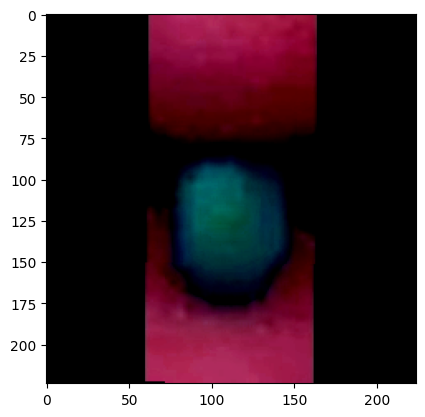

In [9]:
img = train_ds[0]['pixel_values']
plt.imshow(img.permute(1, 2, 0))

In [10]:
accuracy_metric = evaluate.load('accuracy')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

In [11]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [12]:
labels = train_ds.features['label'].names

model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True
)
for param in model.vit.parameters():
    param.requires_grad = False

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
training_args = TrainingArguments(
  output_dir=os.path.join('..', 'vit-pills'),
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=100,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True
)

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=processor,
)

In [15]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

  0%|          | 11/31700 [00:02<1:03:37,  8.30it/s]

{'loss': 0.6973, 'learning_rate': 0.00019993690851735017, 'epoch': 0.03}


  0%|          | 21/31700 [00:03<59:18,  8.90it/s]  

{'loss': 0.5486, 'learning_rate': 0.00019987381703470033, 'epoch': 0.06}


  0%|          | 31/31700 [00:04<58:15,  9.06it/s]

{'loss': 0.4782, 'learning_rate': 0.0001998107255520505, 'epoch': 0.09}


  0%|          | 41/31700 [00:05<58:02,  9.09it/s]

{'loss': 0.3946, 'learning_rate': 0.00019974763406940065, 'epoch': 0.13}


  0%|          | 51/31700 [00:06<1:00:14,  8.76it/s]

{'loss': 0.3509, 'learning_rate': 0.0001996845425867508, 'epoch': 0.16}


  0%|          | 61/31700 [00:08<1:01:15,  8.61it/s]

{'loss': 0.3294, 'learning_rate': 0.00019962145110410096, 'epoch': 0.19}


  0%|          | 71/31700 [00:09<57:44,  9.13it/s]  

{'loss': 0.317, 'learning_rate': 0.0001995583596214511, 'epoch': 0.22}


  0%|          | 81/31700 [00:10<1:01:26,  8.58it/s]

{'loss': 0.2533, 'learning_rate': 0.00019949526813880126, 'epoch': 0.25}


  0%|          | 91/31700 [00:11<56:46,  9.28it/s]  

{'loss': 0.2521, 'learning_rate': 0.00019943217665615144, 'epoch': 0.28}


  0%|          | 100/31700 [00:12<56:54,  9.25it/s]

{'loss': 0.2039, 'learning_rate': 0.0001993690851735016, 'epoch': 0.32}


                                                   
  0%|          | 100/31700 [00:17<56:54,  9.25it/s]

{'eval_loss': 0.22446058690547943, 'eval_accuracy': 0.9363762102351314, 'eval_runtime': 4.646, 'eval_samples_per_second': 311.237, 'eval_steps_per_second': 38.958, 'epoch': 0.32}


  0%|          | 111/31700 [00:18<1:20:13,  6.56it/s] 

{'loss': 0.1804, 'learning_rate': 0.00019930599369085173, 'epoch': 0.35}


  0%|          | 121/31700 [00:19<1:01:18,  8.58it/s]

{'loss': 0.1912, 'learning_rate': 0.0001992429022082019, 'epoch': 0.38}


  0%|          | 131/31700 [00:20<1:00:55,  8.64it/s]

{'loss': 0.1588, 'learning_rate': 0.00019917981072555205, 'epoch': 0.41}


  0%|          | 141/31700 [00:22<57:09,  9.20it/s]  

{'loss': 0.1577, 'learning_rate': 0.00019911671924290224, 'epoch': 0.44}


  0%|          | 151/31700 [00:23<1:00:10,  8.74it/s]

{'loss': 0.1633, 'learning_rate': 0.00019905362776025237, 'epoch': 0.47}


  1%|          | 161/31700 [00:24<59:36,  8.82it/s]  

{'loss': 0.1552, 'learning_rate': 0.00019899053627760253, 'epoch': 0.5}


  1%|          | 171/31700 [00:25<57:30,  9.14it/s]

{'loss': 0.1271, 'learning_rate': 0.0001989274447949527, 'epoch': 0.54}


  1%|          | 181/31700 [00:26<1:01:04,  8.60it/s]

{'loss': 0.1212, 'learning_rate': 0.00019886435331230285, 'epoch': 0.57}


  1%|          | 191/31700 [00:27<59:47,  8.78it/s]  

{'loss': 0.1249, 'learning_rate': 0.000198801261829653, 'epoch': 0.6}


  1%|          | 200/31700 [00:28<1:01:18,  8.56it/s]

{'loss': 0.1286, 'learning_rate': 0.00019873817034700317, 'epoch': 0.63}


                                                     
  1%|          | 200/31700 [00:33<1:01:18,  8.56it/s]

{'eval_loss': 0.1353529542684555, 'eval_accuracy': 0.9730290456431535, 'eval_runtime': 4.6055, 'eval_samples_per_second': 313.972, 'eval_steps_per_second': 39.301, 'epoch': 0.63}


  1%|          | 212/31700 [00:34<1:12:35,  7.23it/s] 

{'loss': 0.127, 'learning_rate': 0.00019867507886435333, 'epoch': 0.66}


  1%|          | 221/31700 [00:35<59:08,  8.87it/s]  

{'loss': 0.0839, 'learning_rate': 0.00019861198738170348, 'epoch': 0.69}


  1%|          | 231/31700 [00:37<1:00:03,  8.73it/s]

{'loss': 0.1117, 'learning_rate': 0.00019854889589905364, 'epoch': 0.73}


  1%|          | 241/31700 [00:38<1:01:06,  8.58it/s]

{'loss': 0.106, 'learning_rate': 0.00019848580441640378, 'epoch': 0.76}


  1%|          | 251/31700 [00:39<58:42,  8.93it/s]  

{'loss': 0.0895, 'learning_rate': 0.00019842271293375396, 'epoch': 0.79}


  1%|          | 261/31700 [00:40<1:00:40,  8.64it/s]

{'loss': 0.0847, 'learning_rate': 0.00019835962145110412, 'epoch': 0.82}


  1%|          | 271/31700 [00:41<1:00:05,  8.72it/s]

{'loss': 0.0736, 'learning_rate': 0.00019829652996845428, 'epoch': 0.85}


  1%|          | 281/31700 [00:42<59:40,  8.78it/s]  

{'loss': 0.0921, 'learning_rate': 0.0001982334384858044, 'epoch': 0.88}


  1%|          | 291/31700 [00:43<59:09,  8.85it/s]  

{'loss': 0.0834, 'learning_rate': 0.00019817034700315457, 'epoch': 0.91}


  1%|          | 300/31700 [00:44<58:25,  8.96it/s]

{'loss': 0.068, 'learning_rate': 0.00019810725552050473, 'epoch': 0.95}


                                                   
  1%|          | 300/31700 [00:49<58:25,  8.96it/s]

{'eval_loss': 0.1071188747882843, 'eval_accuracy': 0.9778699861687413, 'eval_runtime': 4.6071, 'eval_samples_per_second': 313.86, 'eval_steps_per_second': 39.287, 'epoch': 0.95}


  1%|          | 311/31700 [00:50<1:19:20,  6.59it/s] 

{'loss': 0.0634, 'learning_rate': 0.00019804416403785492, 'epoch': 0.98}


  1%|          | 321/31700 [00:52<55:52,  9.36it/s]  

{'loss': 0.0853, 'learning_rate': 0.00019798107255520505, 'epoch': 1.01}


  1%|          | 331/31700 [00:53<57:57,  9.02it/s]

{'loss': 0.0808, 'learning_rate': 0.0001979179810725552, 'epoch': 1.04}


  1%|          | 341/31700 [00:54<1:00:22,  8.66it/s]

{'loss': 0.0894, 'learning_rate': 0.00019785488958990537, 'epoch': 1.07}


  1%|          | 351/31700 [00:55<57:32,  9.08it/s]  

{'loss': 0.0605, 'learning_rate': 0.00019779179810725553, 'epoch': 1.1}


  1%|          | 361/31700 [00:56<57:44,  9.05it/s]

{'loss': 0.0536, 'learning_rate': 0.00019772870662460569, 'epoch': 1.14}


  1%|          | 371/31700 [00:57<1:01:40,  8.47it/s]

{'loss': 0.0649, 'learning_rate': 0.00019766561514195585, 'epoch': 1.17}


  1%|          | 381/31700 [00:58<56:59,  9.16it/s]  

{'loss': 0.0395, 'learning_rate': 0.000197602523659306, 'epoch': 1.2}


  1%|          | 391/31700 [00:59<59:10,  8.82it/s]

{'loss': 0.0707, 'learning_rate': 0.00019753943217665616, 'epoch': 1.23}


  1%|▏         | 400/31700 [01:00<58:04,  8.98it/s]  

{'loss': 0.0528, 'learning_rate': 0.00019747634069400632, 'epoch': 1.26}


                                                   
  1%|▏         | 400/31700 [01:05<58:04,  8.98it/s]

{'eval_loss': 0.08606651425361633, 'eval_accuracy': 0.9813278008298755, 'eval_runtime': 4.6177, 'eval_samples_per_second': 313.144, 'eval_steps_per_second': 39.197, 'epoch': 1.26}


  1%|▏         | 411/31700 [01:06<1:26:00,  6.06it/s] 

{'loss': 0.0506, 'learning_rate': 0.00019741324921135645, 'epoch': 1.29}


  1%|▏         | 421/31700 [01:08<1:00:24,  8.63it/s]

{'loss': 0.042, 'learning_rate': 0.00019735015772870664, 'epoch': 1.32}


  1%|▏         | 431/31700 [01:09<1:00:26,  8.62it/s]

{'loss': 0.0466, 'learning_rate': 0.0001972870662460568, 'epoch': 1.36}


  1%|▏         | 441/31700 [01:10<58:46,  8.87it/s]  

{'loss': 0.0854, 'learning_rate': 0.00019722397476340696, 'epoch': 1.39}


  1%|▏         | 451/31700 [01:11<1:00:00,  8.68it/s]

{'loss': 0.0497, 'learning_rate': 0.0001971608832807571, 'epoch': 1.42}


  1%|▏         | 461/31700 [01:12<58:39,  8.88it/s]  

{'loss': 0.0394, 'learning_rate': 0.00019709779179810725, 'epoch': 1.45}


  1%|▏         | 471/31700 [01:13<56:56,  9.14it/s]

{'loss': 0.0493, 'learning_rate': 0.00019703470031545744, 'epoch': 1.48}


  2%|▏         | 481/31700 [01:14<58:01,  8.97it/s]

{'loss': 0.0644, 'learning_rate': 0.0001969716088328076, 'epoch': 1.51}


  2%|▏         | 491/31700 [01:15<1:02:19,  8.35it/s]

{'loss': 0.0532, 'learning_rate': 0.00019690851735015773, 'epoch': 1.55}


  2%|▏         | 500/31700 [01:16<56:31,  9.20it/s]  

{'loss': 0.0523, 'learning_rate': 0.0001968454258675079, 'epoch': 1.58}


                                                   
  2%|▏         | 500/31700 [01:21<56:31,  9.20it/s]

{'eval_loss': 0.08784017711877823, 'eval_accuracy': 0.9737206085753803, 'eval_runtime': 4.617, 'eval_samples_per_second': 313.191, 'eval_steps_per_second': 39.203, 'epoch': 1.58}


  2%|▏         | 511/31700 [01:22<1:17:40,  6.69it/s] 

{'loss': 0.0654, 'learning_rate': 0.00019678233438485805, 'epoch': 1.61}


  2%|▏         | 521/31700 [01:24<1:02:50,  8.27it/s]

{'loss': 0.0254, 'learning_rate': 0.0001967192429022082, 'epoch': 1.64}


  2%|▏         | 531/31700 [01:25<59:59,  8.66it/s]  

{'loss': 0.0467, 'learning_rate': 0.00019665615141955837, 'epoch': 1.67}


  2%|▏         | 541/31700 [01:26<57:38,  9.01it/s]

{'loss': 0.0583, 'learning_rate': 0.00019659305993690852, 'epoch': 1.7}


  2%|▏         | 551/31700 [01:27<1:00:11,  8.62it/s]

{'loss': 0.0595, 'learning_rate': 0.00019652996845425868, 'epoch': 1.74}


  2%|▏         | 561/31700 [01:28<1:00:19,  8.60it/s]

{'loss': 0.0507, 'learning_rate': 0.00019646687697160884, 'epoch': 1.77}


  2%|▏         | 571/31700 [01:29<59:19,  8.74it/s]  

{'loss': 0.0468, 'learning_rate': 0.000196403785488959, 'epoch': 1.8}


  2%|▏         | 581/31700 [01:30<59:44,  8.68it/s]  

{'loss': 0.0395, 'learning_rate': 0.00019634069400630916, 'epoch': 1.83}


  2%|▏         | 591/31700 [01:31<58:36,  8.85it/s]

{'loss': 0.0363, 'learning_rate': 0.00019627760252365932, 'epoch': 1.86}


  2%|▏         | 600/31700 [01:32<57:01,  9.09it/s]

{'loss': 0.04, 'learning_rate': 0.00019621451104100948, 'epoch': 1.89}


                                                   
  2%|▏         | 600/31700 [01:37<57:01,  9.09it/s]

{'eval_loss': 0.07941702753305435, 'eval_accuracy': 0.9785615491009682, 'eval_runtime': 4.6623, 'eval_samples_per_second': 310.147, 'eval_steps_per_second': 38.822, 'epoch': 1.89}


  2%|▏         | 611/31700 [01:39<1:18:14,  6.62it/s] 

{'loss': 0.0459, 'learning_rate': 0.00019615141955835964, 'epoch': 1.92}


  2%|▏         | 621/31700 [01:40<58:57,  8.79it/s]  

{'loss': 0.067, 'learning_rate': 0.00019608832807570977, 'epoch': 1.96}


  2%|▏         | 631/31700 [01:41<1:01:57,  8.36it/s]

{'loss': 0.0433, 'learning_rate': 0.00019602523659305993, 'epoch': 1.99}


  2%|▏         | 641/31700 [01:42<56:51,  9.10it/s]  

{'loss': 0.0309, 'learning_rate': 0.00019596214511041012, 'epoch': 2.02}


  2%|▏         | 651/31700 [01:43<57:55,  8.93it/s]

{'loss': 0.0303, 'learning_rate': 0.00019589905362776028, 'epoch': 2.05}


  2%|▏         | 661/31700 [01:44<59:25,  8.70it/s]  

{'loss': 0.0465, 'learning_rate': 0.0001958359621451104, 'epoch': 2.08}


  2%|▏         | 671/31700 [01:45<58:28,  8.84it/s]

{'loss': 0.0243, 'learning_rate': 0.00019577287066246057, 'epoch': 2.11}


  2%|▏         | 681/31700 [01:46<59:39,  8.67it/s]

{'loss': 0.0437, 'learning_rate': 0.00019570977917981073, 'epoch': 2.15}


  2%|▏         | 691/31700 [01:48<57:42,  8.96it/s]

{'loss': 0.0454, 'learning_rate': 0.0001956466876971609, 'epoch': 2.18}


  2%|▏         | 700/31700 [01:49<1:01:31,  8.40it/s]

{'loss': 0.0399, 'learning_rate': 0.00019558359621451104, 'epoch': 2.21}


                                                     
  2%|▏         | 700/31700 [01:53<1:01:31,  8.40it/s]

{'eval_loss': 0.08950638025999069, 'eval_accuracy': 0.9702627939142462, 'eval_runtime': 4.6187, 'eval_samples_per_second': 313.072, 'eval_steps_per_second': 39.188, 'epoch': 2.21}


  2%|▏         | 712/31700 [01:55<1:11:12,  7.25it/s] 

{'loss': 0.0269, 'learning_rate': 0.0001955205047318612, 'epoch': 2.24}


  2%|▏         | 721/31700 [01:56<57:01,  9.05it/s]  

{'loss': 0.0477, 'learning_rate': 0.00019545741324921136, 'epoch': 2.27}


  2%|▏         | 732/31700 [01:57<58:39,  8.80it/s]  

{'loss': 0.0447, 'learning_rate': 0.00019539432176656152, 'epoch': 2.3}


  2%|▏         | 741/31700 [01:58<55:28,  9.30it/s]

{'loss': 0.0398, 'learning_rate': 0.00019533123028391168, 'epoch': 2.33}


  2%|▏         | 751/31700 [01:59<58:46,  8.78it/s]

{'loss': 0.0334, 'learning_rate': 0.00019526813880126184, 'epoch': 2.37}


  2%|▏         | 761/31700 [02:00<59:43,  8.63it/s]  

{'loss': 0.0225, 'learning_rate': 0.000195205047318612, 'epoch': 2.4}


  2%|▏         | 771/31700 [02:01<58:39,  8.79it/s]

{'loss': 0.042, 'learning_rate': 0.00019514195583596216, 'epoch': 2.43}


  2%|▏         | 781/31700 [02:02<59:10,  8.71it/s]

{'loss': 0.0355, 'learning_rate': 0.00019507886435331232, 'epoch': 2.46}


  2%|▏         | 791/31700 [02:04<56:10,  9.17it/s]  

{'loss': 0.0575, 'learning_rate': 0.00019501577287066245, 'epoch': 2.49}


  3%|▎         | 800/31700 [02:05<56:44,  9.08it/s]

{'loss': 0.055, 'learning_rate': 0.00019495268138801264, 'epoch': 2.52}


                                                   
  3%|▎         | 800/31700 [02:09<56:44,  9.08it/s]

{'eval_loss': 0.08676836639642715, 'eval_accuracy': 0.9716459197786999, 'eval_runtime': 4.6667, 'eval_samples_per_second': 309.855, 'eval_steps_per_second': 38.785, 'epoch': 2.52}


  3%|▎         | 811/31700 [02:11<1:17:14,  6.67it/s] 

{'loss': 0.0499, 'learning_rate': 0.0001948895899053628, 'epoch': 2.56}


  3%|▎         | 821/31700 [02:12<57:51,  8.89it/s]  

{'loss': 0.0296, 'learning_rate': 0.00019482649842271295, 'epoch': 2.59}


  3%|▎         | 831/31700 [02:13<1:02:59,  8.17it/s]

{'loss': 0.0409, 'learning_rate': 0.0001947634069400631, 'epoch': 2.62}


  3%|▎         | 841/31700 [02:14<56:26,  9.11it/s]  

{'loss': 0.0322, 'learning_rate': 0.00019470031545741325, 'epoch': 2.65}


  3%|▎         | 851/31700 [02:15<56:57,  9.03it/s]

{'loss': 0.036, 'learning_rate': 0.0001946372239747634, 'epoch': 2.68}


  3%|▎         | 861/31700 [02:16<57:15,  8.98it/s]  

{'loss': 0.034, 'learning_rate': 0.0001945741324921136, 'epoch': 2.71}


  3%|▎         | 871/31700 [02:17<56:07,  9.15it/s]

{'loss': 0.0369, 'learning_rate': 0.00019451104100946372, 'epoch': 2.74}


  3%|▎         | 881/31700 [02:19<57:59,  8.86it/s]

{'loss': 0.0281, 'learning_rate': 0.00019444794952681388, 'epoch': 2.78}


  3%|▎         | 891/31700 [02:20<59:16,  8.66it/s]  

{'loss': 0.0332, 'learning_rate': 0.00019438485804416404, 'epoch': 2.81}


  3%|▎         | 900/31700 [02:21<55:53,  9.18it/s]

{'loss': 0.026, 'learning_rate': 0.0001943217665615142, 'epoch': 2.84}


                                                   
  3%|▎         | 900/31700 [02:25<55:53,  9.18it/s]

{'eval_loss': 0.068342424929142, 'eval_accuracy': 0.9827109266943291, 'eval_runtime': 4.5842, 'eval_samples_per_second': 315.435, 'eval_steps_per_second': 39.484, 'epoch': 2.84}


  3%|▎         | 911/31700 [02:27<1:18:44,  6.52it/s] 

{'loss': 0.0193, 'learning_rate': 0.00019425867507886436, 'epoch': 2.87}


  3%|▎         | 921/31700 [02:28<57:38,  8.90it/s]  

{'loss': 0.0226, 'learning_rate': 0.00019419558359621452, 'epoch': 2.9}


  3%|▎         | 931/31700 [02:29<1:01:23,  8.35it/s]

{'loss': 0.0329, 'learning_rate': 0.00019413249211356468, 'epoch': 2.93}


  3%|▎         | 941/31700 [02:30<56:08,  9.13it/s]  

{'loss': 0.0479, 'learning_rate': 0.00019406940063091484, 'epoch': 2.97}


  3%|▎         | 952/31700 [02:31<50:51, 10.08it/s]

{'loss': 0.0199, 'learning_rate': 0.000194006309148265, 'epoch': 3.0}


  3%|▎         | 961/31700 [02:32<55:28,  9.23it/s]

{'loss': 0.0617, 'learning_rate': 0.00019394321766561516, 'epoch': 3.03}


  3%|▎         | 971/31700 [02:33<58:05,  8.82it/s]

{'loss': 0.0303, 'learning_rate': 0.00019388012618296532, 'epoch': 3.06}


  3%|▎         | 981/31700 [02:34<55:36,  9.21it/s]  

{'loss': 0.0142, 'learning_rate': 0.00019381703470031547, 'epoch': 3.09}


  3%|▎         | 991/31700 [02:36<57:17,  8.93it/s]

{'loss': 0.0308, 'learning_rate': 0.00019375394321766563, 'epoch': 3.12}


  3%|▎         | 1000/31700 [02:37<57:42,  8.87it/s] 

{'loss': 0.0225, 'learning_rate': 0.00019369085173501577, 'epoch': 3.15}


                                                    
  3%|▎         | 1000/31700 [02:41<57:42,  8.87it/s]

{'eval_loss': 0.07646026462316513, 'eval_accuracy': 0.9744121715076072, 'eval_runtime': 4.6423, 'eval_samples_per_second': 311.486, 'eval_steps_per_second': 38.99, 'epoch': 3.15}


  3%|▎         | 1011/31700 [02:43<1:16:46,  6.66it/s] 

{'loss': 0.0413, 'learning_rate': 0.00019362776025236592, 'epoch': 3.19}


  3%|▎         | 1021/31700 [02:44<57:37,  8.87it/s]  

{'loss': 0.0272, 'learning_rate': 0.0001935646687697161, 'epoch': 3.22}


  3%|▎         | 1031/31700 [02:45<59:27,  8.60it/s]  

{'loss': 0.038, 'learning_rate': 0.00019350157728706627, 'epoch': 3.25}


  3%|▎         | 1041/31700 [02:46<56:02,  9.12it/s]  

{'loss': 0.0254, 'learning_rate': 0.0001934384858044164, 'epoch': 3.28}


  3%|▎         | 1051/31700 [02:47<57:38,  8.86it/s]

{'loss': 0.0264, 'learning_rate': 0.00019337539432176656, 'epoch': 3.31}


  3%|▎         | 1061/31700 [02:48<56:26,  9.05it/s]  

{'loss': 0.036, 'learning_rate': 0.00019331230283911672, 'epoch': 3.34}


  3%|▎         | 1071/31700 [02:49<56:11,  9.08it/s]

{'loss': 0.0188, 'learning_rate': 0.0001932492113564669, 'epoch': 3.38}


  3%|▎         | 1081/31700 [02:51<1:00:11,  8.48it/s]

{'loss': 0.032, 'learning_rate': 0.00019318611987381704, 'epoch': 3.41}


  3%|▎         | 1091/31700 [02:52<57:07,  8.93it/s]  

{'loss': 0.0117, 'learning_rate': 0.0001931230283911672, 'epoch': 3.44}


  3%|▎         | 1100/31700 [02:53<55:32,  9.18it/s]

{'loss': 0.0347, 'learning_rate': 0.00019305993690851736, 'epoch': 3.47}


                                                    
  3%|▎         | 1100/31700 [02:57<55:32,  9.18it/s]

{'eval_loss': 0.05607954412698746, 'eval_accuracy': 0.9861687413554634, 'eval_runtime': 4.6013, 'eval_samples_per_second': 314.259, 'eval_steps_per_second': 39.337, 'epoch': 3.47}


  4%|▎         | 1111/31700 [02:59<1:17:04,  6.61it/s] 

{'loss': 0.0258, 'learning_rate': 0.00019299684542586752, 'epoch': 3.5}


  4%|▎         | 1121/31700 [03:00<58:26,  8.72it/s]  

{'loss': 0.0182, 'learning_rate': 0.00019293375394321768, 'epoch': 3.53}


  4%|▎         | 1132/31700 [03:01<56:51,  8.96it/s]

{'loss': 0.0228, 'learning_rate': 0.00019287066246056784, 'epoch': 3.56}


  4%|▎         | 1141/31700 [03:02<56:32,  9.01it/s]

{'loss': 0.0147, 'learning_rate': 0.000192807570977918, 'epoch': 3.6}


  4%|▎         | 1151/31700 [03:03<56:47,  8.97it/s]

{'loss': 0.0219, 'learning_rate': 0.00019274447949526815, 'epoch': 3.63}


  4%|▎         | 1161/31700 [03:04<57:26,  8.86it/s]

{'loss': 0.0187, 'learning_rate': 0.0001926813880126183, 'epoch': 3.66}


  4%|▎         | 1171/31700 [03:05<56:24,  9.02it/s]

{'loss': 0.0527, 'learning_rate': 0.00019261829652996844, 'epoch': 3.69}


  4%|▎         | 1181/31700 [03:07<59:54,  8.49it/s]

{'loss': 0.0341, 'learning_rate': 0.00019255520504731863, 'epoch': 3.72}


  4%|▍         | 1191/31700 [03:08<57:04,  8.91it/s]

{'loss': 0.024, 'learning_rate': 0.0001924921135646688, 'epoch': 3.75}


  4%|▍         | 1200/31700 [03:09<58:21,  8.71it/s]  

{'loss': 0.0397, 'learning_rate': 0.00019242902208201895, 'epoch': 3.79}


                                                    
  4%|▍         | 1200/31700 [03:13<58:21,  8.71it/s]

{'eval_loss': 0.05602937564253807, 'eval_accuracy': 0.9847856154910097, 'eval_runtime': 4.618, 'eval_samples_per_second': 313.119, 'eval_steps_per_second': 39.194, 'epoch': 3.79}


  4%|▍         | 1211/31700 [03:15<1:16:35,  6.64it/s] 

{'loss': 0.0214, 'learning_rate': 0.00019236593059936908, 'epoch': 3.82}


  4%|▍         | 1221/31700 [03:16<57:59,  8.76it/s]  

{'loss': 0.0294, 'learning_rate': 0.00019230283911671924, 'epoch': 3.85}


  4%|▍         | 1231/31700 [03:17<59:16,  8.57it/s]

{'loss': 0.0321, 'learning_rate': 0.0001922397476340694, 'epoch': 3.88}


  4%|▍         | 1241/31700 [03:18<55:46,  9.10it/s]

{'loss': 0.0203, 'learning_rate': 0.00019217665615141959, 'epoch': 3.91}


  4%|▍         | 1251/31700 [03:19<56:52,  8.92it/s]

{'loss': 0.0225, 'learning_rate': 0.00019211356466876972, 'epoch': 3.94}


  4%|▍         | 1261/31700 [03:20<58:40,  8.65it/s]  

{'loss': 0.0349, 'learning_rate': 0.00019205047318611988, 'epoch': 3.97}


  4%|▍         | 1271/31700 [03:21<52:28,  9.66it/s]

{'loss': 0.0352, 'learning_rate': 0.00019198738170347004, 'epoch': 4.01}


  4%|▍         | 1281/31700 [03:23<54:32,  9.29it/s]

{'loss': 0.0366, 'learning_rate': 0.0001919242902208202, 'epoch': 4.04}


  4%|▍         | 1291/31700 [03:24<1:00:25,  8.39it/s]

{'loss': 0.03, 'learning_rate': 0.00019186119873817036, 'epoch': 4.07}


  4%|▍         | 1300/31700 [03:25<57:41,  8.78it/s]  

{'loss': 0.0456, 'learning_rate': 0.00019179810725552051, 'epoch': 4.1}


                                                    
  4%|▍         | 1300/31700 [03:30<57:41,  8.78it/s]

{'eval_loss': 0.05824364349246025, 'eval_accuracy': 0.9840940525587828, 'eval_runtime': 4.8055, 'eval_samples_per_second': 300.903, 'eval_steps_per_second': 37.665, 'epoch': 4.1}


  4%|▍         | 1311/31700 [03:31<1:17:54,  6.50it/s] 

{'loss': 0.0209, 'learning_rate': 0.00019173501577287067, 'epoch': 4.13}


  4%|▍         | 1321/31700 [03:32<57:38,  8.78it/s]  

{'loss': 0.0166, 'learning_rate': 0.00019167192429022083, 'epoch': 4.16}


  4%|▍         | 1331/31700 [03:33<56:33,  8.95it/s]  

{'loss': 0.0285, 'learning_rate': 0.000191608832807571, 'epoch': 4.2}


  4%|▍         | 1341/31700 [03:34<55:29,  9.12it/s]

{'loss': 0.017, 'learning_rate': 0.00019154574132492112, 'epoch': 4.23}


  4%|▍         | 1351/31700 [03:36<59:18,  8.53it/s]  

{'loss': 0.0234, 'learning_rate': 0.0001914826498422713, 'epoch': 4.26}


  4%|▍         | 1361/31700 [03:37<56:13,  8.99it/s]

{'loss': 0.0192, 'learning_rate': 0.00019141955835962147, 'epoch': 4.29}


  4%|▍         | 1372/31700 [03:38<56:07,  9.01it/s]

{'loss': 0.0215, 'learning_rate': 0.00019135646687697163, 'epoch': 4.32}


  4%|▍         | 1381/31700 [03:39<1:00:46,  8.31it/s]

{'loss': 0.0373, 'learning_rate': 0.00019129337539432176, 'epoch': 4.35}


  4%|▍         | 1391/31700 [03:40<56:23,  8.96it/s]  

{'loss': 0.039, 'learning_rate': 0.00019123028391167192, 'epoch': 4.38}


  4%|▍         | 1400/31700 [03:41<57:40,  8.76it/s]

{'loss': 0.0292, 'learning_rate': 0.0001911671924290221, 'epoch': 4.42}


                                                    
  4%|▍         | 1400/31700 [03:46<57:40,  8.76it/s]

{'eval_loss': 0.04774998128414154, 'eval_accuracy': 0.9861687413554634, 'eval_runtime': 4.5921, 'eval_samples_per_second': 314.886, 'eval_steps_per_second': 39.415, 'epoch': 4.42}


  4%|▍         | 1411/31700 [03:47<1:17:18,  6.53it/s] 

{'loss': 0.0283, 'learning_rate': 0.00019110410094637227, 'epoch': 4.45}


  4%|▍         | 1421/31700 [03:48<59:49,  8.43it/s]  

{'loss': 0.0453, 'learning_rate': 0.0001910410094637224, 'epoch': 4.48}


  5%|▍         | 1431/31700 [03:50<56:08,  8.99it/s]

{'loss': 0.0207, 'learning_rate': 0.00019097791798107256, 'epoch': 4.51}


  5%|▍         | 1441/31700 [03:51<57:05,  8.83it/s]

{'loss': 0.0108, 'learning_rate': 0.00019091482649842272, 'epoch': 4.54}


  5%|▍         | 1451/31700 [03:52<56:35,  8.91it/s]

{'loss': 0.0157, 'learning_rate': 0.00019085173501577287, 'epoch': 4.57}


  5%|▍         | 1461/31700 [03:53<54:28,  9.25it/s]

{'loss': 0.022, 'learning_rate': 0.00019078864353312303, 'epoch': 4.61}


  5%|▍         | 1471/31700 [03:54<58:54,  8.55it/s]

{'loss': 0.0285, 'learning_rate': 0.0001907255520504732, 'epoch': 4.64}


  5%|▍         | 1481/31700 [03:55<56:53,  8.85it/s]

{'loss': 0.0334, 'learning_rate': 0.00019066246056782335, 'epoch': 4.67}


  5%|▍         | 1491/31700 [03:56<57:08,  8.81it/s]

{'loss': 0.0548, 'learning_rate': 0.0001905993690851735, 'epoch': 4.7}


  5%|▍         | 1500/31700 [03:57<57:23,  8.77it/s]

{'loss': 0.0477, 'learning_rate': 0.00019053627760252367, 'epoch': 4.73}


                                                    
  5%|▍         | 1500/31700 [04:02<57:23,  8.77it/s]

{'eval_loss': 0.054232824593782425, 'eval_accuracy': 0.9847856154910097, 'eval_runtime': 4.5996, 'eval_samples_per_second': 314.376, 'eval_steps_per_second': 39.351, 'epoch': 4.73}


  5%|▍         | 1511/31700 [04:03<1:15:44,  6.64it/s] 

{'loss': 0.0166, 'learning_rate': 0.00019047318611987383, 'epoch': 4.76}


  5%|▍         | 1521/31700 [04:04<56:48,  8.86it/s]  

{'loss': 0.0233, 'learning_rate': 0.000190410094637224, 'epoch': 4.79}


  5%|▍         | 1531/31700 [04:06<56:21,  8.92it/s]

{'loss': 0.027, 'learning_rate': 0.00019034700315457415, 'epoch': 4.83}


  5%|▍         | 1541/31700 [04:07<56:34,  8.88it/s]

{'loss': 0.0373, 'learning_rate': 0.0001902839116719243, 'epoch': 4.86}


  5%|▍         | 1551/31700 [04:08<57:25,  8.75it/s]

{'loss': 0.0412, 'learning_rate': 0.00019022082018927444, 'epoch': 4.89}


  5%|▍         | 1561/31700 [04:09<55:50,  9.00it/s]  

{'loss': 0.0444, 'learning_rate': 0.0001901577287066246, 'epoch': 4.92}


  5%|▍         | 1571/31700 [04:10<55:12,  9.10it/s]

{'loss': 0.0127, 'learning_rate': 0.00019009463722397479, 'epoch': 4.95}


  5%|▍         | 1581/31700 [04:11<58:15,  8.62it/s]

{'loss': 0.0093, 'learning_rate': 0.00019003154574132494, 'epoch': 4.98}


  5%|▌         | 1591/31700 [04:12<55:17,  9.08it/s]

{'loss': 0.0187, 'learning_rate': 0.00018996845425867508, 'epoch': 5.02}


  5%|▌         | 1600/31700 [04:13<56:46,  8.84it/s]

{'loss': 0.0181, 'learning_rate': 0.00018990536277602524, 'epoch': 5.05}


                                                    
  5%|▌         | 1600/31700 [04:18<56:46,  8.84it/s]

{'eval_loss': 0.0538586862385273, 'eval_accuracy': 0.9840940525587828, 'eval_runtime': 4.5248, 'eval_samples_per_second': 319.572, 'eval_steps_per_second': 40.002, 'epoch': 5.05}


  5%|▌         | 1611/31700 [04:19<1:16:37,  6.55it/s] 

{'loss': 0.0276, 'learning_rate': 0.0001898422712933754, 'epoch': 5.08}


  5%|▌         | 1621/31700 [04:20<56:30,  8.87it/s]  

{'loss': 0.0158, 'learning_rate': 0.00018977917981072558, 'epoch': 5.11}


  5%|▌         | 1631/31700 [04:22<55:52,  8.97it/s]

{'loss': 0.0114, 'learning_rate': 0.0001897160883280757, 'epoch': 5.14}


  5%|▌         | 1641/31700 [04:23<57:29,  8.71it/s]

{'loss': 0.0131, 'learning_rate': 0.00018965299684542587, 'epoch': 5.17}


  5%|▌         | 1651/31700 [04:24<57:25,  8.72it/s]

{'loss': 0.0236, 'learning_rate': 0.00018958990536277603, 'epoch': 5.21}


  5%|▌         | 1661/31700 [04:25<55:35,  9.01it/s]  

{'loss': 0.0167, 'learning_rate': 0.0001895268138801262, 'epoch': 5.24}


  5%|▌         | 1671/31700 [04:26<55:24,  9.03it/s]

{'loss': 0.0379, 'learning_rate': 0.00018946372239747635, 'epoch': 5.27}


  5%|▌         | 1681/31700 [04:27<59:26,  8.42it/s]

{'loss': 0.0192, 'learning_rate': 0.0001894006309148265, 'epoch': 5.3}


  5%|▌         | 1691/31700 [04:28<55:38,  8.99it/s]  

{'loss': 0.0156, 'learning_rate': 0.00018933753943217667, 'epoch': 5.33}


  5%|▌         | 1700/31700 [04:29<54:45,  9.13it/s]

{'loss': 0.0331, 'learning_rate': 0.00018927444794952683, 'epoch': 5.36}


                                                    
  5%|▌         | 1700/31700 [04:34<54:45,  9.13it/s]

{'eval_loss': 0.05968353897333145, 'eval_accuracy': 0.9820193637621023, 'eval_runtime': 4.5387, 'eval_samples_per_second': 318.596, 'eval_steps_per_second': 39.88, 'epoch': 5.36}


  5%|▌         | 1712/31700 [04:35<1:08:11,  7.33it/s] 

{'loss': 0.0225, 'learning_rate': 0.000189211356466877, 'epoch': 5.39}


  5%|▌         | 1721/31700 [04:36<55:36,  8.98it/s]  

{'loss': 0.0098, 'learning_rate': 0.00018914826498422712, 'epoch': 5.43}


  5%|▌         | 1731/31700 [04:38<58:56,  8.47it/s]

{'loss': 0.0138, 'learning_rate': 0.0001890851735015773, 'epoch': 5.46}


  5%|▌         | 1741/31700 [04:39<55:35,  8.98it/s]

{'loss': 0.0515, 'learning_rate': 0.00018902208201892746, 'epoch': 5.49}


  6%|▌         | 1751/31700 [04:40<56:32,  8.83it/s]

{'loss': 0.0284, 'learning_rate': 0.00018895899053627762, 'epoch': 5.52}


  6%|▌         | 1761/31700 [04:41<55:08,  9.05it/s]

{'loss': 0.0108, 'learning_rate': 0.00018889589905362776, 'epoch': 5.55}


  6%|▌         | 1771/31700 [04:42<53:42,  9.29it/s]

{'loss': 0.0199, 'learning_rate': 0.00018883280757097791, 'epoch': 5.58}


  6%|▌         | 1781/31700 [04:43<58:19,  8.55it/s]

{'loss': 0.0324, 'learning_rate': 0.00018876971608832807, 'epoch': 5.62}


  6%|▌         | 1791/31700 [04:44<55:08,  9.04it/s]

{'loss': 0.0215, 'learning_rate': 0.00018870662460567826, 'epoch': 5.65}


  6%|▌         | 1800/31700 [04:45<56:46,  8.78it/s]

{'loss': 0.0417, 'learning_rate': 0.0001886435331230284, 'epoch': 5.68}


                                                    
  6%|▌         | 1800/31700 [04:50<56:46,  8.78it/s]

{'eval_loss': 0.06334425508975983, 'eval_accuracy': 0.9799446749654218, 'eval_runtime': 4.5197, 'eval_samples_per_second': 319.93, 'eval_steps_per_second': 40.047, 'epoch': 5.68}


  6%|▌         | 1811/31700 [04:51<1:15:34,  6.59it/s] 

{'loss': 0.0234, 'learning_rate': 0.00018858044164037855, 'epoch': 5.71}


  6%|▌         | 1821/31700 [04:52<57:32,  8.66it/s]  

{'loss': 0.0282, 'learning_rate': 0.0001885173501577287, 'epoch': 5.74}


  6%|▌         | 1831/31700 [04:53<54:06,  9.20it/s]  

{'loss': 0.0247, 'learning_rate': 0.00018845425867507887, 'epoch': 5.77}


  6%|▌         | 1842/31700 [04:55<53:55,  9.23it/s]

{'loss': 0.0435, 'learning_rate': 0.00018839116719242903, 'epoch': 5.8}


  6%|▌         | 1851/31700 [04:56<58:42,  8.47it/s]

{'loss': 0.0261, 'learning_rate': 0.0001883280757097792, 'epoch': 5.84}


  6%|▌         | 1861/31700 [04:57<54:32,  9.12it/s]

{'loss': 0.013, 'learning_rate': 0.00018826498422712935, 'epoch': 5.87}


  6%|▌         | 1871/31700 [04:58<59:45,  8.32it/s]

{'loss': 0.0145, 'learning_rate': 0.0001882018927444795, 'epoch': 5.9}


  6%|▌         | 1881/31700 [04:59<53:50,  9.23it/s]  

{'loss': 0.0161, 'learning_rate': 0.00018813880126182967, 'epoch': 5.93}


  6%|▌         | 1891/31700 [05:00<55:57,  8.88it/s]

{'loss': 0.0189, 'learning_rate': 0.0001880757097791798, 'epoch': 5.96}


  6%|▌         | 1900/31700 [05:01<56:02,  8.86it/s]  

{'loss': 0.0261, 'learning_rate': 0.00018801261829652998, 'epoch': 5.99}


                                                    
  6%|▌         | 1900/31700 [05:06<56:02,  8.86it/s]

{'eval_loss': 0.05446552112698555, 'eval_accuracy': 0.9847856154910097, 'eval_runtime': 4.5386, 'eval_samples_per_second': 318.598, 'eval_steps_per_second': 39.88, 'epoch': 5.99}


  6%|▌         | 1911/31700 [05:07<1:21:36,  6.08it/s] 

{'loss': 0.0159, 'learning_rate': 0.00018794952681388014, 'epoch': 6.03}


  6%|▌         | 1921/31700 [05:08<55:27,  8.95it/s]  

{'loss': 0.0081, 'learning_rate': 0.0001878864353312303, 'epoch': 6.06}


  6%|▌         | 1931/31700 [05:09<56:40,  8.75it/s]

{'loss': 0.0193, 'learning_rate': 0.00018782334384858043, 'epoch': 6.09}


  6%|▌         | 1941/31700 [05:11<55:34,  8.92it/s]

{'loss': 0.0194, 'learning_rate': 0.0001877602523659306, 'epoch': 6.12}


  6%|▌         | 1951/31700 [05:12<57:27,  8.63it/s]

{'loss': 0.0205, 'learning_rate': 0.00018769716088328078, 'epoch': 6.15}


  6%|▌         | 1961/31700 [05:13<55:41,  8.90it/s]  

{'loss': 0.0324, 'learning_rate': 0.00018763406940063094, 'epoch': 6.18}


  6%|▌         | 1971/31700 [05:14<56:28,  8.77it/s]

{'loss': 0.0147, 'learning_rate': 0.00018757097791798107, 'epoch': 6.21}


  6%|▌         | 1981/31700 [05:15<55:03,  9.00it/s]

{'loss': 0.0099, 'learning_rate': 0.00018750788643533123, 'epoch': 6.25}


  6%|▋         | 1991/31700 [05:16<54:27,  9.09it/s]

{'loss': 0.0095, 'learning_rate': 0.0001874447949526814, 'epoch': 6.28}


  6%|▋         | 2000/31700 [05:17<56:54,  8.70it/s]

{'loss': 0.0133, 'learning_rate': 0.00018738170347003155, 'epoch': 6.31}


                                                    
  6%|▋         | 2000/31700 [05:22<56:54,  8.70it/s]

{'eval_loss': 0.05006459727883339, 'eval_accuracy': 0.9868603042876902, 'eval_runtime': 4.5725, 'eval_samples_per_second': 316.238, 'eval_steps_per_second': 39.584, 'epoch': 6.31}


  6%|▋         | 2011/31700 [05:23<1:17:19,  6.40it/s] 

{'loss': 0.0277, 'learning_rate': 0.0001873186119873817, 'epoch': 6.34}


  6%|▋         | 2021/31700 [05:24<57:32,  8.60it/s]  

{'loss': 0.0107, 'learning_rate': 0.00018725552050473187, 'epoch': 6.37}


  6%|▋         | 2031/31700 [05:25<54:21,  9.10it/s]

{'loss': 0.0218, 'learning_rate': 0.00018719242902208203, 'epoch': 6.4}


  6%|▋         | 2041/31700 [05:27<53:44,  9.20it/s]

{'loss': 0.0158, 'learning_rate': 0.00018712933753943219, 'epoch': 6.44}


  6%|▋         | 2051/31700 [05:28<55:13,  8.95it/s]

{'loss': 0.0248, 'learning_rate': 0.00018706624605678234, 'epoch': 6.47}


  7%|▋         | 2061/31700 [05:29<54:18,  9.10it/s]

{'loss': 0.0333, 'learning_rate': 0.0001870031545741325, 'epoch': 6.5}


  7%|▋         | 2071/31700 [05:30<56:43,  8.70it/s]

{'loss': 0.013, 'learning_rate': 0.00018694006309148266, 'epoch': 6.53}


  7%|▋         | 2082/31700 [05:31<53:56,  9.15it/s]  

{'loss': 0.0117, 'learning_rate': 0.00018687697160883282, 'epoch': 6.56}


  7%|▋         | 2091/31700 [05:32<53:49,  9.17it/s]

{'loss': 0.0188, 'learning_rate': 0.00018681388012618298, 'epoch': 6.59}


  7%|▋         | 2100/31700 [05:33<59:50,  8.24it/s]

{'loss': 0.0057, 'learning_rate': 0.00018675078864353311, 'epoch': 6.62}


                                                    
  7%|▋         | 2100/31700 [05:38<59:50,  8.24it/s]

{'eval_loss': 0.04640457406640053, 'eval_accuracy': 0.9868603042876902, 'eval_runtime': 4.5856, 'eval_samples_per_second': 315.334, 'eval_steps_per_second': 39.471, 'epoch': 6.62}


  7%|▋         | 2111/31700 [05:39<1:14:05,  6.66it/s] 

{'loss': 0.0077, 'learning_rate': 0.00018668769716088327, 'epoch': 6.66}


  7%|▋         | 2121/31700 [05:40<57:10,  8.62it/s]  

{'loss': 0.0345, 'learning_rate': 0.00018662460567823346, 'epoch': 6.69}


  7%|▋         | 2131/31700 [05:42<54:52,  8.98it/s]  

{'loss': 0.0536, 'learning_rate': 0.00018656151419558362, 'epoch': 6.72}


  7%|▋         | 2141/31700 [05:43<57:14,  8.61it/s]

{'loss': 0.0453, 'learning_rate': 0.00018649842271293375, 'epoch': 6.75}


  7%|▋         | 2151/31700 [05:44<54:10,  9.09it/s]  

{'loss': 0.0114, 'learning_rate': 0.0001864353312302839, 'epoch': 6.78}


  7%|▋         | 2161/31700 [05:45<55:08,  8.93it/s]

{'loss': 0.015, 'learning_rate': 0.00018637223974763407, 'epoch': 6.81}


  7%|▋         | 2171/31700 [05:46<53:57,  9.12it/s]

{'loss': 0.0195, 'learning_rate': 0.00018630914826498426, 'epoch': 6.85}


  7%|▋         | 2181/31700 [05:47<52:28,  9.38it/s]

{'loss': 0.0087, 'learning_rate': 0.0001862460567823344, 'epoch': 6.88}


  7%|▋         | 2191/31700 [05:48<57:56,  8.49it/s]

{'loss': 0.011, 'learning_rate': 0.00018618296529968455, 'epoch': 6.91}


  7%|▋         | 2200/31700 [05:49<53:21,  9.21it/s]

{'loss': 0.0109, 'learning_rate': 0.0001861198738170347, 'epoch': 6.94}


                                                    
  7%|▋         | 2200/31700 [05:54<53:21,  9.21it/s]

{'eval_loss': 0.047552939504384995, 'eval_accuracy': 0.9875518672199171, 'eval_runtime': 4.5915, 'eval_samples_per_second': 314.929, 'eval_steps_per_second': 39.421, 'epoch': 6.94}


  7%|▋         | 2211/31700 [05:55<1:15:34,  6.50it/s] 

{'loss': 0.0183, 'learning_rate': 0.00018605678233438486, 'epoch': 6.97}


  7%|▋         | 2221/31700 [05:56<50:49,  9.67it/s]  

{'loss': 0.0189, 'learning_rate': 0.00018599369085173502, 'epoch': 7.0}


  7%|▋         | 2231/31700 [05:57<51:16,  9.58it/s]

{'loss': 0.0156, 'learning_rate': 0.00018593059936908518, 'epoch': 7.03}


  7%|▋         | 2241/31700 [05:59<56:23,  8.71it/s]

{'loss': 0.0088, 'learning_rate': 0.00018586750788643534, 'epoch': 7.07}


  7%|▋         | 2251/31700 [06:00<55:34,  8.83it/s]

{'loss': 0.0072, 'learning_rate': 0.0001858044164037855, 'epoch': 7.1}


  7%|▋         | 2261/31700 [06:01<56:04,  8.75it/s]

{'loss': 0.0206, 'learning_rate': 0.00018574132492113566, 'epoch': 7.13}


  7%|▋         | 2271/31700 [06:02<54:21,  9.02it/s]

{'loss': 0.0229, 'learning_rate': 0.0001856782334384858, 'epoch': 7.16}


  7%|▋         | 2281/31700 [06:03<53:24,  9.18it/s]

{'loss': 0.0216, 'learning_rate': 0.00018561514195583598, 'epoch': 7.19}


  7%|▋         | 2291/31700 [06:04<56:22,  8.69it/s]

{'loss': 0.0033, 'learning_rate': 0.00018555205047318614, 'epoch': 7.22}


  7%|▋         | 2300/31700 [06:05<52:52,  9.27it/s]

{'loss': 0.0258, 'learning_rate': 0.0001854889589905363, 'epoch': 7.26}


                                                    
  7%|▋         | 2300/31700 [06:10<52:52,  9.27it/s]

{'eval_loss': 0.05060118809342384, 'eval_accuracy': 0.9854771784232366, 'eval_runtime': 4.4998, 'eval_samples_per_second': 321.348, 'eval_steps_per_second': 40.224, 'epoch': 7.26}


  7%|▋         | 2311/31700 [06:11<1:12:27,  6.76it/s] 

{'loss': 0.0207, 'learning_rate': 0.00018542586750788643, 'epoch': 7.29}


  7%|▋         | 2321/31700 [06:12<54:36,  8.97it/s]  

{'loss': 0.0132, 'learning_rate': 0.0001853627760252366, 'epoch': 7.32}


  7%|▋         | 2331/31700 [06:13<59:41,  8.20it/s]

{'loss': 0.0152, 'learning_rate': 0.00018529968454258675, 'epoch': 7.35}


  7%|▋         | 2341/31700 [06:14<52:57,  9.24it/s]

{'loss': 0.0065, 'learning_rate': 0.00018523659305993693, 'epoch': 7.38}


  7%|▋         | 2351/31700 [06:16<54:08,  9.03it/s]

{'loss': 0.0139, 'learning_rate': 0.00018517350157728707, 'epoch': 7.41}


  7%|▋         | 2361/31700 [06:17<55:28,  8.82it/s]

{'loss': 0.0454, 'learning_rate': 0.00018511041009463723, 'epoch': 7.44}


  7%|▋         | 2371/31700 [06:18<54:02,  9.04it/s]

{'loss': 0.0416, 'learning_rate': 0.00018504731861198738, 'epoch': 7.48}


  8%|▊         | 2381/31700 [06:19<54:41,  8.94it/s]

{'loss': 0.0141, 'learning_rate': 0.00018498422712933754, 'epoch': 7.51}


  8%|▊         | 2391/31700 [06:20<53:24,  9.15it/s]

{'loss': 0.0217, 'learning_rate': 0.0001849211356466877, 'epoch': 7.54}


  8%|▊         | 2400/31700 [06:21<52:06,  9.37it/s]

{'loss': 0.0109, 'learning_rate': 0.00018485804416403786, 'epoch': 7.57}


                                                    
  8%|▊         | 2400/31700 [06:26<52:06,  9.37it/s]

{'eval_loss': 0.04650988057255745, 'eval_accuracy': 0.9868603042876902, 'eval_runtime': 4.5389, 'eval_samples_per_second': 318.579, 'eval_steps_per_second': 39.877, 'epoch': 7.57}


  8%|▊         | 2411/31700 [06:27<1:12:25,  6.74it/s] 

{'loss': 0.0248, 'learning_rate': 0.00018479495268138802, 'epoch': 7.6}


  8%|▊         | 2421/31700 [06:28<54:21,  8.98it/s]  

{'loss': 0.0376, 'learning_rate': 0.00018473186119873818, 'epoch': 7.63}


  8%|▊         | 2432/31700 [06:29<53:38,  9.09it/s]

{'loss': 0.01, 'learning_rate': 0.00018466876971608834, 'epoch': 7.67}


  8%|▊         | 2441/31700 [06:30<55:01,  8.86it/s]

{'loss': 0.0299, 'learning_rate': 0.00018460567823343847, 'epoch': 7.7}


  8%|▊         | 2451/31700 [06:31<53:21,  9.14it/s]

{'loss': 0.0307, 'learning_rate': 0.00018454258675078866, 'epoch': 7.73}


  8%|▊         | 2462/31700 [06:33<53:12,  9.16it/s]

{'loss': 0.0175, 'learning_rate': 0.00018447949526813882, 'epoch': 7.76}


  8%|▊         | 2471/31700 [06:34<54:51,  8.88it/s]

{'loss': 0.0291, 'learning_rate': 0.00018441640378548898, 'epoch': 7.79}


  8%|▊         | 2481/31700 [06:35<54:15,  8.98it/s]

{'loss': 0.0206, 'learning_rate': 0.0001843533123028391, 'epoch': 7.82}


  8%|▊         | 2491/31700 [06:36<53:41,  9.07it/s]

{'loss': 0.0226, 'learning_rate': 0.00018429022082018927, 'epoch': 7.85}


  8%|▊         | 2500/31700 [06:37<53:54,  9.03it/s]

{'loss': 0.0152, 'learning_rate': 0.00018422712933753945, 'epoch': 7.89}


                                                    
  8%|▊         | 2500/31700 [06:41<53:54,  9.03it/s]

{'eval_loss': 0.04638715088367462, 'eval_accuracy': 0.9861687413554634, 'eval_runtime': 4.5101, 'eval_samples_per_second': 320.613, 'eval_steps_per_second': 40.132, 'epoch': 7.89}


  8%|▊         | 2511/31700 [06:43<1:12:30,  6.71it/s] 

{'loss': 0.0109, 'learning_rate': 0.0001841640378548896, 'epoch': 7.92}


  8%|▊         | 2521/31700 [06:44<53:45,  9.05it/s]  

{'loss': 0.0176, 'learning_rate': 0.00018410094637223975, 'epoch': 7.95}


  8%|▊         | 2531/31700 [06:45<55:26,  8.77it/s]

{'loss': 0.0127, 'learning_rate': 0.0001840378548895899, 'epoch': 7.98}


  8%|▊         | 2541/31700 [06:46<50:15,  9.67it/s]

{'loss': 0.0167, 'learning_rate': 0.00018397476340694006, 'epoch': 8.01}


  8%|▊         | 2551/31700 [06:47<52:58,  9.17it/s]

{'loss': 0.0124, 'learning_rate': 0.00018391167192429022, 'epoch': 8.04}


  8%|▊         | 2561/31700 [06:48<54:56,  8.84it/s]

{'loss': 0.0135, 'learning_rate': 0.00018384858044164038, 'epoch': 8.08}


  8%|▊         | 2571/31700 [06:49<52:35,  9.23it/s]

{'loss': 0.0141, 'learning_rate': 0.00018378548895899054, 'epoch': 8.11}


  8%|▊         | 2581/31700 [06:50<52:33,  9.23it/s]

{'loss': 0.0289, 'learning_rate': 0.0001837223974763407, 'epoch': 8.14}


  8%|▊         | 2591/31700 [06:52<56:19,  8.61it/s]

{'loss': 0.0144, 'learning_rate': 0.00018365930599369086, 'epoch': 8.17}


  8%|▊         | 2600/31700 [06:53<51:57,  9.34it/s]

{'loss': 0.0408, 'learning_rate': 0.00018359621451104102, 'epoch': 8.2}


                                                    
  8%|▊         | 2600/31700 [06:57<51:57,  9.34it/s]

{'eval_loss': 0.05432286113500595, 'eval_accuracy': 0.9827109266943291, 'eval_runtime': 4.5787, 'eval_samples_per_second': 315.813, 'eval_steps_per_second': 39.531, 'epoch': 8.2}


  8%|▊         | 2611/31700 [06:59<1:11:05,  6.82it/s] 

{'loss': 0.0064, 'learning_rate': 0.00018353312302839118, 'epoch': 8.23}


  8%|▊         | 2621/31700 [07:00<53:39,  9.03it/s]  

{'loss': 0.0188, 'learning_rate': 0.00018347003154574134, 'epoch': 8.26}


  8%|▊         | 2631/31700 [07:01<55:05,  8.79it/s]

{'loss': 0.0097, 'learning_rate': 0.0001834069400630915, 'epoch': 8.3}


  8%|▊         | 2641/31700 [07:02<52:51,  9.16it/s]

{'loss': 0.0146, 'learning_rate': 0.00018334384858044166, 'epoch': 8.33}


  8%|▊         | 2651/31700 [07:03<52:33,  9.21it/s]

{'loss': 0.0232, 'learning_rate': 0.0001832807570977918, 'epoch': 8.36}


  8%|▊         | 2661/31700 [07:04<55:37,  8.70it/s]

{'loss': 0.0095, 'learning_rate': 0.00018321766561514197, 'epoch': 8.39}


  8%|▊         | 2672/31700 [07:05<51:34,  9.38it/s]

{'loss': 0.0076, 'learning_rate': 0.00018315457413249213, 'epoch': 8.42}


  8%|▊         | 2681/31700 [07:06<57:28,  8.41it/s]

{'loss': 0.0121, 'learning_rate': 0.0001830914826498423, 'epoch': 8.45}


  8%|▊         | 2691/31700 [07:08<52:15,  9.25it/s]

{'loss': 0.0152, 'learning_rate': 0.00018302839116719242, 'epoch': 8.49}


  9%|▊         | 2700/31700 [07:09<53:38,  9.01it/s]

{'loss': 0.0187, 'learning_rate': 0.00018296529968454258, 'epoch': 8.52}


                                                    
  9%|▊         | 2700/31700 [07:13<53:38,  9.01it/s]

{'eval_loss': 0.04847726598381996, 'eval_accuracy': 0.9854771784232366, 'eval_runtime': 4.5325, 'eval_samples_per_second': 319.028, 'eval_steps_per_second': 39.934, 'epoch': 8.52}


  9%|▊         | 2711/31700 [07:15<1:10:36,  6.84it/s] 

{'loss': 0.0127, 'learning_rate': 0.00018290220820189274, 'epoch': 8.55}


  9%|▊         | 2721/31700 [07:16<54:22,  8.88it/s]  

{'loss': 0.0196, 'learning_rate': 0.00018283911671924293, 'epoch': 8.58}


  9%|▊         | 2731/31700 [07:17<57:35,  8.38it/s]

{'loss': 0.0136, 'learning_rate': 0.00018277602523659306, 'epoch': 8.61}


  9%|▊         | 2741/31700 [07:18<54:12,  8.90it/s]

{'loss': 0.0195, 'learning_rate': 0.00018271293375394322, 'epoch': 8.64}


  9%|▊         | 2751/31700 [07:19<53:27,  9.02it/s]

{'loss': 0.01, 'learning_rate': 0.00018264984227129338, 'epoch': 8.68}


  9%|▊         | 2761/31700 [07:20<51:18,  9.40it/s]

{'loss': 0.0208, 'learning_rate': 0.00018258675078864354, 'epoch': 8.71}


  9%|▊         | 2771/31700 [07:21<51:22,  9.39it/s]

{'loss': 0.0179, 'learning_rate': 0.0001825236593059937, 'epoch': 8.74}


  9%|▉         | 2781/31700 [07:22<52:54,  9.11it/s]

{'loss': 0.0095, 'learning_rate': 0.00018246056782334386, 'epoch': 8.77}


  9%|▉         | 2791/31700 [07:23<56:35,  8.51it/s]

{'loss': 0.0174, 'learning_rate': 0.00018239747634069402, 'epoch': 8.8}


  9%|▉         | 2800/31700 [07:24<56:58,  8.45it/s]

{'loss': 0.0134, 'learning_rate': 0.00018233438485804418, 'epoch': 8.83}


                                                    
  9%|▉         | 2800/31700 [07:29<56:58,  8.45it/s]

{'eval_loss': 0.05390457436442375, 'eval_accuracy': 0.983402489626556, 'eval_runtime': 4.5777, 'eval_samples_per_second': 315.882, 'eval_steps_per_second': 39.54, 'epoch': 8.83}


  9%|▉         | 2811/31700 [07:30<1:21:01,  5.94it/s] 

{'loss': 0.0135, 'learning_rate': 0.00018227129337539433, 'epoch': 8.86}


  9%|▉         | 2821/31700 [07:32<53:37,  8.98it/s]  

{'loss': 0.0071, 'learning_rate': 0.00018220820189274447, 'epoch': 8.9}


  9%|▉         | 2831/31700 [07:33<57:06,  8.43it/s]

{'loss': 0.0084, 'learning_rate': 0.00018214511041009465, 'epoch': 8.93}


  9%|▉         | 2841/31700 [07:34<53:07,  9.05it/s]

{'loss': 0.0303, 'learning_rate': 0.0001820820189274448, 'epoch': 8.96}


  9%|▉         | 2851/31700 [07:35<55:48,  8.61it/s]

{'loss': 0.0311, 'learning_rate': 0.00018201892744479497, 'epoch': 8.99}


  9%|▉         | 2861/31700 [07:36<54:11,  8.87it/s]

{'loss': 0.0118, 'learning_rate': 0.0001819558359621451, 'epoch': 9.02}


  9%|▉         | 2871/31700 [07:37<52:36,  9.13it/s]

{'loss': 0.0189, 'learning_rate': 0.00018189274447949526, 'epoch': 9.05}


  9%|▉         | 2881/31700 [07:38<53:00,  9.06it/s]

{'loss': 0.0209, 'learning_rate': 0.00018182965299684545, 'epoch': 9.09}


  9%|▉         | 2891/31700 [07:39<53:04,  9.05it/s]

{'loss': 0.0232, 'learning_rate': 0.0001817665615141956, 'epoch': 9.12}


  9%|▉         | 2900/31700 [07:40<53:35,  8.96it/s]

{'loss': 0.0201, 'learning_rate': 0.00018170347003154574, 'epoch': 9.15}


                                                    
  9%|▉         | 2900/31700 [07:45<53:35,  8.96it/s]

{'eval_loss': 0.046887509524822235, 'eval_accuracy': 0.9854771784232366, 'eval_runtime': 4.5305, 'eval_samples_per_second': 319.168, 'eval_steps_per_second': 39.951, 'epoch': 9.15}


  9%|▉         | 2911/31700 [07:46<1:18:26,  6.12it/s] 

{'loss': 0.0181, 'learning_rate': 0.0001816403785488959, 'epoch': 9.18}


  9%|▉         | 2921/31700 [07:48<56:40,  8.46it/s]  

{'loss': 0.0104, 'learning_rate': 0.00018157728706624606, 'epoch': 9.21}


  9%|▉         | 2931/31700 [07:49<53:01,  9.04it/s]

{'loss': 0.01, 'learning_rate': 0.00018151419558359622, 'epoch': 9.24}


  9%|▉         | 2941/31700 [07:50<51:51,  9.24it/s]

{'loss': 0.0136, 'learning_rate': 0.00018145110410094638, 'epoch': 9.27}


  9%|▉         | 2951/31700 [07:51<57:47,  8.29it/s]

{'loss': 0.0212, 'learning_rate': 0.00018138801261829654, 'epoch': 9.31}


  9%|▉         | 2961/31700 [07:52<55:20,  8.65it/s]

{'loss': 0.0289, 'learning_rate': 0.0001813249211356467, 'epoch': 9.34}


  9%|▉         | 2971/31700 [07:53<58:01,  8.25it/s]

{'loss': 0.024, 'learning_rate': 0.00018126182965299685, 'epoch': 9.37}


  9%|▉         | 2981/31700 [07:54<56:11,  8.52it/s]

{'loss': 0.0202, 'learning_rate': 0.00018119873817034701, 'epoch': 9.4}


  9%|▉         | 2991/31700 [07:56<55:50,  8.57it/s]

{'loss': 0.0062, 'learning_rate': 0.00018113564668769717, 'epoch': 9.43}


  9%|▉         | 3000/31700 [07:57<55:58,  8.55it/s]

{'loss': 0.0055, 'learning_rate': 0.00018107255520504733, 'epoch': 9.46}


                                                    
  9%|▉         | 3000/31700 [08:02<55:58,  8.55it/s]

{'eval_loss': 0.06496290862560272, 'eval_accuracy': 0.979253112033195, 'eval_runtime': 5.1289, 'eval_samples_per_second': 281.932, 'eval_steps_per_second': 35.29, 'epoch': 9.46}


  9%|▉         | 3011/31700 [08:04<1:21:51,  5.84it/s] 

{'loss': 0.0081, 'learning_rate': 0.0001810094637223975, 'epoch': 9.5}


 10%|▉         | 3021/31700 [08:05<58:03,  8.23it/s]  

{'loss': 0.0149, 'learning_rate': 0.00018094637223974765, 'epoch': 9.53}


 10%|▉         | 3031/31700 [08:06<55:24,  8.62it/s]

{'loss': 0.0138, 'learning_rate': 0.00018088328075709778, 'epoch': 9.56}


 10%|▉         | 3041/31700 [08:07<57:37,  8.29it/s]

{'loss': 0.0236, 'learning_rate': 0.00018082018927444794, 'epoch': 9.59}


 10%|▉         | 3051/31700 [08:08<57:22,  8.32it/s]  

{'loss': 0.0268, 'learning_rate': 0.00018075709779179813, 'epoch': 9.62}


 10%|▉         | 3061/31700 [08:09<54:01,  8.84it/s]

{'loss': 0.0097, 'learning_rate': 0.0001806940063091483, 'epoch': 9.65}


 10%|▉         | 3071/31700 [08:11<53:22,  8.94it/s]

{'loss': 0.01, 'learning_rate': 0.00018063091482649842, 'epoch': 9.68}


 10%|▉         | 3081/31700 [08:12<53:41,  8.88it/s]

{'loss': 0.0254, 'learning_rate': 0.00018056782334384858, 'epoch': 9.72}


 10%|▉         | 3091/31700 [08:13<55:34,  8.58it/s]

{'loss': 0.0127, 'learning_rate': 0.00018050473186119874, 'epoch': 9.75}


 10%|▉         | 3100/31700 [08:14<53:20,  8.94it/s]

{'loss': 0.0348, 'learning_rate': 0.00018044164037854892, 'epoch': 9.78}


                                                    
 10%|▉         | 3100/31700 [08:18<53:20,  8.94it/s]

{'eval_loss': 0.046580322086811066, 'eval_accuracy': 0.9854771784232366, 'eval_runtime': 4.5256, 'eval_samples_per_second': 319.517, 'eval_steps_per_second': 39.995, 'epoch': 9.78}


 10%|▉         | 3111/31700 [08:20<1:10:05,  6.80it/s] 

{'loss': 0.0172, 'learning_rate': 0.00018037854889589906, 'epoch': 9.81}


 10%|▉         | 3121/31700 [08:21<53:57,  8.83it/s]  

{'loss': 0.0147, 'learning_rate': 0.00018031545741324922, 'epoch': 9.84}


 10%|▉         | 3131/31700 [08:22<54:28,  8.74it/s]

{'loss': 0.0176, 'learning_rate': 0.00018025236593059937, 'epoch': 9.87}


 10%|▉         | 3142/31700 [08:23<52:43,  9.03it/s]

{'loss': 0.0144, 'learning_rate': 0.00018018927444794953, 'epoch': 9.91}


 10%|▉         | 3151/31700 [08:24<52:38,  9.04it/s]

{'loss': 0.0361, 'learning_rate': 0.0001801261829652997, 'epoch': 9.94}


 10%|▉         | 3161/31700 [08:25<52:14,  9.10it/s]

{'loss': 0.0146, 'learning_rate': 0.00018006309148264985, 'epoch': 9.97}


 10%|█         | 3171/31700 [08:26<47:52,  9.93it/s]

{'loss': 0.0093, 'learning_rate': 0.00018, 'epoch': 10.0}


 10%|█         | 3181/31700 [08:28<51:43,  9.19it/s]

{'loss': 0.0288, 'learning_rate': 0.00017993690851735017, 'epoch': 10.03}


 10%|█         | 3191/31700 [08:29<55:50,  8.51it/s]

{'loss': 0.0134, 'learning_rate': 0.00017987381703470033, 'epoch': 10.06}


 10%|█         | 3200/31700 [08:30<52:25,  9.06it/s]

{'loss': 0.0082, 'learning_rate': 0.00017981072555205046, 'epoch': 10.09}


                                                    
 10%|█         | 3200/31700 [08:34<52:25,  9.06it/s]

{'eval_loss': 0.036925628781318665, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.5239, 'eval_samples_per_second': 319.638, 'eval_steps_per_second': 40.01, 'epoch': 10.09}


 10%|█         | 3211/31700 [08:36<1:11:24,  6.65it/s] 

{'loss': 0.0209, 'learning_rate': 0.00017974763406940065, 'epoch': 10.13}


 10%|█         | 3221/31700 [08:37<53:09,  8.93it/s]  

{'loss': 0.044, 'learning_rate': 0.0001796845425867508, 'epoch': 10.16}


 10%|█         | 3231/31700 [08:38<54:56,  8.64it/s]

{'loss': 0.0154, 'learning_rate': 0.00017962145110410097, 'epoch': 10.19}


 10%|█         | 3241/31700 [08:39<50:22,  9.42it/s]

{'loss': 0.016, 'learning_rate': 0.0001795583596214511, 'epoch': 10.22}


 10%|█         | 3251/31700 [08:40<52:08,  9.09it/s]

{'loss': 0.0045, 'learning_rate': 0.00017949526813880126, 'epoch': 10.25}


 10%|█         | 3261/31700 [08:41<52:12,  9.08it/s]

{'loss': 0.0199, 'learning_rate': 0.00017943217665615142, 'epoch': 10.28}


 10%|█         | 3271/31700 [08:42<52:53,  8.96it/s]  

{'loss': 0.0077, 'learning_rate': 0.0001793690851735016, 'epoch': 10.32}


 10%|█         | 3281/31700 [08:44<52:15,  9.06it/s]

{'loss': 0.0141, 'learning_rate': 0.00017930599369085174, 'epoch': 10.35}


 10%|█         | 3291/31700 [08:45<50:44,  9.33it/s]

{'loss': 0.0089, 'learning_rate': 0.0001792429022082019, 'epoch': 10.38}


 10%|█         | 3300/31700 [08:46<52:04,  9.09it/s]

{'loss': 0.009, 'learning_rate': 0.00017917981072555205, 'epoch': 10.41}


                                                    
 10%|█         | 3300/31700 [08:50<52:04,  9.09it/s]

{'eval_loss': 0.037313710898160934, 'eval_accuracy': 0.9882434301521439, 'eval_runtime': 4.4654, 'eval_samples_per_second': 323.824, 'eval_steps_per_second': 40.534, 'epoch': 10.41}


 10%|█         | 3311/31700 [08:52<1:14:25,  6.36it/s] 

{'loss': 0.0071, 'learning_rate': 0.0001791167192429022, 'epoch': 10.44}


 10%|█         | 3321/31700 [08:53<55:09,  8.57it/s]  

{'loss': 0.01, 'learning_rate': 0.00017905362776025237, 'epoch': 10.47}


 11%|█         | 3332/31700 [08:54<50:51,  9.30it/s]

{'loss': 0.0247, 'learning_rate': 0.00017899053627760253, 'epoch': 10.5}


 11%|█         | 3341/31700 [08:55<54:19,  8.70it/s]

{'loss': 0.0135, 'learning_rate': 0.0001789274447949527, 'epoch': 10.54}


 11%|█         | 3351/31700 [08:56<52:28,  9.00it/s]

{'loss': 0.0051, 'learning_rate': 0.00017886435331230285, 'epoch': 10.57}


 11%|█         | 3361/31700 [08:57<54:31,  8.66it/s]

{'loss': 0.0118, 'learning_rate': 0.000178801261829653, 'epoch': 10.6}


 11%|█         | 3371/31700 [08:58<51:34,  9.15it/s]

{'loss': 0.007, 'learning_rate': 0.00017873817034700314, 'epoch': 10.63}


 11%|█         | 3382/31700 [08:59<50:28,  9.35it/s]

{'loss': 0.0126, 'learning_rate': 0.00017867507886435333, 'epoch': 10.66}


 11%|█         | 3391/31700 [09:00<51:17,  9.20it/s]

{'loss': 0.0128, 'learning_rate': 0.00017861198738170349, 'epoch': 10.69}


 11%|█         | 3400/31700 [09:01<51:34,  9.15it/s]

{'loss': 0.0351, 'learning_rate': 0.00017854889589905365, 'epoch': 10.73}


                                                    
 11%|█         | 3400/31700 [09:06<51:34,  9.15it/s]

{'eval_loss': 0.04363901540637016, 'eval_accuracy': 0.9868603042876902, 'eval_runtime': 4.4045, 'eval_samples_per_second': 328.301, 'eval_steps_per_second': 41.094, 'epoch': 10.73}


 11%|█         | 3411/31700 [09:07<1:17:16,  6.10it/s] 

{'loss': 0.0165, 'learning_rate': 0.00017848580441640378, 'epoch': 10.76}


 11%|█         | 3421/31700 [09:08<52:21,  9.00it/s]  

{'loss': 0.0102, 'learning_rate': 0.00017842271293375394, 'epoch': 10.79}


 11%|█         | 3431/31700 [09:09<51:42,  9.11it/s]

{'loss': 0.01, 'learning_rate': 0.00017835962145110412, 'epoch': 10.82}


 11%|█         | 3441/31700 [09:11<53:37,  8.78it/s]

{'loss': 0.0083, 'learning_rate': 0.00017829652996845428, 'epoch': 10.85}


 11%|█         | 3451/31700 [09:12<51:22,  9.17it/s]

{'loss': 0.0071, 'learning_rate': 0.00017823343848580441, 'epoch': 10.88}


 11%|█         | 3461/31700 [09:13<54:15,  8.67it/s]

{'loss': 0.0082, 'learning_rate': 0.00017817034700315457, 'epoch': 10.91}


 11%|█         | 3471/31700 [09:14<51:20,  9.16it/s]

{'loss': 0.0109, 'learning_rate': 0.00017810725552050473, 'epoch': 10.95}


 11%|█         | 3481/31700 [09:15<53:07,  8.85it/s]

{'loss': 0.0054, 'learning_rate': 0.0001780441640378549, 'epoch': 10.98}


 11%|█         | 3491/31700 [09:16<48:38,  9.67it/s]

{'loss': 0.0091, 'learning_rate': 0.00017798107255520505, 'epoch': 11.01}


 11%|█         | 3500/31700 [09:17<49:51,  9.43it/s]

{'loss': 0.0089, 'learning_rate': 0.0001779179810725552, 'epoch': 11.04}


                                                    
 11%|█         | 3500/31700 [09:21<49:51,  9.43it/s]

{'eval_loss': 0.044926464557647705, 'eval_accuracy': 0.9861687413554634, 'eval_runtime': 4.4577, 'eval_samples_per_second': 324.384, 'eval_steps_per_second': 40.604, 'epoch': 11.04}


 11%|█         | 3511/31700 [09:23<1:12:06,  6.52it/s]

{'loss': 0.012, 'learning_rate': 0.00017785488958990537, 'epoch': 11.07}


 11%|█         | 3521/31700 [09:24<54:05,  8.68it/s]  

{'loss': 0.0082, 'learning_rate': 0.00017779179810725553, 'epoch': 11.1}


 11%|█         | 3531/31700 [09:25<51:04,  9.19it/s]

{'loss': 0.0192, 'learning_rate': 0.0001777287066246057, 'epoch': 11.14}


 11%|█         | 3541/31700 [09:26<54:27,  8.62it/s]

{'loss': 0.0055, 'learning_rate': 0.00017766561514195585, 'epoch': 11.17}


 11%|█         | 3551/31700 [09:27<50:15,  9.34it/s]

{'loss': 0.0196, 'learning_rate': 0.000177602523659306, 'epoch': 11.2}


 11%|█         | 3561/31700 [09:29<52:11,  8.99it/s]

{'loss': 0.0194, 'learning_rate': 0.00017753943217665617, 'epoch': 11.23}


 11%|█▏        | 3571/31700 [09:30<51:57,  9.02it/s]

{'loss': 0.0249, 'learning_rate': 0.00017747634069400632, 'epoch': 11.26}


 11%|█▏        | 3581/31700 [09:31<53:33,  8.75it/s]

{'loss': 0.015, 'learning_rate': 0.00017741324921135646, 'epoch': 11.29}


 11%|█▏        | 3591/31700 [09:32<51:41,  9.06it/s]

{'loss': 0.0177, 'learning_rate': 0.00017735015772870662, 'epoch': 11.32}


 11%|█▏        | 3600/31700 [09:33<51:46,  9.05it/s]

{'loss': 0.0088, 'learning_rate': 0.0001772870662460568, 'epoch': 11.36}


                                                    
 11%|█▏        | 3600/31700 [09:37<51:46,  9.05it/s]

{'eval_loss': 0.05249544605612755, 'eval_accuracy': 0.9813278008298755, 'eval_runtime': 4.3804, 'eval_samples_per_second': 330.11, 'eval_steps_per_second': 41.321, 'epoch': 11.36}


 11%|█▏        | 3611/31700 [09:39<1:15:49,  6.17it/s] 

{'loss': 0.0339, 'learning_rate': 0.00017722397476340696, 'epoch': 11.39}


 11%|█▏        | 3621/31700 [09:40<52:04,  8.99it/s]  

{'loss': 0.0207, 'learning_rate': 0.0001771608832807571, 'epoch': 11.42}


 11%|█▏        | 3631/31700 [09:41<49:39,  9.42it/s]

{'loss': 0.0105, 'learning_rate': 0.00017709779179810725, 'epoch': 11.45}


 11%|█▏        | 3641/31700 [09:42<52:48,  8.86it/s]

{'loss': 0.0181, 'learning_rate': 0.0001770347003154574, 'epoch': 11.48}


 12%|█▏        | 3651/31700 [09:43<53:02,  8.81it/s]

{'loss': 0.0182, 'learning_rate': 0.0001769716088328076, 'epoch': 11.51}


 12%|█▏        | 3661/31700 [09:44<51:32,  9.07it/s]

{'loss': 0.0053, 'learning_rate': 0.00017690851735015773, 'epoch': 11.55}


 12%|█▏        | 3671/31700 [09:45<52:02,  8.98it/s]

{'loss': 0.0108, 'learning_rate': 0.0001768454258675079, 'epoch': 11.58}


 12%|█▏        | 3681/31700 [09:46<52:34,  8.88it/s]

{'loss': 0.024, 'learning_rate': 0.00017678233438485805, 'epoch': 11.61}


 12%|█▏        | 3691/31700 [09:48<50:27,  9.25it/s]

{'loss': 0.003, 'learning_rate': 0.0001767192429022082, 'epoch': 11.64}


 12%|█▏        | 3700/31700 [09:49<51:02,  9.14it/s]

{'loss': 0.0414, 'learning_rate': 0.00017665615141955837, 'epoch': 11.67}


                                                    
 12%|█▏        | 3700/31700 [09:53<51:02,  9.14it/s]

{'eval_loss': 0.046564504504203796, 'eval_accuracy': 0.9861687413554634, 'eval_runtime': 4.4608, 'eval_samples_per_second': 324.156, 'eval_steps_per_second': 40.576, 'epoch': 11.67}


 12%|█▏        | 3711/31700 [09:54<1:08:49,  6.78it/s] 

{'loss': 0.0061, 'learning_rate': 0.00017659305993690853, 'epoch': 11.7}


 12%|█▏        | 3721/31700 [09:56<52:09,  8.94it/s]  

{'loss': 0.0146, 'learning_rate': 0.00017652996845425869, 'epoch': 11.74}


 12%|█▏        | 3731/31700 [09:57<53:53,  8.65it/s]

{'loss': 0.0092, 'learning_rate': 0.00017646687697160884, 'epoch': 11.77}


 12%|█▏        | 3741/31700 [09:58<50:02,  9.31it/s]

{'loss': 0.0096, 'learning_rate': 0.000176403785488959, 'epoch': 11.8}


 12%|█▏        | 3751/31700 [09:59<51:59,  8.96it/s]

{'loss': 0.0066, 'learning_rate': 0.00017634069400630914, 'epoch': 11.83}


 12%|█▏        | 3761/31700 [10:00<54:12,  8.59it/s]

{'loss': 0.023, 'learning_rate': 0.00017627760252365932, 'epoch': 11.86}


 12%|█▏        | 3771/31700 [10:01<52:08,  8.93it/s]

{'loss': 0.0103, 'learning_rate': 0.00017621451104100948, 'epoch': 11.89}


 12%|█▏        | 3781/31700 [10:02<53:29,  8.70it/s]

{'loss': 0.0098, 'learning_rate': 0.00017615141955835964, 'epoch': 11.92}


 12%|█▏        | 3791/31700 [10:03<49:53,  9.32it/s]

{'loss': 0.0071, 'learning_rate': 0.00017608832807570977, 'epoch': 11.96}


 12%|█▏        | 3800/31700 [10:04<51:20,  9.06it/s]

{'loss': 0.0213, 'learning_rate': 0.00017602523659305993, 'epoch': 11.99}


                                                    
 12%|█▏        | 3800/31700 [10:09<51:20,  9.06it/s]

{'eval_loss': 0.04853440821170807, 'eval_accuracy': 0.9854771784232366, 'eval_runtime': 4.4231, 'eval_samples_per_second': 326.916, 'eval_steps_per_second': 40.921, 'epoch': 11.99}


 12%|█▏        | 3812/31700 [10:10<1:12:48,  6.38it/s] 

{'loss': 0.0042, 'learning_rate': 0.0001759621451104101, 'epoch': 12.02}


 12%|█▏        | 3821/31700 [10:11<54:56,  8.46it/s]  

{'loss': 0.0163, 'learning_rate': 0.00017589905362776028, 'epoch': 12.05}


 12%|█▏        | 3831/31700 [10:12<51:49,  8.96it/s]

{'loss': 0.011, 'learning_rate': 0.0001758359621451104, 'epoch': 12.08}


 12%|█▏        | 3841/31700 [10:13<53:16,  8.72it/s]

{'loss': 0.0081, 'learning_rate': 0.00017577287066246057, 'epoch': 12.11}


 12%|█▏        | 3851/31700 [10:15<51:46,  8.96it/s]

{'loss': 0.0078, 'learning_rate': 0.00017570977917981073, 'epoch': 12.15}


 12%|█▏        | 3861/31700 [10:16<52:34,  8.83it/s]

{'loss': 0.0095, 'learning_rate': 0.0001756466876971609, 'epoch': 12.18}


 12%|█▏        | 3871/31700 [10:17<49:31,  9.36it/s]

{'loss': 0.0313, 'learning_rate': 0.00017558359621451105, 'epoch': 12.21}


 12%|█▏        | 3881/31700 [10:18<53:44,  8.63it/s]

{'loss': 0.0079, 'learning_rate': 0.0001755205047318612, 'epoch': 12.24}


 12%|█▏        | 3891/31700 [10:19<50:56,  9.10it/s]

{'loss': 0.0169, 'learning_rate': 0.00017545741324921136, 'epoch': 12.27}


 12%|█▏        | 3900/31700 [10:20<53:07,  8.72it/s]

{'loss': 0.0234, 'learning_rate': 0.00017539432176656152, 'epoch': 12.3}


                                                    
 12%|█▏        | 3900/31700 [10:24<53:07,  8.72it/s]

{'eval_loss': 0.040871601551771164, 'eval_accuracy': 0.9875518672199171, 'eval_runtime': 4.4552, 'eval_samples_per_second': 324.561, 'eval_steps_per_second': 40.626, 'epoch': 12.3}


 12%|█▏        | 3911/31700 [10:26<1:12:29,  6.39it/s] 

{'loss': 0.0073, 'learning_rate': 0.00017533123028391168, 'epoch': 12.33}


 12%|█▏        | 3921/31700 [10:27<54:29,  8.50it/s]  

{'loss': 0.0207, 'learning_rate': 0.00017526813880126181, 'epoch': 12.37}


 12%|█▏        | 3931/31700 [10:28<51:03,  9.06it/s]

{'loss': 0.0171, 'learning_rate': 0.000175205047318612, 'epoch': 12.4}


 12%|█▏        | 3941/31700 [10:29<53:31,  8.64it/s]

{'loss': 0.0103, 'learning_rate': 0.00017514195583596216, 'epoch': 12.43}


 12%|█▏        | 3951/31700 [10:30<51:45,  8.94it/s]

{'loss': 0.0073, 'learning_rate': 0.00017507886435331232, 'epoch': 12.46}


 12%|█▏        | 3961/31700 [10:31<52:20,  8.83it/s]

{'loss': 0.0157, 'learning_rate': 0.00017501577287066245, 'epoch': 12.49}


 13%|█▎        | 3971/31700 [10:33<51:20,  9.00it/s]

{'loss': 0.007, 'learning_rate': 0.0001749526813880126, 'epoch': 12.52}


 13%|█▎        | 3981/31700 [10:34<50:03,  9.23it/s]

{'loss': 0.0285, 'learning_rate': 0.0001748895899053628, 'epoch': 12.56}


 13%|█▎        | 3992/31700 [10:35<49:30,  9.33it/s]

{'loss': 0.0059, 'learning_rate': 0.00017482649842271296, 'epoch': 12.59}


 13%|█▎        | 4000/31700 [10:36<52:23,  8.81it/s]

{'loss': 0.0202, 'learning_rate': 0.0001747634069400631, 'epoch': 12.62}


                                                    
 13%|█▎        | 4000/31700 [10:40<52:23,  8.81it/s]

{'eval_loss': 0.05594189837574959, 'eval_accuracy': 0.9820193637621023, 'eval_runtime': 4.4152, 'eval_samples_per_second': 327.503, 'eval_steps_per_second': 40.994, 'epoch': 12.62}


 13%|█▎        | 4012/31700 [10:42<1:02:13,  7.42it/s] 

{'loss': 0.0138, 'learning_rate': 0.00017470031545741325, 'epoch': 12.65}


 13%|█▎        | 4021/31700 [10:43<50:47,  9.08it/s]  

{'loss': 0.0081, 'learning_rate': 0.0001746372239747634, 'epoch': 12.68}


 13%|█▎        | 4032/31700 [10:44<49:26,  9.33it/s]

{'loss': 0.0084, 'learning_rate': 0.00017457413249211357, 'epoch': 12.71}


 13%|█▎        | 4041/31700 [10:45<53:13,  8.66it/s]

{'loss': 0.0142, 'learning_rate': 0.00017451104100946373, 'epoch': 12.74}


 13%|█▎        | 4052/31700 [10:46<49:06,  9.38it/s]

{'loss': 0.0147, 'learning_rate': 0.00017444794952681388, 'epoch': 12.78}


 13%|█▎        | 4061/31700 [10:47<54:04,  8.52it/s]

{'loss': 0.0097, 'learning_rate': 0.00017438485804416404, 'epoch': 12.81}


 13%|█▎        | 4072/31700 [10:48<47:55,  9.61it/s]

{'loss': 0.0062, 'learning_rate': 0.0001743217665615142, 'epoch': 12.84}


 13%|█▎        | 4081/31700 [10:49<54:05,  8.51it/s]

{'loss': 0.0124, 'learning_rate': 0.00017425867507886436, 'epoch': 12.87}


 13%|█▎        | 4091/31700 [10:50<52:22,  8.79it/s]

{'loss': 0.0084, 'learning_rate': 0.00017419558359621452, 'epoch': 12.9}


 13%|█▎        | 4100/31700 [10:51<53:48,  8.55it/s]

{'loss': 0.0063, 'learning_rate': 0.00017413249211356468, 'epoch': 12.93}


                                                    
 13%|█▎        | 4100/31700 [10:56<53:48,  8.55it/s]

{'eval_loss': 0.04267444461584091, 'eval_accuracy': 0.9861687413554634, 'eval_runtime': 4.4507, 'eval_samples_per_second': 324.89, 'eval_steps_per_second': 40.667, 'epoch': 12.93}


 13%|█▎        | 4111/31700 [10:57<1:08:35,  6.70it/s] 

{'loss': 0.0455, 'learning_rate': 0.0001740757097791798, 'epoch': 12.97}


 13%|█▎        | 4122/31700 [10:58<45:31, 10.10it/s]  

{'loss': 0.0105, 'learning_rate': 0.00017401261829652997, 'epoch': 13.0}


 13%|█▎        | 4131/31700 [10:59<50:50,  9.04it/s]

{'loss': 0.011, 'learning_rate': 0.00017394952681388013, 'epoch': 13.03}


 13%|█▎        | 4142/31700 [11:01<50:32,  9.09it/s]

{'loss': 0.0055, 'learning_rate': 0.00017388643533123031, 'epoch': 13.06}


 13%|█▎        | 4151/31700 [11:02<50:21,  9.12it/s]

{'loss': 0.0071, 'learning_rate': 0.00017382334384858045, 'epoch': 13.09}


 13%|█▎        | 4161/31700 [11:03<52:31,  8.74it/s]

{'loss': 0.0043, 'learning_rate': 0.0001737602523659306, 'epoch': 13.12}


 13%|█▎        | 4171/31700 [11:04<49:28,  9.28it/s]

{'loss': 0.0045, 'learning_rate': 0.00017369716088328077, 'epoch': 13.15}


 13%|█▎        | 4181/31700 [11:05<52:16,  8.77it/s]

{'loss': 0.0042, 'learning_rate': 0.00017363406940063092, 'epoch': 13.19}


 13%|█▎        | 4191/31700 [11:06<50:10,  9.14it/s]

{'loss': 0.0099, 'learning_rate': 0.00017357097791798108, 'epoch': 13.22}


 13%|█▎        | 4200/31700 [11:07<52:34,  8.72it/s]

{'loss': 0.0211, 'learning_rate': 0.00017350788643533124, 'epoch': 13.25}


                                                    
 13%|█▎        | 4200/31700 [11:11<52:34,  8.72it/s]

{'eval_loss': 0.03962480649352074, 'eval_accuracy': 0.9882434301521439, 'eval_runtime': 4.4742, 'eval_samples_per_second': 323.183, 'eval_steps_per_second': 40.454, 'epoch': 13.25}


 13%|█▎        | 4211/31700 [11:13<1:07:10,  6.82it/s] 

{'loss': 0.0164, 'learning_rate': 0.0001734447949526814, 'epoch': 13.28}


 13%|█▎        | 4221/31700 [11:14<53:21,  8.58it/s]  

{'loss': 0.0358, 'learning_rate': 0.00017338170347003156, 'epoch': 13.31}


 13%|█▎        | 4231/31700 [11:15<49:32,  9.24it/s]

{'loss': 0.01, 'learning_rate': 0.00017331861198738172, 'epoch': 13.34}


 13%|█▎        | 4241/31700 [11:16<51:38,  8.86it/s]

{'loss': 0.026, 'learning_rate': 0.00017325552050473185, 'epoch': 13.38}


 13%|█▎        | 4251/31700 [11:17<48:23,  9.45it/s]

{'loss': 0.0121, 'learning_rate': 0.00017319242902208204, 'epoch': 13.41}


 13%|█▎        | 4261/31700 [11:18<50:29,  9.06it/s]

{'loss': 0.021, 'learning_rate': 0.0001731293375394322, 'epoch': 13.44}


 13%|█▎        | 4271/31700 [11:19<48:48,  9.37it/s]

{'loss': 0.0101, 'learning_rate': 0.00017306624605678236, 'epoch': 13.47}


 14%|█▎        | 4281/31700 [11:21<52:35,  8.69it/s]

{'loss': 0.0098, 'learning_rate': 0.0001730031545741325, 'epoch': 13.5}


 14%|█▎        | 4291/31700 [11:22<48:50,  9.35it/s]

{'loss': 0.0078, 'learning_rate': 0.00017294006309148265, 'epoch': 13.53}


 14%|█▎        | 4300/31700 [11:23<51:19,  8.90it/s]

{'loss': 0.0053, 'learning_rate': 0.0001728769716088328, 'epoch': 13.56}


                                                    
 14%|█▎        | 4300/31700 [11:27<51:19,  8.90it/s]

{'eval_loss': 0.045798782259225845, 'eval_accuracy': 0.9854771784232366, 'eval_runtime': 4.4776, 'eval_samples_per_second': 322.938, 'eval_steps_per_second': 40.423, 'epoch': 13.56}


 14%|█▎        | 4311/31700 [11:28<1:12:47,  6.27it/s] 

{'loss': 0.0072, 'learning_rate': 0.000172813880126183, 'epoch': 13.6}


 14%|█▎        | 4321/31700 [11:30<51:25,  8.87it/s]  

{'loss': 0.0156, 'learning_rate': 0.00017275078864353313, 'epoch': 13.63}


 14%|█▎        | 4331/31700 [11:31<48:01,  9.50it/s]

{'loss': 0.0073, 'learning_rate': 0.00017268769716088329, 'epoch': 13.66}


 14%|█▎        | 4341/31700 [11:32<51:05,  8.92it/s]

{'loss': 0.0097, 'learning_rate': 0.00017262460567823344, 'epoch': 13.69}


 14%|█▎        | 4351/31700 [11:33<48:33,  9.39it/s]

{'loss': 0.0028, 'learning_rate': 0.0001725615141955836, 'epoch': 13.72}


 14%|█▍        | 4361/31700 [11:34<50:56,  8.95it/s]

{'loss': 0.0111, 'learning_rate': 0.00017249842271293376, 'epoch': 13.75}


 14%|█▍        | 4371/31700 [11:35<50:39,  8.99it/s]

{'loss': 0.0226, 'learning_rate': 0.00017243533123028392, 'epoch': 13.79}


 14%|█▍        | 4381/31700 [11:36<54:14,  8.39it/s]

{'loss': 0.0094, 'learning_rate': 0.00017237223974763408, 'epoch': 13.82}


 14%|█▍        | 4391/31700 [11:37<53:30,  8.51it/s]

{'loss': 0.014, 'learning_rate': 0.00017230914826498424, 'epoch': 13.85}


 14%|█▍        | 4400/31700 [11:38<49:13,  9.24it/s]

{'loss': 0.0083, 'learning_rate': 0.0001722460567823344, 'epoch': 13.88}


                                                    
 14%|█▍        | 4400/31700 [11:43<49:13,  9.24it/s]

{'eval_loss': 0.03868456184864044, 'eval_accuracy': 0.9868603042876902, 'eval_runtime': 4.4081, 'eval_samples_per_second': 328.029, 'eval_steps_per_second': 41.06, 'epoch': 13.88}


 14%|█▍        | 4411/31700 [11:44<1:12:26,  6.28it/s] 

{'loss': 0.0109, 'learning_rate': 0.00017218296529968453, 'epoch': 13.91}


 14%|█▍        | 4421/31700 [11:45<49:28,  9.19it/s]  

{'loss': 0.0096, 'learning_rate': 0.00017211987381703472, 'epoch': 13.94}


 14%|█▍        | 4431/31700 [11:46<50:56,  8.92it/s]

{'loss': 0.0064, 'learning_rate': 0.00017205678233438488, 'epoch': 13.97}


 14%|█▍        | 4441/31700 [11:47<47:02,  9.66it/s]

{'loss': 0.0034, 'learning_rate': 0.00017199369085173504, 'epoch': 14.01}


 14%|█▍        | 4452/31700 [11:49<50:14,  9.04it/s]

{'loss': 0.0019, 'learning_rate': 0.00017193059936908517, 'epoch': 14.04}


 14%|█▍        | 4461/31700 [11:50<48:59,  9.27it/s]

{'loss': 0.0053, 'learning_rate': 0.00017186750788643533, 'epoch': 14.07}


 14%|█▍        | 4471/31700 [11:51<53:22,  8.50it/s]

{'loss': 0.0195, 'learning_rate': 0.00017180441640378551, 'epoch': 14.1}


 14%|█▍        | 4481/31700 [11:52<50:24,  9.00it/s]

{'loss': 0.0104, 'learning_rate': 0.00017174132492113567, 'epoch': 14.13}


 14%|█▍        | 4491/31700 [11:53<50:21,  9.00it/s]

{'loss': 0.0091, 'learning_rate': 0.0001716782334384858, 'epoch': 14.16}


 14%|█▍        | 4500/31700 [11:54<49:43,  9.12it/s]

{'loss': 0.0039, 'learning_rate': 0.00017161514195583596, 'epoch': 14.2}


                                                    
 14%|█▍        | 4500/31700 [11:59<49:43,  9.12it/s]

{'eval_loss': 0.04005398228764534, 'eval_accuracy': 0.9868603042876902, 'eval_runtime': 4.4276, 'eval_samples_per_second': 326.588, 'eval_steps_per_second': 40.88, 'epoch': 14.2}


 14%|█▍        | 4511/31700 [12:00<1:08:51,  6.58it/s] 

{'loss': 0.0048, 'learning_rate': 0.00017155205047318612, 'epoch': 14.23}


 14%|█▍        | 4521/31700 [12:01<52:31,  8.62it/s]  

{'loss': 0.0049, 'learning_rate': 0.00017148895899053628, 'epoch': 14.26}


 14%|█▍        | 4531/31700 [12:02<51:38,  8.77it/s]

{'loss': 0.0168, 'learning_rate': 0.00017142586750788644, 'epoch': 14.29}


 14%|█▍        | 4541/31700 [12:03<49:24,  9.16it/s]

{'loss': 0.0115, 'learning_rate': 0.0001713627760252366, 'epoch': 14.32}


 14%|█▍        | 4551/31700 [12:04<49:12,  9.20it/s]

{'loss': 0.0136, 'learning_rate': 0.00017129968454258676, 'epoch': 14.35}


 14%|█▍        | 4561/31700 [12:06<51:03,  8.86it/s]

{'loss': 0.0087, 'learning_rate': 0.00017123659305993692, 'epoch': 14.38}


 14%|█▍        | 4571/31700 [12:07<48:59,  9.23it/s]

{'loss': 0.0058, 'learning_rate': 0.00017117350157728708, 'epoch': 14.42}


 14%|█▍        | 4582/31700 [12:08<47:11,  9.58it/s]

{'loss': 0.0187, 'learning_rate': 0.00017111041009463724, 'epoch': 14.45}


 14%|█▍        | 4591/31700 [12:09<49:56,  9.05it/s]

{'loss': 0.0158, 'learning_rate': 0.0001710473186119874, 'epoch': 14.48}


 15%|█▍        | 4600/31700 [12:10<49:50,  9.06it/s]

{'loss': 0.0247, 'learning_rate': 0.00017098422712933756, 'epoch': 14.51}


                                                    
 15%|█▍        | 4600/31700 [12:14<49:50,  9.06it/s]

{'eval_loss': 0.037164341658353806, 'eval_accuracy': 0.9875518672199171, 'eval_runtime': 4.4164, 'eval_samples_per_second': 327.414, 'eval_steps_per_second': 40.983, 'epoch': 14.51}


 15%|█▍        | 4611/31700 [12:16<1:06:33,  6.78it/s] 

{'loss': 0.0098, 'learning_rate': 0.00017092113564668772, 'epoch': 14.54}


 15%|█▍        | 4621/31700 [12:17<49:49,  9.06it/s]  

{'loss': 0.0076, 'learning_rate': 0.00017085804416403785, 'epoch': 14.57}


 15%|█▍        | 4631/31700 [12:18<50:53,  8.86it/s]

{'loss': 0.0026, 'learning_rate': 0.00017079495268138803, 'epoch': 14.61}


 15%|█▍        | 4641/31700 [12:19<50:38,  8.91it/s]

{'loss': 0.0033, 'learning_rate': 0.0001707318611987382, 'epoch': 14.64}


 15%|█▍        | 4651/31700 [12:20<50:15,  8.97it/s]

{'loss': 0.0127, 'learning_rate': 0.00017066876971608835, 'epoch': 14.67}


 15%|█▍        | 4661/31700 [12:21<52:59,  8.50it/s]

{'loss': 0.0266, 'learning_rate': 0.00017060567823343848, 'epoch': 14.7}


 15%|█▍        | 4671/31700 [12:22<49:28,  9.10it/s]

{'loss': 0.0102, 'learning_rate': 0.00017054258675078864, 'epoch': 14.73}


 15%|█▍        | 4681/31700 [12:23<53:56,  8.35it/s]

{'loss': 0.0078, 'learning_rate': 0.0001704794952681388, 'epoch': 14.76}


 15%|█▍        | 4691/31700 [12:25<50:31,  8.91it/s]

{'loss': 0.0132, 'learning_rate': 0.000170416403785489, 'epoch': 14.79}


 15%|█▍        | 4700/31700 [12:26<48:13,  9.33it/s]

{'loss': 0.0085, 'learning_rate': 0.00017035331230283912, 'epoch': 14.83}


                                                    
 15%|█▍        | 4700/31700 [12:30<48:13,  9.33it/s]

{'eval_loss': 0.03784108906984329, 'eval_accuracy': 0.9868603042876902, 'eval_runtime': 4.4676, 'eval_samples_per_second': 323.666, 'eval_steps_per_second': 40.514, 'epoch': 14.83}


 15%|█▍        | 4712/31700 [12:32<1:04:14,  7.00it/s] 

{'loss': 0.0049, 'learning_rate': 0.00017029022082018928, 'epoch': 14.86}


 15%|█▍        | 4721/31700 [12:33<51:37,  8.71it/s]  

{'loss': 0.01, 'learning_rate': 0.00017022712933753944, 'epoch': 14.89}


 15%|█▍        | 4731/31700 [12:34<47:54,  9.38it/s]

{'loss': 0.0211, 'learning_rate': 0.0001701640378548896, 'epoch': 14.92}


 15%|█▍        | 4741/31700 [12:35<50:14,  8.94it/s]

{'loss': 0.0082, 'learning_rate': 0.00017010094637223976, 'epoch': 14.95}


 15%|█▍        | 4751/31700 [12:36<47:37,  9.43it/s]

{'loss': 0.0199, 'learning_rate': 0.00017003785488958992, 'epoch': 14.98}


 15%|█▌        | 4762/31700 [12:37<47:49,  9.39it/s]

{'loss': 0.017, 'learning_rate': 0.00016997476340694008, 'epoch': 15.02}


 15%|█▌        | 4771/31700 [12:38<47:27,  9.46it/s]

{'loss': 0.0082, 'learning_rate': 0.00016991167192429024, 'epoch': 15.05}


 15%|█▌        | 4781/31700 [12:39<51:06,  8.78it/s]

{'loss': 0.0227, 'learning_rate': 0.0001698485804416404, 'epoch': 15.08}


 15%|█▌        | 4791/31700 [12:40<51:27,  8.72it/s]

{'loss': 0.0179, 'learning_rate': 0.00016978548895899053, 'epoch': 15.11}


 15%|█▌        | 4800/31700 [12:41<51:09,  8.76it/s]

{'loss': 0.0265, 'learning_rate': 0.0001697223974763407, 'epoch': 15.14}


                                                    
 15%|█▌        | 4800/31700 [12:46<51:09,  8.76it/s]

{'eval_loss': 0.04300660267472267, 'eval_accuracy': 0.9861687413554634, 'eval_runtime': 4.4595, 'eval_samples_per_second': 324.253, 'eval_steps_per_second': 40.588, 'epoch': 15.14}


 15%|█▌        | 4812/31700 [12:47<1:05:01,  6.89it/s] 

{'loss': 0.0031, 'learning_rate': 0.00016965930599369087, 'epoch': 15.17}


 15%|█▌        | 4822/31700 [12:48<50:29,  8.87it/s]  

{'loss': 0.005, 'learning_rate': 0.00016959621451104103, 'epoch': 15.21}


 15%|█▌        | 4832/31700 [12:49<48:28,  9.24it/s]

{'loss': 0.0123, 'learning_rate': 0.00016953312302839116, 'epoch': 15.24}


 15%|█▌        | 4841/31700 [12:50<49:32,  9.04it/s]

{'loss': 0.0084, 'learning_rate': 0.00016947003154574132, 'epoch': 15.27}


 15%|█▌        | 4851/31700 [12:52<47:44,  9.37it/s]

{'loss': 0.0171, 'learning_rate': 0.0001694069400630915, 'epoch': 15.3}


 15%|█▌        | 4861/31700 [12:53<50:59,  8.77it/s]

{'loss': 0.008, 'learning_rate': 0.00016934384858044167, 'epoch': 15.33}


 15%|█▌        | 4871/31700 [12:54<49:11,  9.09it/s]

{'loss': 0.0037, 'learning_rate': 0.0001692807570977918, 'epoch': 15.36}


 15%|█▌        | 4881/31700 [12:55<48:09,  9.28it/s]

{'loss': 0.0248, 'learning_rate': 0.00016921766561514196, 'epoch': 15.39}


 15%|█▌        | 4891/31700 [12:56<48:21,  9.24it/s]

{'loss': 0.0286, 'learning_rate': 0.00016915457413249212, 'epoch': 15.43}


 15%|█▌        | 4900/31700 [12:57<47:41,  9.36it/s]

{'loss': 0.0051, 'learning_rate': 0.00016909148264984228, 'epoch': 15.46}


                                                    
 15%|█▌        | 4900/31700 [13:01<47:41,  9.36it/s]

{'eval_loss': 0.040278997272253036, 'eval_accuracy': 0.9868603042876902, 'eval_runtime': 4.4117, 'eval_samples_per_second': 327.762, 'eval_steps_per_second': 41.027, 'epoch': 15.46}


 15%|█▌        | 4911/31700 [13:03<1:12:12,  6.18it/s] 

{'loss': 0.0078, 'learning_rate': 0.00016902839116719244, 'epoch': 15.49}


 16%|█▌        | 4921/31700 [13:04<52:02,  8.58it/s]  

{'loss': 0.0116, 'learning_rate': 0.0001689652996845426, 'epoch': 15.52}


 16%|█▌        | 4931/31700 [13:05<49:59,  8.92it/s]

{'loss': 0.006, 'learning_rate': 0.00016890220820189275, 'epoch': 15.55}


 16%|█▌        | 4942/31700 [13:06<50:42,  8.79it/s]

{'loss': 0.0046, 'learning_rate': 0.00016883911671924291, 'epoch': 15.58}


 16%|█▌        | 4951/31700 [13:07<48:10,  9.25it/s]

{'loss': 0.0086, 'learning_rate': 0.00016877602523659307, 'epoch': 15.62}


 16%|█▌        | 4961/31700 [13:08<49:53,  8.93it/s]

{'loss': 0.0098, 'learning_rate': 0.00016871293375394323, 'epoch': 15.65}


 16%|█▌        | 4971/31700 [13:10<49:50,  8.94it/s]

{'loss': 0.0134, 'learning_rate': 0.0001686498422712934, 'epoch': 15.68}


 16%|█▌        | 4981/31700 [13:11<51:39,  8.62it/s]

{'loss': 0.0107, 'learning_rate': 0.00016858675078864355, 'epoch': 15.71}


 16%|█▌        | 4991/31700 [13:12<47:19,  9.41it/s]

{'loss': 0.0356, 'learning_rate': 0.0001685236593059937, 'epoch': 15.74}


 16%|█▌        | 5000/31700 [13:13<47:39,  9.34it/s]

{'loss': 0.007, 'learning_rate': 0.00016846056782334384, 'epoch': 15.77}


                                                    
 16%|█▌        | 5000/31700 [13:17<47:39,  9.34it/s]

{'eval_loss': 0.0326567143201828, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.4369, 'eval_samples_per_second': 325.905, 'eval_steps_per_second': 40.794, 'epoch': 15.77}


 16%|█▌        | 5011/31700 [13:19<1:20:12,  5.55it/s] 

{'loss': 0.0067, 'learning_rate': 0.000168397476340694, 'epoch': 15.8}


 16%|█▌        | 5021/31700 [13:20<50:53,  8.74it/s]  

{'loss': 0.007, 'learning_rate': 0.0001683343848580442, 'epoch': 15.84}


 16%|█▌        | 5031/31700 [13:21<48:35,  9.15it/s]

{'loss': 0.0181, 'learning_rate': 0.00016827129337539435, 'epoch': 15.87}


 16%|█▌        | 5041/31700 [13:22<49:01,  9.06it/s]

{'loss': 0.0073, 'learning_rate': 0.00016820820189274448, 'epoch': 15.9}


 16%|█▌        | 5052/31700 [13:23<47:46,  9.30it/s]

{'loss': 0.004, 'learning_rate': 0.00016814511041009464, 'epoch': 15.93}


 16%|█▌        | 5061/31700 [13:24<49:31,  8.97it/s]

{'loss': 0.009, 'learning_rate': 0.0001680820189274448, 'epoch': 15.96}


 16%|█▌        | 5070/31700 [13:25<47:54,  9.26it/s]

{'loss': 0.0111, 'learning_rate': 0.00016801892744479498, 'epoch': 15.99}


 16%|█▌        | 5081/31700 [13:26<47:31,  9.33it/s]

{'loss': 0.0198, 'learning_rate': 0.00016795583596214512, 'epoch': 16.03}


 16%|█▌        | 5091/31700 [13:27<49:30,  8.96it/s]

{'loss': 0.0037, 'learning_rate': 0.00016789274447949527, 'epoch': 16.06}


 16%|█▌        | 5100/31700 [13:28<48:25,  9.16it/s]

{'loss': 0.0237, 'learning_rate': 0.00016782965299684543, 'epoch': 16.09}


                                                    
 16%|█▌        | 5100/31700 [13:33<48:25,  9.16it/s]

{'eval_loss': 0.03487943112850189, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.4268, 'eval_samples_per_second': 326.645, 'eval_steps_per_second': 40.887, 'epoch': 16.09}


 16%|█▌        | 5111/31700 [13:34<1:19:00,  5.61it/s] 

{'loss': 0.0045, 'learning_rate': 0.0001677665615141956, 'epoch': 16.12}


 16%|█▌        | 5122/31700 [13:35<49:26,  8.96it/s]  

{'loss': 0.0128, 'learning_rate': 0.00016770347003154575, 'epoch': 16.15}


 16%|█▌        | 5132/31700 [13:37<46:34,  9.51it/s]

{'loss': 0.0131, 'learning_rate': 0.0001676403785488959, 'epoch': 16.18}


 16%|█▌        | 5141/31700 [13:38<50:53,  8.70it/s]

{'loss': 0.0054, 'learning_rate': 0.00016757728706624607, 'epoch': 16.21}


 16%|█▋        | 5152/31700 [13:39<46:36,  9.49it/s]

{'loss': 0.0377, 'learning_rate': 0.00016751419558359623, 'epoch': 16.25}


 16%|█▋        | 5161/31700 [13:40<48:22,  9.14it/s]

{'loss': 0.0055, 'learning_rate': 0.0001674511041009464, 'epoch': 16.28}


 16%|█▋        | 5171/31700 [13:41<47:42,  9.27it/s]

{'loss': 0.0051, 'learning_rate': 0.00016738801261829652, 'epoch': 16.31}


 16%|█▋        | 5181/31700 [13:42<49:09,  8.99it/s]

{'loss': 0.0063, 'learning_rate': 0.0001673249211356467, 'epoch': 16.34}


 16%|█▋        | 5191/31700 [13:43<49:39,  8.90it/s]

{'loss': 0.0045, 'learning_rate': 0.00016726182965299687, 'epoch': 16.37}


 16%|█▋        | 5200/31700 [13:44<47:55,  9.22it/s]

{'loss': 0.0089, 'learning_rate': 0.00016719873817034703, 'epoch': 16.4}


                                                    
 16%|█▋        | 5200/31700 [13:49<47:55,  9.22it/s]

{'eval_loss': 0.04132688045501709, 'eval_accuracy': 0.9861687413554634, 'eval_runtime': 4.4935, 'eval_samples_per_second': 321.795, 'eval_steps_per_second': 40.28, 'epoch': 16.4}


 16%|█▋        | 5211/31700 [13:50<1:10:32,  6.26it/s]

{'loss': 0.0069, 'learning_rate': 0.00016713564668769716, 'epoch': 16.44}


 16%|█▋        | 5221/31700 [13:51<51:06,  8.63it/s]  

{'loss': 0.0233, 'learning_rate': 0.00016707255520504732, 'epoch': 16.47}


 17%|█▋        | 5231/31700 [13:52<48:34,  9.08it/s]

{'loss': 0.0208, 'learning_rate': 0.00016700946372239748, 'epoch': 16.5}


 17%|█▋        | 5241/31700 [13:53<49:16,  8.95it/s]

{'loss': 0.0068, 'learning_rate': 0.00016694637223974766, 'epoch': 16.53}


 17%|█▋        | 5251/31700 [13:54<50:00,  8.81it/s]

{'loss': 0.0131, 'learning_rate': 0.0001668832807570978, 'epoch': 16.56}


 17%|█▋        | 5261/31700 [13:56<48:28,  9.09it/s]

{'loss': 0.0085, 'learning_rate': 0.00016682018927444795, 'epoch': 16.59}


 17%|█▋        | 5271/31700 [13:57<47:29,  9.27it/s]

{'loss': 0.0094, 'learning_rate': 0.0001667570977917981, 'epoch': 16.62}


 17%|█▋        | 5281/31700 [13:58<47:31,  9.26it/s]

{'loss': 0.0063, 'learning_rate': 0.00016669400630914827, 'epoch': 16.66}


 17%|█▋        | 5291/31700 [13:59<49:45,  8.85it/s]

{'loss': 0.0132, 'learning_rate': 0.00016663091482649843, 'epoch': 16.69}


 17%|█▋        | 5300/31700 [14:00<47:37,  9.24it/s]

{'loss': 0.0065, 'learning_rate': 0.0001665678233438486, 'epoch': 16.72}


                                                    
 17%|█▋        | 5300/31700 [14:04<47:37,  9.24it/s]

{'eval_loss': 0.03675162047147751, 'eval_accuracy': 0.9875518672199171, 'eval_runtime': 4.4184, 'eval_samples_per_second': 327.27, 'eval_steps_per_second': 40.965, 'epoch': 16.72}


 17%|█▋        | 5311/31700 [14:06<1:11:21,  6.16it/s] 

{'loss': 0.0022, 'learning_rate': 0.00016650473186119875, 'epoch': 16.75}


 17%|█▋        | 5321/31700 [14:07<52:03,  8.45it/s]  

{'loss': 0.0129, 'learning_rate': 0.0001664416403785489, 'epoch': 16.78}


 17%|█▋        | 5331/31700 [14:08<47:55,  9.17it/s]

{'loss': 0.0169, 'learning_rate': 0.00016637854889589907, 'epoch': 16.81}


 17%|█▋        | 5341/31700 [14:09<49:46,  8.83it/s]

{'loss': 0.0044, 'learning_rate': 0.0001663154574132492, 'epoch': 16.85}


 17%|█▋        | 5351/31700 [14:10<49:08,  8.94it/s]

{'loss': 0.0199, 'learning_rate': 0.0001662523659305994, 'epoch': 16.88}


 17%|█▋        | 5361/31700 [14:11<50:32,  8.69it/s]

{'loss': 0.0118, 'learning_rate': 0.00016618927444794955, 'epoch': 16.91}


 17%|█▋        | 5371/31700 [14:12<46:57,  9.34it/s]

{'loss': 0.0041, 'learning_rate': 0.0001661261829652997, 'epoch': 16.94}


 17%|█▋        | 5381/31700 [14:14<48:51,  8.98it/s]

{'loss': 0.0242, 'learning_rate': 0.00016606309148264984, 'epoch': 16.97}


 17%|█▋        | 5391/31700 [14:15<43:29, 10.08it/s]

{'loss': 0.005, 'learning_rate': 0.000166, 'epoch': 17.0}


 17%|█▋        | 5400/31700 [14:15<45:33,  9.62it/s]

{'loss': 0.0035, 'learning_rate': 0.00016593690851735018, 'epoch': 17.03}


                                                    
 17%|█▋        | 5400/31700 [14:20<45:33,  9.62it/s]

{'eval_loss': 0.034993208944797516, 'eval_accuracy': 0.9882434301521439, 'eval_runtime': 4.4598, 'eval_samples_per_second': 324.233, 'eval_steps_per_second': 40.585, 'epoch': 17.03}


 17%|█▋        | 5412/31700 [14:22<1:01:21,  7.14it/s]

{'loss': 0.0233, 'learning_rate': 0.00016587381703470034, 'epoch': 17.07}


 17%|█▋        | 5421/31700 [14:23<50:22,  8.69it/s]  

{'loss': 0.0066, 'learning_rate': 0.00016581072555205047, 'epoch': 17.1}


 17%|█▋        | 5431/31700 [14:24<48:41,  8.99it/s]

{'loss': 0.0183, 'learning_rate': 0.00016574763406940063, 'epoch': 17.13}


 17%|█▋        | 5441/31700 [14:25<50:41,  8.63it/s]

{'loss': 0.0196, 'learning_rate': 0.0001656845425867508, 'epoch': 17.16}


 17%|█▋        | 5451/31700 [14:26<48:30,  9.02it/s]

{'loss': 0.0101, 'learning_rate': 0.00016562145110410095, 'epoch': 17.19}


 17%|█▋        | 5462/31700 [14:27<47:13,  9.26it/s]

{'loss': 0.0049, 'learning_rate': 0.0001655583596214511, 'epoch': 17.22}


 17%|█▋        | 5471/31700 [14:28<47:21,  9.23it/s]

{'loss': 0.0084, 'learning_rate': 0.00016549526813880127, 'epoch': 17.26}


 17%|█▋        | 5481/31700 [14:29<46:57,  9.30it/s]

{'loss': 0.0039, 'learning_rate': 0.00016543217665615143, 'epoch': 17.29}


 17%|█▋        | 5491/31700 [14:30<49:12,  8.88it/s]

{'loss': 0.0083, 'learning_rate': 0.0001653690851735016, 'epoch': 17.32}


 17%|█▋        | 5500/31700 [14:31<48:11,  9.06it/s]

{'loss': 0.0085, 'learning_rate': 0.00016530599369085175, 'epoch': 17.35}


                                                    
 17%|█▋        | 5500/31700 [14:36<48:11,  9.06it/s]

{'eval_loss': 0.04040486365556717, 'eval_accuracy': 0.9861687413554634, 'eval_runtime': 4.4174, 'eval_samples_per_second': 327.343, 'eval_steps_per_second': 40.975, 'epoch': 17.35}


 17%|█▋        | 5511/31700 [14:37<1:09:08,  6.31it/s] 

{'loss': 0.0043, 'learning_rate': 0.0001652429022082019, 'epoch': 17.38}


 17%|█▋        | 5521/31700 [14:38<50:17,  8.68it/s]  

{'loss': 0.0188, 'learning_rate': 0.00016517981072555207, 'epoch': 17.41}


 17%|█▋        | 5531/31700 [14:39<46:32,  9.37it/s]

{'loss': 0.01, 'learning_rate': 0.00016511671924290222, 'epoch': 17.44}


 17%|█▋        | 5541/31700 [14:41<50:34,  8.62it/s]

{'loss': 0.0039, 'learning_rate': 0.00016505362776025238, 'epoch': 17.48}


 18%|█▊        | 5551/31700 [14:42<47:47,  9.12it/s]

{'loss': 0.0099, 'learning_rate': 0.00016499053627760252, 'epoch': 17.51}


 18%|█▊        | 5561/31700 [14:43<48:50,  8.92it/s]

{'loss': 0.0051, 'learning_rate': 0.00016492744479495268, 'epoch': 17.54}


 18%|█▊        | 5571/31700 [14:44<47:09,  9.24it/s]

{'loss': 0.008, 'learning_rate': 0.00016486435331230286, 'epoch': 17.57}


 18%|█▊        | 5581/31700 [14:45<48:59,  8.89it/s]

{'loss': 0.0139, 'learning_rate': 0.00016480126182965302, 'epoch': 17.6}


 18%|█▊        | 5592/31700 [14:46<46:30,  9.36it/s]

{'loss': 0.0231, 'learning_rate': 0.00016473817034700315, 'epoch': 17.63}


 18%|█▊        | 5600/31700 [14:47<51:31,  8.44it/s]

{'loss': 0.005, 'learning_rate': 0.0001646750788643533, 'epoch': 17.67}


                                                    
 18%|█▊        | 5600/31700 [14:52<51:31,  8.44it/s]

{'eval_loss': 0.03369401767849922, 'eval_accuracy': 0.9882434301521439, 'eval_runtime': 4.4875, 'eval_samples_per_second': 322.228, 'eval_steps_per_second': 40.334, 'epoch': 17.67}


 18%|█▊        | 5611/31700 [14:53<1:06:15,  6.56it/s] 

{'loss': 0.0148, 'learning_rate': 0.00016461198738170347, 'epoch': 17.7}


 18%|█▊        | 5621/31700 [14:54<50:44,  8.57it/s]  

{'loss': 0.0043, 'learning_rate': 0.00016454889589905366, 'epoch': 17.73}


 18%|█▊        | 5631/31700 [14:55<46:56,  9.26it/s]

{'loss': 0.0086, 'learning_rate': 0.0001644858044164038, 'epoch': 17.76}


 18%|█▊        | 5641/31700 [14:56<46:36,  9.32it/s]

{'loss': 0.0085, 'learning_rate': 0.00016442271293375395, 'epoch': 17.79}


 18%|█▊        | 5651/31700 [14:57<46:41,  9.30it/s]

{'loss': 0.0033, 'learning_rate': 0.0001643596214511041, 'epoch': 17.82}


 18%|█▊        | 5661/31700 [14:58<48:14,  9.00it/s]

{'loss': 0.0083, 'learning_rate': 0.00016429652996845427, 'epoch': 17.85}


 18%|█▊        | 5671/31700 [15:00<47:44,  9.09it/s]

{'loss': 0.0066, 'learning_rate': 0.00016423343848580443, 'epoch': 17.89}


 18%|█▊        | 5681/31700 [15:01<47:21,  9.16it/s]

{'loss': 0.0217, 'learning_rate': 0.00016417034700315459, 'epoch': 17.92}


 18%|█▊        | 5691/31700 [15:02<48:39,  8.91it/s]

{'loss': 0.0032, 'learning_rate': 0.00016410725552050474, 'epoch': 17.95}


 18%|█▊        | 5700/31700 [15:03<49:11,  8.81it/s]

{'loss': 0.0189, 'learning_rate': 0.0001640441640378549, 'epoch': 17.98}


                                                    
 18%|█▊        | 5700/31700 [15:07<49:11,  8.81it/s]

{'eval_loss': 0.028903035447001457, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.4176, 'eval_samples_per_second': 327.326, 'eval_steps_per_second': 40.972, 'epoch': 17.98}


 18%|█▊        | 5712/31700 [15:09<1:08:33,  6.32it/s] 

{'loss': 0.0388, 'learning_rate': 0.00016398107255520506, 'epoch': 18.01}


 18%|█▊        | 5721/31700 [15:10<45:37,  9.49it/s]  

{'loss': 0.0042, 'learning_rate': 0.0001639179810725552, 'epoch': 18.04}


 18%|█▊        | 5731/31700 [15:11<48:53,  8.85it/s]

{'loss': 0.0222, 'learning_rate': 0.00016385488958990538, 'epoch': 18.08}


 18%|█▊        | 5742/31700 [15:12<46:54,  9.22it/s]

{'loss': 0.0048, 'learning_rate': 0.00016379179810725554, 'epoch': 18.11}


 18%|█▊        | 5751/31700 [15:13<47:14,  9.16it/s]

{'loss': 0.0354, 'learning_rate': 0.0001637287066246057, 'epoch': 18.14}


 18%|█▊        | 5762/31700 [15:14<46:38,  9.27it/s]

{'loss': 0.0083, 'learning_rate': 0.00016366561514195583, 'epoch': 18.17}


 18%|█▊        | 5771/31700 [15:15<47:50,  9.03it/s]

{'loss': 0.0086, 'learning_rate': 0.000163602523659306, 'epoch': 18.2}


 18%|█▊        | 5782/31700 [15:16<46:40,  9.26it/s]

{'loss': 0.0078, 'learning_rate': 0.00016353943217665615, 'epoch': 18.23}


 18%|█▊        | 5791/31700 [15:17<49:28,  8.73it/s]

{'loss': 0.0103, 'learning_rate': 0.00016347634069400634, 'epoch': 18.26}


 18%|█▊        | 5800/31700 [15:18<45:22,  9.51it/s]

{'loss': 0.0061, 'learning_rate': 0.00016341324921135647, 'epoch': 18.3}


                                                    
 18%|█▊        | 5800/31700 [15:23<45:22,  9.51it/s]

{'eval_loss': 0.0344168096780777, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.4163, 'eval_samples_per_second': 327.426, 'eval_steps_per_second': 40.985, 'epoch': 18.3}


 18%|█▊        | 5811/31700 [15:24<1:02:21,  6.92it/s]

{'loss': 0.0066, 'learning_rate': 0.00016335015772870663, 'epoch': 18.33}


 18%|█▊        | 5821/31700 [15:25<48:12,  8.95it/s]  

{'loss': 0.0172, 'learning_rate': 0.0001632870662460568, 'epoch': 18.36}


 18%|█▊        | 5831/31700 [15:26<46:59,  9.18it/s]

{'loss': 0.0063, 'learning_rate': 0.00016322397476340695, 'epoch': 18.39}


 18%|█▊        | 5841/31700 [15:27<48:47,  8.83it/s]

{'loss': 0.0065, 'learning_rate': 0.0001631608832807571, 'epoch': 18.42}


 18%|█▊        | 5851/31700 [15:28<46:30,  9.26it/s]

{'loss': 0.0129, 'learning_rate': 0.00016309779179810726, 'epoch': 18.45}


 18%|█▊        | 5861/31700 [15:30<50:11,  8.58it/s]

{'loss': 0.0072, 'learning_rate': 0.00016303470031545742, 'epoch': 18.49}


 19%|█▊        | 5871/31700 [15:31<47:41,  9.03it/s]

{'loss': 0.0073, 'learning_rate': 0.00016297160883280758, 'epoch': 18.52}


 19%|█▊        | 5881/31700 [15:32<49:12,  8.74it/s]

{'loss': 0.0043, 'learning_rate': 0.00016290851735015774, 'epoch': 18.55}


 19%|█▊        | 5891/31700 [15:33<46:47,  9.19it/s]

{'loss': 0.0066, 'learning_rate': 0.00016284542586750787, 'epoch': 18.58}


 19%|█▊        | 5900/31700 [15:34<46:23,  9.27it/s]

{'loss': 0.0113, 'learning_rate': 0.00016278233438485806, 'epoch': 18.61}


                                                    
 19%|█▊        | 5900/31700 [15:38<46:23,  9.27it/s]

{'eval_loss': 0.03506672754883766, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.4106, 'eval_samples_per_second': 327.846, 'eval_steps_per_second': 41.037, 'epoch': 18.61}


 19%|█▊        | 5911/31700 [15:40<1:02:11,  6.91it/s] 

{'loss': 0.0117, 'learning_rate': 0.00016271924290220822, 'epoch': 18.64}


 19%|█▊        | 5921/31700 [15:41<47:16,  9.09it/s]  

{'loss': 0.0089, 'learning_rate': 0.00016265615141955838, 'epoch': 18.68}


 19%|█▊        | 5931/31700 [15:42<47:05,  9.12it/s]

{'loss': 0.005, 'learning_rate': 0.0001625930599369085, 'epoch': 18.71}


 19%|█▊        | 5941/31700 [15:43<47:14,  9.09it/s]

{'loss': 0.0022, 'learning_rate': 0.00016252996845425867, 'epoch': 18.74}


 19%|█▉        | 5952/31700 [15:44<47:32,  9.03it/s]

{'loss': 0.0037, 'learning_rate': 0.00016246687697160886, 'epoch': 18.77}


 19%|█▉        | 5961/31700 [15:45<49:43,  8.63it/s]

{'loss': 0.0102, 'learning_rate': 0.00016240378548895902, 'epoch': 18.8}


 19%|█▉        | 5971/31700 [15:46<46:36,  9.20it/s]

{'loss': 0.0044, 'learning_rate': 0.00016234069400630915, 'epoch': 18.83}


 19%|█▉        | 5981/31700 [15:48<49:04,  8.73it/s]

{'loss': 0.0082, 'learning_rate': 0.0001622776025236593, 'epoch': 18.86}


 19%|█▉        | 5992/31700 [15:49<45:46,  9.36it/s]

{'loss': 0.004, 'learning_rate': 0.00016221451104100947, 'epoch': 18.9}


 19%|█▉        | 6000/31700 [15:50<47:44,  8.97it/s]

{'loss': 0.0082, 'learning_rate': 0.00016215141955835963, 'epoch': 18.93}


                                                    
 19%|█▉        | 6000/31700 [15:54<47:44,  8.97it/s]

{'eval_loss': 0.034708015620708466, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.4496, 'eval_samples_per_second': 324.97, 'eval_steps_per_second': 40.677, 'epoch': 18.93}


 19%|█▉        | 6011/31700 [15:56<1:02:45,  6.82it/s] 

{'loss': 0.0032, 'learning_rate': 0.00016208832807570978, 'epoch': 18.96}


 19%|█▉        | 6021/31700 [15:57<47:31,  9.01it/s]  

{'loss': 0.0029, 'learning_rate': 0.00016202523659305994, 'epoch': 18.99}


 19%|█▉        | 6032/31700 [15:58<45:24,  9.42it/s]

{'loss': 0.0123, 'learning_rate': 0.0001619621451104101, 'epoch': 19.02}


 19%|█▉        | 6041/31700 [15:59<49:00,  8.72it/s]

{'loss': 0.0069, 'learning_rate': 0.00016189905362776026, 'epoch': 19.05}


 19%|█▉        | 6051/31700 [16:00<45:49,  9.33it/s]

{'loss': 0.0122, 'learning_rate': 0.00016183596214511042, 'epoch': 19.09}


 19%|█▉        | 6061/31700 [16:01<48:47,  8.76it/s]

{'loss': 0.0265, 'learning_rate': 0.00016177287066246058, 'epoch': 19.12}


 19%|█▉        | 6071/31700 [16:02<47:07,  9.07it/s]

{'loss': 0.0041, 'learning_rate': 0.00016170977917981074, 'epoch': 19.15}


 19%|█▉        | 6081/31700 [16:03<49:00,  8.71it/s]

{'loss': 0.0263, 'learning_rate': 0.0001616466876971609, 'epoch': 19.18}


 19%|█▉        | 6091/31700 [16:04<46:13,  9.23it/s]

{'loss': 0.0053, 'learning_rate': 0.00016158359621451106, 'epoch': 19.21}


 19%|█▉        | 6100/31700 [16:05<46:38,  9.15it/s]

{'loss': 0.0047, 'learning_rate': 0.0001615205047318612, 'epoch': 19.24}


                                                    
 19%|█▉        | 6100/31700 [16:10<46:38,  9.15it/s]

{'eval_loss': 0.03323987498879433, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.4459, 'eval_samples_per_second': 325.241, 'eval_steps_per_second': 40.711, 'epoch': 19.24}


 19%|█▉        | 6111/31700 [16:11<1:01:52,  6.89it/s] 

{'loss': 0.0162, 'learning_rate': 0.00016145741324921135, 'epoch': 19.27}


 19%|█▉        | 6121/31700 [16:12<47:42,  8.94it/s]  

{'loss': 0.0157, 'learning_rate': 0.00016139432176656154, 'epoch': 19.31}


 19%|█▉        | 6131/31700 [16:13<46:56,  9.08it/s]

{'loss': 0.0055, 'learning_rate': 0.0001613312302839117, 'epoch': 19.34}


 19%|█▉        | 6141/31700 [16:14<48:07,  8.85it/s]

{'loss': 0.0292, 'learning_rate': 0.00016126813880126183, 'epoch': 19.37}


 19%|█▉        | 6151/31700 [16:16<45:21,  9.39it/s]

{'loss': 0.0109, 'learning_rate': 0.00016120504731861199, 'epoch': 19.4}


 19%|█▉        | 6161/31700 [16:17<48:34,  8.76it/s]

{'loss': 0.0093, 'learning_rate': 0.00016114195583596215, 'epoch': 19.43}


 19%|█▉        | 6171/31700 [16:18<48:19,  8.80it/s]

{'loss': 0.0048, 'learning_rate': 0.00016107886435331233, 'epoch': 19.46}


 19%|█▉        | 6181/31700 [16:19<46:41,  9.11it/s]

{'loss': 0.0055, 'learning_rate': 0.00016101577287066246, 'epoch': 19.5}


 20%|█▉        | 6191/31700 [16:20<45:40,  9.31it/s]

{'loss': 0.0028, 'learning_rate': 0.00016095268138801262, 'epoch': 19.53}


 20%|█▉        | 6200/31700 [16:21<49:12,  8.64it/s]

{'loss': 0.0044, 'learning_rate': 0.00016088958990536278, 'epoch': 19.56}


                                                    
 20%|█▉        | 6200/31700 [16:25<49:12,  8.64it/s]

{'eval_loss': 0.029310649260878563, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.4747, 'eval_samples_per_second': 323.147, 'eval_steps_per_second': 40.449, 'epoch': 19.56}


 20%|█▉        | 6211/31700 [16:27<1:02:12,  6.83it/s] 

{'loss': 0.0051, 'learning_rate': 0.00016082649842271294, 'epoch': 19.59}


 20%|█▉        | 6221/31700 [16:28<49:42,  8.54it/s]  

{'loss': 0.0196, 'learning_rate': 0.0001607634069400631, 'epoch': 19.62}


 20%|█▉        | 6232/31700 [16:29<45:47,  9.27it/s]

{'loss': 0.007, 'learning_rate': 0.00016070031545741326, 'epoch': 19.65}


 20%|█▉        | 6241/31700 [16:30<47:53,  8.86it/s]

{'loss': 0.0018, 'learning_rate': 0.00016063722397476342, 'epoch': 19.68}


 20%|█▉        | 6252/31700 [16:31<46:01,  9.21it/s]

{'loss': 0.0065, 'learning_rate': 0.00016057413249211358, 'epoch': 19.72}


 20%|█▉        | 6261/31700 [16:32<45:31,  9.31it/s]

{'loss': 0.0064, 'learning_rate': 0.00016051104100946374, 'epoch': 19.75}


 20%|█▉        | 6271/31700 [16:33<44:47,  9.46it/s]

{'loss': 0.0044, 'learning_rate': 0.00016044794952681387, 'epoch': 19.78}


 20%|█▉        | 6281/31700 [16:35<46:50,  9.04it/s]

{'loss': 0.0293, 'learning_rate': 0.00016038485804416406, 'epoch': 19.81}


 20%|█▉        | 6291/31700 [16:36<48:21,  8.76it/s]

{'loss': 0.0077, 'learning_rate': 0.00016032176656151421, 'epoch': 19.84}


 20%|█▉        | 6300/31700 [16:37<46:34,  9.09it/s]

{'loss': 0.0036, 'learning_rate': 0.00016025867507886437, 'epoch': 19.87}


                                                    
 20%|█▉        | 6300/31700 [16:41<46:34,  9.09it/s]

{'eval_loss': 0.034023601561784744, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.4581, 'eval_samples_per_second': 324.35, 'eval_steps_per_second': 40.6, 'epoch': 19.87}


 20%|█▉        | 6310/31700 [16:43<1:08:36,  6.17it/s] 

{'loss': 0.0032, 'learning_rate': 0.0001601955835962145, 'epoch': 19.91}


 20%|█▉        | 6321/31700 [16:44<49:08,  8.61it/s]  

{'loss': 0.0097, 'learning_rate': 0.00016013249211356467, 'epoch': 19.94}


 20%|█▉        | 6331/31700 [16:45<47:48,  8.84it/s]

{'loss': 0.0032, 'learning_rate': 0.00016006940063091482, 'epoch': 19.97}


 20%|██        | 6341/31700 [16:46<42:16, 10.00it/s]

{'loss': 0.0035, 'learning_rate': 0.000160006309148265, 'epoch': 20.0}


 20%|██        | 6351/31700 [16:47<46:05,  9.17it/s]

{'loss': 0.0058, 'learning_rate': 0.00015994321766561514, 'epoch': 20.03}


 20%|██        | 6361/31700 [16:48<45:29,  9.28it/s]

{'loss': 0.0062, 'learning_rate': 0.0001598801261829653, 'epoch': 20.06}


 20%|██        | 6371/31700 [16:49<44:45,  9.43it/s]

{'loss': 0.0095, 'learning_rate': 0.00015981703470031546, 'epoch': 20.09}


 20%|██        | 6382/31700 [16:50<45:18,  9.31it/s]

{'loss': 0.0068, 'learning_rate': 0.00015975394321766562, 'epoch': 20.13}


 20%|██        | 6391/31700 [16:51<46:35,  9.05it/s]

{'loss': 0.0099, 'learning_rate': 0.00015969085173501578, 'epoch': 20.16}


 20%|██        | 6400/31700 [16:52<47:33,  8.86it/s]

{'loss': 0.0028, 'learning_rate': 0.00015962776025236594, 'epoch': 20.19}


                                                    
 20%|██        | 6400/31700 [16:57<47:33,  8.86it/s]

{'eval_loss': 0.03248810023069382, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.4167, 'eval_samples_per_second': 327.391, 'eval_steps_per_second': 40.98, 'epoch': 20.19}


 20%|██        | 6411/31700 [16:58<1:07:00,  6.29it/s] 

{'loss': 0.004, 'learning_rate': 0.0001595646687697161, 'epoch': 20.22}


 20%|██        | 6421/31700 [16:59<48:30,  8.69it/s]  

{'loss': 0.0203, 'learning_rate': 0.00015950157728706626, 'epoch': 20.25}


 20%|██        | 6431/31700 [17:00<45:49,  9.19it/s]

{'loss': 0.0093, 'learning_rate': 0.00015943848580441642, 'epoch': 20.28}


 20%|██        | 6442/31700 [17:02<45:43,  9.20it/s]

{'loss': 0.0107, 'learning_rate': 0.00015937539432176658, 'epoch': 20.32}


 20%|██        | 6452/31700 [17:03<45:41,  9.21it/s]

{'loss': 0.0057, 'learning_rate': 0.00015931230283911673, 'epoch': 20.35}


 20%|██        | 6461/31700 [17:04<47:25,  8.87it/s]

{'loss': 0.0038, 'learning_rate': 0.0001592492113564669, 'epoch': 20.38}


 20%|██        | 6472/31700 [17:05<45:19,  9.28it/s]

{'loss': 0.0117, 'learning_rate': 0.00015918611987381705, 'epoch': 20.41}


 20%|██        | 6481/31700 [17:06<46:44,  8.99it/s]

{'loss': 0.0041, 'learning_rate': 0.00015912302839116719, 'epoch': 20.44}


 20%|██        | 6491/31700 [17:07<43:53,  9.57it/s]

{'loss': 0.0089, 'learning_rate': 0.00015905993690851734, 'epoch': 20.47}


 21%|██        | 6500/31700 [17:08<46:38,  9.00it/s]

{'loss': 0.0052, 'learning_rate': 0.00015899684542586753, 'epoch': 20.5}


                                                    
 21%|██        | 6500/31700 [17:13<46:38,  9.00it/s]

{'eval_loss': 0.03283197805285454, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.4423, 'eval_samples_per_second': 325.508, 'eval_steps_per_second': 40.745, 'epoch': 20.5}


 21%|██        | 6511/31700 [17:14<1:02:31,  6.72it/s] 

{'loss': 0.009, 'learning_rate': 0.0001589337539432177, 'epoch': 20.54}


 21%|██        | 6521/31700 [17:15<48:03,  8.73it/s]  

{'loss': 0.0199, 'learning_rate': 0.00015887066246056782, 'epoch': 20.57}


 21%|██        | 6531/31700 [17:16<45:37,  9.19it/s]

{'loss': 0.0336, 'learning_rate': 0.00015880757097791798, 'epoch': 20.6}


 21%|██        | 6541/31700 [17:17<46:33,  9.01it/s]

{'loss': 0.0027, 'learning_rate': 0.00015874447949526814, 'epoch': 20.63}


 21%|██        | 6551/31700 [17:18<46:04,  9.10it/s]

{'loss': 0.0033, 'learning_rate': 0.00015868138801261833, 'epoch': 20.66}


 21%|██        | 6561/31700 [17:20<45:56,  9.12it/s]

{'loss': 0.0075, 'learning_rate': 0.00015861829652996846, 'epoch': 20.69}


 21%|██        | 6571/31700 [17:21<45:22,  9.23it/s]

{'loss': 0.0031, 'learning_rate': 0.00015855520504731862, 'epoch': 20.73}


 21%|██        | 6581/31700 [17:22<46:22,  9.03it/s]

{'loss': 0.0031, 'learning_rate': 0.00015849211356466878, 'epoch': 20.76}


 21%|██        | 6591/31700 [17:23<49:12,  8.50it/s]

{'loss': 0.0023, 'learning_rate': 0.00015842902208201894, 'epoch': 20.79}


 21%|██        | 6600/31700 [17:24<46:06,  9.07it/s]

{'loss': 0.0145, 'learning_rate': 0.0001583659305993691, 'epoch': 20.82}


                                                    
 21%|██        | 6600/31700 [17:28<46:06,  9.07it/s]

{'eval_loss': 0.041691165417432785, 'eval_accuracy': 0.9861687413554634, 'eval_runtime': 4.4277, 'eval_samples_per_second': 326.577, 'eval_steps_per_second': 40.879, 'epoch': 20.82}


 21%|██        | 6611/31700 [17:30<1:03:19,  6.60it/s] 

{'loss': 0.0155, 'learning_rate': 0.00015830283911671925, 'epoch': 20.85}


 21%|██        | 6621/31700 [17:31<49:40,  8.41it/s]  

{'loss': 0.014, 'learning_rate': 0.00015823974763406941, 'epoch': 20.88}


 21%|██        | 6631/31700 [17:32<44:40,  9.35it/s]

{'loss': 0.0388, 'learning_rate': 0.00015817665615141957, 'epoch': 20.91}


 21%|██        | 6641/31700 [17:33<45:47,  9.12it/s]

{'loss': 0.0063, 'learning_rate': 0.00015811356466876973, 'epoch': 20.95}


 21%|██        | 6652/31700 [17:34<44:25,  9.40it/s]

{'loss': 0.011, 'learning_rate': 0.00015805047318611986, 'epoch': 20.98}


 21%|██        | 6661/31700 [17:35<43:52,  9.51it/s]

{'loss': 0.0222, 'learning_rate': 0.00015798738170347005, 'epoch': 21.01}


 21%|██        | 6671/31700 [17:36<44:33,  9.36it/s]

{'loss': 0.0144, 'learning_rate': 0.0001579242902208202, 'epoch': 21.04}


 21%|██        | 6681/31700 [17:37<47:27,  8.79it/s]

{'loss': 0.0251, 'learning_rate': 0.00015786119873817037, 'epoch': 21.07}


 21%|██        | 6691/31700 [17:39<48:26,  8.61it/s]

{'loss': 0.0059, 'learning_rate': 0.0001577981072555205, 'epoch': 21.1}


 21%|██        | 6700/31700 [17:40<46:00,  9.05it/s]

{'loss': 0.0041, 'learning_rate': 0.00015773501577287066, 'epoch': 21.14}


                                                    
 21%|██        | 6700/31700 [17:44<46:00,  9.05it/s]

{'eval_loss': 0.03951166942715645, 'eval_accuracy': 0.9868603042876902, 'eval_runtime': 4.4413, 'eval_samples_per_second': 325.581, 'eval_steps_per_second': 40.754, 'epoch': 21.14}


 21%|██        | 6711/31700 [17:45<1:03:39,  6.54it/s] 

{'loss': 0.0088, 'learning_rate': 0.00015767192429022082, 'epoch': 21.17}


 21%|██        | 6721/31700 [17:46<46:39,  8.92it/s]  

{'loss': 0.0035, 'learning_rate': 0.000157608832807571, 'epoch': 21.2}


 21%|██        | 6731/31700 [17:48<45:35,  9.13it/s]

{'loss': 0.0206, 'learning_rate': 0.00015754574132492114, 'epoch': 21.23}


 21%|██▏       | 6741/31700 [17:49<48:23,  8.60it/s]

{'loss': 0.0182, 'learning_rate': 0.0001574826498422713, 'epoch': 21.26}


 21%|██▏       | 6751/31700 [17:50<44:50,  9.27it/s]

{'loss': 0.0067, 'learning_rate': 0.00015741955835962146, 'epoch': 21.29}


 21%|██▏       | 6761/31700 [17:51<48:05,  8.64it/s]

{'loss': 0.009, 'learning_rate': 0.00015735646687697162, 'epoch': 21.32}


 21%|██▏       | 6771/31700 [17:52<46:57,  8.85it/s]

{'loss': 0.0121, 'learning_rate': 0.00015729337539432177, 'epoch': 21.36}


 21%|██▏       | 6781/31700 [17:53<46:12,  8.99it/s]

{'loss': 0.0051, 'learning_rate': 0.00015723028391167193, 'epoch': 21.39}


 21%|██▏       | 6791/31700 [17:54<47:23,  8.76it/s]

{'loss': 0.0083, 'learning_rate': 0.0001571671924290221, 'epoch': 21.42}


 21%|██▏       | 6800/31700 [17:55<48:59,  8.47it/s]

{'loss': 0.0044, 'learning_rate': 0.00015710410094637225, 'epoch': 21.45}


                                                    
 21%|██▏       | 6800/31700 [18:00<48:59,  8.47it/s]

{'eval_loss': 0.034411367028951645, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.4208, 'eval_samples_per_second': 327.089, 'eval_steps_per_second': 40.943, 'epoch': 21.45}


 21%|██▏       | 6811/31700 [18:01<1:08:30,  6.05it/s] 

{'loss': 0.0242, 'learning_rate': 0.0001570410094637224, 'epoch': 21.48}


 22%|██▏       | 6821/31700 [18:02<46:41,  8.88it/s]  

{'loss': 0.0042, 'learning_rate': 0.00015697791798107254, 'epoch': 21.51}


 22%|██▏       | 6831/31700 [18:03<44:51,  9.24it/s]

{'loss': 0.0098, 'learning_rate': 0.00015691482649842273, 'epoch': 21.55}


 22%|██▏       | 6842/31700 [18:05<44:51,  9.24it/s]

{'loss': 0.0448, 'learning_rate': 0.0001568517350157729, 'epoch': 21.58}


 22%|██▏       | 6851/31700 [18:06<46:57,  8.82it/s]

{'loss': 0.007, 'learning_rate': 0.00015678864353312305, 'epoch': 21.61}


 22%|██▏       | 6862/31700 [18:07<44:29,  9.30it/s]

{'loss': 0.0092, 'learning_rate': 0.00015672555205047318, 'epoch': 21.64}


 22%|██▏       | 6871/31700 [18:08<46:36,  8.88it/s]

{'loss': 0.0035, 'learning_rate': 0.00015666246056782334, 'epoch': 21.67}


 22%|██▏       | 6881/31700 [18:09<45:24,  9.11it/s]

{'loss': 0.0026, 'learning_rate': 0.00015659936908517353, 'epoch': 21.7}


 22%|██▏       | 6891/31700 [18:10<45:34,  9.07it/s]

{'loss': 0.012, 'learning_rate': 0.00015653627760252368, 'epoch': 21.74}


 22%|██▏       | 6900/31700 [18:11<45:55,  9.00it/s]

{'loss': 0.0055, 'learning_rate': 0.00015647318611987382, 'epoch': 21.77}


                                                    
 22%|██▏       | 6900/31700 [18:16<45:55,  9.00it/s]

{'eval_loss': 0.03071317821741104, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.4613, 'eval_samples_per_second': 324.122, 'eval_steps_per_second': 40.571, 'epoch': 21.77}


 22%|██▏       | 6912/31700 [18:17<1:02:42,  6.59it/s] 

{'loss': 0.009, 'learning_rate': 0.00015641009463722398, 'epoch': 21.8}


 22%|██▏       | 6921/31700 [18:18<48:13,  8.56it/s]  

{'loss': 0.005, 'learning_rate': 0.00015634700315457414, 'epoch': 21.83}


 22%|██▏       | 6931/31700 [18:19<44:07,  9.35it/s]

{'loss': 0.0025, 'learning_rate': 0.0001562839116719243, 'epoch': 21.86}


 22%|██▏       | 6941/31700 [18:20<47:44,  8.64it/s]

{'loss': 0.0129, 'learning_rate': 0.00015622082018927445, 'epoch': 21.89}


 22%|██▏       | 6951/31700 [18:21<45:24,  9.08it/s]

{'loss': 0.0152, 'learning_rate': 0.0001561577287066246, 'epoch': 21.92}


 22%|██▏       | 6961/31700 [18:22<45:43,  9.02it/s]

{'loss': 0.0039, 'learning_rate': 0.00015609463722397477, 'epoch': 21.96}


 22%|██▏       | 6971/31700 [18:24<46:32,  8.85it/s]

{'loss': 0.0032, 'learning_rate': 0.00015603154574132493, 'epoch': 21.99}


 22%|██▏       | 6981/31700 [18:25<44:40,  9.22it/s]

{'loss': 0.0053, 'learning_rate': 0.0001559684542586751, 'epoch': 22.02}


 22%|██▏       | 6991/31700 [18:26<45:58,  8.96it/s]

{'loss': 0.0051, 'learning_rate': 0.00015590536277602525, 'epoch': 22.05}


 22%|██▏       | 7000/31700 [18:27<44:33,  9.24it/s]

{'loss': 0.0085, 'learning_rate': 0.0001558422712933754, 'epoch': 22.08}


                                                    
 22%|██▏       | 7000/31700 [18:31<44:33,  9.24it/s]

{'eval_loss': 0.034071873873472214, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.4235, 'eval_samples_per_second': 326.89, 'eval_steps_per_second': 40.918, 'epoch': 22.08}


 22%|██▏       | 7011/31700 [18:33<1:07:26,  6.10it/s] 

{'loss': 0.0037, 'learning_rate': 0.00015577917981072557, 'epoch': 22.11}


 22%|██▏       | 7021/31700 [18:34<46:22,  8.87it/s]  

{'loss': 0.0035, 'learning_rate': 0.00015571608832807573, 'epoch': 22.15}


 22%|██▏       | 7031/31700 [18:35<43:57,  9.35it/s]

{'loss': 0.0068, 'learning_rate': 0.00015565299684542586, 'epoch': 22.18}


 22%|██▏       | 7041/31700 [18:36<45:45,  8.98it/s]

{'loss': 0.0058, 'learning_rate': 0.00015558990536277602, 'epoch': 22.21}


 22%|██▏       | 7051/31700 [18:37<45:46,  8.97it/s]

{'loss': 0.0233, 'learning_rate': 0.0001555268138801262, 'epoch': 22.24}


 22%|██▏       | 7061/31700 [18:38<44:57,  9.13it/s]

{'loss': 0.0038, 'learning_rate': 0.00015546372239747636, 'epoch': 22.27}


 22%|██▏       | 7071/31700 [18:39<45:05,  9.10it/s]

{'loss': 0.004, 'learning_rate': 0.0001554006309148265, 'epoch': 22.3}


 22%|██▏       | 7081/31700 [18:40<43:49,  9.36it/s]

{'loss': 0.0186, 'learning_rate': 0.00015533753943217666, 'epoch': 22.33}


 22%|██▏       | 7091/31700 [18:41<48:17,  8.49it/s]

{'loss': 0.0257, 'learning_rate': 0.00015527444794952681, 'epoch': 22.37}


 22%|██▏       | 7100/31700 [18:42<44:13,  9.27it/s]

{'loss': 0.0135, 'learning_rate': 0.000155211356466877, 'epoch': 22.4}


                                                    
 22%|██▏       | 7100/31700 [18:47<44:13,  9.27it/s]

{'eval_loss': 0.03623116761445999, 'eval_accuracy': 0.9882434301521439, 'eval_runtime': 4.4958, 'eval_samples_per_second': 321.637, 'eval_steps_per_second': 40.26, 'epoch': 22.4}


 22%|██▏       | 7111/31700 [18:48<1:06:31,  6.16it/s] 

{'loss': 0.0028, 'learning_rate': 0.00015514826498422713, 'epoch': 22.43}


 22%|██▏       | 7121/31700 [18:49<46:54,  8.73it/s]  

{'loss': 0.0024, 'learning_rate': 0.0001550851735015773, 'epoch': 22.46}


 22%|██▏       | 7131/31700 [18:51<45:15,  9.05it/s]

{'loss': 0.0073, 'learning_rate': 0.00015502208201892745, 'epoch': 22.49}


 23%|██▎       | 7141/31700 [18:52<46:04,  8.89it/s]

{'loss': 0.0195, 'learning_rate': 0.0001549589905362776, 'epoch': 22.52}


 23%|██▎       | 7151/31700 [18:53<42:57,  9.52it/s]

{'loss': 0.0079, 'learning_rate': 0.00015489589905362777, 'epoch': 22.56}


 23%|██▎       | 7161/31700 [18:54<47:57,  8.53it/s]

{'loss': 0.0068, 'learning_rate': 0.00015483280757097793, 'epoch': 22.59}


 23%|██▎       | 7171/31700 [18:55<43:27,  9.41it/s]

{'loss': 0.0066, 'learning_rate': 0.0001547697160883281, 'epoch': 22.62}


 23%|██▎       | 7181/31700 [18:56<46:14,  8.84it/s]

{'loss': 0.0257, 'learning_rate': 0.00015470662460567825, 'epoch': 22.65}


 23%|██▎       | 7192/31700 [18:57<43:37,  9.36it/s]

{'loss': 0.0087, 'learning_rate': 0.0001546435331230284, 'epoch': 22.68}


 23%|██▎       | 7200/31700 [18:58<48:33,  8.41it/s]

{'loss': 0.0069, 'learning_rate': 0.00015458044164037854, 'epoch': 22.71}


                                                    
 23%|██▎       | 7200/31700 [19:51<48:33,  8.41it/s]

{'eval_loss': 0.03795148432254791, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 52.9106, 'eval_samples_per_second': 27.329, 'eval_steps_per_second': 3.421, 'epoch': 22.71}


 23%|██▎       | 7211/31700 [19:53<3:50:40,  1.77it/s]  

{'loss': 0.004, 'learning_rate': 0.00015451735015772872, 'epoch': 22.74}


 23%|██▎       | 7221/31700 [19:54<54:43,  7.46it/s]  

{'loss': 0.0055, 'learning_rate': 0.00015445425867507888, 'epoch': 22.78}


 23%|██▎       | 7231/31700 [19:55<46:32,  8.76it/s]

{'loss': 0.0026, 'learning_rate': 0.00015439116719242904, 'epoch': 22.81}


 23%|██▎       | 7241/31700 [19:56<47:45,  8.54it/s]

{'loss': 0.0085, 'learning_rate': 0.00015432807570977917, 'epoch': 22.84}


 23%|██▎       | 7251/31700 [19:57<51:41,  7.88it/s]

{'loss': 0.0272, 'learning_rate': 0.00015426498422712933, 'epoch': 22.87}


 23%|██▎       | 7261/31700 [19:58<44:45,  9.10it/s]

{'loss': 0.0077, 'learning_rate': 0.0001542018927444795, 'epoch': 22.9}


 23%|██▎       | 7271/31700 [20:00<50:58,  7.99it/s]

{'loss': 0.0067, 'learning_rate': 0.00015413880126182968, 'epoch': 22.93}


 23%|██▎       | 7281/31700 [20:01<46:58,  8.66it/s]

{'loss': 0.0047, 'learning_rate': 0.0001540757097791798, 'epoch': 22.97}


 23%|██▎       | 7290/31700 [20:02<45:44,  8.89it/s]

{'loss': 0.0089, 'learning_rate': 0.00015401261829652997, 'epoch': 23.0}


 23%|██▎       | 7300/31700 [20:03<42:55,  9.47it/s]

{'loss': 0.0118, 'learning_rate': 0.00015394952681388013, 'epoch': 23.03}


                                                    
 23%|██▎       | 7300/31700 [20:07<42:55,  9.47it/s]

{'eval_loss': 0.033730439841747284, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.524, 'eval_samples_per_second': 319.632, 'eval_steps_per_second': 40.009, 'epoch': 23.03}


 23%|██▎       | 7311/31700 [20:09<1:00:19,  6.74it/s] 

{'loss': 0.0119, 'learning_rate': 0.0001538864353312303, 'epoch': 23.06}


 23%|██▎       | 7321/31700 [20:10<45:02,  9.02it/s]  

{'loss': 0.0038, 'learning_rate': 0.00015382334384858045, 'epoch': 23.09}


 23%|██▎       | 7331/31700 [20:11<49:42,  8.17it/s]

{'loss': 0.0073, 'learning_rate': 0.0001537602523659306, 'epoch': 23.12}


 23%|██▎       | 7342/31700 [20:12<43:45,  9.28it/s]

{'loss': 0.0039, 'learning_rate': 0.00015369716088328077, 'epoch': 23.15}


 23%|██▎       | 7351/31700 [20:13<44:30,  9.12it/s]

{'loss': 0.0148, 'learning_rate': 0.00015363406940063093, 'epoch': 23.19}


 23%|██▎       | 7362/31700 [20:15<45:32,  8.91it/s]

{'loss': 0.0096, 'learning_rate': 0.00015357097791798109, 'epoch': 23.22}


 23%|██▎       | 7371/31700 [20:16<45:30,  8.91it/s]

{'loss': 0.0065, 'learning_rate': 0.00015350788643533122, 'epoch': 23.25}


 23%|██▎       | 7381/31700 [20:17<44:55,  9.02it/s]

{'loss': 0.0297, 'learning_rate': 0.0001534447949526814, 'epoch': 23.28}


 23%|██▎       | 7391/31700 [20:18<45:59,  8.81it/s]

{'loss': 0.0041, 'learning_rate': 0.00015338170347003156, 'epoch': 23.31}


 23%|██▎       | 7400/31700 [20:19<46:04,  8.79it/s]

{'loss': 0.0173, 'learning_rate': 0.00015331861198738172, 'epoch': 23.34}


                                                    
 23%|██▎       | 7400/31700 [20:24<46:04,  8.79it/s]

{'eval_loss': 0.03518594801425934, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.6375, 'eval_samples_per_second': 311.804, 'eval_steps_per_second': 39.029, 'epoch': 23.34}


 23%|██▎       | 7411/31700 [20:25<1:05:10,  6.21it/s] 

{'loss': 0.0024, 'learning_rate': 0.00015325552050473185, 'epoch': 23.38}


 23%|██▎       | 7421/31700 [20:26<46:47,  8.65it/s]  

{'loss': 0.0024, 'learning_rate': 0.000153192429022082, 'epoch': 23.41}


 23%|██▎       | 7431/31700 [20:27<46:16,  8.74it/s]

{'loss': 0.0134, 'learning_rate': 0.0001531293375394322, 'epoch': 23.44}


 23%|██▎       | 7441/31700 [20:28<44:37,  9.06it/s]

{'loss': 0.0037, 'learning_rate': 0.00015306624605678236, 'epoch': 23.47}


 24%|██▎       | 7451/31700 [20:29<46:47,  8.64it/s]

{'loss': 0.0158, 'learning_rate': 0.0001530031545741325, 'epoch': 23.5}


 24%|██▎       | 7461/31700 [20:31<42:37,  9.48it/s]

{'loss': 0.0171, 'learning_rate': 0.00015294006309148265, 'epoch': 23.53}


 24%|██▎       | 7471/31700 [20:32<43:16,  9.33it/s]

{'loss': 0.0187, 'learning_rate': 0.0001528769716088328, 'epoch': 23.56}


 24%|██▎       | 7481/31700 [20:33<44:56,  8.98it/s]

{'loss': 0.0082, 'learning_rate': 0.00015281388012618297, 'epoch': 23.6}


 24%|██▎       | 7491/31700 [20:34<43:14,  9.33it/s]

{'loss': 0.0137, 'learning_rate': 0.00015275078864353313, 'epoch': 23.63}


 24%|██▎       | 7500/31700 [20:35<46:44,  8.63it/s]

{'loss': 0.005, 'learning_rate': 0.0001526876971608833, 'epoch': 23.66}


                                                    
 24%|██▎       | 7500/31700 [20:39<46:44,  8.63it/s]

{'eval_loss': 0.03490249440073967, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.5305, 'eval_samples_per_second': 319.17, 'eval_steps_per_second': 39.951, 'epoch': 23.66}


 24%|██▎       | 7511/31700 [20:41<1:04:49,  6.22it/s] 

{'loss': 0.0126, 'learning_rate': 0.00015262460567823345, 'epoch': 23.69}


 24%|██▎       | 7521/31700 [20:42<45:22,  8.88it/s]  

{'loss': 0.0078, 'learning_rate': 0.0001525615141955836, 'epoch': 23.72}


 24%|██▍       | 7531/31700 [20:43<44:55,  8.97it/s]

{'loss': 0.0073, 'learning_rate': 0.00015249842271293376, 'epoch': 23.75}


 24%|██▍       | 7542/31700 [20:44<44:16,  9.09it/s]  

{'loss': 0.0018, 'learning_rate': 0.00015243533123028392, 'epoch': 23.79}


 24%|██▍       | 7551/31700 [20:45<44:35,  9.03it/s]

{'loss': 0.006, 'learning_rate': 0.00015237223974763408, 'epoch': 23.82}


 24%|██▍       | 7561/31700 [20:47<44:35,  9.02it/s]

{'loss': 0.0098, 'learning_rate': 0.00015230914826498424, 'epoch': 23.85}


 24%|██▍       | 7571/31700 [20:48<45:20,  8.87it/s]

{'loss': 0.0035, 'learning_rate': 0.0001522460567823344, 'epoch': 23.88}


 24%|██▍       | 7581/31700 [20:49<44:38,  9.01it/s]

{'loss': 0.0033, 'learning_rate': 0.00015218296529968453, 'epoch': 23.91}


 24%|██▍       | 7591/31700 [20:50<44:19,  9.06it/s]

{'loss': 0.0078, 'learning_rate': 0.0001521198738170347, 'epoch': 23.94}


 24%|██▍       | 7600/31700 [20:51<43:04,  9.33it/s]

{'loss': 0.0059, 'learning_rate': 0.00015205678233438488, 'epoch': 23.97}


                                                    
 24%|██▍       | 7600/31700 [20:55<43:04,  9.33it/s]

{'eval_loss': 0.03234957158565521, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.5142, 'eval_samples_per_second': 320.324, 'eval_steps_per_second': 40.096, 'epoch': 23.97}


 24%|██▍       | 7612/31700 [20:57<1:07:44,  5.93it/s]

{'loss': 0.0028, 'learning_rate': 0.00015199369085173504, 'epoch': 24.01}


 24%|██▍       | 7621/31700 [20:58<44:45,  8.97it/s]  

{'loss': 0.0111, 'learning_rate': 0.00015193059936908517, 'epoch': 24.04}


 24%|██▍       | 7631/31700 [20:59<46:10,  8.69it/s]

{'loss': 0.0123, 'learning_rate': 0.00015186750788643533, 'epoch': 24.07}


 24%|██▍       | 7641/31700 [21:00<44:23,  9.03it/s]

{'loss': 0.0071, 'learning_rate': 0.0001518044164037855, 'epoch': 24.1}


 24%|██▍       | 7651/31700 [21:01<46:55,  8.54it/s]

{'loss': 0.0053, 'learning_rate': 0.00015174132492113567, 'epoch': 24.13}


 24%|██▍       | 7661/31700 [21:02<43:47,  9.15it/s]

{'loss': 0.0203, 'learning_rate': 0.0001516782334384858, 'epoch': 24.16}


 24%|██▍       | 7671/31700 [21:03<47:50,  8.37it/s]

{'loss': 0.0121, 'learning_rate': 0.00015161514195583597, 'epoch': 24.2}


 24%|██▍       | 7681/31700 [21:04<42:55,  9.33it/s]

{'loss': 0.0126, 'learning_rate': 0.00015155205047318613, 'epoch': 24.23}


 24%|██▍       | 7691/31700 [21:06<44:38,  8.96it/s]

{'loss': 0.0048, 'learning_rate': 0.00015148895899053628, 'epoch': 24.26}


 24%|██▍       | 7700/31700 [21:07<44:06,  9.07it/s]

{'loss': 0.0054, 'learning_rate': 0.00015142586750788644, 'epoch': 24.29}


                                                    
 24%|██▍       | 7700/31700 [21:11<44:06,  9.07it/s]

{'eval_loss': 0.04013444483280182, 'eval_accuracy': 0.9868603042876902, 'eval_runtime': 4.4107, 'eval_samples_per_second': 327.841, 'eval_steps_per_second': 41.037, 'epoch': 24.29}


 24%|██▍       | 7711/31700 [21:12<1:03:33,  6.29it/s]

{'loss': 0.0043, 'learning_rate': 0.0001513627760252366, 'epoch': 24.32}


 24%|██▍       | 7721/31700 [21:13<44:11,  9.04it/s]  

{'loss': 0.0172, 'learning_rate': 0.00015129968454258676, 'epoch': 24.35}


 24%|██▍       | 7731/31700 [21:15<45:29,  8.78it/s]

{'loss': 0.0065, 'learning_rate': 0.00015123659305993692, 'epoch': 24.38}


 24%|██▍       | 7741/31700 [21:16<42:17,  9.44it/s]

{'loss': 0.0033, 'learning_rate': 0.00015117350157728708, 'epoch': 24.42}


 24%|██▍       | 7751/31700 [21:17<49:20,  8.09it/s]

{'loss': 0.0077, 'learning_rate': 0.0001511104100946372, 'epoch': 24.45}


 24%|██▍       | 7761/31700 [21:18<44:16,  9.01it/s]

{'loss': 0.0041, 'learning_rate': 0.0001510473186119874, 'epoch': 24.48}


 25%|██▍       | 7771/31700 [21:19<47:04,  8.47it/s]

{'loss': 0.004, 'learning_rate': 0.00015098422712933756, 'epoch': 24.51}


 25%|██▍       | 7781/31700 [21:20<43:52,  9.09it/s]

{'loss': 0.0187, 'learning_rate': 0.00015092113564668772, 'epoch': 24.54}


 25%|██▍       | 7791/31700 [21:21<47:08,  8.45it/s]

{'loss': 0.0045, 'learning_rate': 0.00015085804416403785, 'epoch': 24.57}


 25%|██▍       | 7800/31700 [21:22<44:02,  9.04it/s]

{'loss': 0.0028, 'learning_rate': 0.000150794952681388, 'epoch': 24.61}


                                                    
 25%|██▍       | 7800/31700 [21:27<44:02,  9.04it/s]

{'eval_loss': 0.03691850230097771, 'eval_accuracy': 0.9882434301521439, 'eval_runtime': 4.4714, 'eval_samples_per_second': 323.389, 'eval_steps_per_second': 40.479, 'epoch': 24.61}


 25%|██▍       | 7811/31700 [21:29<59:14,  6.72it/s]   

{'loss': 0.0042, 'learning_rate': 0.00015073186119873817, 'epoch': 24.64}


 25%|██▍       | 7821/31700 [21:30<44:25,  8.96it/s]

{'loss': 0.0178, 'learning_rate': 0.00015066876971608835, 'epoch': 24.67}


 25%|██▍       | 7831/31700 [21:31<42:45,  9.30it/s]

{'loss': 0.0111, 'learning_rate': 0.00015060567823343849, 'epoch': 24.7}


 25%|██▍       | 7841/31700 [21:32<43:39,  9.11it/s]

{'loss': 0.0025, 'learning_rate': 0.00015054258675078864, 'epoch': 24.73}


 25%|██▍       | 7851/31700 [21:33<41:57,  9.47it/s]

{'loss': 0.0059, 'learning_rate': 0.0001504794952681388, 'epoch': 24.76}


 25%|██▍       | 7862/31700 [21:34<43:20,  9.17it/s]

{'loss': 0.0076, 'learning_rate': 0.00015041640378548896, 'epoch': 24.79}


 25%|██▍       | 7871/31700 [21:35<42:58,  9.24it/s]

{'loss': 0.0067, 'learning_rate': 0.00015035331230283912, 'epoch': 24.83}


 25%|██▍       | 7882/31700 [21:36<42:29,  9.34it/s]

{'loss': 0.0046, 'learning_rate': 0.00015029022082018928, 'epoch': 24.86}


 25%|██▍       | 7891/31700 [21:37<44:08,  8.99it/s]

{'loss': 0.014, 'learning_rate': 0.00015022712933753944, 'epoch': 24.89}


 25%|██▍       | 7900/31700 [21:38<43:09,  9.19it/s]

{'loss': 0.0048, 'learning_rate': 0.0001501640378548896, 'epoch': 24.92}


                                                    
 25%|██▍       | 7900/31700 [21:43<43:09,  9.19it/s]

{'eval_loss': 0.035204045474529266, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.4096, 'eval_samples_per_second': 327.919, 'eval_steps_per_second': 41.047, 'epoch': 24.92}


 25%|██▍       | 7912/31700 [21:44<52:47,  7.51it/s]  

{'loss': 0.0061, 'learning_rate': 0.00015010094637223976, 'epoch': 24.95}


 25%|██▍       | 7921/31700 [21:45<47:25,  8.36it/s]

{'loss': 0.0101, 'learning_rate': 0.0001500378548895899, 'epoch': 24.98}


 25%|██▌       | 7931/31700 [21:46<41:59,  9.43it/s]

{'loss': 0.0062, 'learning_rate': 0.00014997476340694008, 'epoch': 25.02}


 25%|██▌       | 7941/31700 [21:47<45:22,  8.73it/s]

{'loss': 0.0051, 'learning_rate': 0.00014991167192429024, 'epoch': 25.05}


 25%|██▌       | 7951/31700 [21:49<42:45,  9.26it/s]

{'loss': 0.0057, 'learning_rate': 0.0001498485804416404, 'epoch': 25.08}


 25%|██▌       | 7962/31700 [21:50<42:56,  9.21it/s]

{'loss': 0.0127, 'learning_rate': 0.00014978548895899053, 'epoch': 25.11}


 25%|██▌       | 7971/31700 [21:51<42:17,  9.35it/s]

{'loss': 0.0101, 'learning_rate': 0.0001497223974763407, 'epoch': 25.14}


 25%|██▌       | 7981/31700 [21:52<43:53,  9.01it/s]

{'loss': 0.0029, 'learning_rate': 0.00014965930599369087, 'epoch': 25.17}


 25%|██▌       | 7991/31700 [21:53<43:05,  9.17it/s]

{'loss': 0.0064, 'learning_rate': 0.00014959621451104103, 'epoch': 25.21}


 25%|██▌       | 8000/31700 [21:54<44:07,  8.95it/s]

{'loss': 0.0039, 'learning_rate': 0.00014953312302839116, 'epoch': 25.24}


                                                    
 25%|██▌       | 8000/31700 [21:58<44:07,  8.95it/s]

{'eval_loss': 0.035648755729198456, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.4506, 'eval_samples_per_second': 324.897, 'eval_steps_per_second': 40.668, 'epoch': 25.24}


 25%|██▌       | 8012/31700 [22:00<52:05,  7.58it/s]   

{'loss': 0.0122, 'learning_rate': 0.00014947003154574132, 'epoch': 25.27}


 25%|██▌       | 8021/31700 [22:01<44:10,  8.94it/s]

{'loss': 0.0046, 'learning_rate': 0.00014940694006309148, 'epoch': 25.3}


 25%|██▌       | 8031/31700 [22:02<43:45,  9.02it/s]

{'loss': 0.0051, 'learning_rate': 0.00014934384858044164, 'epoch': 25.33}


 25%|██▌       | 8041/31700 [22:03<44:31,  8.86it/s]

{'loss': 0.005, 'learning_rate': 0.0001492807570977918, 'epoch': 25.36}


 25%|██▌       | 8051/31700 [22:04<43:40,  9.03it/s]

{'loss': 0.0058, 'learning_rate': 0.00014921766561514196, 'epoch': 25.39}


 25%|██▌       | 8062/31700 [22:06<42:49,  9.20it/s]

{'loss': 0.0043, 'learning_rate': 0.00014915457413249212, 'epoch': 25.43}


 25%|██▌       | 8071/31700 [22:07<43:15,  9.10it/s]

{'loss': 0.0057, 'learning_rate': 0.00014909148264984228, 'epoch': 25.46}


 25%|██▌       | 8081/31700 [22:08<44:21,  8.87it/s]

{'loss': 0.0081, 'learning_rate': 0.00014902839116719244, 'epoch': 25.49}


 26%|██▌       | 8091/31700 [22:09<42:29,  9.26it/s]

{'loss': 0.0247, 'learning_rate': 0.0001489652996845426, 'epoch': 25.52}


 26%|██▌       | 8100/31700 [22:10<43:33,  9.03it/s]

{'loss': 0.0046, 'learning_rate': 0.00014890220820189276, 'epoch': 25.55}


                                                    
 26%|██▌       | 8100/31700 [22:14<43:33,  9.03it/s]

{'eval_loss': 0.03944399952888489, 'eval_accuracy': 0.9868603042876902, 'eval_runtime': 4.4166, 'eval_samples_per_second': 327.404, 'eval_steps_per_second': 40.982, 'epoch': 25.55}


 26%|██▌       | 8111/31700 [22:16<1:02:29,  6.29it/s]

{'loss': 0.0037, 'learning_rate': 0.00014883911671924292, 'epoch': 25.58}


 26%|██▌       | 8121/31700 [22:17<43:00,  9.14it/s]  

{'loss': 0.0272, 'learning_rate': 0.00014878233438485805, 'epoch': 25.62}


 26%|██▌       | 8131/31700 [22:18<43:00,  9.13it/s]

{'loss': 0.0053, 'learning_rate': 0.0001487192429022082, 'epoch': 25.65}


 26%|██▌       | 8141/31700 [22:19<42:57,  9.14it/s]

{'loss': 0.0018, 'learning_rate': 0.00014865615141955836, 'epoch': 25.68}


 26%|██▌       | 8151/31700 [22:20<43:15,  9.07it/s]

{'loss': 0.0074, 'learning_rate': 0.00014859305993690852, 'epoch': 25.71}


 26%|██▌       | 8161/31700 [22:21<45:22,  8.65it/s]

{'loss': 0.0032, 'learning_rate': 0.00014852996845425868, 'epoch': 25.74}


 26%|██▌       | 8171/31700 [22:22<42:47,  9.16it/s]

{'loss': 0.0177, 'learning_rate': 0.00014846687697160884, 'epoch': 25.77}


 26%|██▌       | 8181/31700 [22:23<45:07,  8.69it/s]

{'loss': 0.0297, 'learning_rate': 0.000148403785488959, 'epoch': 25.8}


 26%|██▌       | 8191/31700 [22:24<42:44,  9.17it/s]

{'loss': 0.0048, 'learning_rate': 0.00014834069400630913, 'epoch': 25.84}


 26%|██▌       | 8200/31700 [22:25<41:51,  9.36it/s]

{'loss': 0.0033, 'learning_rate': 0.00014827760252365932, 'epoch': 25.87}


                                                    
 26%|██▌       | 8200/31700 [22:30<41:51,  9.36it/s]

{'eval_loss': 0.03778252750635147, 'eval_accuracy': 0.9875518672199171, 'eval_runtime': 4.4875, 'eval_samples_per_second': 322.226, 'eval_steps_per_second': 40.334, 'epoch': 25.87}


 26%|██▌       | 8211/31700 [22:31<1:08:54,  5.68it/s]

{'loss': 0.0109, 'learning_rate': 0.00014821451104100948, 'epoch': 25.9}


 26%|██▌       | 8221/31700 [22:33<47:01,  8.32it/s]  

{'loss': 0.0049, 'learning_rate': 0.00014815141955835964, 'epoch': 25.93}


 26%|██▌       | 8231/31700 [22:34<43:47,  8.93it/s]

{'loss': 0.004, 'learning_rate': 0.00014808832807570977, 'epoch': 25.96}


 26%|██▌       | 8242/31700 [22:35<33:13, 11.77it/s]

{'loss': 0.0031, 'learning_rate': 0.00014802523659305993, 'epoch': 25.99}


 26%|██▌       | 8251/31700 [22:36<40:23,  9.67it/s]

{'loss': 0.0186, 'learning_rate': 0.00014796214511041012, 'epoch': 26.03}


 26%|██▌       | 8261/31700 [22:37<42:25,  9.21it/s]

{'loss': 0.0079, 'learning_rate': 0.00014789905362776027, 'epoch': 26.06}


 26%|██▌       | 8272/31700 [22:38<41:13,  9.47it/s]

{'loss': 0.0129, 'learning_rate': 0.0001478359621451104, 'epoch': 26.09}


 26%|██▌       | 8281/31700 [22:39<43:51,  8.90it/s]

{'loss': 0.0035, 'learning_rate': 0.00014777287066246057, 'epoch': 26.12}


 26%|██▌       | 8291/31700 [22:40<42:18,  9.22it/s]

{'loss': 0.0193, 'learning_rate': 0.00014770977917981072, 'epoch': 26.15}


 26%|██▌       | 8300/31700 [22:41<44:31,  8.76it/s]

{'loss': 0.0051, 'learning_rate': 0.0001476466876971609, 'epoch': 26.18}


                                                    
 26%|██▌       | 8300/31700 [22:46<44:31,  8.76it/s]

{'eval_loss': 0.03204125165939331, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.4287, 'eval_samples_per_second': 326.509, 'eval_steps_per_second': 40.87, 'epoch': 26.18}


 26%|██▌       | 8311/31700 [22:47<56:28,  6.90it/s]  

{'loss': 0.0057, 'learning_rate': 0.00014758359621451104, 'epoch': 26.21}


 26%|██▌       | 8321/31700 [22:48<44:18,  8.79it/s]

{'loss': 0.0105, 'learning_rate': 0.0001475205047318612, 'epoch': 26.25}


 26%|██▋       | 8331/31700 [22:49<41:36,  9.36it/s]

{'loss': 0.0084, 'learning_rate': 0.00014745741324921136, 'epoch': 26.28}


 26%|██▋       | 8341/31700 [22:50<43:59,  8.85it/s]

{'loss': 0.0045, 'learning_rate': 0.00014739432176656152, 'epoch': 26.31}


 26%|██▋       | 8351/31700 [22:51<42:37,  9.13it/s]

{'loss': 0.0022, 'learning_rate': 0.00014733123028391168, 'epoch': 26.34}


 26%|██▋       | 8361/31700 [22:52<44:49,  8.68it/s]

{'loss': 0.0085, 'learning_rate': 0.00014726813880126184, 'epoch': 26.37}


 26%|██▋       | 8371/31700 [22:54<43:14,  8.99it/s]

{'loss': 0.0077, 'learning_rate': 0.000147205047318612, 'epoch': 26.4}


 26%|██▋       | 8381/31700 [22:55<45:30,  8.54it/s]

{'loss': 0.0236, 'learning_rate': 0.00014714195583596216, 'epoch': 26.44}


 26%|██▋       | 8392/31700 [22:56<42:14,  9.20it/s]

{'loss': 0.0012, 'learning_rate': 0.00014707886435331232, 'epoch': 26.47}


 26%|██▋       | 8400/31700 [22:57<44:51,  8.66it/s]

{'loss': 0.0102, 'learning_rate': 0.00014701577287066245, 'epoch': 26.5}


                                                    
 26%|██▋       | 8400/31700 [23:01<44:51,  8.66it/s]

{'eval_loss': 0.03416077792644501, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.4597, 'eval_samples_per_second': 324.24, 'eval_steps_per_second': 40.586, 'epoch': 26.5}


 27%|██▋       | 8411/31700 [23:03<1:01:01,  6.36it/s]

{'loss': 0.0067, 'learning_rate': 0.00014695268138801263, 'epoch': 26.53}


 27%|██▋       | 8421/31700 [23:04<45:42,  8.49it/s]  

{'loss': 0.0085, 'learning_rate': 0.0001468895899053628, 'epoch': 26.56}


 27%|██▋       | 8431/31700 [23:05<41:25,  9.36it/s]

{'loss': 0.0036, 'learning_rate': 0.00014682649842271295, 'epoch': 26.59}


 27%|██▋       | 8441/31700 [23:06<43:55,  8.83it/s]

{'loss': 0.0058, 'learning_rate': 0.00014676340694006309, 'epoch': 26.62}


 27%|██▋       | 8452/31700 [23:07<42:11,  9.18it/s]

{'loss': 0.0025, 'learning_rate': 0.00014670031545741324, 'epoch': 26.66}


 27%|██▋       | 8461/31700 [23:08<44:11,  8.76it/s]

{'loss': 0.0018, 'learning_rate': 0.0001466372239747634, 'epoch': 26.69}


 27%|██▋       | 8471/31700 [23:09<43:11,  8.96it/s]

{'loss': 0.0066, 'learning_rate': 0.0001465741324921136, 'epoch': 26.72}


 27%|██▋       | 8481/31700 [23:10<42:03,  9.20it/s]

{'loss': 0.0115, 'learning_rate': 0.00014651104100946372, 'epoch': 26.75}


 27%|██▋       | 8492/31700 [23:12<41:52,  9.24it/s]

{'loss': 0.0241, 'learning_rate': 0.00014644794952681388, 'epoch': 26.78}


 27%|██▋       | 8500/31700 [23:12<43:12,  8.95it/s]

{'loss': 0.0114, 'learning_rate': 0.00014638485804416404, 'epoch': 26.81}


                                                    
 27%|██▋       | 8500/31700 [23:17<43:12,  8.95it/s]

{'eval_loss': 0.0332208052277565, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.3956, 'eval_samples_per_second': 328.969, 'eval_steps_per_second': 41.178, 'epoch': 26.81}


 27%|██▋       | 8511/31700 [23:18<56:30,  6.84it/s]  

{'loss': 0.0025, 'learning_rate': 0.0001463217665615142, 'epoch': 26.85}


 27%|██▋       | 8521/31700 [23:19<43:04,  8.97it/s]

{'loss': 0.0075, 'learning_rate': 0.00014625867507886436, 'epoch': 26.88}


 27%|██▋       | 8532/31700 [23:21<41:56,  9.21it/s]

{'loss': 0.0041, 'learning_rate': 0.00014619558359621452, 'epoch': 26.91}


 27%|██▋       | 8541/31700 [23:22<43:04,  8.96it/s]

{'loss': 0.0017, 'learning_rate': 0.00014613249211356468, 'epoch': 26.94}


 27%|██▋       | 8551/31700 [23:23<41:14,  9.36it/s]

{'loss': 0.0072, 'learning_rate': 0.00014606940063091484, 'epoch': 26.97}


 27%|██▋       | 8561/31700 [23:24<41:42,  9.25it/s]

{'loss': 0.0027, 'learning_rate': 0.000146006309148265, 'epoch': 27.0}


 27%|██▋       | 8571/31700 [23:25<41:44,  9.24it/s]

{'loss': 0.0072, 'learning_rate': 0.00014594321766561513, 'epoch': 27.03}


 27%|██▋       | 8581/31700 [23:26<42:32,  9.06it/s]

{'loss': 0.0043, 'learning_rate': 0.00014588012618296531, 'epoch': 27.07}


 27%|██▋       | 8591/31700 [23:27<41:21,  9.31it/s]

{'loss': 0.0282, 'learning_rate': 0.00014581703470031547, 'epoch': 27.1}


 27%|██▋       | 8600/31700 [23:28<43:24,  8.87it/s]

{'loss': 0.0124, 'learning_rate': 0.00014575394321766563, 'epoch': 27.13}


                                                    
 27%|██▋       | 8600/31700 [23:32<43:24,  8.87it/s]

{'eval_loss': 0.02910524792969227, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.414, 'eval_samples_per_second': 327.596, 'eval_steps_per_second': 41.006, 'epoch': 27.13}


 27%|██▋       | 8611/31700 [23:34<56:53,  6.76it/s]  

{'loss': 0.0016, 'learning_rate': 0.00014569085173501576, 'epoch': 27.16}


 27%|██▋       | 8621/31700 [23:35<43:40,  8.81it/s]

{'loss': 0.0059, 'learning_rate': 0.00014562776025236592, 'epoch': 27.19}


 27%|██▋       | 8631/31700 [23:36<43:13,  8.90it/s]

{'loss': 0.0075, 'learning_rate': 0.0001455646687697161, 'epoch': 27.22}


 27%|██▋       | 8642/31700 [23:37<43:06,  8.92it/s]

{'loss': 0.003, 'learning_rate': 0.00014550157728706627, 'epoch': 27.26}


 27%|██▋       | 8651/31700 [23:38<41:53,  9.17it/s]

{'loss': 0.0053, 'learning_rate': 0.0001454384858044164, 'epoch': 27.29}


 27%|██▋       | 8662/31700 [23:40<42:30,  9.03it/s]

{'loss': 0.0021, 'learning_rate': 0.00014537539432176656, 'epoch': 27.32}


 27%|██▋       | 8671/31700 [23:41<41:33,  9.24it/s]

{'loss': 0.0178, 'learning_rate': 0.00014531230283911672, 'epoch': 27.35}


 27%|██▋       | 8682/31700 [23:42<41:12,  9.31it/s]

{'loss': 0.0078, 'learning_rate': 0.00014524921135646688, 'epoch': 27.38}


 27%|██▋       | 8691/31700 [23:43<41:11,  9.31it/s]

{'loss': 0.0078, 'learning_rate': 0.00014518611987381704, 'epoch': 27.41}


 27%|██▋       | 8700/31700 [23:44<41:04,  9.33it/s]

{'loss': 0.0127, 'learning_rate': 0.0001451230283911672, 'epoch': 27.44}


                                                    
 27%|██▋       | 8700/31700 [23:48<41:04,  9.33it/s]

{'eval_loss': 0.02744542807340622, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.4087, 'eval_samples_per_second': 327.986, 'eval_steps_per_second': 41.055, 'epoch': 27.44}


 27%|██▋       | 8711/31700 [23:50<56:26,  6.79it/s]  

{'loss': 0.003, 'learning_rate': 0.00014505993690851736, 'epoch': 27.48}


 28%|██▊       | 8721/31700 [23:51<45:11,  8.47it/s]

{'loss': 0.0029, 'learning_rate': 0.00014499684542586752, 'epoch': 27.51}


 28%|██▊       | 8731/31700 [23:52<42:02,  9.11it/s]

{'loss': 0.0028, 'learning_rate': 0.00014493375394321767, 'epoch': 27.54}


 28%|██▊       | 8741/31700 [23:53<43:31,  8.79it/s]

{'loss': 0.0072, 'learning_rate': 0.00014487066246056783, 'epoch': 27.57}


 28%|██▊       | 8752/31700 [23:54<42:02,  9.10it/s]

{'loss': 0.0033, 'learning_rate': 0.000144807570977918, 'epoch': 27.6}


 28%|██▊       | 8761/31700 [23:55<42:52,  8.92it/s]

{'loss': 0.0079, 'learning_rate': 0.00014474447949526815, 'epoch': 27.63}


 28%|██▊       | 8771/31700 [23:56<41:35,  9.19it/s]

{'loss': 0.0014, 'learning_rate': 0.0001446813880126183, 'epoch': 27.67}


 28%|██▊       | 8781/31700 [23:57<41:36,  9.18it/s]

{'loss': 0.0121, 'learning_rate': 0.00014461829652996844, 'epoch': 27.7}


 28%|██▊       | 8791/31700 [23:58<41:52,  9.12it/s]

{'loss': 0.0091, 'learning_rate': 0.0001445552050473186, 'epoch': 27.73}


 28%|██▊       | 8800/31700 [23:59<41:44,  9.14it/s]

{'loss': 0.0084, 'learning_rate': 0.0001444921135646688, 'epoch': 27.76}


                                                    
 28%|██▊       | 8800/31700 [24:04<41:44,  9.14it/s]

{'eval_loss': 0.04008207097649574, 'eval_accuracy': 0.9875518672199171, 'eval_runtime': 4.4674, 'eval_samples_per_second': 323.681, 'eval_steps_per_second': 40.516, 'epoch': 27.76}


 28%|██▊       | 8812/31700 [24:05<50:23,  7.57it/s]  

{'loss': 0.0139, 'learning_rate': 0.00014442902208201895, 'epoch': 27.79}


 28%|██▊       | 8821/31700 [24:06<42:04,  9.06it/s]

{'loss': 0.0056, 'learning_rate': 0.00014436593059936908, 'epoch': 27.82}


 28%|██▊       | 8831/31700 [24:08<42:07,  9.05it/s]

{'loss': 0.0035, 'learning_rate': 0.00014430283911671924, 'epoch': 27.85}


 28%|██▊       | 8841/31700 [24:09<43:38,  8.73it/s]

{'loss': 0.0069, 'learning_rate': 0.0001442397476340694, 'epoch': 27.89}


 28%|██▊       | 8851/31700 [24:10<42:00,  9.06it/s]

{'loss': 0.0039, 'learning_rate': 0.00014417665615141959, 'epoch': 27.92}


 28%|██▊       | 8861/31700 [24:11<44:18,  8.59it/s]

{'loss': 0.0062, 'learning_rate': 0.00014411356466876972, 'epoch': 27.95}


 28%|██▊       | 8871/31700 [24:12<41:57,  9.07it/s]

{'loss': 0.0137, 'learning_rate': 0.00014405047318611988, 'epoch': 27.98}


 28%|██▊       | 8881/31700 [24:13<40:33,  9.38it/s]

{'loss': 0.0068, 'learning_rate': 0.00014398738170347004, 'epoch': 28.01}


 28%|██▊       | 8891/31700 [24:14<39:32,  9.61it/s]

{'loss': 0.0114, 'learning_rate': 0.0001439242902208202, 'epoch': 28.04}


 28%|██▊       | 8900/31700 [24:15<41:05,  9.25it/s]

{'loss': 0.003, 'learning_rate': 0.00014386119873817035, 'epoch': 28.08}


                                                    
 28%|██▊       | 8900/31700 [24:20<41:05,  9.25it/s]

{'eval_loss': 0.02520284801721573, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4088, 'eval_samples_per_second': 327.982, 'eval_steps_per_second': 41.054, 'epoch': 28.08}


 28%|██▊       | 8912/31700 [24:21<54:05,  7.02it/s]  

{'loss': 0.0129, 'learning_rate': 0.0001437981072555205, 'epoch': 28.11}


 28%|██▊       | 8921/31700 [24:22<41:39,  9.11it/s]

{'loss': 0.0065, 'learning_rate': 0.00014373501577287067, 'epoch': 28.14}


 28%|██▊       | 8931/31700 [24:23<42:31,  8.92it/s]

{'loss': 0.0059, 'learning_rate': 0.00014367192429022083, 'epoch': 28.17}


 28%|██▊       | 8941/31700 [24:24<41:29,  9.14it/s]

{'loss': 0.0057, 'learning_rate': 0.000143608832807571, 'epoch': 28.2}


 28%|██▊       | 8951/31700 [24:25<42:19,  8.96it/s]

{'loss': 0.0049, 'learning_rate': 0.00014354574132492112, 'epoch': 28.23}


 28%|██▊       | 8962/31700 [24:27<41:18,  9.17it/s]

{'loss': 0.0025, 'learning_rate': 0.0001434826498422713, 'epoch': 28.26}


 28%|██▊       | 8971/31700 [24:28<42:48,  8.85it/s]

{'loss': 0.0087, 'learning_rate': 0.00014341955835962147, 'epoch': 28.3}


 28%|██▊       | 8981/31700 [24:29<39:52,  9.50it/s]

{'loss': 0.0162, 'learning_rate': 0.00014335646687697163, 'epoch': 28.33}


 28%|██▊       | 8991/31700 [24:30<41:28,  9.12it/s]

{'loss': 0.0125, 'learning_rate': 0.00014329337539432176, 'epoch': 28.36}


 28%|██▊       | 9000/31700 [24:31<41:01,  9.22it/s]

{'loss': 0.0012, 'learning_rate': 0.00014323028391167192, 'epoch': 28.39}


                                                    
 28%|██▊       | 9000/31700 [24:35<41:01,  9.22it/s]

{'eval_loss': 0.027614092454314232, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.4239, 'eval_samples_per_second': 326.861, 'eval_steps_per_second': 40.914, 'epoch': 28.39}


 28%|██▊       | 9011/31700 [24:37<1:02:10,  6.08it/s]

{'loss': 0.0147, 'learning_rate': 0.00014316719242902208, 'epoch': 28.42}


 28%|██▊       | 9021/31700 [24:38<44:09,  8.56it/s]  

{'loss': 0.0035, 'learning_rate': 0.00014310410094637226, 'epoch': 28.45}


 28%|██▊       | 9031/31700 [24:39<42:32,  8.88it/s]

{'loss': 0.0018, 'learning_rate': 0.0001430410094637224, 'epoch': 28.49}


 29%|██▊       | 9041/31700 [24:40<41:21,  9.13it/s]

{'loss': 0.0054, 'learning_rate': 0.00014297791798107256, 'epoch': 28.52}


 29%|██▊       | 9051/31700 [24:41<42:05,  8.97it/s]

{'loss': 0.0043, 'learning_rate': 0.00014291482649842271, 'epoch': 28.55}


 29%|██▊       | 9061/31700 [24:42<41:48,  9.02it/s]

{'loss': 0.0032, 'learning_rate': 0.00014285173501577287, 'epoch': 28.58}


 29%|██▊       | 9071/31700 [24:43<41:23,  9.11it/s]

{'loss': 0.0063, 'learning_rate': 0.00014278864353312303, 'epoch': 28.61}


 29%|██▊       | 9081/31700 [24:44<40:55,  9.21it/s]

{'loss': 0.0067, 'learning_rate': 0.0001427255520504732, 'epoch': 28.64}


 29%|██▊       | 9091/31700 [24:46<42:33,  8.85it/s]

{'loss': 0.0138, 'learning_rate': 0.00014266246056782335, 'epoch': 28.68}


 29%|██▊       | 9100/31700 [24:47<41:41,  9.03it/s]

{'loss': 0.0134, 'learning_rate': 0.0001425993690851735, 'epoch': 28.71}


                                                    
 29%|██▊       | 9100/31700 [24:51<41:41,  9.03it/s]

{'eval_loss': 0.02434278279542923, 'eval_accuracy': 0.9903181189488244, 'eval_runtime': 4.4351, 'eval_samples_per_second': 326.039, 'eval_steps_per_second': 40.811, 'epoch': 28.71}


 29%|██▊       | 9111/31700 [24:52<1:00:48,  6.19it/s]

{'loss': 0.0049, 'learning_rate': 0.00014253627760252367, 'epoch': 28.74}


 29%|██▉       | 9121/31700 [24:54<42:51,  8.78it/s]  

{'loss': 0.0039, 'learning_rate': 0.0001424731861198738, 'epoch': 28.77}


 29%|██▉       | 9131/31700 [24:55<41:38,  9.03it/s]

{'loss': 0.0043, 'learning_rate': 0.000142410094637224, 'epoch': 28.8}


 29%|██▉       | 9141/31700 [24:56<43:49,  8.58it/s]

{'loss': 0.0142, 'learning_rate': 0.00014234700315457415, 'epoch': 28.83}


 29%|██▉       | 9151/31700 [24:57<40:49,  9.21it/s]

{'loss': 0.0018, 'learning_rate': 0.0001422839116719243, 'epoch': 28.86}


 29%|██▉       | 9161/31700 [24:58<42:56,  8.75it/s]

{'loss': 0.0101, 'learning_rate': 0.00014222082018927444, 'epoch': 28.9}


 29%|██▉       | 9172/31700 [24:59<39:29,  9.51it/s]

{'loss': 0.0054, 'learning_rate': 0.0001421577287066246, 'epoch': 28.93}


 29%|██▉       | 9181/31700 [25:00<43:22,  8.65it/s]

{'loss': 0.0059, 'learning_rate': 0.00014209463722397478, 'epoch': 28.96}


 29%|██▉       | 9191/31700 [25:01<42:25,  8.84it/s]

{'loss': 0.0019, 'learning_rate': 0.00014203154574132494, 'epoch': 28.99}


 29%|██▉       | 9200/31700 [25:02<43:08,  8.69it/s]

{'loss': 0.0024, 'learning_rate': 0.00014196845425867508, 'epoch': 29.02}


                                                    
 29%|██▉       | 9200/31700 [25:07<43:08,  8.69it/s]

{'eval_loss': 0.025275157764554024, 'eval_accuracy': 0.9903181189488244, 'eval_runtime': 4.4756, 'eval_samples_per_second': 323.089, 'eval_steps_per_second': 40.442, 'epoch': 29.02}


 29%|██▉       | 9211/31700 [25:08<55:41,  6.73it/s]  

{'loss': 0.0087, 'learning_rate': 0.00014190536277602523, 'epoch': 29.05}


 29%|██▉       | 9221/31700 [25:09<42:59,  8.72it/s]

{'loss': 0.0019, 'learning_rate': 0.0001418422712933754, 'epoch': 29.09}


 29%|██▉       | 9231/31700 [25:10<40:50,  9.17it/s]

{'loss': 0.0138, 'learning_rate': 0.00014177917981072555, 'epoch': 29.12}


 29%|██▉       | 9241/31700 [25:11<43:03,  8.69it/s]

{'loss': 0.0077, 'learning_rate': 0.0001417160883280757, 'epoch': 29.15}


 29%|██▉       | 9252/31700 [25:13<40:11,  9.31it/s]

{'loss': 0.0025, 'learning_rate': 0.00014165299684542587, 'epoch': 29.18}


 29%|██▉       | 9261/31700 [25:14<42:39,  8.77it/s]

{'loss': 0.0141, 'learning_rate': 0.00014158990536277603, 'epoch': 29.21}


 29%|██▉       | 9272/31700 [25:15<40:51,  9.15it/s]

{'loss': 0.0284, 'learning_rate': 0.00014153312302839116, 'epoch': 29.24}


 29%|██▉       | 9281/31700 [25:16<41:45,  8.95it/s]

{'loss': 0.0043, 'learning_rate': 0.00014147003154574132, 'epoch': 29.27}


 29%|██▉       | 9292/31700 [25:17<40:05,  9.31it/s]

{'loss': 0.013, 'learning_rate': 0.0001414069400630915, 'epoch': 29.31}


 29%|██▉       | 9300/31700 [25:18<44:52,  8.32it/s]

{'loss': 0.0214, 'learning_rate': 0.00014134384858044164, 'epoch': 29.34}


                                                    
 29%|██▉       | 9300/31700 [25:22<44:52,  8.32it/s]

{'eval_loss': 0.03079146333038807, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.4066, 'eval_samples_per_second': 328.141, 'eval_steps_per_second': 41.074, 'epoch': 29.34}


 29%|██▉       | 9311/31700 [25:24<55:49,  6.69it/s]  

{'loss': 0.003, 'learning_rate': 0.0001412807570977918, 'epoch': 29.37}


 29%|██▉       | 9321/31700 [25:25<42:46,  8.72it/s]

{'loss': 0.0034, 'learning_rate': 0.00014121766561514196, 'epoch': 29.4}


 29%|██▉       | 9331/31700 [25:26<40:58,  9.10it/s]

{'loss': 0.0037, 'learning_rate': 0.00014115457413249212, 'epoch': 29.43}


 29%|██▉       | 9341/31700 [25:27<43:15,  8.61it/s]

{'loss': 0.0086, 'learning_rate': 0.0001410914826498423, 'epoch': 29.46}


 29%|██▉       | 9351/31700 [25:28<40:53,  9.11it/s]

{'loss': 0.0047, 'learning_rate': 0.00014102839116719243, 'epoch': 29.5}


 30%|██▉       | 9361/31700 [25:29<43:15,  8.61it/s]

{'loss': 0.0119, 'learning_rate': 0.0001409652996845426, 'epoch': 29.53}


 30%|██▉       | 9371/31700 [25:31<39:42,  9.37it/s]

{'loss': 0.0246, 'learning_rate': 0.00014090220820189275, 'epoch': 29.56}


 30%|██▉       | 9381/31700 [25:32<41:26,  8.98it/s]

{'loss': 0.006, 'learning_rate': 0.0001408391167192429, 'epoch': 29.59}


 30%|██▉       | 9391/31700 [25:33<40:17,  9.23it/s]

{'loss': 0.0031, 'learning_rate': 0.00014077602523659304, 'epoch': 29.62}


 30%|██▉       | 9400/31700 [25:34<41:36,  8.93it/s]

{'loss': 0.0015, 'learning_rate': 0.00014071293375394323, 'epoch': 29.65}


                                                    
 30%|██▉       | 9400/31700 [25:38<41:36,  8.93it/s]

{'eval_loss': 0.026856262236833572, 'eval_accuracy': 0.9903181189488244, 'eval_runtime': 4.4165, 'eval_samples_per_second': 327.408, 'eval_steps_per_second': 40.983, 'epoch': 29.65}


 30%|██▉       | 9411/31700 [25:40<59:32,  6.24it/s]  

{'loss': 0.013, 'learning_rate': 0.0001406498422712934, 'epoch': 29.68}


 30%|██▉       | 9421/31700 [25:41<42:29,  8.74it/s]

{'loss': 0.0098, 'learning_rate': 0.00014058675078864355, 'epoch': 29.72}


 30%|██▉       | 9431/31700 [25:42<39:39,  9.36it/s]

{'loss': 0.0032, 'learning_rate': 0.00014052365930599368, 'epoch': 29.75}


 30%|██▉       | 9441/31700 [25:43<38:45,  9.57it/s]

{'loss': 0.0022, 'learning_rate': 0.00014046056782334384, 'epoch': 29.78}


 30%|██▉       | 9452/31700 [25:44<39:42,  9.34it/s]

{'loss': 0.0037, 'learning_rate': 0.00014039747634069403, 'epoch': 29.81}


 30%|██▉       | 9461/31700 [25:45<40:47,  9.09it/s]

{'loss': 0.0071, 'learning_rate': 0.00014033438485804418, 'epoch': 29.84}


 30%|██▉       | 9471/31700 [25:46<40:52,  9.06it/s]

{'loss': 0.0137, 'learning_rate': 0.00014027129337539434, 'epoch': 29.87}


 30%|██▉       | 9481/31700 [25:47<39:20,  9.41it/s]

{'loss': 0.0026, 'learning_rate': 0.00014020820189274448, 'epoch': 29.91}


 30%|██▉       | 9492/31700 [25:49<39:28,  9.38it/s]

{'loss': 0.007, 'learning_rate': 0.00014014511041009464, 'epoch': 29.94}


 30%|██▉       | 9500/31700 [25:49<40:23,  9.16it/s]

{'loss': 0.0062, 'learning_rate': 0.0001400820189274448, 'epoch': 29.97}


                                                    
 30%|██▉       | 9500/31700 [25:54<40:23,  9.16it/s]

{'eval_loss': 0.029548663645982742, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.4462, 'eval_samples_per_second': 325.225, 'eval_steps_per_second': 40.709, 'epoch': 29.97}


 30%|███       | 9511/31700 [25:55<1:00:07,  6.15it/s]

{'loss': 0.0253, 'learning_rate': 0.00014001892744479498, 'epoch': 30.0}


 30%|███       | 9521/31700 [25:56<40:24,  9.15it/s]  

{'loss': 0.0012, 'learning_rate': 0.0001399558359621451, 'epoch': 30.03}


 30%|███       | 9531/31700 [25:57<40:33,  9.11it/s]

{'loss': 0.013, 'learning_rate': 0.00013989274447949527, 'epoch': 30.06}


 30%|███       | 9541/31700 [25:59<40:12,  9.18it/s]

{'loss': 0.0034, 'learning_rate': 0.00013982965299684543, 'epoch': 30.09}


 30%|███       | 9551/31700 [26:00<40:28,  9.12it/s]

{'loss': 0.0035, 'learning_rate': 0.0001397665615141956, 'epoch': 30.13}


 30%|███       | 9561/31700 [26:01<40:48,  9.04it/s]

{'loss': 0.0031, 'learning_rate': 0.00013970347003154575, 'epoch': 30.16}


 30%|███       | 9571/31700 [26:02<39:16,  9.39it/s]

{'loss': 0.011, 'learning_rate': 0.0001396403785488959, 'epoch': 30.19}


 30%|███       | 9581/31700 [26:03<41:14,  8.94it/s]

{'loss': 0.0038, 'learning_rate': 0.00013957728706624607, 'epoch': 30.22}


 30%|███       | 9591/31700 [26:04<40:00,  9.21it/s]

{'loss': 0.007, 'learning_rate': 0.00013951419558359623, 'epoch': 30.25}


 30%|███       | 9600/31700 [26:05<40:29,  9.10it/s]

{'loss': 0.021, 'learning_rate': 0.00013945110410094636, 'epoch': 30.28}


                                                    
 30%|███       | 9600/31700 [26:09<40:29,  9.10it/s]

{'eval_loss': 0.024572372436523438, 'eval_accuracy': 0.9903181189488244, 'eval_runtime': 4.4044, 'eval_samples_per_second': 328.309, 'eval_steps_per_second': 41.095, 'epoch': 30.28}


 30%|███       | 9611/31700 [26:11<57:15,  6.43it/s]  

{'loss': 0.0117, 'learning_rate': 0.00013938801261829652, 'epoch': 30.32}


 30%|███       | 9621/31700 [26:12<42:39,  8.63it/s]

{'loss': 0.0066, 'learning_rate': 0.0001393249211356467, 'epoch': 30.35}


 30%|███       | 9631/31700 [26:13<40:08,  9.16it/s]

{'loss': 0.0049, 'learning_rate': 0.00013926182965299686, 'epoch': 30.38}


 30%|███       | 9641/31700 [26:14<42:20,  8.68it/s]

{'loss': 0.0072, 'learning_rate': 0.00013919873817034702, 'epoch': 30.41}


 30%|███       | 9651/31700 [26:15<40:27,  9.08it/s]

{'loss': 0.0129, 'learning_rate': 0.00013913564668769716, 'epoch': 30.44}


 30%|███       | 9661/31700 [26:16<40:55,  8.97it/s]

{'loss': 0.0028, 'learning_rate': 0.00013907255520504731, 'epoch': 30.47}


 31%|███       | 9670/31700 [26:17<40:14,  9.12it/s]

{'loss': 0.007, 'learning_rate': 0.0001390094637223975, 'epoch': 30.5}


 31%|███       | 9681/31700 [26:19<41:27,  8.85it/s]

{'loss': 0.0021, 'learning_rate': 0.00013894637223974766, 'epoch': 30.54}


 31%|███       | 9691/31700 [26:20<39:48,  9.21it/s]

{'loss': 0.0018, 'learning_rate': 0.0001388832807570978, 'epoch': 30.57}


 31%|███       | 9700/31700 [26:21<42:19,  8.66it/s]

{'loss': 0.0012, 'learning_rate': 0.00013882018927444795, 'epoch': 30.6}


                                                    
 31%|███       | 9700/31700 [26:25<42:19,  8.66it/s]

{'eval_loss': 0.02402857504785061, 'eval_accuracy': 0.9903181189488244, 'eval_runtime': 4.4381, 'eval_samples_per_second': 325.814, 'eval_steps_per_second': 40.783, 'epoch': 30.6}


 31%|███       | 9712/31700 [26:27<51:55,  7.06it/s]  

{'loss': 0.008, 'learning_rate': 0.0001387570977917981, 'epoch': 30.63}


 31%|███       | 9721/31700 [26:28<41:05,  8.91it/s]

{'loss': 0.002, 'learning_rate': 0.00013869400630914827, 'epoch': 30.66}


 31%|███       | 9731/31700 [26:29<40:39,  9.01it/s]

{'loss': 0.0036, 'learning_rate': 0.00013863091482649843, 'epoch': 30.69}


 31%|███       | 9741/31700 [26:30<40:52,  8.95it/s]

{'loss': 0.0116, 'learning_rate': 0.0001385678233438486, 'epoch': 30.73}


 31%|███       | 9751/31700 [26:31<39:33,  9.25it/s]

{'loss': 0.0057, 'learning_rate': 0.00013850473186119875, 'epoch': 30.76}


 31%|███       | 9761/31700 [26:32<43:59,  8.31it/s]

{'loss': 0.0071, 'learning_rate': 0.0001384416403785489, 'epoch': 30.79}


 31%|███       | 9771/31700 [26:33<41:26,  8.82it/s]

{'loss': 0.0173, 'learning_rate': 0.00013837854889589904, 'epoch': 30.82}


 31%|███       | 9781/31700 [26:34<42:42,  8.55it/s]

{'loss': 0.0334, 'learning_rate': 0.00013831545741324922, 'epoch': 30.85}


 31%|███       | 9791/31700 [26:35<42:04,  8.68it/s]

{'loss': 0.0034, 'learning_rate': 0.00013825236593059938, 'epoch': 30.88}


 31%|███       | 9800/31700 [26:36<42:38,  8.56it/s]

{'loss': 0.0038, 'learning_rate': 0.00013818927444794954, 'epoch': 30.91}


                                                    
 31%|███       | 9800/31700 [26:41<42:38,  8.56it/s]

{'eval_loss': 0.02352716401219368, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4416, 'eval_samples_per_second': 325.562, 'eval_steps_per_second': 40.752, 'epoch': 30.91}


 31%|███       | 9811/31700 [26:42<1:05:34,  5.56it/s]

{'loss': 0.0223, 'learning_rate': 0.0001381261829652997, 'epoch': 30.95}


 31%|███       | 9821/31700 [26:43<41:08,  8.86it/s]  

{'loss': 0.0029, 'learning_rate': 0.00013806309148264983, 'epoch': 30.98}


 31%|███       | 9831/31700 [26:45<38:37,  9.44it/s]

{'loss': 0.0018, 'learning_rate': 0.000138, 'epoch': 31.01}


 31%|███       | 9841/31700 [26:46<40:39,  8.96it/s]

{'loss': 0.0033, 'learning_rate': 0.00013793690851735018, 'epoch': 31.04}


 31%|███       | 9851/31700 [26:47<38:00,  9.58it/s]

{'loss': 0.0113, 'learning_rate': 0.00013787381703470034, 'epoch': 31.07}


 31%|███       | 9861/31700 [26:48<41:28,  8.77it/s]

{'loss': 0.0133, 'learning_rate': 0.00013781072555205047, 'epoch': 31.1}


 31%|███       | 9871/31700 [26:49<39:58,  9.10it/s]

{'loss': 0.0017, 'learning_rate': 0.00013774763406940063, 'epoch': 31.14}


 31%|███       | 9881/31700 [26:50<42:23,  8.58it/s]

{'loss': 0.0032, 'learning_rate': 0.0001376845425867508, 'epoch': 31.17}


 31%|███       | 9891/31700 [26:51<39:59,  9.09it/s]

{'loss': 0.0047, 'learning_rate': 0.00013762145110410098, 'epoch': 31.2}


 31%|███       | 9900/31700 [26:52<40:21,  9.00it/s]

{'loss': 0.0041, 'learning_rate': 0.0001375583596214511, 'epoch': 31.23}


                                                    
 31%|███       | 9900/31700 [26:57<40:21,  9.00it/s]

{'eval_loss': 0.024605736136436462, 'eval_accuracy': 0.9903181189488244, 'eval_runtime': 4.4688, 'eval_samples_per_second': 323.573, 'eval_steps_per_second': 40.503, 'epoch': 31.23}


 31%|███▏      | 9912/31700 [26:58<47:44,  7.61it/s]  

{'loss': 0.0017, 'learning_rate': 0.00013749526813880127, 'epoch': 31.26}


 31%|███▏      | 9921/31700 [26:59<41:24,  8.77it/s]

{'loss': 0.0164, 'learning_rate': 0.00013743217665615143, 'epoch': 31.29}


 31%|███▏      | 9931/31700 [27:00<38:58,  9.31it/s]

{'loss': 0.0069, 'learning_rate': 0.00013736908517350159, 'epoch': 31.32}


 31%|███▏      | 9941/31700 [27:01<40:35,  8.94it/s]

{'loss': 0.0044, 'learning_rate': 0.00013730599369085172, 'epoch': 31.36}


 31%|███▏      | 9951/31700 [27:02<39:52,  9.09it/s]

{'loss': 0.0071, 'learning_rate': 0.0001372429022082019, 'epoch': 31.39}


 31%|███▏      | 9961/31700 [27:04<40:01,  9.05it/s]

{'loss': 0.0048, 'learning_rate': 0.00013717981072555206, 'epoch': 31.42}


 31%|███▏      | 9971/31700 [27:05<38:42,  9.36it/s]

{'loss': 0.0024, 'learning_rate': 0.00013711671924290222, 'epoch': 31.45}


 31%|███▏      | 9981/31700 [27:06<41:08,  8.80it/s]

{'loss': 0.0032, 'learning_rate': 0.00013705362776025238, 'epoch': 31.48}


 32%|███▏      | 9991/31700 [27:07<38:17,  9.45it/s]

{'loss': 0.0043, 'learning_rate': 0.0001369905362776025, 'epoch': 31.51}


 32%|███▏      | 10000/31700 [27:08<42:14,  8.56it/s]

{'loss': 0.0017, 'learning_rate': 0.0001369274447949527, 'epoch': 31.55}


                                                     
 32%|███▏      | 10000/31700 [27:12<42:14,  8.56it/s]

{'eval_loss': 0.025846799835562706, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.3912, 'eval_samples_per_second': 329.297, 'eval_steps_per_second': 41.219, 'epoch': 31.55}


 32%|███▏      | 10011/31700 [27:14<52:51,  6.84it/s]  

{'loss': 0.0031, 'learning_rate': 0.00013686435331230286, 'epoch': 31.58}


 32%|███▏      | 10022/31700 [27:15<40:02,  9.02it/s]

{'loss': 0.0127, 'learning_rate': 0.00013680126182965302, 'epoch': 31.61}


 32%|███▏      | 10031/31700 [27:16<39:37,  9.11it/s]

{'loss': 0.0031, 'learning_rate': 0.00013673817034700315, 'epoch': 31.64}


 32%|███▏      | 10041/31700 [27:17<40:49,  8.84it/s]

{'loss': 0.0047, 'learning_rate': 0.0001366750788643533, 'epoch': 31.67}


 32%|███▏      | 10052/31700 [27:18<37:45,  9.55it/s]

{'loss': 0.002, 'learning_rate': 0.00013661198738170347, 'epoch': 31.7}


 32%|███▏      | 10061/31700 [27:19<40:55,  8.81it/s]

{'loss': 0.0212, 'learning_rate': 0.00013654889589905365, 'epoch': 31.74}


 32%|███▏      | 10071/31700 [27:20<38:49,  9.28it/s]

{'loss': 0.0043, 'learning_rate': 0.0001364858044164038, 'epoch': 31.77}


 32%|███▏      | 10081/31700 [27:21<41:05,  8.77it/s]

{'loss': 0.0056, 'learning_rate': 0.00013642271293375395, 'epoch': 31.8}


 32%|███▏      | 10091/31700 [27:22<40:54,  8.80it/s]

{'loss': 0.0026, 'learning_rate': 0.0001363596214511041, 'epoch': 31.83}


 32%|███▏      | 10100/31700 [27:24<45:20,  7.94it/s]

{'loss': 0.0142, 'learning_rate': 0.00013629652996845426, 'epoch': 31.86}


                                                     
 32%|███▏      | 10100/31700 [27:28<45:20,  7.94it/s]

{'eval_loss': 0.023854389786720276, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4855, 'eval_samples_per_second': 322.37, 'eval_steps_per_second': 40.352, 'epoch': 31.86}


 32%|███▏      | 10111/31700 [27:29<52:13,  6.89it/s]  

{'loss': 0.0019, 'learning_rate': 0.00013623343848580442, 'epoch': 31.89}


 32%|███▏      | 10121/31700 [27:31<41:21,  8.70it/s]

{'loss': 0.0184, 'learning_rate': 0.00013617034700315458, 'epoch': 31.92}


 32%|███▏      | 10131/31700 [27:32<39:22,  9.13it/s]

{'loss': 0.0028, 'learning_rate': 0.00013610725552050474, 'epoch': 31.96}


 32%|███▏      | 10141/31700 [27:33<40:45,  8.82it/s]

{'loss': 0.0111, 'learning_rate': 0.0001360441640378549, 'epoch': 31.99}


 32%|███▏      | 10151/31700 [27:34<39:11,  9.16it/s]

{'loss': 0.0065, 'learning_rate': 0.00013598107255520506, 'epoch': 32.02}


 32%|███▏      | 10161/31700 [27:35<40:04,  8.96it/s]

{'loss': 0.0161, 'learning_rate': 0.0001359179810725552, 'epoch': 32.05}


 32%|███▏      | 10171/31700 [27:36<40:08,  8.94it/s]

{'loss': 0.0152, 'learning_rate': 0.00013585488958990538, 'epoch': 32.08}


 32%|███▏      | 10181/31700 [27:37<40:52,  8.77it/s]

{'loss': 0.0083, 'learning_rate': 0.00013579179810725554, 'epoch': 32.11}


 32%|███▏      | 10191/31700 [27:38<39:40,  9.04it/s]

{'loss': 0.0069, 'learning_rate': 0.0001357287066246057, 'epoch': 32.15}


 32%|███▏      | 10200/31700 [27:39<40:34,  8.83it/s]

{'loss': 0.0058, 'learning_rate': 0.00013566561514195583, 'epoch': 32.18}


                                                     
 32%|███▏      | 10200/31700 [27:44<40:34,  8.83it/s]

{'eval_loss': 0.02843007817864418, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.3765, 'eval_samples_per_second': 330.405, 'eval_steps_per_second': 41.358, 'epoch': 32.18}


 32%|███▏      | 10211/31700 [27:45<52:07,  6.87it/s]  

{'loss': 0.0046, 'learning_rate': 0.000135602523659306, 'epoch': 32.21}


 32%|███▏      | 10221/31700 [27:46<40:46,  8.78it/s]

{'loss': 0.0022, 'learning_rate': 0.00013553943217665617, 'epoch': 32.24}


 32%|███▏      | 10231/31700 [27:47<39:00,  9.17it/s]

{'loss': 0.0023, 'learning_rate': 0.00013547634069400633, 'epoch': 32.27}


 32%|███▏      | 10241/31700 [27:48<39:44,  9.00it/s]

{'loss': 0.0063, 'learning_rate': 0.00013541324921135647, 'epoch': 32.3}


 32%|███▏      | 10251/31700 [27:49<39:03,  9.15it/s]

{'loss': 0.0026, 'learning_rate': 0.00013535015772870663, 'epoch': 32.33}


 32%|███▏      | 10261/31700 [27:51<38:36,  9.26it/s]

{'loss': 0.0193, 'learning_rate': 0.00013528706624605678, 'epoch': 32.37}


 32%|███▏      | 10271/31700 [27:52<38:42,  9.23it/s]

{'loss': 0.0029, 'learning_rate': 0.00013522397476340697, 'epoch': 32.4}


 32%|███▏      | 10281/31700 [27:53<38:47,  9.20it/s]

{'loss': 0.005, 'learning_rate': 0.0001351608832807571, 'epoch': 32.43}


 32%|███▏      | 10291/31700 [27:54<39:45,  8.98it/s]

{'loss': 0.0078, 'learning_rate': 0.00013509779179810726, 'epoch': 32.46}


 32%|███▏      | 10300/31700 [27:55<38:41,  9.22it/s]

{'loss': 0.0138, 'learning_rate': 0.00013503470031545742, 'epoch': 32.49}


                                                     
 32%|███▏      | 10300/31700 [27:59<38:41,  9.22it/s]

{'eval_loss': 0.025658970698714256, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.4546, 'eval_samples_per_second': 324.607, 'eval_steps_per_second': 40.632, 'epoch': 32.49}


 33%|███▎      | 10311/31700 [28:01<56:20,  6.33it/s]  

{'loss': 0.0021, 'learning_rate': 0.00013497160883280758, 'epoch': 32.52}


 33%|███▎      | 10321/31700 [28:02<41:08,  8.66it/s]

{'loss': 0.0043, 'learning_rate': 0.00013490851735015774, 'epoch': 32.56}


 33%|███▎      | 10331/31700 [28:03<38:27,  9.26it/s]

{'loss': 0.0031, 'learning_rate': 0.0001348454258675079, 'epoch': 32.59}


 33%|███▎      | 10341/31700 [28:04<39:38,  8.98it/s]

{'loss': 0.0011, 'learning_rate': 0.00013478233438485806, 'epoch': 32.62}


 33%|███▎      | 10351/31700 [28:05<38:55,  9.14it/s]

{'loss': 0.0283, 'learning_rate': 0.00013471924290220822, 'epoch': 32.65}


 33%|███▎      | 10361/31700 [28:06<42:46,  8.32it/s]

{'loss': 0.0099, 'learning_rate': 0.00013465615141955838, 'epoch': 32.68}


 33%|███▎      | 10371/31700 [28:07<39:16,  9.05it/s]

{'loss': 0.0055, 'learning_rate': 0.0001345930599369085, 'epoch': 32.71}


 33%|███▎      | 10381/31700 [28:09<39:54,  8.90it/s]

{'loss': 0.0034, 'learning_rate': 0.0001345299684542587, 'epoch': 32.74}


 33%|███▎      | 10391/31700 [28:10<38:52,  9.14it/s]

{'loss': 0.0035, 'learning_rate': 0.00013446687697160885, 'epoch': 32.78}


 33%|███▎      | 10400/31700 [28:11<39:14,  9.05it/s]

{'loss': 0.012, 'learning_rate': 0.000134403785488959, 'epoch': 32.81}


                                                     
 33%|███▎      | 10400/31700 [28:15<39:14,  9.05it/s]

{'eval_loss': 0.028477363288402557, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.4162, 'eval_samples_per_second': 327.428, 'eval_steps_per_second': 40.985, 'epoch': 32.81}


 33%|███▎      | 10411/31700 [28:17<52:21,  6.78it/s]  

{'loss': 0.0052, 'learning_rate': 0.00013434069400630914, 'epoch': 32.84}


 33%|███▎      | 10421/31700 [28:18<38:54,  9.11it/s]

{'loss': 0.003, 'learning_rate': 0.0001342776025236593, 'epoch': 32.87}


 33%|███▎      | 10431/31700 [28:19<38:48,  9.14it/s]

{'loss': 0.0131, 'learning_rate': 0.00013421451104100946, 'epoch': 32.9}


 33%|███▎      | 10441/31700 [28:20<38:55,  9.10it/s]

{'loss': 0.0064, 'learning_rate': 0.00013415141955835965, 'epoch': 32.93}


 33%|███▎      | 10451/31700 [28:21<37:19,  9.49it/s]

{'loss': 0.0025, 'learning_rate': 0.00013408832807570978, 'epoch': 32.97}


 33%|███▎      | 10461/31700 [28:22<30:07, 11.75it/s]

{'loss': 0.005, 'learning_rate': 0.00013402523659305994, 'epoch': 33.0}


 33%|███▎      | 10471/31700 [28:23<38:46,  9.13it/s]

{'loss': 0.0022, 'learning_rate': 0.0001339621451104101, 'epoch': 33.03}


 33%|███▎      | 10481/31700 [28:24<39:18,  9.00it/s]

{'loss': 0.0056, 'learning_rate': 0.00013389905362776026, 'epoch': 33.06}


 33%|███▎      | 10491/31700 [28:25<37:22,  9.46it/s]

{'loss': 0.0021, 'learning_rate': 0.00013383596214511042, 'epoch': 33.09}


 33%|███▎      | 10500/31700 [28:26<40:24,  8.74it/s]

{'loss': 0.0068, 'learning_rate': 0.00013377287066246058, 'epoch': 33.12}


                                                     
 33%|███▎      | 10500/31700 [28:31<40:24,  8.74it/s]

{'eval_loss': 0.026171669363975525, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.4527, 'eval_samples_per_second': 324.746, 'eval_steps_per_second': 40.649, 'epoch': 33.12}


 33%|███▎      | 10511/31700 [28:32<56:26,  6.26it/s]  

{'loss': 0.0035, 'learning_rate': 0.00013370977917981074, 'epoch': 33.15}


 33%|███▎      | 10521/31700 [28:33<42:58,  8.21it/s]

{'loss': 0.0067, 'learning_rate': 0.0001336466876971609, 'epoch': 33.19}


 33%|███▎      | 10531/31700 [28:34<39:07,  9.02it/s]

{'loss': 0.0022, 'learning_rate': 0.00013358359621451106, 'epoch': 33.22}


 33%|███▎      | 10542/31700 [28:36<39:30,  8.92it/s]

{'loss': 0.0013, 'learning_rate': 0.0001335205047318612, 'epoch': 33.25}


 33%|███▎      | 10551/31700 [28:37<38:42,  9.11it/s]

{'loss': 0.0032, 'learning_rate': 0.00013345741324921137, 'epoch': 33.28}


 33%|███▎      | 10561/31700 [28:38<39:26,  8.93it/s]

{'loss': 0.0014, 'learning_rate': 0.00013339432176656153, 'epoch': 33.31}


 33%|███▎      | 10571/31700 [28:39<38:01,  9.26it/s]

{'loss': 0.0041, 'learning_rate': 0.0001333312302839117, 'epoch': 33.34}


 33%|███▎      | 10581/31700 [28:40<40:02,  8.79it/s]

{'loss': 0.0013, 'learning_rate': 0.00013326813880126182, 'epoch': 33.38}


 33%|███▎      | 10591/31700 [28:41<39:00,  9.02it/s]

{'loss': 0.0015, 'learning_rate': 0.00013320504731861198, 'epoch': 33.41}


 33%|███▎      | 10600/31700 [28:42<39:05,  9.00it/s]

{'loss': 0.0097, 'learning_rate': 0.00013314195583596217, 'epoch': 33.44}


                                                     
 33%|███▎      | 10600/31700 [28:46<39:05,  9.00it/s]

{'eval_loss': 0.0263232234865427, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.3871, 'eval_samples_per_second': 329.602, 'eval_steps_per_second': 41.257, 'epoch': 33.44}


 33%|███▎      | 10612/31700 [28:48<46:43,  7.52it/s]  

{'loss': 0.0072, 'learning_rate': 0.00013307886435331233, 'epoch': 33.47}


 34%|███▎      | 10621/31700 [28:49<40:33,  8.66it/s]

{'loss': 0.0012, 'learning_rate': 0.00013301577287066246, 'epoch': 33.5}


 34%|███▎      | 10631/31700 [28:50<37:32,  9.35it/s]

{'loss': 0.0039, 'learning_rate': 0.00013295268138801262, 'epoch': 33.53}


 34%|███▎      | 10641/31700 [28:51<41:09,  8.53it/s]

{'loss': 0.0088, 'learning_rate': 0.00013288958990536278, 'epoch': 33.56}


 34%|███▎      | 10651/31700 [28:52<39:35,  8.86it/s]

{'loss': 0.0296, 'learning_rate': 0.00013282649842271294, 'epoch': 33.6}


 34%|███▎      | 10661/31700 [28:53<38:33,  9.09it/s]

{'loss': 0.0028, 'learning_rate': 0.0001327634069400631, 'epoch': 33.63}


 34%|███▎      | 10671/31700 [28:54<38:34,  9.09it/s]

{'loss': 0.0024, 'learning_rate': 0.00013270031545741326, 'epoch': 33.66}


 34%|███▎      | 10682/31700 [28:56<37:20,  9.38it/s]

{'loss': 0.0063, 'learning_rate': 0.00013263722397476342, 'epoch': 33.69}


 34%|███▎      | 10691/31700 [28:57<38:10,  9.17it/s]

{'loss': 0.002, 'learning_rate': 0.00013257413249211358, 'epoch': 33.72}


 34%|███▍      | 10700/31700 [28:58<38:46,  9.03it/s]

{'loss': 0.0112, 'learning_rate': 0.00013251104100946373, 'epoch': 33.75}


                                                     
 34%|███▍      | 10700/31700 [29:02<38:46,  9.03it/s]

{'eval_loss': 0.029148729518055916, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.4588, 'eval_samples_per_second': 324.3, 'eval_steps_per_second': 40.594, 'epoch': 33.75}


 34%|███▍      | 10711/31700 [29:04<52:05,  6.71it/s]  

{'loss': 0.0039, 'learning_rate': 0.0001324479495268139, 'epoch': 33.79}


 34%|███▍      | 10721/31700 [29:05<40:54,  8.55it/s]

{'loss': 0.0023, 'learning_rate': 0.00013238485804416405, 'epoch': 33.82}


 34%|███▍      | 10731/31700 [29:06<37:56,  9.21it/s]

{'loss': 0.0054, 'learning_rate': 0.0001323217665615142, 'epoch': 33.85}


 34%|███▍      | 10741/31700 [29:07<37:41,  9.27it/s]

{'loss': 0.0025, 'learning_rate': 0.00013225867507886437, 'epoch': 33.88}


 34%|███▍      | 10752/31700 [29:08<37:38,  9.28it/s]

{'loss': 0.0048, 'learning_rate': 0.0001321955835962145, 'epoch': 33.91}


 34%|███▍      | 10761/31700 [29:09<39:52,  8.75it/s]

{'loss': 0.0088, 'learning_rate': 0.00013213249211356466, 'epoch': 33.94}


 34%|███▍      | 10772/31700 [29:10<36:52,  9.46it/s]

{'loss': 0.0046, 'learning_rate': 0.00013206940063091485, 'epoch': 33.97}


 34%|███▍      | 10782/31700 [29:11<36:04,  9.66it/s]

{'loss': 0.015, 'learning_rate': 0.000132006309148265, 'epoch': 34.01}


 34%|███▍      | 10791/31700 [29:12<36:15,  9.61it/s]

{'loss': 0.0116, 'learning_rate': 0.00013194321766561514, 'epoch': 34.04}


 34%|███▍      | 10800/31700 [29:13<38:37,  9.02it/s]

{'loss': 0.0032, 'learning_rate': 0.0001318801261829653, 'epoch': 34.07}


                                                     
 34%|███▍      | 10800/31700 [29:18<38:37,  9.02it/s]

{'eval_loss': 0.03651319071650505, 'eval_accuracy': 0.9868603042876902, 'eval_runtime': 4.4065, 'eval_samples_per_second': 328.154, 'eval_steps_per_second': 41.076, 'epoch': 34.07}


 34%|███▍      | 10811/31700 [29:19<50:46,  6.86it/s]  

{'loss': 0.0067, 'learning_rate': 0.00013181703470031546, 'epoch': 34.1}


 34%|███▍      | 10821/31700 [29:20<40:15,  8.64it/s]

{'loss': 0.0014, 'learning_rate': 0.00013175394321766564, 'epoch': 34.13}


 34%|███▍      | 10832/31700 [29:21<38:14,  9.10it/s]

{'loss': 0.0048, 'learning_rate': 0.00013169085173501578, 'epoch': 34.16}


 34%|███▍      | 10841/31700 [29:22<39:58,  8.70it/s]

{'loss': 0.0019, 'learning_rate': 0.00013162776025236594, 'epoch': 34.2}


 34%|███▍      | 10851/31700 [29:24<40:17,  8.62it/s]

{'loss': 0.0112, 'learning_rate': 0.0001315646687697161, 'epoch': 34.23}


 34%|███▍      | 10861/31700 [29:25<39:01,  8.90it/s]

{'loss': 0.003, 'learning_rate': 0.00013150157728706625, 'epoch': 34.26}


 34%|███▍      | 10871/31700 [29:26<37:50,  9.18it/s]

{'loss': 0.0012, 'learning_rate': 0.0001314384858044164, 'epoch': 34.29}


 34%|███▍      | 10881/31700 [29:27<37:52,  9.16it/s]

{'loss': 0.0033, 'learning_rate': 0.00013137539432176657, 'epoch': 34.32}


 34%|███▍      | 10891/31700 [29:28<37:17,  9.30it/s]

{'loss': 0.0183, 'learning_rate': 0.00013131230283911673, 'epoch': 34.35}


 34%|███▍      | 10900/31700 [29:29<38:31,  9.00it/s]

{'loss': 0.0031, 'learning_rate': 0.0001312492113564669, 'epoch': 34.38}


                                                     
 34%|███▍      | 10900/31700 [29:33<38:31,  9.00it/s]

{'eval_loss': 0.030151039361953735, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.4128, 'eval_samples_per_second': 327.686, 'eval_steps_per_second': 41.017, 'epoch': 34.38}


 34%|███▍      | 10912/31700 [29:35<47:34,  7.28it/s]  

{'loss': 0.0208, 'learning_rate': 0.00013118611987381705, 'epoch': 34.42}


 34%|███▍      | 10922/31700 [29:36<37:47,  9.16it/s]

{'loss': 0.0043, 'learning_rate': 0.00013112302839116718, 'epoch': 34.45}


 34%|███▍      | 10931/31700 [29:37<38:06,  9.08it/s]

{'loss': 0.0051, 'learning_rate': 0.00013105993690851737, 'epoch': 34.48}


 35%|███▍      | 10941/31700 [29:38<37:34,  9.21it/s]

{'loss': 0.0045, 'learning_rate': 0.00013099684542586753, 'epoch': 34.51}


 35%|███▍      | 10951/31700 [29:39<38:10,  9.06it/s]

{'loss': 0.0049, 'learning_rate': 0.0001309337539432177, 'epoch': 34.54}


 35%|███▍      | 10961/31700 [29:40<39:18,  8.79it/s]

{'loss': 0.0009, 'learning_rate': 0.00013087066246056782, 'epoch': 34.57}


 35%|███▍      | 10972/31700 [29:42<37:41,  9.17it/s]

{'loss': 0.003, 'learning_rate': 0.00013080757097791798, 'epoch': 34.61}


 35%|███▍      | 10981/31700 [29:43<39:47,  8.68it/s]

{'loss': 0.0011, 'learning_rate': 0.00013074447949526814, 'epoch': 34.64}


 35%|███▍      | 10991/31700 [29:44<36:11,  9.54it/s]

{'loss': 0.0081, 'learning_rate': 0.00013068138801261832, 'epoch': 34.67}


 35%|███▍      | 11000/31700 [29:45<39:05,  8.82it/s]

{'loss': 0.0087, 'learning_rate': 0.00013061829652996846, 'epoch': 34.7}


                                                     
 35%|███▍      | 11000/31700 [29:49<39:05,  8.82it/s]

{'eval_loss': 0.025728192180395126, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.4201, 'eval_samples_per_second': 327.144, 'eval_steps_per_second': 40.95, 'epoch': 34.7}


 35%|███▍      | 11012/31700 [29:51<50:00,  6.89it/s]  

{'loss': 0.004, 'learning_rate': 0.00013055520504731861, 'epoch': 34.73}


 35%|███▍      | 11021/31700 [29:52<39:57,  8.62it/s]

{'loss': 0.0022, 'learning_rate': 0.00013049211356466877, 'epoch': 34.76}


 35%|███▍      | 11031/31700 [29:53<38:18,  8.99it/s]

{'loss': 0.0034, 'learning_rate': 0.00013042902208201893, 'epoch': 34.79}


 35%|███▍      | 11041/31700 [29:54<39:45,  8.66it/s]

{'loss': 0.0039, 'learning_rate': 0.0001303659305993691, 'epoch': 34.83}


 35%|███▍      | 11052/31700 [29:55<36:22,  9.46it/s]

{'loss': 0.004, 'learning_rate': 0.00013030283911671925, 'epoch': 34.86}


 35%|███▍      | 11061/31700 [29:56<40:13,  8.55it/s]

{'loss': 0.0011, 'learning_rate': 0.0001302397476340694, 'epoch': 34.89}


 35%|███▍      | 11071/31700 [29:57<38:10,  9.01it/s]

{'loss': 0.0022, 'learning_rate': 0.00013017665615141957, 'epoch': 34.92}


 35%|███▍      | 11081/31700 [29:58<39:36,  8.67it/s]

{'loss': 0.003, 'learning_rate': 0.00013011356466876973, 'epoch': 34.95}


 35%|███▍      | 11091/31700 [29:59<36:27,  9.42it/s]

{'loss': 0.0126, 'learning_rate': 0.00013005047318611986, 'epoch': 34.98}


 35%|███▌      | 11100/31700 [30:00<36:03,  9.52it/s]

{'loss': 0.002, 'learning_rate': 0.00012998738170347005, 'epoch': 35.02}


                                                     
 35%|███▌      | 11100/31700 [30:05<36:03,  9.52it/s]

{'eval_loss': 0.025402288883924484, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.4, 'eval_samples_per_second': 328.637, 'eval_steps_per_second': 41.136, 'epoch': 35.02}


 35%|███▌      | 11111/31700 [30:06<50:12,  6.84it/s]  

{'loss': 0.0021, 'learning_rate': 0.0001299242902208202, 'epoch': 35.05}


 35%|███▌      | 11121/31700 [30:07<38:23,  8.93it/s]

{'loss': 0.0101, 'learning_rate': 0.00012986119873817037, 'epoch': 35.08}


 35%|███▌      | 11131/31700 [30:08<37:32,  9.13it/s]

{'loss': 0.0082, 'learning_rate': 0.0001297981072555205, 'epoch': 35.11}


 35%|███▌      | 11141/31700 [30:09<36:49,  9.30it/s]

{'loss': 0.0011, 'learning_rate': 0.00012973501577287066, 'epoch': 35.14}


 35%|███▌      | 11151/31700 [30:10<37:00,  9.25it/s]

{'loss': 0.004, 'learning_rate': 0.00012967192429022084, 'epoch': 35.17}


 35%|███▌      | 11161/31700 [30:12<37:43,  9.07it/s]

{'loss': 0.0037, 'learning_rate': 0.000129608832807571, 'epoch': 35.21}


 35%|███▌      | 11171/31700 [30:13<37:19,  9.17it/s]

{'loss': 0.004, 'learning_rate': 0.00012954574132492113, 'epoch': 35.24}


 35%|███▌      | 11181/31700 [30:14<39:25,  8.68it/s]

{'loss': 0.0095, 'learning_rate': 0.0001294826498422713, 'epoch': 35.27}


 35%|███▌      | 11192/31700 [30:15<36:32,  9.35it/s]

{'loss': 0.0019, 'learning_rate': 0.00012941955835962145, 'epoch': 35.3}


 35%|███▌      | 11200/31700 [30:16<39:37,  8.62it/s]

{'loss': 0.0109, 'learning_rate': 0.0001293564668769716, 'epoch': 35.33}


                                                     
 35%|███▌      | 11200/31700 [30:20<39:37,  8.62it/s]

{'eval_loss': 0.030861390754580498, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.4394, 'eval_samples_per_second': 325.722, 'eval_steps_per_second': 40.772, 'epoch': 35.33}


 35%|███▌      | 11211/31700 [30:22<50:10,  6.81it/s]  

{'loss': 0.0068, 'learning_rate': 0.00012929337539432177, 'epoch': 35.36}


 35%|███▌      | 11222/31700 [30:23<38:29,  8.87it/s]

{'loss': 0.0027, 'learning_rate': 0.00012923028391167193, 'epoch': 35.39}


 35%|███▌      | 11231/31700 [30:24<37:13,  9.16it/s]

{'loss': 0.0061, 'learning_rate': 0.0001291671924290221, 'epoch': 35.43}


 35%|███▌      | 11241/31700 [30:25<39:15,  8.69it/s]

{'loss': 0.0026, 'learning_rate': 0.00012910410094637225, 'epoch': 35.46}


 35%|███▌      | 11251/31700 [30:26<37:11,  9.16it/s]

{'loss': 0.0123, 'learning_rate': 0.0001290410094637224, 'epoch': 35.49}


 36%|███▌      | 11261/31700 [30:27<38:49,  8.77it/s]

{'loss': 0.0227, 'learning_rate': 0.00012897791798107257, 'epoch': 35.52}


 36%|███▌      | 11271/31700 [30:28<35:48,  9.51it/s]

{'loss': 0.0107, 'learning_rate': 0.00012891482649842273, 'epoch': 35.55}


 36%|███▌      | 11281/31700 [30:29<38:28,  8.84it/s]

{'loss': 0.002, 'learning_rate': 0.00012885173501577289, 'epoch': 35.58}


 36%|███▌      | 11291/31700 [30:31<36:02,  9.44it/s]

{'loss': 0.0055, 'learning_rate': 0.00012878864353312305, 'epoch': 35.62}


 36%|███▌      | 11300/31700 [30:32<39:10,  8.68it/s]

{'loss': 0.0019, 'learning_rate': 0.00012872555205047318, 'epoch': 35.65}


                                                     
 36%|███▌      | 11300/31700 [30:36<39:10,  8.68it/s]

{'eval_loss': 0.027607386931777, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.4439, 'eval_samples_per_second': 325.389, 'eval_steps_per_second': 40.73, 'epoch': 35.65}


 36%|███▌      | 11312/31700 [30:38<49:59,  6.80it/s]  

{'loss': 0.002, 'learning_rate': 0.00012866246056782334, 'epoch': 35.68}


 36%|███▌      | 11321/31700 [30:39<36:46,  9.24it/s]

{'loss': 0.0036, 'learning_rate': 0.00012859936908517352, 'epoch': 35.71}


 36%|███▌      | 11332/31700 [30:40<37:57,  8.94it/s]

{'loss': 0.0041, 'learning_rate': 0.00012853627760252368, 'epoch': 35.74}


 36%|███▌      | 11341/31700 [30:41<36:48,  9.22it/s]

{'loss': 0.0066, 'learning_rate': 0.00012847318611987381, 'epoch': 35.77}


 36%|███▌      | 11351/31700 [30:42<37:35,  9.02it/s]

{'loss': 0.0112, 'learning_rate': 0.00012841009463722397, 'epoch': 35.8}


 36%|███▌      | 11361/31700 [30:43<38:09,  8.88it/s]

{'loss': 0.0077, 'learning_rate': 0.00012834700315457413, 'epoch': 35.84}


 36%|███▌      | 11372/31700 [30:44<36:06,  9.38it/s]

{'loss': 0.005, 'learning_rate': 0.00012828391167192432, 'epoch': 35.87}


 36%|███▌      | 11382/31700 [30:45<36:49,  9.20it/s]

{'loss': 0.0046, 'learning_rate': 0.00012822082018927445, 'epoch': 35.9}


 36%|███▌      | 11391/31700 [30:46<36:45,  9.21it/s]

{'loss': 0.0046, 'learning_rate': 0.0001281577287066246, 'epoch': 35.93}


 36%|███▌      | 11400/31700 [30:47<38:05,  8.88it/s]

{'loss': 0.001, 'learning_rate': 0.00012809463722397477, 'epoch': 35.96}


                                                     
 36%|███▌      | 11400/31700 [30:52<38:05,  8.88it/s]

{'eval_loss': 0.02427106909453869, 'eval_accuracy': 0.9903181189488244, 'eval_runtime': 4.4656, 'eval_samples_per_second': 323.807, 'eval_steps_per_second': 40.532, 'epoch': 35.96}


 36%|███▌      | 11410/31700 [30:53<1:01:06,  5.53it/s]

{'loss': 0.0045, 'learning_rate': 0.00012803154574132493, 'epoch': 35.99}


 36%|███▌      | 11421/31700 [30:54<37:34,  9.00it/s]  

{'loss': 0.0021, 'learning_rate': 0.0001279684542586751, 'epoch': 36.03}


 36%|███▌      | 11431/31700 [30:55<38:23,  8.80it/s]

{'loss': 0.0325, 'learning_rate': 0.00012790536277602525, 'epoch': 36.06}


 36%|███▌      | 11441/31700 [30:56<37:03,  9.11it/s]

{'loss': 0.0301, 'learning_rate': 0.0001278422712933754, 'epoch': 36.09}


 36%|███▌      | 11451/31700 [30:58<38:47,  8.70it/s]

{'loss': 0.005, 'learning_rate': 0.00012777917981072556, 'epoch': 36.12}


 36%|███▌      | 11461/31700 [30:59<37:46,  8.93it/s]

{'loss': 0.0095, 'learning_rate': 0.00012771608832807572, 'epoch': 36.15}


 36%|███▌      | 11471/31700 [31:00<37:33,  8.97it/s]

{'loss': 0.0032, 'learning_rate': 0.00012765299684542586, 'epoch': 36.18}


 36%|███▌      | 11482/31700 [31:01<35:35,  9.47it/s]

{'loss': 0.0102, 'learning_rate': 0.00012758990536277604, 'epoch': 36.21}


 36%|███▌      | 11491/31700 [31:02<37:31,  8.98it/s]

{'loss': 0.0037, 'learning_rate': 0.0001275268138801262, 'epoch': 36.25}


 36%|███▋      | 11500/31700 [31:03<36:43,  9.17it/s]

{'loss': 0.008, 'learning_rate': 0.00012746372239747636, 'epoch': 36.28}


                                                     
 36%|███▋      | 11500/31700 [31:07<36:43,  9.17it/s]

{'eval_loss': 0.028460422530770302, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.4128, 'eval_samples_per_second': 327.679, 'eval_steps_per_second': 41.017, 'epoch': 36.28}


 36%|███▋      | 11511/31700 [31:09<1:00:16,  5.58it/s]

{'loss': 0.0196, 'learning_rate': 0.0001274006309148265, 'epoch': 36.31}


 36%|███▋      | 11521/31700 [31:10<40:21,  8.33it/s]  

{'loss': 0.0067, 'learning_rate': 0.00012733753943217665, 'epoch': 36.34}


 36%|███▋      | 11531/31700 [31:11<36:58,  9.09it/s]

{'loss': 0.0404, 'learning_rate': 0.0001272807570977918, 'epoch': 36.37}


 36%|███▋      | 11542/31700 [31:12<37:22,  8.99it/s]

{'loss': 0.003, 'learning_rate': 0.00012721766561514197, 'epoch': 36.4}


 36%|███▋      | 11551/31700 [31:13<35:57,  9.34it/s]

{'loss': 0.0023, 'learning_rate': 0.00012715457413249213, 'epoch': 36.44}


 36%|███▋      | 11562/31700 [31:14<35:13,  9.53it/s]

{'loss': 0.002, 'learning_rate': 0.0001270914826498423, 'epoch': 36.47}


 37%|███▋      | 11571/31700 [31:15<37:18,  8.99it/s]

{'loss': 0.019, 'learning_rate': 0.00012702839116719242, 'epoch': 36.5}


 37%|███▋      | 11582/31700 [31:17<36:39,  9.15it/s]

{'loss': 0.0017, 'learning_rate': 0.00012696529968454258, 'epoch': 36.53}


 37%|███▋      | 11591/31700 [31:18<35:41,  9.39it/s]

{'loss': 0.0026, 'learning_rate': 0.00012690220820189276, 'epoch': 36.56}


 37%|███▋      | 11600/31700 [31:19<36:35,  9.15it/s]

{'loss': 0.0009, 'learning_rate': 0.00012683911671924292, 'epoch': 36.59}


                                                     
 37%|███▋      | 11600/31700 [31:23<36:35,  9.15it/s]

{'eval_loss': 0.025484375655651093, 'eval_accuracy': 0.9903181189488244, 'eval_runtime': 4.4914, 'eval_samples_per_second': 321.948, 'eval_steps_per_second': 40.299, 'epoch': 36.59}


 37%|███▋      | 11611/31700 [31:25<48:48,  6.86it/s]  

{'loss': 0.0073, 'learning_rate': 0.00012677602523659306, 'epoch': 36.62}


 37%|███▋      | 11621/31700 [31:26<36:40,  9.13it/s]

{'loss': 0.0117, 'learning_rate': 0.00012671293375394321, 'epoch': 36.66}


 37%|███▋      | 11632/31700 [31:27<35:25,  9.44it/s]

{'loss': 0.0043, 'learning_rate': 0.00012664984227129337, 'epoch': 36.69}


 37%|███▋      | 11641/31700 [31:28<37:41,  8.87it/s]

{'loss': 0.0061, 'learning_rate': 0.00012658675078864356, 'epoch': 36.72}


 37%|███▋      | 11651/31700 [31:29<36:25,  9.17it/s]

{'loss': 0.0221, 'learning_rate': 0.0001265236593059937, 'epoch': 36.75}


 37%|███▋      | 11661/31700 [31:30<37:06,  9.00it/s]

{'loss': 0.0047, 'learning_rate': 0.00012646056782334385, 'epoch': 36.78}


 37%|███▋      | 11672/31700 [31:31<35:58,  9.28it/s]

{'loss': 0.0032, 'learning_rate': 0.000126397476340694, 'epoch': 36.81}


 37%|███▋      | 11681/31700 [31:32<38:24,  8.69it/s]

{'loss': 0.0101, 'learning_rate': 0.00012633438485804417, 'epoch': 36.85}


 37%|███▋      | 11691/31700 [31:33<36:39,  9.10it/s]

{'loss': 0.0032, 'learning_rate': 0.00012627129337539433, 'epoch': 36.88}


 37%|███▋      | 11700/31700 [31:34<37:06,  8.98it/s]

{'loss': 0.0029, 'learning_rate': 0.0001262082018927445, 'epoch': 36.91}


                                                     
 37%|███▋      | 11700/31700 [31:39<37:06,  8.98it/s]

{'eval_loss': 0.02934793196618557, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.4165, 'eval_samples_per_second': 327.407, 'eval_steps_per_second': 40.982, 'epoch': 36.91}


 37%|███▋      | 11711/31700 [31:40<48:38,  6.85it/s]  

{'loss': 0.0034, 'learning_rate': 0.00012614511041009465, 'epoch': 36.94}


 37%|███▋      | 11721/31700 [31:41<38:25,  8.66it/s]

{'loss': 0.0138, 'learning_rate': 0.0001260820189274448, 'epoch': 36.97}


 37%|███▋      | 11730/31700 [31:42<31:48, 10.46it/s]

{'loss': 0.0048, 'learning_rate': 0.00012601892744479497, 'epoch': 37.0}


 37%|███▋      | 11741/31700 [31:43<34:32,  9.63it/s]

{'loss': 0.0022, 'learning_rate': 0.0001259558359621451, 'epoch': 37.03}


 37%|███▋      | 11751/31700 [31:45<37:25,  8.89it/s]

{'loss': 0.0053, 'learning_rate': 0.00012589274447949528, 'epoch': 37.07}


 37%|███▋      | 11761/31700 [31:46<37:35,  8.84it/s]

{'loss': 0.0064, 'learning_rate': 0.00012582965299684544, 'epoch': 37.1}


 37%|███▋      | 11771/31700 [31:47<36:22,  9.13it/s]

{'loss': 0.0034, 'learning_rate': 0.0001257665615141956, 'epoch': 37.13}


 37%|███▋      | 11781/31700 [31:48<34:50,  9.53it/s]

{'loss': 0.0046, 'learning_rate': 0.00012570347003154573, 'epoch': 37.16}


 37%|███▋      | 11791/31700 [31:49<37:20,  8.89it/s]

{'loss': 0.0052, 'learning_rate': 0.0001256403785488959, 'epoch': 37.19}


 37%|███▋      | 11800/31700 [31:50<34:58,  9.48it/s]

{'loss': 0.0058, 'learning_rate': 0.00012557728706624605, 'epoch': 37.22}


                                                     
 37%|███▋      | 11800/31700 [31:54<34:58,  9.48it/s]

{'eval_loss': 0.02684393711388111, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.4421, 'eval_samples_per_second': 325.52, 'eval_steps_per_second': 40.746, 'epoch': 37.22}


 37%|███▋      | 11811/31700 [31:56<48:13,  6.87it/s]  

{'loss': 0.012, 'learning_rate': 0.00012551419558359624, 'epoch': 37.26}


 37%|███▋      | 11821/31700 [31:57<36:47,  9.00it/s]

{'loss': 0.0024, 'learning_rate': 0.00012545110410094637, 'epoch': 37.29}


 37%|███▋      | 11831/31700 [31:58<36:49,  8.99it/s]

{'loss': 0.003, 'learning_rate': 0.00012538801261829653, 'epoch': 37.32}


 37%|███▋      | 11841/31700 [31:59<35:37,  9.29it/s]

{'loss': 0.0073, 'learning_rate': 0.0001253249211356467, 'epoch': 37.35}


 37%|███▋      | 11851/31700 [32:00<34:39,  9.55it/s]

{'loss': 0.0023, 'learning_rate': 0.00012526182965299685, 'epoch': 37.38}


 37%|███▋      | 11861/31700 [32:01<36:35,  9.04it/s]

{'loss': 0.011, 'learning_rate': 0.000125198738170347, 'epoch': 37.41}


 37%|███▋      | 11871/31700 [32:02<37:25,  8.83it/s]

{'loss': 0.0013, 'learning_rate': 0.00012513564668769717, 'epoch': 37.44}


 37%|███▋      | 11881/31700 [32:04<35:57,  9.18it/s]

{'loss': 0.0163, 'learning_rate': 0.00012507255520504733, 'epoch': 37.48}


 38%|███▊      | 11892/31700 [32:05<35:58,  9.18it/s]

{'loss': 0.007, 'learning_rate': 0.00012500946372239749, 'epoch': 37.51}


 38%|███▊      | 11900/31700 [32:06<36:15,  9.10it/s]

{'loss': 0.0016, 'learning_rate': 0.00012494637223974764, 'epoch': 37.54}


                                                     
 38%|███▊      | 11900/31700 [32:10<36:15,  9.10it/s]

{'eval_loss': 0.027632374316453934, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.4344, 'eval_samples_per_second': 326.09, 'eval_steps_per_second': 40.818, 'epoch': 37.54}


 38%|███▊      | 11910/31700 [32:11<58:08,  5.67it/s]  

{'loss': 0.0007, 'learning_rate': 0.00012488328075709778, 'epoch': 37.57}


 38%|███▊      | 11921/31700 [32:13<36:44,  8.97it/s]

{'loss': 0.0016, 'learning_rate': 0.00012482018927444796, 'epoch': 37.6}


 38%|███▊      | 11931/31700 [32:14<36:23,  9.05it/s]

{'loss': 0.0083, 'learning_rate': 0.00012475709779179812, 'epoch': 37.63}


 38%|███▊      | 11941/31700 [32:15<37:43,  8.73it/s]

{'loss': 0.0075, 'learning_rate': 0.00012469400630914828, 'epoch': 37.67}


 38%|███▊      | 11951/31700 [32:16<36:09,  9.10it/s]

{'loss': 0.0297, 'learning_rate': 0.0001246309148264984, 'epoch': 37.7}


 38%|███▊      | 11961/31700 [32:17<36:35,  8.99it/s]

{'loss': 0.0048, 'learning_rate': 0.00012456782334384857, 'epoch': 37.73}


 38%|███▊      | 11971/31700 [32:18<35:33,  9.25it/s]

{'loss': 0.0035, 'learning_rate': 0.00012450473186119876, 'epoch': 37.76}


 38%|███▊      | 11981/31700 [32:19<36:00,  9.13it/s]

{'loss': 0.0236, 'learning_rate': 0.00012444164037854892, 'epoch': 37.79}


 38%|███▊      | 11991/31700 [32:20<37:01,  8.87it/s]

{'loss': 0.0028, 'learning_rate': 0.00012437854889589905, 'epoch': 37.82}


 38%|███▊      | 12000/31700 [32:21<40:46,  8.05it/s]

{'loss': 0.003, 'learning_rate': 0.0001243154574132492, 'epoch': 37.85}


                                                     
 38%|███▊      | 12000/31700 [32:26<40:46,  8.05it/s]

{'eval_loss': 0.030578600242733955, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.4586, 'eval_samples_per_second': 324.313, 'eval_steps_per_second': 40.595, 'epoch': 37.85}


 38%|███▊      | 12011/31700 [32:27<49:45,  6.59it/s]  

{'loss': 0.0058, 'learning_rate': 0.00012425236593059937, 'epoch': 37.89}


 38%|███▊      | 12022/31700 [32:29<36:26,  9.00it/s]

{'loss': 0.0208, 'learning_rate': 0.00012418927444794953, 'epoch': 37.92}


 38%|███▊      | 12031/31700 [32:30<35:37,  9.20it/s]

{'loss': 0.0023, 'learning_rate': 0.0001241261829652997, 'epoch': 37.95}


 38%|███▊      | 12041/31700 [32:31<38:00,  8.62it/s]

{'loss': 0.002, 'learning_rate': 0.00012406309148264985, 'epoch': 37.98}


 38%|███▊      | 12051/31700 [32:32<34:32,  9.48it/s]

{'loss': 0.0071, 'learning_rate': 0.000124, 'epoch': 38.01}


 38%|███▊      | 12061/31700 [32:33<38:44,  8.45it/s]

{'loss': 0.0316, 'learning_rate': 0.00012393690851735016, 'epoch': 38.04}


 38%|███▊      | 12071/31700 [32:34<36:41,  8.92it/s]

{'loss': 0.0226, 'learning_rate': 0.00012387381703470032, 'epoch': 38.08}


 38%|███▊      | 12081/31700 [32:35<38:12,  8.56it/s]

{'loss': 0.0096, 'learning_rate': 0.00012381072555205048, 'epoch': 38.11}


 38%|███▊      | 12092/31700 [32:36<35:22,  9.24it/s]

{'loss': 0.0072, 'learning_rate': 0.00012374763406940064, 'epoch': 38.14}


 38%|███▊      | 12100/31700 [32:37<35:32,  9.19it/s]

{'loss': 0.0138, 'learning_rate': 0.0001236845425867508, 'epoch': 38.17}


                                                     
 38%|███▊      | 12100/31700 [32:42<35:32,  9.19it/s]

{'eval_loss': 0.02629571035504341, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.433, 'eval_samples_per_second': 326.19, 'eval_steps_per_second': 40.83, 'epoch': 38.17}


 38%|███▊      | 12111/31700 [32:43<58:56,  5.54it/s]  

{'loss': 0.0028, 'learning_rate': 0.00012362145110410096, 'epoch': 38.2}


 38%|███▊      | 12121/31700 [32:44<37:17,  8.75it/s]

{'loss': 0.0021, 'learning_rate': 0.0001235583596214511, 'epoch': 38.23}


 38%|███▊      | 12131/31700 [32:45<35:15,  9.25it/s]

{'loss': 0.0052, 'learning_rate': 0.00012349526813880125, 'epoch': 38.26}


 38%|███▊      | 12141/31700 [32:46<39:40,  8.22it/s]

{'loss': 0.0052, 'learning_rate': 0.00012343217665615144, 'epoch': 38.3}


 38%|███▊      | 12151/31700 [32:48<35:08,  9.27it/s]

{'loss': 0.0019, 'learning_rate': 0.0001233690851735016, 'epoch': 38.33}


 38%|███▊      | 12161/31700 [32:49<36:51,  8.83it/s]

{'loss': 0.003, 'learning_rate': 0.00012330599369085173, 'epoch': 38.36}


 38%|███▊      | 12172/31700 [32:50<35:57,  9.05it/s]

{'loss': 0.0176, 'learning_rate': 0.0001232429022082019, 'epoch': 38.39}


 38%|███▊      | 12181/31700 [32:51<36:11,  8.99it/s]

{'loss': 0.0067, 'learning_rate': 0.00012317981072555205, 'epoch': 38.42}


 38%|███▊      | 12191/31700 [32:52<34:54,  9.31it/s]

{'loss': 0.0049, 'learning_rate': 0.00012311671924290223, 'epoch': 38.45}


 38%|███▊      | 12200/31700 [32:53<36:26,  8.92it/s]

{'loss': 0.0011, 'learning_rate': 0.00012305362776025237, 'epoch': 38.49}


                                                     
 38%|███▊      | 12200/31700 [32:57<36:26,  8.92it/s]

{'eval_loss': 0.02816547080874443, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.4568, 'eval_samples_per_second': 324.445, 'eval_steps_per_second': 40.612, 'epoch': 38.49}


 39%|███▊      | 12212/31700 [32:59<47:33,  6.83it/s]  

{'loss': 0.0033, 'learning_rate': 0.00012299053627760253, 'epoch': 38.52}


 39%|███▊      | 12221/31700 [33:00<35:47,  9.07it/s]

{'loss': 0.0054, 'learning_rate': 0.00012292744479495268, 'epoch': 38.55}


 39%|███▊      | 12231/31700 [33:01<36:02,  9.00it/s]

{'loss': 0.0157, 'learning_rate': 0.00012286435331230284, 'epoch': 38.58}


 39%|███▊      | 12241/31700 [33:02<35:02,  9.25it/s]

{'loss': 0.003, 'learning_rate': 0.000122801261829653, 'epoch': 38.61}


 39%|███▊      | 12252/31700 [33:03<34:32,  9.38it/s]

{'loss': 0.0133, 'learning_rate': 0.00012273817034700316, 'epoch': 38.64}


 39%|███▊      | 12261/31700 [33:04<35:18,  9.18it/s]

{'loss': 0.0026, 'learning_rate': 0.00012267507886435332, 'epoch': 38.68}


 39%|███▊      | 12271/31700 [33:05<36:42,  8.82it/s]

{'loss': 0.004, 'learning_rate': 0.00012261198738170348, 'epoch': 38.71}


 39%|███▊      | 12282/31700 [33:07<36:10,  8.95it/s]

{'loss': 0.0029, 'learning_rate': 0.00012254889589905364, 'epoch': 38.74}


 39%|███▉      | 12292/31700 [33:08<35:18,  9.16it/s]

{'loss': 0.0035, 'learning_rate': 0.00012248580441640377, 'epoch': 38.77}


 39%|███▉      | 12300/31700 [33:09<36:39,  8.82it/s]

{'loss': 0.0005, 'learning_rate': 0.00012242271293375396, 'epoch': 38.8}


                                                     
 39%|███▉      | 12300/31700 [33:13<36:39,  8.82it/s]

{'eval_loss': 0.024735454469919205, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4243, 'eval_samples_per_second': 326.83, 'eval_steps_per_second': 40.91, 'epoch': 38.8}


 39%|███▉      | 12311/31700 [33:14<50:37,  6.38it/s]  

{'loss': 0.0047, 'learning_rate': 0.00012235962145110412, 'epoch': 38.83}


 39%|███▉      | 12321/31700 [33:16<36:26,  8.86it/s]

{'loss': 0.0021, 'learning_rate': 0.00012229652996845428, 'epoch': 38.86}


 39%|███▉      | 12331/31700 [33:17<35:23,  9.12it/s]

{'loss': 0.0264, 'learning_rate': 0.0001222334384858044, 'epoch': 38.9}


 39%|███▉      | 12341/31700 [33:18<33:56,  9.51it/s]

{'loss': 0.0103, 'learning_rate': 0.00012217034700315457, 'epoch': 38.93}


 39%|███▉      | 12351/31700 [33:19<34:34,  9.33it/s]

{'loss': 0.0021, 'learning_rate': 0.00012210725552050475, 'epoch': 38.96}


 39%|███▉      | 12363/31700 [33:20<27:15, 11.82it/s]

{'loss': 0.0064, 'learning_rate': 0.0001220441640378549, 'epoch': 38.99}


 39%|███▉      | 12371/31700 [33:21<34:13,  9.41it/s]

{'loss': 0.0166, 'learning_rate': 0.00012198107255520506, 'epoch': 39.02}


 39%|███▉      | 12381/31700 [33:22<33:30,  9.61it/s]

{'loss': 0.0012, 'learning_rate': 0.0001219179810725552, 'epoch': 39.05}


 39%|███▉      | 12391/31700 [33:23<37:57,  8.48it/s]

{'loss': 0.004, 'learning_rate': 0.00012185488958990536, 'epoch': 39.09}


 39%|███▉      | 12400/31700 [33:24<36:15,  8.87it/s]

{'loss': 0.0165, 'learning_rate': 0.00012179179810725552, 'epoch': 39.12}


                                                     
 39%|███▉      | 12400/31700 [33:29<36:15,  8.87it/s]

{'eval_loss': 0.026270978152751923, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4846, 'eval_samples_per_second': 322.433, 'eval_steps_per_second': 40.36, 'epoch': 39.12}


 39%|███▉      | 12411/31700 [33:30<52:19,  6.14it/s]  

{'loss': 0.0049, 'learning_rate': 0.0001217287066246057, 'epoch': 39.15}


 39%|███▉      | 12421/31700 [33:31<37:15,  8.62it/s]

{'loss': 0.0008, 'learning_rate': 0.00012166561514195584, 'epoch': 39.18}


 39%|███▉      | 12431/31700 [33:32<35:21,  9.08it/s]

{'loss': 0.0143, 'learning_rate': 0.000121602523659306, 'epoch': 39.21}


 39%|███▉      | 12441/31700 [33:34<36:54,  8.70it/s]

{'loss': 0.0024, 'learning_rate': 0.00012153943217665616, 'epoch': 39.24}


 39%|███▉      | 12451/31700 [33:35<35:27,  9.05it/s]

{'loss': 0.0019, 'learning_rate': 0.0001214763406940063, 'epoch': 39.27}


 39%|███▉      | 12461/31700 [33:36<35:10,  9.12it/s]

{'loss': 0.0172, 'learning_rate': 0.00012141324921135648, 'epoch': 39.31}


 39%|███▉      | 12472/31700 [33:37<33:51,  9.46it/s]

{'loss': 0.0058, 'learning_rate': 0.00012135015772870664, 'epoch': 39.34}


 39%|███▉      | 12481/31700 [33:38<36:30,  8.77it/s]

{'loss': 0.0049, 'learning_rate': 0.0001212870662460568, 'epoch': 39.37}


 39%|███▉      | 12491/31700 [33:39<34:27,  9.29it/s]

{'loss': 0.0048, 'learning_rate': 0.00012122397476340694, 'epoch': 39.4}


 39%|███▉      | 12500/31700 [33:40<36:36,  8.74it/s]

{'loss': 0.0027, 'learning_rate': 0.0001211608832807571, 'epoch': 39.43}


                                                     
 39%|███▉      | 12500/31700 [33:44<36:36,  8.74it/s]

{'eval_loss': 0.023958498612046242, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.3917, 'eval_samples_per_second': 329.261, 'eval_steps_per_second': 41.215, 'epoch': 39.43}


 39%|███▉      | 12511/31700 [33:46<49:35,  6.45it/s]  

{'loss': 0.0071, 'learning_rate': 0.00012109779179810725, 'epoch': 39.46}


 40%|███▉      | 12522/31700 [33:47<34:24,  9.29it/s]

{'loss': 0.0012, 'learning_rate': 0.00012103470031545743, 'epoch': 39.5}


 40%|███▉      | 12531/31700 [33:48<33:51,  9.44it/s]

{'loss': 0.0168, 'learning_rate': 0.00012097160883280758, 'epoch': 39.53}


 40%|███▉      | 12541/31700 [33:49<35:37,  8.96it/s]

{'loss': 0.002, 'learning_rate': 0.00012090851735015774, 'epoch': 39.56}


 40%|███▉      | 12551/31700 [33:50<35:05,  9.10it/s]

{'loss': 0.01, 'learning_rate': 0.00012084542586750788, 'epoch': 39.59}


 40%|███▉      | 12562/31700 [33:51<33:47,  9.44it/s]

{'loss': 0.0026, 'learning_rate': 0.00012078233438485804, 'epoch': 39.62}


 40%|███▉      | 12572/31700 [33:53<34:01,  9.37it/s]

{'loss': 0.0051, 'learning_rate': 0.00012071924290220822, 'epoch': 39.65}


 40%|███▉      | 12581/31700 [33:54<35:08,  9.07it/s]

{'loss': 0.003, 'learning_rate': 0.00012065615141955837, 'epoch': 39.68}


 40%|███▉      | 12592/31700 [33:55<34:54,  9.12it/s]

{'loss': 0.0292, 'learning_rate': 0.00012059305993690852, 'epoch': 39.72}


 40%|███▉      | 12600/31700 [33:56<35:49,  8.89it/s]

{'loss': 0.0069, 'learning_rate': 0.00012052996845425868, 'epoch': 39.75}


                                                     
 40%|███▉      | 12600/31700 [34:00<35:49,  8.89it/s]

{'eval_loss': 0.02957616001367569, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.4374, 'eval_samples_per_second': 325.867, 'eval_steps_per_second': 40.79, 'epoch': 39.75}


 40%|███▉      | 12611/31700 [34:02<50:54,  6.25it/s]  

{'loss': 0.005, 'learning_rate': 0.00012046687697160884, 'epoch': 39.78}


 40%|███▉      | 12621/31700 [34:03<34:50,  9.12it/s]

{'loss': 0.0274, 'learning_rate': 0.00012040378548895898, 'epoch': 39.81}


 40%|███▉      | 12631/31700 [34:04<35:00,  9.08it/s]

{'loss': 0.0043, 'learning_rate': 0.00012034069400630916, 'epoch': 39.84}


 40%|███▉      | 12641/31700 [34:05<34:26,  9.22it/s]

{'loss': 0.0019, 'learning_rate': 0.00012027760252365932, 'epoch': 39.87}


 40%|███▉      | 12651/31700 [34:06<34:35,  9.18it/s]

{'loss': 0.0027, 'learning_rate': 0.00012021451104100948, 'epoch': 39.91}


 40%|███▉      | 12661/31700 [34:07<35:35,  8.91it/s]

{'loss': 0.0012, 'learning_rate': 0.00012015141955835962, 'epoch': 39.94}


 40%|███▉      | 12672/31700 [34:08<34:30,  9.19it/s]

{'loss': 0.0041, 'learning_rate': 0.00012008832807570978, 'epoch': 39.97}


 40%|████      | 12681/31700 [34:09<30:55, 10.25it/s]

{'loss': 0.0013, 'learning_rate': 0.00012002523659305995, 'epoch': 40.0}


 40%|████      | 12691/31700 [34:10<35:22,  8.96it/s]

{'loss': 0.0071, 'learning_rate': 0.00011996214511041011, 'epoch': 40.03}


 40%|████      | 12700/31700 [34:11<35:03,  9.03it/s]

{'loss': 0.0038, 'learning_rate': 0.00011989905362776026, 'epoch': 40.06}


                                                     
 40%|████      | 12700/31700 [34:16<35:03,  9.03it/s]

{'eval_loss': 0.029940543696284294, 'eval_accuracy': 0.9889349930843707, 'eval_runtime': 4.4359, 'eval_samples_per_second': 325.978, 'eval_steps_per_second': 40.804, 'epoch': 40.06}


 40%|████      | 12711/31700 [34:17<52:27,  6.03it/s]  

{'loss': 0.0041, 'learning_rate': 0.00011983596214511042, 'epoch': 40.09}


 40%|████      | 12721/31700 [34:18<37:00,  8.55it/s]

{'loss': 0.0032, 'learning_rate': 0.00011977287066246056, 'epoch': 40.13}


 40%|████      | 12732/31700 [34:20<34:40,  9.12it/s]

{'loss': 0.0043, 'learning_rate': 0.00011970977917981072, 'epoch': 40.16}


 40%|████      | 12741/31700 [34:21<35:27,  8.91it/s]

{'loss': 0.0017, 'learning_rate': 0.0001196466876971609, 'epoch': 40.19}


 40%|████      | 12751/31700 [34:22<34:00,  9.29it/s]

{'loss': 0.0081, 'learning_rate': 0.00011958359621451105, 'epoch': 40.22}


 40%|████      | 12762/31700 [34:23<35:04,  9.00it/s]

{'loss': 0.0069, 'learning_rate': 0.0001195205047318612, 'epoch': 40.25}


 40%|████      | 12772/31700 [34:24<33:51,  9.32it/s]

{'loss': 0.0108, 'learning_rate': 0.00011945741324921136, 'epoch': 40.28}


 40%|████      | 12781/31700 [34:25<34:56,  9.02it/s]

{'loss': 0.0037, 'learning_rate': 0.00011939432176656152, 'epoch': 40.32}


 40%|████      | 12791/31700 [34:26<34:25,  9.16it/s]

{'loss': 0.0072, 'learning_rate': 0.00011933123028391169, 'epoch': 40.35}


 40%|████      | 12800/31700 [34:27<34:28,  9.14it/s]

{'loss': 0.0221, 'learning_rate': 0.00011926813880126184, 'epoch': 40.38}


                                                     
 40%|████      | 12800/31700 [34:31<34:28,  9.14it/s]

{'eval_loss': 0.02981255203485489, 'eval_accuracy': 0.9903181189488244, 'eval_runtime': 4.3917, 'eval_samples_per_second': 329.258, 'eval_steps_per_second': 41.214, 'epoch': 40.38}


 40%|████      | 12811/31700 [34:33<52:37,  5.98it/s]  

{'loss': 0.0016, 'learning_rate': 0.000119205047318612, 'epoch': 40.41}


 40%|████      | 12822/31700 [34:34<34:50,  9.03it/s]

{'loss': 0.0135, 'learning_rate': 0.00011914195583596215, 'epoch': 40.44}


 40%|████      | 12831/31700 [34:35<34:00,  9.25it/s]

{'loss': 0.0074, 'learning_rate': 0.0001190788643533123, 'epoch': 40.47}


 41%|████      | 12841/31700 [34:36<36:19,  8.65it/s]

{'loss': 0.0058, 'learning_rate': 0.00011901577287066246, 'epoch': 40.5}


 41%|████      | 12851/31700 [34:37<34:39,  9.06it/s]

{'loss': 0.0025, 'learning_rate': 0.00011895268138801263, 'epoch': 40.54}


 41%|████      | 12861/31700 [34:38<36:12,  8.67it/s]

{'loss': 0.0016, 'learning_rate': 0.00011888958990536279, 'epoch': 40.57}


 41%|████      | 12871/31700 [34:40<35:18,  8.89it/s]

{'loss': 0.0108, 'learning_rate': 0.00011882649842271294, 'epoch': 40.6}


 41%|████      | 12881/31700 [34:41<34:23,  9.12it/s]

{'loss': 0.0055, 'learning_rate': 0.0001187634069400631, 'epoch': 40.63}


 41%|████      | 12891/31700 [34:42<34:12,  9.17it/s]

{'loss': 0.0017, 'learning_rate': 0.00011870031545741324, 'epoch': 40.66}


 41%|████      | 12900/31700 [34:43<37:08,  8.44it/s]

{'loss': 0.0063, 'learning_rate': 0.00011863722397476343, 'epoch': 40.69}


                                                     
 41%|████      | 12900/31700 [34:47<37:08,  8.44it/s]

{'eval_loss': 0.02679460309445858, 'eval_accuracy': 0.9903181189488244, 'eval_runtime': 4.4222, 'eval_samples_per_second': 326.985, 'eval_steps_per_second': 40.93, 'epoch': 40.69}


 41%|████      | 12912/31700 [34:49<42:03,  7.44it/s]  

{'loss': 0.0056, 'learning_rate': 0.00011857413249211357, 'epoch': 40.73}


 41%|████      | 12921/31700 [34:50<35:02,  8.93it/s]

{'loss': 0.0046, 'learning_rate': 0.00011851104100946373, 'epoch': 40.76}


 41%|████      | 12932/31700 [34:51<33:22,  9.37it/s]

{'loss': 0.0037, 'learning_rate': 0.00011844794952681388, 'epoch': 40.79}


 41%|████      | 12941/31700 [34:52<35:47,  8.73it/s]

{'loss': 0.0022, 'learning_rate': 0.00011838485804416404, 'epoch': 40.82}


 41%|████      | 12951/31700 [34:53<33:25,  9.35it/s]

{'loss': 0.0035, 'learning_rate': 0.0001183217665615142, 'epoch': 40.85}


 41%|████      | 12961/31700 [34:54<33:49,  9.23it/s]

{'loss': 0.0026, 'learning_rate': 0.00011825867507886437, 'epoch': 40.88}


 41%|████      | 12971/31700 [34:55<32:38,  9.56it/s]

{'loss': 0.002, 'learning_rate': 0.00011819558359621452, 'epoch': 40.91}


 41%|████      | 12981/31700 [34:56<35:51,  8.70it/s]

{'loss': 0.004, 'learning_rate': 0.00011813249211356467, 'epoch': 40.95}


 41%|████      | 12992/31700 [34:58<33:27,  9.32it/s]

{'loss': 0.0048, 'learning_rate': 0.00011806940063091483, 'epoch': 40.98}


 41%|████      | 13000/31700 [34:58<31:45,  9.81it/s]

{'loss': 0.0042, 'learning_rate': 0.00011800630914826498, 'epoch': 41.01}


                                                     
 41%|████      | 13000/31700 [35:03<31:45,  9.81it/s]

{'eval_loss': 0.024473804980516434, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4829, 'eval_samples_per_second': 322.56, 'eval_steps_per_second': 40.376, 'epoch': 41.01}


 41%|████      | 13012/31700 [35:04<44:47,  6.95it/s]  

{'loss': 0.003, 'learning_rate': 0.00011794321766561515, 'epoch': 41.04}


 41%|████      | 13021/31700 [35:05<36:03,  8.64it/s]

{'loss': 0.0009, 'learning_rate': 0.00011788012618296531, 'epoch': 41.07}


 41%|████      | 13031/31700 [35:06<32:58,  9.43it/s]

{'loss': 0.009, 'learning_rate': 0.00011781703470031547, 'epoch': 41.1}


 41%|████      | 13041/31700 [35:08<35:47,  8.69it/s]

{'loss': 0.0023, 'learning_rate': 0.00011775394321766562, 'epoch': 41.14}


 41%|████      | 13051/31700 [35:09<33:58,  9.15it/s]

{'loss': 0.0034, 'learning_rate': 0.00011769085173501578, 'epoch': 41.17}


 41%|████      | 13061/31700 [35:10<35:47,  8.68it/s]

{'loss': 0.0053, 'learning_rate': 0.00011762776025236592, 'epoch': 41.2}


 41%|████      | 13072/31700 [35:11<32:38,  9.51it/s]

{'loss': 0.0182, 'learning_rate': 0.00011756466876971611, 'epoch': 41.23}


 41%|████▏     | 13081/31700 [35:12<36:24,  8.52it/s]

{'loss': 0.0028, 'learning_rate': 0.00011750157728706625, 'epoch': 41.26}


 41%|████▏     | 13091/31700 [35:13<34:15,  9.05it/s]

{'loss': 0.0252, 'learning_rate': 0.00011743848580441641, 'epoch': 41.29}


 41%|████▏     | 13100/31700 [36:09<29:44:58,  5.76s/it]

{'loss': 0.0015, 'learning_rate': 0.00011737539432176656, 'epoch': 41.32}


                                                        
 41%|████▏     | 13100/31700 [36:14<29:44:58,  5.76s/it]

{'eval_loss': 0.024004876613616943, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.8705, 'eval_samples_per_second': 296.889, 'eval_steps_per_second': 37.162, 'epoch': 41.32}


 41%|████▏     | 13111/31700 [36:15<1:23:24,  3.71it/s] 

{'loss': 0.0049, 'learning_rate': 0.00011731230283911672, 'epoch': 41.36}


 41%|████▏     | 13121/31700 [36:16<36:17,  8.53it/s]  

{'loss': 0.0043, 'learning_rate': 0.00011724921135646689, 'epoch': 41.39}


 41%|████▏     | 13132/31700 [36:18<34:39,  8.93it/s]

{'loss': 0.0031, 'learning_rate': 0.00011718611987381705, 'epoch': 41.42}


 41%|████▏     | 13141/31700 [36:19<34:11,  9.04it/s]

{'loss': 0.0115, 'learning_rate': 0.0001171230283911672, 'epoch': 41.45}


 41%|████▏     | 13151/31700 [36:20<36:36,  8.44it/s]

{'loss': 0.0239, 'learning_rate': 0.00011705993690851735, 'epoch': 41.48}


 42%|████▏     | 13161/31700 [36:21<36:25,  8.48it/s]

{'loss': 0.0257, 'learning_rate': 0.00011699684542586751, 'epoch': 41.51}


 42%|████▏     | 13171/31700 [36:22<34:41,  8.90it/s]

{'loss': 0.0048, 'learning_rate': 0.00011693375394321766, 'epoch': 41.55}


 42%|████▏     | 13181/31700 [36:23<35:31,  8.69it/s]

{'loss': 0.0048, 'learning_rate': 0.00011687066246056783, 'epoch': 41.58}


 42%|████▏     | 13191/31700 [36:24<34:39,  8.90it/s]

{'loss': 0.0163, 'learning_rate': 0.00011680757097791799, 'epoch': 41.61}


 42%|████▏     | 13200/31700 [36:25<35:24,  8.71it/s]

{'loss': 0.0045, 'learning_rate': 0.00011674447949526815, 'epoch': 41.64}


                                                     
 42%|████▏     | 13200/31700 [36:30<35:24,  8.71it/s]

{'eval_loss': 0.028442159295082092, 'eval_accuracy': 0.9903181189488244, 'eval_runtime': 4.5339, 'eval_samples_per_second': 318.93, 'eval_steps_per_second': 39.921, 'epoch': 41.64}


 42%|████▏     | 13211/31700 [36:31<49:43,  6.20it/s]  

{'loss': 0.0028, 'learning_rate': 0.0001166813880126183, 'epoch': 41.67}


 42%|████▏     | 13221/31700 [36:32<36:00,  8.55it/s]

{'loss': 0.0057, 'learning_rate': 0.00011661829652996845, 'epoch': 41.7}


 42%|████▏     | 13231/31700 [36:34<33:07,  9.29it/s]

{'loss': 0.0022, 'learning_rate': 0.00011655520504731863, 'epoch': 41.74}


 42%|████▏     | 13241/31700 [36:35<33:28,  9.19it/s]

{'loss': 0.0026, 'learning_rate': 0.00011649211356466879, 'epoch': 41.77}


 42%|████▏     | 13251/31700 [36:36<36:39,  8.39it/s]

{'loss': 0.0132, 'learning_rate': 0.00011642902208201893, 'epoch': 41.8}


 42%|████▏     | 13261/31700 [36:37<32:47,  9.37it/s]

{'loss': 0.0021, 'learning_rate': 0.00011636593059936909, 'epoch': 41.83}


 42%|████▏     | 13271/31700 [36:38<34:35,  8.88it/s]

{'loss': 0.0029, 'learning_rate': 0.00011630283911671924, 'epoch': 41.86}


 42%|████▏     | 13281/31700 [36:39<33:28,  9.17it/s]

{'loss': 0.0083, 'learning_rate': 0.0001162397476340694, 'epoch': 41.89}


 42%|████▏     | 13291/31700 [36:40<33:50,  9.07it/s]

{'loss': 0.0075, 'learning_rate': 0.00011617665615141957, 'epoch': 41.92}


 42%|████▏     | 13300/31700 [36:41<35:19,  8.68it/s]

{'loss': 0.0029, 'learning_rate': 0.00011611356466876973, 'epoch': 41.96}


                                                     
 42%|████▏     | 13300/31700 [36:46<35:19,  8.68it/s]

{'eval_loss': 0.022977307438850403, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.6131, 'eval_samples_per_second': 313.457, 'eval_steps_per_second': 39.236, 'epoch': 41.96}


 42%|████▏     | 13311/31700 [36:47<46:01,  6.66it/s]  

{'loss': 0.0021, 'learning_rate': 0.00011605047318611987, 'epoch': 41.99}


 42%|████▏     | 13321/31700 [36:48<33:55,  9.03it/s]

{'loss': 0.002, 'learning_rate': 0.00011598738170347003, 'epoch': 42.02}


 42%|████▏     | 13332/31700 [36:50<33:16,  9.20it/s]

{'loss': 0.0219, 'learning_rate': 0.00011592429022082019, 'epoch': 42.05}


 42%|████▏     | 13341/31700 [36:51<33:41,  9.08it/s]

{'loss': 0.0023, 'learning_rate': 0.00011586119873817036, 'epoch': 42.08}


 42%|████▏     | 13351/31700 [36:52<33:57,  9.00it/s]

{'loss': 0.0016, 'learning_rate': 0.00011579810725552051, 'epoch': 42.11}


 42%|████▏     | 13361/31700 [36:53<33:29,  9.13it/s]

{'loss': 0.0048, 'learning_rate': 0.00011573501577287067, 'epoch': 42.15}


 42%|████▏     | 13371/31700 [36:54<34:04,  8.97it/s]

{'loss': 0.0142, 'learning_rate': 0.00011567192429022083, 'epoch': 42.18}


 42%|████▏     | 13381/31700 [36:55<35:02,  8.71it/s]

{'loss': 0.0043, 'learning_rate': 0.00011560883280757097, 'epoch': 42.21}


 42%|████▏     | 13392/31700 [36:56<33:06,  9.22it/s]

{'loss': 0.0053, 'learning_rate': 0.00011554574132492113, 'epoch': 42.24}


 42%|████▏     | 13400/31700 [36:57<33:13,  9.18it/s]

{'loss': 0.0049, 'learning_rate': 0.0001154826498422713, 'epoch': 42.27}


                                                     
 42%|████▏     | 13400/31700 [37:02<33:13,  9.18it/s]

{'eval_loss': 0.027724739164114, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.5296, 'eval_samples_per_second': 319.236, 'eval_steps_per_second': 39.96, 'epoch': 42.27}


 42%|████▏     | 13411/31700 [37:03<45:38,  6.68it/s]  

{'loss': 0.0057, 'learning_rate': 0.00011541955835962147, 'epoch': 42.3}


 42%|████▏     | 13421/31700 [37:04<35:38,  8.55it/s]

{'loss': 0.0042, 'learning_rate': 0.00011535646687697161, 'epoch': 42.33}


 42%|████▏     | 13431/31700 [37:06<33:08,  9.19it/s]

{'loss': 0.004, 'learning_rate': 0.00011529337539432177, 'epoch': 42.37}


 42%|████▏     | 13441/31700 [37:07<33:29,  9.09it/s]

{'loss': 0.0171, 'learning_rate': 0.00011523028391167192, 'epoch': 42.4}


 42%|████▏     | 13451/31700 [37:08<32:25,  9.38it/s]

{'loss': 0.0199, 'learning_rate': 0.0001151671924290221, 'epoch': 42.43}


 42%|████▏     | 13461/31700 [37:09<33:34,  9.06it/s]

{'loss': 0.0043, 'learning_rate': 0.00011510410094637225, 'epoch': 42.46}


 42%|████▏     | 13472/31700 [37:10<32:29,  9.35it/s]

{'loss': 0.004, 'learning_rate': 0.00011504100946372241, 'epoch': 42.49}


 43%|████▎     | 13482/31700 [37:11<34:09,  8.89it/s]

{'loss': 0.0048, 'learning_rate': 0.00011497791798107255, 'epoch': 42.52}


 43%|████▎     | 13491/31700 [37:12<33:03,  9.18it/s]

{'loss': 0.0037, 'learning_rate': 0.00011491482649842271, 'epoch': 42.56}


 43%|████▎     | 13500/31700 [37:13<32:46,  9.26it/s]

{'loss': 0.0032, 'learning_rate': 0.00011485173501577287, 'epoch': 42.59}


                                                     
 43%|████▎     | 13500/31700 [37:18<32:46,  9.26it/s]

{'eval_loss': 0.024445734918117523, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4917, 'eval_samples_per_second': 321.928, 'eval_steps_per_second': 40.297, 'epoch': 42.59}


 43%|████▎     | 13511/31700 [37:19<54:43,  5.54it/s]  

{'loss': 0.0067, 'learning_rate': 0.00011478864353312304, 'epoch': 42.62}


 43%|████▎     | 13521/31700 [37:20<35:33,  8.52it/s]

{'loss': 0.0109, 'learning_rate': 0.00011472555205047319, 'epoch': 42.65}


 43%|████▎     | 13531/31700 [37:21<32:50,  9.22it/s]

{'loss': 0.0089, 'learning_rate': 0.00011466246056782335, 'epoch': 42.68}


 43%|████▎     | 13541/31700 [37:22<33:54,  8.92it/s]

{'loss': 0.0149, 'learning_rate': 0.00011459936908517351, 'epoch': 42.71}


 43%|████▎     | 13552/31700 [37:24<32:28,  9.32it/s]

{'loss': 0.0046, 'learning_rate': 0.00011453627760252365, 'epoch': 42.74}


 43%|████▎     | 13561/31700 [37:25<33:18,  9.08it/s]

{'loss': 0.0123, 'learning_rate': 0.00011447318611987383, 'epoch': 42.78}


 43%|████▎     | 13570/31700 [37:26<32:41,  9.24it/s]

{'loss': 0.004, 'learning_rate': 0.00011441009463722399, 'epoch': 42.81}


 43%|████▎     | 13581/31700 [37:27<34:15,  8.82it/s]

{'loss': 0.0058, 'learning_rate': 0.00011434700315457414, 'epoch': 42.84}


 43%|████▎     | 13591/31700 [37:28<32:21,  9.33it/s]

{'loss': 0.0044, 'learning_rate': 0.00011428391167192429, 'epoch': 42.87}


 43%|████▎     | 13600/31700 [37:29<34:05,  8.85it/s]

{'loss': 0.0028, 'learning_rate': 0.00011422082018927445, 'epoch': 42.9}


                                                     
 43%|████▎     | 13600/31700 [37:33<34:05,  8.85it/s]

{'eval_loss': 0.024898109957575798, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.3627, 'eval_samples_per_second': 331.449, 'eval_steps_per_second': 41.488, 'epoch': 42.9}


 43%|████▎     | 13612/31700 [37:35<43:39,  6.90it/s]  

{'loss': 0.0009, 'learning_rate': 0.0001141577287066246, 'epoch': 42.93}


 43%|████▎     | 13621/31700 [37:36<33:47,  8.92it/s]

{'loss': 0.0025, 'learning_rate': 0.00011409463722397478, 'epoch': 42.97}


 43%|████▎     | 13630/31700 [37:37<33:15,  9.06it/s]

{'loss': 0.002, 'learning_rate': 0.00011403154574132493, 'epoch': 43.0}


 43%|████▎     | 13641/31700 [37:38<32:29,  9.26it/s]

{'loss': 0.0018, 'learning_rate': 0.00011396845425867509, 'epoch': 43.03}


 43%|████▎     | 13651/31700 [37:39<35:04,  8.58it/s]

{'loss': 0.0023, 'learning_rate': 0.00011390536277602523, 'epoch': 43.06}


 43%|████▎     | 13661/31700 [37:40<32:51,  9.15it/s]

{'loss': 0.0047, 'learning_rate': 0.00011384227129337539, 'epoch': 43.09}


 43%|████▎     | 13671/31700 [37:41<35:07,  8.56it/s]

{'loss': 0.0019, 'learning_rate': 0.00011377917981072556, 'epoch': 43.12}


 43%|████▎     | 13682/31700 [37:43<31:43,  9.46it/s]

{'loss': 0.0029, 'learning_rate': 0.00011371608832807572, 'epoch': 43.15}


 43%|████▎     | 13691/31700 [37:44<33:07,  9.06it/s]

{'loss': 0.0028, 'learning_rate': 0.00011365299684542587, 'epoch': 43.19}


 43%|████▎     | 13700/31700 [37:45<31:35,  9.50it/s]

{'loss': 0.0018, 'learning_rate': 0.00011358990536277603, 'epoch': 43.22}


                                                     
 43%|████▎     | 13700/31700 [37:49<31:35,  9.50it/s]

{'eval_loss': 0.02515203319489956, 'eval_accuracy': 0.9903181189488244, 'eval_runtime': 4.4505, 'eval_samples_per_second': 324.906, 'eval_steps_per_second': 40.669, 'epoch': 43.22}


 43%|████▎     | 13711/31700 [37:51<44:00,  6.81it/s]  

{'loss': 0.0076, 'learning_rate': 0.00011352681388012619, 'epoch': 43.25}


 43%|████▎     | 13721/31700 [37:52<33:56,  8.83it/s]

{'loss': 0.0019, 'learning_rate': 0.00011346372239747633, 'epoch': 43.28}


 43%|████▎     | 13731/31700 [37:53<32:14,  9.29it/s]

{'loss': 0.0144, 'learning_rate': 0.0001134006309148265, 'epoch': 43.31}


 43%|████▎     | 13741/31700 [37:54<32:04,  9.33it/s]

{'loss': 0.0085, 'learning_rate': 0.00011333753943217666, 'epoch': 43.34}


 43%|████▎     | 13751/31700 [37:55<32:43,  9.14it/s]

{'loss': 0.0049, 'learning_rate': 0.00011327444794952682, 'epoch': 43.38}


 43%|████▎     | 13761/31700 [37:56<32:54,  9.09it/s]

{'loss': 0.0018, 'learning_rate': 0.00011321135646687697, 'epoch': 43.41}


 43%|████▎     | 13772/31700 [37:57<31:54,  9.36it/s]

{'loss': 0.0023, 'learning_rate': 0.00011314826498422713, 'epoch': 43.44}


 43%|████▎     | 13781/31700 [37:58<34:40,  8.61it/s]

{'loss': 0.0077, 'learning_rate': 0.0001130851735015773, 'epoch': 43.47}


 44%|████▎     | 13791/31700 [37:59<33:24,  8.93it/s]

{'loss': 0.0047, 'learning_rate': 0.00011302208201892746, 'epoch': 43.5}


 44%|████▎     | 13800/31700 [38:00<34:30,  8.65it/s]

{'loss': 0.0028, 'learning_rate': 0.0001129589905362776, 'epoch': 43.53}


                                                     
 44%|████▎     | 13800/31700 [38:05<34:30,  8.65it/s]

{'eval_loss': 0.024213653057813644, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4025, 'eval_samples_per_second': 328.452, 'eval_steps_per_second': 41.113, 'epoch': 43.53}


 44%|████▎     | 13811/31700 [38:06<47:28,  6.28it/s]  

{'loss': 0.0016, 'learning_rate': 0.00011289589905362776, 'epoch': 43.56}


 44%|████▎     | 13821/31700 [38:07<35:03,  8.50it/s]

{'loss': 0.0083, 'learning_rate': 0.00011283280757097791, 'epoch': 43.6}


 44%|████▎     | 13831/31700 [38:08<32:45,  9.09it/s]

{'loss': 0.0021, 'learning_rate': 0.00011276971608832807, 'epoch': 43.63}


 44%|████▎     | 13841/31700 [38:10<33:10,  8.97it/s]

{'loss': 0.0014, 'learning_rate': 0.00011270662460567824, 'epoch': 43.66}


 44%|████▎     | 13851/31700 [38:11<32:08,  9.25it/s]

{'loss': 0.0228, 'learning_rate': 0.0001126435331230284, 'epoch': 43.69}


 44%|████▎     | 13861/31700 [38:12<32:40,  9.10it/s]

{'loss': 0.0036, 'learning_rate': 0.00011258044164037855, 'epoch': 43.72}


 44%|████▍     | 13871/31700 [38:13<32:13,  9.22it/s]

{'loss': 0.0061, 'learning_rate': 0.0001125173501577287, 'epoch': 43.75}


 44%|████▍     | 13882/31700 [38:14<31:57,  9.29it/s]

{'loss': 0.0118, 'learning_rate': 0.00011245425867507887, 'epoch': 43.79}


 44%|████▍     | 13892/31700 [38:15<31:52,  9.31it/s]

{'loss': 0.0104, 'learning_rate': 0.00011239116719242904, 'epoch': 43.82}


 44%|████▍     | 13900/31700 [38:16<33:33,  8.84it/s]

{'loss': 0.0025, 'learning_rate': 0.00011232807570977918, 'epoch': 43.85}


                                                     
 44%|████▍     | 13900/31700 [38:21<33:33,  8.84it/s]

{'eval_loss': 0.02922532707452774, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4863, 'eval_samples_per_second': 322.316, 'eval_steps_per_second': 40.345, 'epoch': 43.85}


 44%|████▍     | 13911/31700 [38:22<44:28,  6.67it/s]  

{'loss': 0.0082, 'learning_rate': 0.00011226498422712934, 'epoch': 43.88}


 44%|████▍     | 13921/31700 [38:23<34:41,  8.54it/s]

{'loss': 0.0065, 'learning_rate': 0.0001122018927444795, 'epoch': 43.91}


 44%|████▍     | 13931/31700 [38:24<32:56,  8.99it/s]

{'loss': 0.0029, 'learning_rate': 0.00011213880126182965, 'epoch': 43.94}


 44%|████▍     | 13941/31700 [38:25<35:35,  8.32it/s]

{'loss': 0.0055, 'learning_rate': 0.00011207570977917982, 'epoch': 43.97}


 44%|████▍     | 13952/31700 [38:26<30:38,  9.65it/s]

{'loss': 0.0022, 'learning_rate': 0.00011201261829652998, 'epoch': 44.01}


 44%|████▍     | 13961/31700 [38:27<30:53,  9.57it/s]

{'loss': 0.0225, 'learning_rate': 0.00011194952681388014, 'epoch': 44.04}


 44%|████▍     | 13971/31700 [38:29<32:48,  9.01it/s]

{'loss': 0.0021, 'learning_rate': 0.00011188643533123028, 'epoch': 44.07}


 44%|████▍     | 13981/31700 [38:30<32:04,  9.21it/s]

{'loss': 0.0022, 'learning_rate': 0.00011182334384858044, 'epoch': 44.1}


 44%|████▍     | 13991/31700 [38:31<33:57,  8.69it/s]

{'loss': 0.0032, 'learning_rate': 0.00011176025236593059, 'epoch': 44.13}


 44%|████▍     | 14000/31700 [38:32<31:22,  9.40it/s]

{'loss': 0.0043, 'learning_rate': 0.00011169716088328078, 'epoch': 44.16}


                                                     
 44%|████▍     | 14000/31700 [38:36<31:22,  9.40it/s]

{'eval_loss': 0.02500910311937332, 'eval_accuracy': 0.9903181189488244, 'eval_runtime': 4.4467, 'eval_samples_per_second': 325.188, 'eval_steps_per_second': 40.705, 'epoch': 44.16}


 44%|████▍     | 14011/31700 [38:38<46:15,  6.37it/s]  

{'loss': 0.0042, 'learning_rate': 0.00011163406940063092, 'epoch': 44.2}


 44%|████▍     | 14021/31700 [38:39<34:59,  8.42it/s]

{'loss': 0.0032, 'learning_rate': 0.00011157097791798108, 'epoch': 44.23}


 44%|████▍     | 14031/31700 [38:40<31:35,  9.32it/s]

{'loss': 0.0009, 'learning_rate': 0.00011150788643533123, 'epoch': 44.26}


 44%|████▍     | 14041/31700 [38:41<34:27,  8.54it/s]

{'loss': 0.0059, 'learning_rate': 0.00011144479495268139, 'epoch': 44.29}


 44%|████▍     | 14052/31700 [38:42<31:40,  9.28it/s]

{'loss': 0.017, 'learning_rate': 0.00011138170347003156, 'epoch': 44.32}


 44%|████▍     | 14061/31700 [38:43<33:21,  8.81it/s]

{'loss': 0.0059, 'learning_rate': 0.00011131861198738172, 'epoch': 44.35}


 44%|████▍     | 14071/31700 [38:44<32:02,  9.17it/s]

{'loss': 0.004, 'learning_rate': 0.00011125552050473186, 'epoch': 44.38}


 44%|████▍     | 14081/31700 [38:45<33:12,  8.84it/s]

{'loss': 0.0214, 'learning_rate': 0.00011119242902208202, 'epoch': 44.42}


 44%|████▍     | 14091/31700 [38:46<31:49,  9.22it/s]

{'loss': 0.0037, 'learning_rate': 0.00011112933753943218, 'epoch': 44.45}


 44%|████▍     | 14100/31700 [38:47<32:34,  9.01it/s]

{'loss': 0.0042, 'learning_rate': 0.00011106624605678233, 'epoch': 44.48}


                                                     
 44%|████▍     | 14100/31700 [38:52<32:34,  9.01it/s]

{'eval_loss': 0.023275863379240036, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.4325, 'eval_samples_per_second': 326.224, 'eval_steps_per_second': 40.834, 'epoch': 44.48}


 45%|████▍     | 14111/31700 [38:53<52:26,  5.59it/s]  

{'loss': 0.0023, 'learning_rate': 0.0001110031545741325, 'epoch': 44.51}


 45%|████▍     | 14121/31700 [38:54<34:14,  8.56it/s]

{'loss': 0.0029, 'learning_rate': 0.00011094006309148266, 'epoch': 44.54}


 45%|████▍     | 14131/31700 [38:55<30:36,  9.57it/s]

{'loss': 0.0022, 'learning_rate': 0.00011087697160883282, 'epoch': 44.57}


 45%|████▍     | 14141/31700 [38:57<33:18,  8.79it/s]

{'loss': 0.0023, 'learning_rate': 0.00011081388012618296, 'epoch': 44.61}


 45%|████▍     | 14151/31700 [38:58<31:51,  9.18it/s]

{'loss': 0.0014, 'learning_rate': 0.00011075078864353312, 'epoch': 44.64}


 45%|████▍     | 14161/31700 [38:59<32:27,  9.01it/s]

{'loss': 0.0073, 'learning_rate': 0.0001106876971608833, 'epoch': 44.67}


 45%|████▍     | 14171/31700 [39:00<32:41,  8.94it/s]

{'loss': 0.0046, 'learning_rate': 0.00011062460567823346, 'epoch': 44.7}


 45%|████▍     | 14181/31700 [39:01<33:43,  8.66it/s]

{'loss': 0.0032, 'learning_rate': 0.0001105615141955836, 'epoch': 44.73}


 45%|████▍     | 14192/31700 [39:02<31:30,  9.26it/s]

{'loss': 0.0184, 'learning_rate': 0.00011049842271293376, 'epoch': 44.76}


 45%|████▍     | 14200/31700 [39:03<32:00,  9.11it/s]

{'loss': 0.003, 'learning_rate': 0.0001104353312302839, 'epoch': 44.79}


                                                     
 45%|████▍     | 14200/31700 [39:08<32:00,  9.11it/s]

{'eval_loss': 0.024428946897387505, 'eval_accuracy': 0.9903181189488244, 'eval_runtime': 4.4335, 'eval_samples_per_second': 326.152, 'eval_steps_per_second': 40.825, 'epoch': 44.79}


 45%|████▍     | 14211/31700 [39:09<43:28,  6.71it/s]  

{'loss': 0.0045, 'learning_rate': 0.00011037223974763406, 'epoch': 44.83}


 45%|████▍     | 14221/31700 [39:10<33:44,  8.63it/s]

{'loss': 0.0015, 'learning_rate': 0.00011030914826498424, 'epoch': 44.86}


 45%|████▍     | 14231/31700 [39:11<31:37,  9.21it/s]

{'loss': 0.0126, 'learning_rate': 0.0001102460567823344, 'epoch': 44.89}


 45%|████▍     | 14241/31700 [39:12<33:30,  8.68it/s]

{'loss': 0.0043, 'learning_rate': 0.00011018296529968454, 'epoch': 44.92}


 45%|████▍     | 14251/31700 [39:13<32:33,  8.93it/s]

{'loss': 0.011, 'learning_rate': 0.0001101198738170347, 'epoch': 44.95}


 45%|████▍     | 14261/31700 [39:15<31:44,  9.16it/s]

{'loss': 0.0016, 'learning_rate': 0.00011005678233438486, 'epoch': 44.98}


 45%|████▌     | 14272/31700 [39:16<31:09,  9.32it/s]

{'loss': 0.0008, 'learning_rate': 0.00010999369085173503, 'epoch': 45.02}


 45%|████▌     | 14281/31700 [39:17<32:50,  8.84it/s]

{'loss': 0.0058, 'learning_rate': 0.00010993059936908518, 'epoch': 45.05}


 45%|████▌     | 14291/31700 [39:18<31:00,  9.36it/s]

{'loss': 0.0047, 'learning_rate': 0.00010986750788643534, 'epoch': 45.08}


 45%|████▌     | 14300/31700 [39:19<33:17,  8.71it/s]

{'loss': 0.0023, 'learning_rate': 0.0001098044164037855, 'epoch': 45.11}


                                                     
 45%|████▌     | 14300/31700 [39:23<33:17,  8.71it/s]

{'eval_loss': 0.023316742852330208, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4486, 'eval_samples_per_second': 325.043, 'eval_steps_per_second': 40.687, 'epoch': 45.11}


 45%|████▌     | 14312/31700 [39:25<41:27,  6.99it/s]  

{'loss': 0.0021, 'learning_rate': 0.00010974132492113564, 'epoch': 45.14}


 45%|████▌     | 14321/31700 [39:26<33:28,  8.65it/s]

{'loss': 0.0132, 'learning_rate': 0.0001096782334384858, 'epoch': 45.17}


 45%|████▌     | 14331/31700 [39:27<31:18,  9.25it/s]

{'loss': 0.0034, 'learning_rate': 0.00010961514195583597, 'epoch': 45.21}


 45%|████▌     | 14342/31700 [39:28<31:48,  9.10it/s]

{'loss': 0.0027, 'learning_rate': 0.00010955205047318613, 'epoch': 45.24}


 45%|████▌     | 14351/31700 [39:29<32:18,  8.95it/s]

{'loss': 0.0031, 'learning_rate': 0.00010948895899053628, 'epoch': 45.27}


 45%|████▌     | 14361/31700 [39:30<32:22,  8.93it/s]

{'loss': 0.0115, 'learning_rate': 0.00010942586750788644, 'epoch': 45.3}


 45%|████▌     | 14371/31700 [39:31<32:27,  8.90it/s]

{'loss': 0.0046, 'learning_rate': 0.00010936277602523658, 'epoch': 45.33}


 45%|████▌     | 14382/31700 [39:33<31:26,  9.18it/s]

{'loss': 0.0107, 'learning_rate': 0.00010929968454258677, 'epoch': 45.36}


 45%|████▌     | 14392/31700 [39:34<31:41,  9.10it/s]

{'loss': 0.0028, 'learning_rate': 0.00010923659305993692, 'epoch': 45.39}


 45%|████▌     | 14400/31700 [39:35<32:37,  8.84it/s]

{'loss': 0.0014, 'learning_rate': 0.00010917350157728708, 'epoch': 45.43}


                                                     
 45%|████▌     | 14400/31700 [39:39<32:37,  8.84it/s]

{'eval_loss': 0.02068496309220791, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4037, 'eval_samples_per_second': 328.359, 'eval_steps_per_second': 41.102, 'epoch': 45.43}


 45%|████▌     | 14411/31700 [39:41<49:00,  5.88it/s]  

{'loss': 0.0028, 'learning_rate': 0.00010911041009463722, 'epoch': 45.46}


 45%|████▌     | 14422/31700 [39:42<31:21,  9.18it/s]

{'loss': 0.0043, 'learning_rate': 0.00010904731861198738, 'epoch': 45.49}


 46%|████▌     | 14431/31700 [39:43<31:35,  9.11it/s]

{'loss': 0.0099, 'learning_rate': 0.00010898422712933754, 'epoch': 45.52}


 46%|████▌     | 14441/31700 [39:44<30:13,  9.52it/s]

{'loss': 0.0044, 'learning_rate': 0.00010892113564668771, 'epoch': 45.55}


 46%|████▌     | 14451/31700 [39:45<32:58,  8.72it/s]

{'loss': 0.0035, 'learning_rate': 0.00010885804416403786, 'epoch': 45.58}


 46%|████▌     | 14461/31700 [39:46<32:43,  8.78it/s]

{'loss': 0.0023, 'learning_rate': 0.00010879495268138802, 'epoch': 45.62}


 46%|████▌     | 14471/31700 [39:47<31:41,  9.06it/s]

{'loss': 0.0037, 'learning_rate': 0.00010873186119873818, 'epoch': 45.65}


 46%|████▌     | 14481/31700 [39:48<31:48,  9.02it/s]

{'loss': 0.0023, 'learning_rate': 0.00010866876971608832, 'epoch': 45.68}


 46%|████▌     | 14491/31700 [39:49<31:59,  8.96it/s]

{'loss': 0.0039, 'learning_rate': 0.0001086056782334385, 'epoch': 45.71}


 46%|████▌     | 14500/31700 [39:50<31:03,  9.23it/s]

{'loss': 0.0076, 'learning_rate': 0.00010854258675078865, 'epoch': 45.74}


                                                     
 46%|████▌     | 14500/31700 [39:55<31:03,  9.23it/s]

{'eval_loss': 0.022126488387584686, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.4143, 'eval_samples_per_second': 327.574, 'eval_steps_per_second': 41.003, 'epoch': 45.74}


 46%|████▌     | 14512/31700 [39:56<37:35,  7.62it/s]  

{'loss': 0.003, 'learning_rate': 0.00010847949526813881, 'epoch': 45.77}


 46%|████▌     | 14521/31700 [39:57<31:36,  9.06it/s]

{'loss': 0.0054, 'learning_rate': 0.00010841640378548896, 'epoch': 45.8}


 46%|████▌     | 14531/31700 [39:58<31:16,  9.15it/s]

{'loss': 0.0019, 'learning_rate': 0.00010835331230283912, 'epoch': 45.84}


 46%|████▌     | 14541/31700 [40:00<33:59,  8.41it/s]

{'loss': 0.0014, 'learning_rate': 0.00010829022082018926, 'epoch': 45.87}


 46%|████▌     | 14551/31700 [40:01<30:39,  9.32it/s]

{'loss': 0.0052, 'learning_rate': 0.00010822712933753945, 'epoch': 45.9}


 46%|████▌     | 14561/31700 [40:02<31:54,  8.95it/s]

{'loss': 0.0037, 'learning_rate': 0.0001081640378548896, 'epoch': 45.93}


 46%|████▌     | 14572/31700 [40:03<31:07,  9.17it/s]

{'loss': 0.0022, 'learning_rate': 0.00010810094637223975, 'epoch': 45.96}


 46%|████▌     | 14580/31700 [40:04<30:51,  9.25it/s]

{'loss': 0.0018, 'learning_rate': 0.0001080378548895899, 'epoch': 45.99}


 46%|████▌     | 14592/31700 [40:05<29:02,  9.82it/s]

{'loss': 0.0082, 'learning_rate': 0.00010797476340694006, 'epoch': 46.03}


 46%|████▌     | 14600/31700 [40:06<31:38,  9.01it/s]

{'loss': 0.0039, 'learning_rate': 0.00010791167192429023, 'epoch': 46.06}


                                                     
 46%|████▌     | 14600/31700 [40:10<31:38,  9.01it/s]

{'eval_loss': 0.020988836884498596, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4268, 'eval_samples_per_second': 326.65, 'eval_steps_per_second': 40.888, 'epoch': 46.06}


 46%|████▌     | 14612/31700 [40:12<39:52,  7.14it/s]  

{'loss': 0.0043, 'learning_rate': 0.00010784858044164039, 'epoch': 46.09}


 46%|████▌     | 14621/31700 [40:13<30:38,  9.29it/s]

{'loss': 0.024, 'learning_rate': 0.00010778548895899054, 'epoch': 46.12}


 46%|████▌     | 14631/31700 [40:14<31:02,  9.17it/s]

{'loss': 0.0013, 'learning_rate': 0.0001077223974763407, 'epoch': 46.15}


 46%|████▌     | 14641/31700 [40:15<32:42,  8.69it/s]

{'loss': 0.0027, 'learning_rate': 0.00010765930599369086, 'epoch': 46.18}


 46%|████▌     | 14651/31700 [40:16<30:58,  9.17it/s]

{'loss': 0.0058, 'learning_rate': 0.000107596214511041, 'epoch': 46.21}


 46%|████▌     | 14661/31700 [40:17<30:56,  9.18it/s]

{'loss': 0.0055, 'learning_rate': 0.00010753312302839117, 'epoch': 46.25}


 46%|████▋     | 14671/31700 [40:18<30:30,  9.30it/s]

{'loss': 0.0036, 'learning_rate': 0.00010747003154574133, 'epoch': 46.28}


 46%|████▋     | 14681/31700 [40:19<32:55,  8.61it/s]

{'loss': 0.0011, 'learning_rate': 0.00010740694006309149, 'epoch': 46.31}


 46%|████▋     | 14691/31700 [40:21<31:11,  9.09it/s]

{'loss': 0.0038, 'learning_rate': 0.00010734384858044164, 'epoch': 46.34}


 46%|████▋     | 14700/31700 [40:22<31:42,  8.93it/s]

{'loss': 0.0098, 'learning_rate': 0.0001072807570977918, 'epoch': 46.37}


                                                     
 46%|████▋     | 14700/31700 [40:26<31:42,  8.93it/s]

{'eval_loss': 0.02327844873070717, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.4879, 'eval_samples_per_second': 322.198, 'eval_steps_per_second': 40.33, 'epoch': 46.37}


 46%|████▋     | 14710/31700 [40:27<51:00,  5.55it/s]  

{'loss': 0.0028, 'learning_rate': 0.00010721766561514197, 'epoch': 46.4}


 46%|████▋     | 14721/31700 [40:29<33:40,  8.40it/s]

{'loss': 0.0039, 'learning_rate': 0.00010715457413249213, 'epoch': 46.44}


 46%|████▋     | 14731/31700 [40:30<31:20,  9.02it/s]

{'loss': 0.0008, 'learning_rate': 0.00010709148264984227, 'epoch': 46.47}


 47%|████▋     | 14741/31700 [40:31<31:39,  8.93it/s]

{'loss': 0.0021, 'learning_rate': 0.00010702839116719243, 'epoch': 46.5}


 47%|████▋     | 14751/31700 [40:32<30:58,  9.12it/s]

{'loss': 0.0044, 'learning_rate': 0.00010696529968454258, 'epoch': 46.53}


 47%|████▋     | 14761/31700 [40:33<31:38,  8.92it/s]

{'loss': 0.0204, 'learning_rate': 0.00010690220820189274, 'epoch': 46.56}


 47%|████▋     | 14771/31700 [40:34<31:47,  8.88it/s]

{'loss': 0.0079, 'learning_rate': 0.00010683911671924291, 'epoch': 46.59}


 47%|████▋     | 14781/31700 [40:35<31:43,  8.89it/s]

{'loss': 0.0063, 'learning_rate': 0.00010677602523659307, 'epoch': 46.62}


 47%|████▋     | 14791/31700 [40:36<32:37,  8.64it/s]

{'loss': 0.0007, 'learning_rate': 0.00010671293375394322, 'epoch': 46.66}


 47%|████▋     | 14800/31700 [40:37<31:50,  8.85it/s]

{'loss': 0.0089, 'learning_rate': 0.00010664984227129338, 'epoch': 46.69}


                                                     
 47%|████▋     | 14800/31700 [40:42<31:50,  8.85it/s]

{'eval_loss': 0.022842414677143097, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.4303, 'eval_samples_per_second': 326.385, 'eval_steps_per_second': 40.855, 'epoch': 46.69}


 47%|████▋     | 14812/31700 [40:43<38:40,  7.28it/s]  

{'loss': 0.0073, 'learning_rate': 0.00010658675078864353, 'epoch': 46.72}


 47%|████▋     | 14821/31700 [40:44<34:11,  8.23it/s]

{'loss': 0.0053, 'learning_rate': 0.00010652365930599371, 'epoch': 46.75}


 47%|████▋     | 14832/31700 [40:46<30:02,  9.36it/s]

{'loss': 0.0065, 'learning_rate': 0.00010646056782334385, 'epoch': 46.78}


 47%|████▋     | 14841/31700 [40:47<31:32,  8.91it/s]

{'loss': 0.003, 'learning_rate': 0.00010639747634069401, 'epoch': 46.81}


 47%|████▋     | 14852/31700 [40:48<29:39,  9.47it/s]

{'loss': 0.0029, 'learning_rate': 0.00010633438485804417, 'epoch': 46.85}


 47%|████▋     | 14861/31700 [40:49<30:40,  9.15it/s]

{'loss': 0.0073, 'learning_rate': 0.00010627129337539432, 'epoch': 46.88}


 47%|████▋     | 14871/31700 [40:50<51:58,  5.40it/s]

{'loss': 0.002, 'learning_rate': 0.00010620820189274448, 'epoch': 46.91}


 47%|████▋     | 14881/31700 [40:51<33:33,  8.36it/s]

{'loss': 0.0045, 'learning_rate': 0.00010614511041009465, 'epoch': 46.94}


 47%|████▋     | 14892/31700 [40:53<30:18,  9.24it/s]

{'loss': 0.0103, 'learning_rate': 0.00010608201892744481, 'epoch': 46.97}


 47%|████▋     | 14900/31700 [40:54<28:06,  9.96it/s]

{'loss': 0.0015, 'learning_rate': 0.00010601892744479495, 'epoch': 47.0}


                                                     
 47%|████▋     | 14900/31700 [40:58<28:06,  9.96it/s]

{'eval_loss': 0.02177559770643711, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.5494, 'eval_samples_per_second': 317.847, 'eval_steps_per_second': 39.786, 'epoch': 47.0}


 47%|████▋     | 14911/31700 [41:00<41:56,  6.67it/s]  

{'loss': 0.0066, 'learning_rate': 0.00010595583596214511, 'epoch': 47.03}


 47%|████▋     | 14921/31700 [41:01<31:41,  8.83it/s]

{'loss': 0.0052, 'learning_rate': 0.00010589274447949526, 'epoch': 47.07}


 47%|████▋     | 14931/31700 [41:02<32:42,  8.55it/s]

{'loss': 0.0018, 'learning_rate': 0.00010582965299684544, 'epoch': 47.1}


 47%|████▋     | 14941/31700 [41:03<34:22,  8.12it/s]

{'loss': 0.0081, 'learning_rate': 0.00010576656151419559, 'epoch': 47.13}


 47%|████▋     | 14951/31700 [41:04<30:57,  9.02it/s]

{'loss': 0.0034, 'learning_rate': 0.00010570347003154575, 'epoch': 47.16}


 47%|████▋     | 14961/31700 [41:05<30:17,  9.21it/s]

{'loss': 0.0078, 'learning_rate': 0.0001056403785488959, 'epoch': 47.19}


 47%|████▋     | 14971/31700 [41:06<30:57,  9.01it/s]

{'loss': 0.0018, 'learning_rate': 0.00010557728706624605, 'epoch': 47.22}


 47%|████▋     | 14981/31700 [41:08<31:55,  8.73it/s]

{'loss': 0.0179, 'learning_rate': 0.00010551419558359621, 'epoch': 47.26}


 47%|████▋     | 14991/31700 [41:09<32:57,  8.45it/s]

{'loss': 0.0097, 'learning_rate': 0.00010545110410094639, 'epoch': 47.29}


 47%|████▋     | 15000/31700 [41:10<33:14,  8.37it/s]

{'loss': 0.0009, 'learning_rate': 0.00010538801261829653, 'epoch': 47.32}


                                                     
 47%|████▋     | 15000/31700 [41:15<33:14,  8.37it/s]

{'eval_loss': 0.02107272483408451, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.7902, 'eval_samples_per_second': 301.869, 'eval_steps_per_second': 37.786, 'epoch': 47.32}


 47%|████▋     | 15011/31700 [41:16<45:18,  6.14it/s]  

{'loss': 0.0036, 'learning_rate': 0.00010532492113564669, 'epoch': 47.35}


 47%|████▋     | 15021/31700 [41:18<33:26,  8.31it/s]

{'loss': 0.0012, 'learning_rate': 0.00010526182965299685, 'epoch': 47.38}


 47%|████▋     | 15031/31700 [41:19<30:54,  8.99it/s]

{'loss': 0.0145, 'learning_rate': 0.000105198738170347, 'epoch': 47.41}


 47%|████▋     | 15041/31700 [41:20<30:04,  9.23it/s]

{'loss': 0.0069, 'learning_rate': 0.00010513564668769718, 'epoch': 47.44}


 47%|████▋     | 15051/31700 [41:21<32:54,  8.43it/s]

{'loss': 0.0051, 'learning_rate': 0.00010507255520504733, 'epoch': 47.48}


 48%|████▊     | 15061/31700 [41:22<31:47,  8.72it/s]

{'loss': 0.0117, 'learning_rate': 0.00010500946372239749, 'epoch': 47.51}


 48%|████▊     | 15071/31700 [41:23<32:20,  8.57it/s]

{'loss': 0.0044, 'learning_rate': 0.00010494637223974763, 'epoch': 47.54}


 48%|████▊     | 15081/31700 [41:24<31:00,  8.93it/s]

{'loss': 0.0056, 'learning_rate': 0.00010488328075709779, 'epoch': 47.57}


 48%|████▊     | 15091/31700 [41:26<32:34,  8.50it/s]

{'loss': 0.0018, 'learning_rate': 0.00010482018927444794, 'epoch': 47.6}


 48%|████▊     | 15100/31700 [41:27<30:34,  9.05it/s]

{'loss': 0.0117, 'learning_rate': 0.00010475709779179812, 'epoch': 47.63}


                                                     
 48%|████▊     | 15100/31700 [41:31<30:34,  9.05it/s]

{'eval_loss': 0.022488020360469818, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.5728, 'eval_samples_per_second': 316.214, 'eval_steps_per_second': 39.581, 'epoch': 47.63}


 48%|████▊     | 15111/31700 [41:33<43:46,  6.32it/s]  

{'loss': 0.0085, 'learning_rate': 0.00010469400630914827, 'epoch': 47.67}


 48%|████▊     | 15121/31700 [41:34<31:53,  8.67it/s]

{'loss': 0.0011, 'learning_rate': 0.00010463091482649843, 'epoch': 47.7}


 48%|████▊     | 15131/31700 [41:35<31:14,  8.84it/s]

{'loss': 0.0073, 'learning_rate': 0.00010456782334384857, 'epoch': 47.73}


 48%|████▊     | 15141/31700 [41:36<32:03,  8.61it/s]

{'loss': 0.0005, 'learning_rate': 0.00010450473186119873, 'epoch': 47.76}


 48%|████▊     | 15152/31700 [41:37<29:04,  9.49it/s]

{'loss': 0.0114, 'learning_rate': 0.0001044416403785489, 'epoch': 47.79}


 48%|████▊     | 15161/31700 [41:38<29:50,  9.24it/s]

{'loss': 0.0088, 'learning_rate': 0.00010437854889589907, 'epoch': 47.82}


 48%|████▊     | 15171/31700 [41:39<31:04,  8.87it/s]

{'loss': 0.0073, 'learning_rate': 0.00010431545741324921, 'epoch': 47.85}


 48%|████▊     | 15181/31700 [41:41<29:46,  9.25it/s]

{'loss': 0.0014, 'learning_rate': 0.00010425236593059937, 'epoch': 47.89}


 48%|████▊     | 15191/31700 [41:42<30:38,  8.98it/s]

{'loss': 0.0019, 'learning_rate': 0.00010418927444794953, 'epoch': 47.92}


 48%|████▊     | 15200/31700 [41:43<30:40,  8.96it/s]

{'loss': 0.0022, 'learning_rate': 0.00010412618296529968, 'epoch': 47.95}


                                                     
 48%|████▊     | 15200/31700 [41:47<30:40,  8.96it/s]

{'eval_loss': 0.02350446581840515, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.5717, 'eval_samples_per_second': 316.291, 'eval_steps_per_second': 39.591, 'epoch': 47.95}


 48%|████▊     | 15212/31700 [41:49<37:33,  7.32it/s]  

{'loss': 0.0044, 'learning_rate': 0.00010406309148264986, 'epoch': 47.98}


 48%|████▊     | 15222/31700 [41:50<29:40,  9.25it/s]

{'loss': 0.0056, 'learning_rate': 0.00010400000000000001, 'epoch': 48.01}


 48%|████▊     | 15231/31700 [41:51<31:24,  8.74it/s]

{'loss': 0.0014, 'learning_rate': 0.00010393690851735017, 'epoch': 48.04}


 48%|████▊     | 15241/31700 [41:52<30:31,  8.99it/s]

{'loss': 0.0097, 'learning_rate': 0.00010387381703470031, 'epoch': 48.08}


 48%|████▊     | 15251/31700 [41:53<30:39,  8.94it/s]

{'loss': 0.0257, 'learning_rate': 0.00010381072555205047, 'epoch': 48.11}


 48%|████▊     | 15261/31700 [41:54<31:12,  8.78it/s]

{'loss': 0.0044, 'learning_rate': 0.00010374763406940064, 'epoch': 48.14}


 48%|████▊     | 15271/31700 [41:55<29:49,  9.18it/s]

{'loss': 0.0018, 'learning_rate': 0.0001036845425867508, 'epoch': 48.17}


 48%|████▊     | 15281/31700 [41:56<31:18,  8.74it/s]

{'loss': 0.0073, 'learning_rate': 0.00010362145110410095, 'epoch': 48.2}


 48%|████▊     | 15291/31700 [41:58<29:55,  9.14it/s]

{'loss': 0.0052, 'learning_rate': 0.00010355835962145111, 'epoch': 48.23}


 48%|████▊     | 15300/31700 [41:59<29:34,  9.24it/s]

{'loss': 0.0045, 'learning_rate': 0.00010349526813880125, 'epoch': 48.26}


                                                     
 48%|████▊     | 15300/31700 [42:03<29:34,  9.24it/s]

{'eval_loss': 0.021658049896359444, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.556, 'eval_samples_per_second': 317.382, 'eval_steps_per_second': 39.728, 'epoch': 48.26}


 48%|████▊     | 15311/31700 [42:05<39:39,  6.89it/s]  

{'loss': 0.001, 'learning_rate': 0.00010343217665615141, 'epoch': 48.3}


 48%|████▊     | 15321/31700 [42:06<30:16,  9.02it/s]

{'loss': 0.0084, 'learning_rate': 0.00010336908517350159, 'epoch': 48.33}


 48%|████▊     | 15331/31700 [42:07<30:42,  8.88it/s]

{'loss': 0.0144, 'learning_rate': 0.00010330599369085174, 'epoch': 48.36}


 48%|████▊     | 15341/31700 [42:08<29:29,  9.25it/s]

{'loss': 0.0032, 'learning_rate': 0.00010324290220820189, 'epoch': 48.39}


 48%|████▊     | 15351/31700 [42:09<30:40,  8.88it/s]

{'loss': 0.0063, 'learning_rate': 0.00010317981072555205, 'epoch': 48.42}


 48%|████▊     | 15361/31700 [42:10<30:44,  8.86it/s]

{'loss': 0.0099, 'learning_rate': 0.00010311671924290221, 'epoch': 48.45}


 48%|████▊     | 15371/31700 [42:11<30:23,  8.95it/s]

{'loss': 0.0042, 'learning_rate': 0.00010305362776025238, 'epoch': 48.49}


 49%|████▊     | 15382/31700 [42:13<29:45,  9.14it/s]

{'loss': 0.0076, 'learning_rate': 0.00010299053627760254, 'epoch': 48.52}


 49%|████▊     | 15391/31700 [42:14<28:46,  9.45it/s]

{'loss': 0.0011, 'learning_rate': 0.00010292744479495269, 'epoch': 48.55}


 49%|████▊     | 15400/31700 [42:15<29:37,  9.17it/s]

{'loss': 0.0011, 'learning_rate': 0.00010286435331230285, 'epoch': 48.58}


                                                     
 49%|████▊     | 15400/31700 [42:19<29:37,  9.17it/s]

{'eval_loss': 0.020069224759936333, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.5616, 'eval_samples_per_second': 316.992, 'eval_steps_per_second': 39.679, 'epoch': 48.58}


 49%|████▊     | 15412/31700 [42:21<37:08,  7.31it/s]  

{'loss': 0.0064, 'learning_rate': 0.00010280126182965299, 'epoch': 48.61}


 49%|████▊     | 15421/31700 [42:22<31:08,  8.71it/s]

{'loss': 0.0034, 'learning_rate': 0.00010273817034700315, 'epoch': 48.64}


 49%|████▊     | 15431/31700 [42:23<30:49,  8.80it/s]

{'loss': 0.0097, 'learning_rate': 0.00010267507886435332, 'epoch': 48.68}


 49%|████▊     | 15441/31700 [42:24<29:43,  9.12it/s]

{'loss': 0.0012, 'learning_rate': 0.00010261198738170348, 'epoch': 48.71}


 49%|████▊     | 15451/31700 [42:25<32:34,  8.31it/s]

{'loss': 0.0011, 'learning_rate': 0.00010254889589905363, 'epoch': 48.74}


 49%|████▉     | 15461/31700 [42:26<30:05,  9.00it/s]

{'loss': 0.0035, 'learning_rate': 0.00010248580441640379, 'epoch': 48.77}


 49%|████▉     | 15471/31700 [42:27<29:57,  9.03it/s]

{'loss': 0.0093, 'learning_rate': 0.00010242271293375393, 'epoch': 48.8}


 49%|████▉     | 15481/31700 [42:28<30:45,  8.79it/s]

{'loss': 0.0037, 'learning_rate': 0.00010235962145110412, 'epoch': 48.83}


 49%|████▉     | 15491/31700 [42:30<31:12,  8.66it/s]

{'loss': 0.0093, 'learning_rate': 0.00010229652996845426, 'epoch': 48.86}


 49%|████▉     | 15500/31700 [42:31<29:43,  9.08it/s]

{'loss': 0.007, 'learning_rate': 0.00010223343848580442, 'epoch': 48.9}


                                                     
 49%|████▉     | 15500/31700 [42:35<29:43,  9.08it/s]

{'eval_loss': 0.01991358958184719, 'eval_accuracy': 0.9937759336099585, 'eval_runtime': 4.5047, 'eval_samples_per_second': 320.999, 'eval_steps_per_second': 40.18, 'epoch': 48.9}


 49%|████▉     | 15511/31700 [42:37<39:38,  6.81it/s]  

{'loss': 0.0024, 'learning_rate': 0.00010217034700315458, 'epoch': 48.93}


 49%|████▉     | 15521/31700 [42:38<31:14,  8.63it/s]

{'loss': 0.0057, 'learning_rate': 0.00010210725552050473, 'epoch': 48.96}


 49%|████▉     | 15531/31700 [42:39<30:29,  8.84it/s]

{'loss': 0.0033, 'learning_rate': 0.00010204416403785489, 'epoch': 48.99}


 49%|████▉     | 15542/31700 [42:40<29:24,  9.16it/s]

{'loss': 0.0032, 'learning_rate': 0.00010198738170347004, 'epoch': 49.02}


 49%|████▉     | 15551/31700 [42:41<29:42,  9.06it/s]

{'loss': 0.0016, 'learning_rate': 0.00010192429022082019, 'epoch': 49.05}


 49%|████▉     | 15562/31700 [42:42<29:31,  9.11it/s]

{'loss': 0.0013, 'learning_rate': 0.00010186119873817035, 'epoch': 49.09}


 49%|████▉     | 15571/31700 [42:43<29:23,  9.15it/s]

{'loss': 0.0013, 'learning_rate': 0.00010179810725552051, 'epoch': 49.12}


 49%|████▉     | 15581/31700 [42:44<31:10,  8.62it/s]

{'loss': 0.004, 'learning_rate': 0.00010173501577287065, 'epoch': 49.15}


 49%|████▉     | 15591/31700 [42:45<29:33,  9.09it/s]

{'loss': 0.0155, 'learning_rate': 0.00010167192429022083, 'epoch': 49.18}


 49%|████▉     | 15600/31700 [42:46<31:05,  8.63it/s]

{'loss': 0.004, 'learning_rate': 0.00010160883280757099, 'epoch': 49.21}


                                                     
 49%|████▉     | 15600/31700 [42:51<31:05,  8.63it/s]

{'eval_loss': 0.019579613581299782, 'eval_accuracy': 0.9944674965421854, 'eval_runtime': 4.5537, 'eval_samples_per_second': 317.545, 'eval_steps_per_second': 39.748, 'epoch': 49.21}


 49%|████▉     | 15611/31700 [42:52<39:32,  6.78it/s]  

{'loss': 0.0032, 'learning_rate': 0.00010154574132492115, 'epoch': 49.24}


 49%|████▉     | 15621/31700 [42:54<30:29,  8.79it/s]

{'loss': 0.0089, 'learning_rate': 0.00010148264984227129, 'epoch': 49.27}


 49%|████▉     | 15631/31700 [42:55<31:22,  8.54it/s]

{'loss': 0.0132, 'learning_rate': 0.00010141955835962145, 'epoch': 49.31}


 49%|████▉     | 15641/31700 [42:56<29:51,  8.96it/s]

{'loss': 0.0015, 'learning_rate': 0.00010135646687697162, 'epoch': 49.34}


 49%|████▉     | 15651/31700 [42:57<29:56,  8.93it/s]

{'loss': 0.0094, 'learning_rate': 0.00010129337539432178, 'epoch': 49.37}


 49%|████▉     | 15661/31700 [42:58<29:36,  9.03it/s]

{'loss': 0.0014, 'learning_rate': 0.00010123028391167193, 'epoch': 49.4}


 49%|████▉     | 15671/31700 [42:59<30:23,  8.79it/s]

{'loss': 0.0023, 'learning_rate': 0.00010116719242902209, 'epoch': 49.43}


 49%|████▉     | 15682/31700 [43:00<28:41,  9.30it/s]

{'loss': 0.0064, 'learning_rate': 0.00010110410094637223, 'epoch': 49.46}


 49%|████▉     | 15691/31700 [43:01<29:10,  9.14it/s]

{'loss': 0.0024, 'learning_rate': 0.00010104100946372239, 'epoch': 49.5}


 50%|████▉     | 15700/31700 [43:02<32:10,  8.29it/s]

{'loss': 0.006, 'learning_rate': 0.00010097791798107256, 'epoch': 49.53}


                                                     
 50%|████▉     | 15700/31700 [43:07<32:10,  8.29it/s]

{'eval_loss': 0.024403193965554237, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.5338, 'eval_samples_per_second': 318.941, 'eval_steps_per_second': 39.923, 'epoch': 49.53}


 50%|████▉     | 15711/31700 [43:09<40:40,  6.55it/s]  

{'loss': 0.0106, 'learning_rate': 0.00010091482649842272, 'epoch': 49.56}


 50%|████▉     | 15721/31700 [43:10<29:43,  8.96it/s]

{'loss': 0.0017, 'learning_rate': 0.00010085173501577287, 'epoch': 49.59}


 50%|████▉     | 15731/31700 [43:11<30:15,  8.80it/s]

{'loss': 0.0046, 'learning_rate': 0.00010078864353312303, 'epoch': 49.62}


 50%|████▉     | 15741/31700 [43:12<29:21,  9.06it/s]

{'loss': 0.0026, 'learning_rate': 0.00010072555205047319, 'epoch': 49.65}


 50%|████▉     | 15752/31700 [43:13<28:12,  9.42it/s]

{'loss': 0.0029, 'learning_rate': 0.00010066246056782336, 'epoch': 49.68}


 50%|████▉     | 15761/31700 [43:14<29:55,  8.88it/s]

{'loss': 0.0046, 'learning_rate': 0.0001005993690851735, 'epoch': 49.72}


 50%|████▉     | 15771/31700 [43:15<32:15,  8.23it/s]

{'loss': 0.0315, 'learning_rate': 0.00010053627760252367, 'epoch': 49.75}


 50%|████▉     | 15781/31700 [43:16<29:09,  9.10it/s]

{'loss': 0.0104, 'learning_rate': 0.00010047318611987382, 'epoch': 49.78}


 50%|████▉     | 15791/31700 [43:17<28:44,  9.22it/s]

{'loss': 0.0029, 'learning_rate': 0.00010041009463722397, 'epoch': 49.81}


 50%|████▉     | 15800/31700 [43:18<28:54,  9.17it/s]

{'loss': 0.0156, 'learning_rate': 0.00010034700315457413, 'epoch': 49.84}


                                                     
 50%|████▉     | 15800/31700 [43:23<28:54,  9.17it/s]

{'eval_loss': 0.023171624168753624, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.5479, 'eval_samples_per_second': 317.948, 'eval_steps_per_second': 39.798, 'epoch': 49.84}


 50%|████▉     | 15811/31700 [43:24<38:50,  6.82it/s]  

{'loss': 0.0056, 'learning_rate': 0.0001002839116719243, 'epoch': 49.87}


 50%|████▉     | 15821/31700 [43:26<29:41,  8.91it/s]

{'loss': 0.0073, 'learning_rate': 0.00010022082018927446, 'epoch': 49.91}


 50%|████▉     | 15831/31700 [43:27<29:30,  8.96it/s]

{'loss': 0.008, 'learning_rate': 0.00010015772870662461, 'epoch': 49.94}


 50%|████▉     | 15841/31700 [43:28<29:16,  9.03it/s]

{'loss': 0.0029, 'learning_rate': 0.00010009463722397477, 'epoch': 49.97}


 50%|█████     | 15851/31700 [43:29<26:56,  9.80it/s]

{'loss': 0.0013, 'learning_rate': 0.00010003154574132491, 'epoch': 50.0}


 50%|█████     | 15861/31700 [43:30<29:06,  9.07it/s]

{'loss': 0.0016, 'learning_rate': 9.996845425867508e-05, 'epoch': 50.03}


 50%|█████     | 15871/31700 [43:31<30:11,  8.74it/s]

{'loss': 0.0017, 'learning_rate': 9.990536277602524e-05, 'epoch': 50.06}


 50%|█████     | 15881/31700 [43:32<29:10,  9.04it/s]

{'loss': 0.001, 'learning_rate': 9.98422712933754e-05, 'epoch': 50.09}


 50%|█████     | 15891/31700 [43:33<29:39,  8.88it/s]

{'loss': 0.0019, 'learning_rate': 9.977917981072555e-05, 'epoch': 50.13}


 50%|█████     | 15900/31700 [43:34<28:46,  9.15it/s]

{'loss': 0.0013, 'learning_rate': 9.971608832807572e-05, 'epoch': 50.16}


                                                     
 50%|█████     | 15900/31700 [43:39<28:46,  9.15it/s]

{'eval_loss': 0.022021567448973656, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.5276, 'eval_samples_per_second': 319.371, 'eval_steps_per_second': 39.977, 'epoch': 50.16}


 50%|█████     | 15911/31700 [43:40<39:25,  6.68it/s]  

{'loss': 0.001, 'learning_rate': 9.965299684542587e-05, 'epoch': 50.19}


 50%|█████     | 15921/31700 [43:42<29:43,  8.85it/s]

{'loss': 0.0008, 'learning_rate': 9.958990536277603e-05, 'epoch': 50.22}


 50%|█████     | 15931/31700 [43:43<31:02,  8.47it/s]

{'loss': 0.0062, 'learning_rate': 9.952681388012619e-05, 'epoch': 50.25}


 50%|█████     | 15942/31700 [43:44<27:43,  9.47it/s]

{'loss': 0.0012, 'learning_rate': 9.946372239747634e-05, 'epoch': 50.28}


 50%|█████     | 15951/31700 [43:45<28:57,  9.06it/s]

{'loss': 0.0018, 'learning_rate': 9.94006309148265e-05, 'epoch': 50.32}


 50%|█████     | 15961/31700 [43:46<28:34,  9.18it/s]

{'loss': 0.0036, 'learning_rate': 9.933753943217666e-05, 'epoch': 50.35}


 50%|█████     | 15971/31700 [43:47<29:32,  8.88it/s]

{'loss': 0.002, 'learning_rate': 9.927444794952682e-05, 'epoch': 50.38}


 50%|█████     | 15981/31700 [43:48<29:17,  8.95it/s]

{'loss': 0.0114, 'learning_rate': 9.921135646687698e-05, 'epoch': 50.41}


 50%|█████     | 15991/31700 [43:49<28:54,  9.06it/s]

{'loss': 0.0014, 'learning_rate': 9.914826498422714e-05, 'epoch': 50.44}


 50%|█████     | 16000/31700 [43:50<30:22,  8.62it/s]

{'loss': 0.0086, 'learning_rate': 9.908517350157729e-05, 'epoch': 50.47}


                                                     
 50%|█████     | 16000/31700 [43:55<30:22,  8.62it/s]

{'eval_loss': 0.02211955189704895, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.5365, 'eval_samples_per_second': 318.746, 'eval_steps_per_second': 39.898, 'epoch': 50.47}


 51%|█████     | 16011/31700 [43:56<39:01,  6.70it/s]  

{'loss': 0.0014, 'learning_rate': 9.902208201892746e-05, 'epoch': 50.5}


 51%|█████     | 16022/31700 [43:58<28:23,  9.20it/s]

{'loss': 0.0086, 'learning_rate': 9.89589905362776e-05, 'epoch': 50.54}


 51%|█████     | 16031/31700 [43:59<30:07,  8.67it/s]

{'loss': 0.0068, 'learning_rate': 9.889589905362776e-05, 'epoch': 50.57}


 51%|█████     | 16041/31700 [44:00<28:42,  9.09it/s]

{'loss': 0.006, 'learning_rate': 9.883280757097792e-05, 'epoch': 50.6}


 51%|█████     | 16051/31700 [44:01<29:12,  8.93it/s]

{'loss': 0.0017, 'learning_rate': 9.876971608832808e-05, 'epoch': 50.63}


 51%|█████     | 16061/31700 [44:02<28:27,  9.16it/s]

{'loss': 0.0041, 'learning_rate': 9.870662460567823e-05, 'epoch': 50.66}


 51%|█████     | 16071/31700 [44:03<29:07,  8.94it/s]

{'loss': 0.003, 'learning_rate': 9.86435331230284e-05, 'epoch': 50.69}


 51%|█████     | 16082/31700 [44:04<28:06,  9.26it/s]

{'loss': 0.0015, 'learning_rate': 9.858044164037855e-05, 'epoch': 50.73}


 51%|█████     | 16091/31700 [44:05<28:33,  9.11it/s]

{'loss': 0.0091, 'learning_rate': 9.851735015772872e-05, 'epoch': 50.76}


 51%|█████     | 16100/31700 [44:06<30:26,  8.54it/s]

{'loss': 0.0059, 'learning_rate': 9.845425867507886e-05, 'epoch': 50.79}


                                                     
 51%|█████     | 16100/31700 [44:11<30:26,  8.54it/s]

{'eval_loss': 0.02278093434870243, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.5993, 'eval_samples_per_second': 314.397, 'eval_steps_per_second': 39.354, 'epoch': 50.79}


 51%|█████     | 16111/31700 [44:12<41:35,  6.25it/s]  

{'loss': 0.0023, 'learning_rate': 9.839116719242902e-05, 'epoch': 50.82}


 51%|█████     | 16121/31700 [44:14<29:31,  8.79it/s]

{'loss': 0.0024, 'learning_rate': 9.832807570977918e-05, 'epoch': 50.85}


 51%|█████     | 16131/31700 [44:15<27:34,  9.41it/s]

{'loss': 0.004, 'learning_rate': 9.826498422712934e-05, 'epoch': 50.88}


 51%|█████     | 16141/31700 [44:16<28:09,  9.21it/s]

{'loss': 0.0061, 'learning_rate': 9.82018927444795e-05, 'epoch': 50.91}


 51%|█████     | 16151/31700 [44:17<28:51,  8.98it/s]

{'loss': 0.0017, 'learning_rate': 9.813880126182966e-05, 'epoch': 50.95}


 51%|█████     | 16161/31700 [44:18<29:12,  8.87it/s]

{'loss': 0.0273, 'learning_rate': 9.807570977917982e-05, 'epoch': 50.98}


 51%|█████     | 16171/31700 [44:19<27:27,  9.43it/s]

{'loss': 0.0024, 'learning_rate': 9.801261829652996e-05, 'epoch': 51.01}


 51%|█████     | 16181/31700 [44:20<32:05,  8.06it/s]

{'loss': 0.0175, 'learning_rate': 9.794952681388014e-05, 'epoch': 51.04}


 51%|█████     | 16192/31700 [44:21<27:56,  9.25it/s]

{'loss': 0.0108, 'learning_rate': 9.788643533123028e-05, 'epoch': 51.07}


 51%|█████     | 16200/31700 [44:22<27:59,  9.23it/s]

{'loss': 0.011, 'learning_rate': 9.782334384858046e-05, 'epoch': 51.1}


                                                     
 51%|█████     | 16200/31700 [44:27<27:59,  9.23it/s]

{'eval_loss': 0.02212354727089405, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.5231, 'eval_samples_per_second': 319.691, 'eval_steps_per_second': 40.017, 'epoch': 51.1}


 51%|█████     | 16211/31700 [44:28<41:54,  6.16it/s]  

{'loss': 0.0042, 'learning_rate': 9.77602523659306e-05, 'epoch': 51.14}


 51%|█████     | 16221/31700 [44:29<28:15,  9.13it/s]

{'loss': 0.0009, 'learning_rate': 9.769716088328076e-05, 'epoch': 51.17}


 51%|█████     | 16231/31700 [44:31<28:30,  9.04it/s]

{'loss': 0.0019, 'learning_rate': 9.763406940063092e-05, 'epoch': 51.2}


 51%|█████     | 16241/31700 [44:32<27:40,  9.31it/s]

{'loss': 0.0052, 'learning_rate': 9.757097791798108e-05, 'epoch': 51.23}


 51%|█████▏    | 16251/31700 [44:33<29:05,  8.85it/s]

{'loss': 0.0052, 'learning_rate': 9.750788643533122e-05, 'epoch': 51.26}


 51%|█████▏    | 16261/31700 [44:34<28:52,  8.91it/s]

{'loss': 0.0183, 'learning_rate': 9.74447949526814e-05, 'epoch': 51.29}


 51%|█████▏    | 16271/31700 [44:35<29:13,  8.80it/s]

{'loss': 0.0017, 'learning_rate': 9.738170347003154e-05, 'epoch': 51.32}


 51%|█████▏    | 16281/31700 [44:36<29:00,  8.86it/s]

{'loss': 0.0015, 'learning_rate': 9.73186119873817e-05, 'epoch': 51.36}


 51%|█████▏    | 16291/31700 [44:37<27:49,  9.23it/s]

{'loss': 0.0015, 'learning_rate': 9.725552050473186e-05, 'epoch': 51.39}


 51%|█████▏    | 16300/31700 [44:38<29:05,  8.82it/s]

{'loss': 0.0016, 'learning_rate': 9.719242902208202e-05, 'epoch': 51.42}


                                                     
 51%|█████▏    | 16300/31700 [44:43<29:05,  8.82it/s]

{'eval_loss': 0.022443847730755806, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.5545, 'eval_samples_per_second': 317.49, 'eval_steps_per_second': 39.741, 'epoch': 51.42}


 51%|█████▏    | 16311/31700 [44:44<38:46,  6.61it/s]  

{'loss': 0.0064, 'learning_rate': 9.712933753943218e-05, 'epoch': 51.45}


 51%|█████▏    | 16321/31700 [44:46<28:43,  8.92it/s]

{'loss': 0.0033, 'learning_rate': 9.706624605678234e-05, 'epoch': 51.48}


 52%|█████▏    | 16331/31700 [44:47<28:36,  8.96it/s]

{'loss': 0.0046, 'learning_rate': 9.70031545741325e-05, 'epoch': 51.51}


 52%|█████▏    | 16341/31700 [44:48<29:00,  8.83it/s]

{'loss': 0.0042, 'learning_rate': 9.694006309148266e-05, 'epoch': 51.55}


 52%|█████▏    | 16351/31700 [44:49<29:14,  8.75it/s]

{'loss': 0.0107, 'learning_rate': 9.687697160883282e-05, 'epoch': 51.58}


 52%|█████▏    | 16361/31700 [44:50<28:11,  9.07it/s]

{'loss': 0.0042, 'learning_rate': 9.681388012618296e-05, 'epoch': 51.61}


 52%|█████▏    | 16371/31700 [44:51<30:29,  8.38it/s]

{'loss': 0.011, 'learning_rate': 9.675078864353314e-05, 'epoch': 51.64}


 52%|█████▏    | 16381/31700 [44:52<27:23,  9.32it/s]

{'loss': 0.0393, 'learning_rate': 9.668769716088328e-05, 'epoch': 51.67}


 52%|█████▏    | 16391/31700 [44:53<28:27,  8.96it/s]

{'loss': 0.0123, 'learning_rate': 9.662460567823345e-05, 'epoch': 51.7}


 52%|█████▏    | 16400/31700 [44:54<28:43,  8.88it/s]

{'loss': 0.0014, 'learning_rate': 9.65615141955836e-05, 'epoch': 51.74}


                                                     
 52%|█████▏    | 16400/31700 [44:59<28:43,  8.88it/s]

{'eval_loss': 0.02386743389070034, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.5555, 'eval_samples_per_second': 317.416, 'eval_steps_per_second': 39.732, 'epoch': 51.74}


 52%|█████▏    | 16411/31700 [45:00<42:48,  5.95it/s]  

{'loss': 0.0059, 'learning_rate': 9.649842271293376e-05, 'epoch': 51.77}


 52%|█████▏    | 16421/31700 [45:01<28:48,  8.84it/s]

{'loss': 0.0058, 'learning_rate': 9.643533123028392e-05, 'epoch': 51.8}


 52%|█████▏    | 16431/31700 [45:03<27:37,  9.21it/s]

{'loss': 0.0078, 'learning_rate': 9.637223974763408e-05, 'epoch': 51.83}


 52%|█████▏    | 16441/31700 [45:04<28:51,  8.81it/s]

{'loss': 0.0023, 'learning_rate': 9.630914826498422e-05, 'epoch': 51.86}


 52%|█████▏    | 16451/31700 [45:05<29:28,  8.62it/s]

{'loss': 0.001, 'learning_rate': 9.62460567823344e-05, 'epoch': 51.89}


 52%|█████▏    | 16461/31700 [45:06<27:46,  9.15it/s]

{'loss': 0.0024, 'learning_rate': 9.618296529968454e-05, 'epoch': 51.92}


 52%|█████▏    | 16471/31700 [45:07<28:40,  8.85it/s]

{'loss': 0.0054, 'learning_rate': 9.61198738170347e-05, 'epoch': 51.96}


 52%|█████▏    | 16481/31700 [45:08<28:11,  9.00it/s]

{'loss': 0.003, 'learning_rate': 9.605678233438486e-05, 'epoch': 51.99}


 52%|█████▏    | 16491/31700 [45:09<27:53,  9.09it/s]

{'loss': 0.0058, 'learning_rate': 9.599369085173502e-05, 'epoch': 52.02}


 52%|█████▏    | 16500/31700 [45:10<27:19,  9.27it/s]

{'loss': 0.0061, 'learning_rate': 9.593059936908518e-05, 'epoch': 52.05}


                                                     
 52%|█████▏    | 16500/31700 [45:15<27:19,  9.27it/s]

{'eval_loss': 0.022176379337906837, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.5125, 'eval_samples_per_second': 320.441, 'eval_steps_per_second': 40.11, 'epoch': 52.05}


 52%|█████▏    | 16511/31700 [45:16<42:13,  5.99it/s]  

{'loss': 0.0092, 'learning_rate': 9.586750788643534e-05, 'epoch': 52.08}


 52%|█████▏    | 16521/31700 [45:17<27:44,  9.12it/s]

{'loss': 0.0027, 'learning_rate': 9.58044164037855e-05, 'epoch': 52.11}


 52%|█████▏    | 16531/31700 [45:18<30:06,  8.40it/s]

{'loss': 0.0078, 'learning_rate': 9.574132492113566e-05, 'epoch': 52.15}


 52%|█████▏    | 16541/31700 [45:20<28:04,  9.00it/s]

{'loss': 0.0006, 'learning_rate': 9.567823343848581e-05, 'epoch': 52.18}


 52%|█████▏    | 16551/31700 [45:21<27:37,  9.14it/s]

{'loss': 0.0018, 'learning_rate': 9.561514195583596e-05, 'epoch': 52.21}


 52%|█████▏    | 16561/31700 [45:22<28:58,  8.71it/s]

{'loss': 0.0027, 'learning_rate': 9.555205047318613e-05, 'epoch': 52.24}


 52%|█████▏    | 16571/31700 [45:23<28:53,  8.73it/s]

{'loss': 0.0066, 'learning_rate': 9.548895899053628e-05, 'epoch': 52.27}


 52%|█████▏    | 16581/31700 [45:24<27:30,  9.16it/s]

{'loss': 0.0032, 'learning_rate': 9.542586750788644e-05, 'epoch': 52.3}


 52%|█████▏    | 16591/31700 [45:25<29:07,  8.64it/s]

{'loss': 0.0051, 'learning_rate': 9.53627760252366e-05, 'epoch': 52.33}


 52%|█████▏    | 16600/31700 [45:26<27:42,  9.08it/s]

{'loss': 0.0049, 'learning_rate': 9.529968454258676e-05, 'epoch': 52.37}


                                                     
 52%|█████▏    | 16600/31700 [45:31<27:42,  9.08it/s]

{'eval_loss': 0.021132349967956543, 'eval_accuracy': 0.9937759336099585, 'eval_runtime': 4.5458, 'eval_samples_per_second': 318.096, 'eval_steps_per_second': 39.817, 'epoch': 52.37}


 52%|█████▏    | 16611/31700 [45:32<36:30,  6.89it/s]  

{'loss': 0.0043, 'learning_rate': 9.523659305993692e-05, 'epoch': 52.4}


 52%|█████▏    | 16621/31700 [45:33<27:55,  9.00it/s]

{'loss': 0.0027, 'learning_rate': 9.517350157728707e-05, 'epoch': 52.43}


 52%|█████▏    | 16631/31700 [45:34<27:11,  9.24it/s]

{'loss': 0.0035, 'learning_rate': 9.511041009463722e-05, 'epoch': 52.46}


 52%|█████▏    | 16641/31700 [45:35<27:27,  9.14it/s]

{'loss': 0.0019, 'learning_rate': 9.504731861198739e-05, 'epoch': 52.49}


 53%|█████▎    | 16651/31700 [45:37<29:21,  8.54it/s]

{'loss': 0.0029, 'learning_rate': 9.498422712933754e-05, 'epoch': 52.52}


 53%|█████▎    | 16661/31700 [45:38<27:38,  9.07it/s]

{'loss': 0.0033, 'learning_rate': 9.49211356466877e-05, 'epoch': 52.56}


 53%|█████▎    | 16671/31700 [45:39<28:08,  8.90it/s]

{'loss': 0.004, 'learning_rate': 9.485804416403786e-05, 'epoch': 52.59}


 53%|█████▎    | 16681/31700 [45:40<29:18,  8.54it/s]

{'loss': 0.003, 'learning_rate': 9.479495268138802e-05, 'epoch': 52.62}


 53%|█████▎    | 16691/31700 [45:41<27:50,  8.98it/s]

{'loss': 0.0038, 'learning_rate': 9.473186119873818e-05, 'epoch': 52.65}


 53%|█████▎    | 16700/31700 [45:42<27:03,  9.24it/s]

{'loss': 0.0026, 'learning_rate': 9.466876971608833e-05, 'epoch': 52.68}


                                                     
 53%|█████▎    | 16700/31700 [45:47<27:03,  9.24it/s]

{'eval_loss': 0.02002742514014244, 'eval_accuracy': 0.9937759336099585, 'eval_runtime': 4.4946, 'eval_samples_per_second': 321.717, 'eval_steps_per_second': 40.27, 'epoch': 52.68}


 53%|█████▎    | 16712/31700 [45:48<36:53,  6.77it/s]  

{'loss': 0.0165, 'learning_rate': 9.46056782334385e-05, 'epoch': 52.71}


 53%|█████▎    | 16721/31700 [45:49<28:33,  8.74it/s]

{'loss': 0.0046, 'learning_rate': 9.454258675078865e-05, 'epoch': 52.74}


 53%|█████▎    | 16731/31700 [45:50<27:54,  8.94it/s]

{'loss': 0.0053, 'learning_rate': 9.447949526813881e-05, 'epoch': 52.78}


 53%|█████▎    | 16741/31700 [45:51<27:44,  8.99it/s]

{'loss': 0.0007, 'learning_rate': 9.441640378548896e-05, 'epoch': 52.81}


 53%|█████▎    | 16751/31700 [45:53<30:03,  8.29it/s]

{'loss': 0.0039, 'learning_rate': 9.435331230283913e-05, 'epoch': 52.84}


 53%|█████▎    | 16761/31700 [45:54<27:05,  9.19it/s]

{'loss': 0.0041, 'learning_rate': 9.429022082018928e-05, 'epoch': 52.87}


 53%|█████▎    | 16772/31700 [45:55<26:06,  9.53it/s]

{'loss': 0.0045, 'learning_rate': 9.422712933753943e-05, 'epoch': 52.9}


 53%|█████▎    | 16781/31700 [45:56<29:26,  8.45it/s]

{'loss': 0.0053, 'learning_rate': 9.41640378548896e-05, 'epoch': 52.93}


 53%|█████▎    | 16791/31700 [45:57<26:44,  9.29it/s]

{'loss': 0.0095, 'learning_rate': 9.410094637223975e-05, 'epoch': 52.97}


 53%|█████▎    | 16800/31700 [45:58<28:08,  8.83it/s]

{'loss': 0.0032, 'learning_rate': 9.40378548895899e-05, 'epoch': 53.0}


                                                     
 53%|█████▎    | 16800/31700 [46:02<28:08,  8.83it/s]

{'eval_loss': 0.022022517397999763, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.5295, 'eval_samples_per_second': 319.239, 'eval_steps_per_second': 39.96, 'epoch': 53.0}


 53%|█████▎    | 16810/31700 [46:04<44:19,  5.60it/s]  

{'loss': 0.0027, 'learning_rate': 9.397476340694007e-05, 'epoch': 53.03}


 53%|█████▎    | 16821/31700 [46:05<29:42,  8.35it/s]

{'loss': 0.0042, 'learning_rate': 9.391167192429022e-05, 'epoch': 53.06}


 53%|█████▎    | 16831/31700 [46:06<26:50,  9.24it/s]

{'loss': 0.0044, 'learning_rate': 9.384858044164039e-05, 'epoch': 53.09}


 53%|█████▎    | 16842/31700 [46:07<26:27,  9.36it/s]

{'loss': 0.001, 'learning_rate': 9.378548895899054e-05, 'epoch': 53.12}


 53%|█████▎    | 16851/31700 [46:08<29:11,  8.48it/s]

{'loss': 0.0037, 'learning_rate': 9.37223974763407e-05, 'epoch': 53.15}


 53%|█████▎    | 16861/31700 [46:10<26:26,  9.35it/s]

{'loss': 0.0068, 'learning_rate': 9.365930599369085e-05, 'epoch': 53.19}


 53%|█████▎    | 16871/31700 [46:11<27:04,  9.13it/s]

{'loss': 0.0018, 'learning_rate': 9.359621451104101e-05, 'epoch': 53.22}


 53%|█████▎    | 16881/31700 [46:12<26:34,  9.29it/s]

{'loss': 0.0043, 'learning_rate': 9.353312302839117e-05, 'epoch': 53.25}


 53%|█████▎    | 16891/31700 [46:13<26:27,  9.33it/s]

{'loss': 0.0092, 'learning_rate': 9.347003154574133e-05, 'epoch': 53.28}


 53%|█████▎    | 16900/31700 [46:14<27:12,  9.07it/s]

{'loss': 0.0026, 'learning_rate': 9.340694006309149e-05, 'epoch': 53.31}


                                                     
 53%|█████▎    | 16900/31700 [46:18<27:12,  9.07it/s]

{'eval_loss': 0.02239822782576084, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.4758, 'eval_samples_per_second': 323.073, 'eval_steps_per_second': 40.44, 'epoch': 53.31}


 53%|█████▎    | 16911/31700 [46:20<39:06,  6.30it/s]  

{'loss': 0.0014, 'learning_rate': 9.334384858044164e-05, 'epoch': 53.34}


 53%|█████▎    | 16921/31700 [46:21<28:48,  8.55it/s]

{'loss': 0.0038, 'learning_rate': 9.328075709779181e-05, 'epoch': 53.38}


 53%|█████▎    | 16931/31700 [46:22<27:31,  8.95it/s]

{'loss': 0.0035, 'learning_rate': 9.321766561514195e-05, 'epoch': 53.41}


 53%|█████▎    | 16941/31700 [46:23<28:55,  8.50it/s]

{'loss': 0.001, 'learning_rate': 9.315457413249213e-05, 'epoch': 53.44}


 53%|█████▎    | 16952/31700 [46:24<26:54,  9.13it/s]

{'loss': 0.0008, 'learning_rate': 9.309148264984227e-05, 'epoch': 53.47}


 54%|█████▎    | 16961/31700 [46:25<27:50,  8.82it/s]

{'loss': 0.0041, 'learning_rate': 9.302839116719243e-05, 'epoch': 53.5}


 54%|█████▎    | 16971/31700 [46:26<27:05,  9.06it/s]

{'loss': 0.004, 'learning_rate': 9.296529968454259e-05, 'epoch': 53.53}


 54%|█████▎    | 16981/31700 [46:28<28:17,  8.67it/s]

{'loss': 0.0162, 'learning_rate': 9.290220820189275e-05, 'epoch': 53.56}


 54%|█████▎    | 16991/31700 [46:29<27:02,  9.07it/s]

{'loss': 0.0121, 'learning_rate': 9.28391167192429e-05, 'epoch': 53.6}


 54%|█████▎    | 17000/31700 [46:30<27:25,  8.93it/s]

{'loss': 0.0026, 'learning_rate': 9.277602523659307e-05, 'epoch': 53.63}


                                                     
 54%|█████▎    | 17000/31700 [46:34<27:25,  8.93it/s]

{'eval_loss': 0.02113865502178669, 'eval_accuracy': 0.9937759336099585, 'eval_runtime': 4.4738, 'eval_samples_per_second': 323.215, 'eval_steps_per_second': 40.458, 'epoch': 53.63}


 54%|█████▎    | 17011/31700 [46:36<35:53,  6.82it/s]  

{'loss': 0.0025, 'learning_rate': 9.271293375394321e-05, 'epoch': 53.66}


 54%|█████▎    | 17021/31700 [46:37<26:40,  9.17it/s]

{'loss': 0.0059, 'learning_rate': 9.264984227129337e-05, 'epoch': 53.69}


 54%|█████▎    | 17031/31700 [46:38<27:55,  8.75it/s]

{'loss': 0.0016, 'learning_rate': 9.258675078864353e-05, 'epoch': 53.72}


 54%|█████▍    | 17041/31700 [46:39<27:08,  9.00it/s]

{'loss': 0.003, 'learning_rate': 9.252365930599369e-05, 'epoch': 53.75}


 54%|█████▍    | 17051/31700 [46:40<27:36,  8.84it/s]

{'loss': 0.0025, 'learning_rate': 9.246056782334385e-05, 'epoch': 53.79}


 54%|█████▍    | 17061/31700 [46:41<27:58,  8.72it/s]

{'loss': 0.0051, 'learning_rate': 9.239747634069401e-05, 'epoch': 53.82}


 54%|█████▍    | 17071/31700 [46:42<26:30,  9.20it/s]

{'loss': 0.0029, 'learning_rate': 9.233438485804417e-05, 'epoch': 53.85}


 54%|█████▍    | 17081/31700 [46:43<28:04,  8.68it/s]

{'loss': 0.0236, 'learning_rate': 9.227129337539433e-05, 'epoch': 53.88}


 54%|█████▍    | 17091/31700 [46:45<26:31,  9.18it/s]

{'loss': 0.0039, 'learning_rate': 9.220820189274449e-05, 'epoch': 53.91}


 54%|█████▍    | 17100/31700 [46:46<25:55,  9.39it/s]

{'loss': 0.0053, 'learning_rate': 9.214511041009463e-05, 'epoch': 53.94}


                                                     
 54%|█████▍    | 17100/31700 [46:50<25:55,  9.39it/s]

{'eval_loss': 0.02173423394560814, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.4508, 'eval_samples_per_second': 324.886, 'eval_steps_per_second': 40.667, 'epoch': 53.94}


 54%|█████▍    | 17112/31700 [46:52<32:41,  7.44it/s]  

{'loss': 0.0027, 'learning_rate': 9.20820189274448e-05, 'epoch': 53.97}


 54%|█████▍    | 17121/31700 [46:52<25:25,  9.56it/s]

{'loss': 0.0052, 'learning_rate': 9.201892744479495e-05, 'epoch': 54.01}


 54%|█████▍    | 17131/31700 [46:54<26:58,  9.00it/s]

{'loss': 0.0048, 'learning_rate': 9.195583596214511e-05, 'epoch': 54.04}


 54%|█████▍    | 17141/31700 [46:55<27:44,  8.75it/s]

{'loss': 0.005, 'learning_rate': 9.189274447949527e-05, 'epoch': 54.07}


 54%|█████▍    | 17151/31700 [46:56<26:01,  9.32it/s]

{'loss': 0.0016, 'learning_rate': 9.182965299684543e-05, 'epoch': 54.1}


 54%|█████▍    | 17161/31700 [46:57<26:30,  9.14it/s]

{'loss': 0.0022, 'learning_rate': 9.176656151419559e-05, 'epoch': 54.13}


 54%|█████▍    | 17171/31700 [46:58<26:00,  9.31it/s]

{'loss': 0.0017, 'learning_rate': 9.170347003154575e-05, 'epoch': 54.16}


 54%|█████▍    | 17181/31700 [46:59<26:29,  9.14it/s]

{'loss': 0.0021, 'learning_rate': 9.16403785488959e-05, 'epoch': 54.2}


 54%|█████▍    | 17191/31700 [47:00<27:49,  8.69it/s]

{'loss': 0.0258, 'learning_rate': 9.157728706624607e-05, 'epoch': 54.23}


 54%|█████▍    | 17200/31700 [47:01<26:56,  8.97it/s]

{'loss': 0.0026, 'learning_rate': 9.151419558359621e-05, 'epoch': 54.26}


                                                     
 54%|█████▍    | 17200/31700 [47:06<26:56,  8.97it/s]

{'eval_loss': 0.020945239812135696, 'eval_accuracy': 0.9937759336099585, 'eval_runtime': 4.4207, 'eval_samples_per_second': 327.095, 'eval_steps_per_second': 40.943, 'epoch': 54.26}


 54%|█████▍    | 17211/31700 [47:07<38:22,  6.29it/s]  

{'loss': 0.0035, 'learning_rate': 9.145110410094637e-05, 'epoch': 54.29}


 54%|█████▍    | 17221/31700 [47:08<27:40,  8.72it/s]

{'loss': 0.0091, 'learning_rate': 9.138801261829653e-05, 'epoch': 54.32}


 54%|█████▍    | 17231/31700 [47:09<26:46,  9.01it/s]

{'loss': 0.0012, 'learning_rate': 9.132492113564669e-05, 'epoch': 54.35}


 54%|█████▍    | 17241/31700 [47:10<27:22,  8.80it/s]

{'loss': 0.0008, 'learning_rate': 9.126182965299685e-05, 'epoch': 54.38}


 54%|█████▍    | 17251/31700 [47:12<26:09,  9.21it/s]

{'loss': 0.0024, 'learning_rate': 9.119873817034701e-05, 'epoch': 54.42}


 54%|█████▍    | 17261/31700 [47:13<28:10,  8.54it/s]

{'loss': 0.0021, 'learning_rate': 9.113564668769717e-05, 'epoch': 54.45}


 54%|█████▍    | 17271/31700 [47:14<26:17,  9.15it/s]

{'loss': 0.0107, 'learning_rate': 9.107255520504733e-05, 'epoch': 54.48}


 55%|█████▍    | 17281/31700 [47:15<27:15,  8.82it/s]

{'loss': 0.0037, 'learning_rate': 9.100946372239749e-05, 'epoch': 54.51}


 55%|█████▍    | 17291/31700 [47:16<26:42,  8.99it/s]

{'loss': 0.0043, 'learning_rate': 9.094637223974763e-05, 'epoch': 54.54}


 55%|█████▍    | 17300/31700 [47:17<26:05,  9.20it/s]

{'loss': 0.001, 'learning_rate': 9.08832807570978e-05, 'epoch': 54.57}


                                                     
 55%|█████▍    | 17300/31700 [47:21<26:05,  9.20it/s]

{'eval_loss': 0.022669875994324684, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.4106, 'eval_samples_per_second': 327.85, 'eval_steps_per_second': 41.038, 'epoch': 54.57}


 55%|█████▍    | 17311/31700 [47:23<38:49,  6.18it/s]  

{'loss': 0.0034, 'learning_rate': 9.082018927444795e-05, 'epoch': 54.61}


 55%|█████▍    | 17321/31700 [47:24<27:32,  8.70it/s]

{'loss': 0.0042, 'learning_rate': 9.075709779179811e-05, 'epoch': 54.64}


 55%|█████▍    | 17331/31700 [47:25<25:47,  9.28it/s]

{'loss': 0.0019, 'learning_rate': 9.069400630914827e-05, 'epoch': 54.67}


 55%|█████▍    | 17341/31700 [47:26<28:34,  8.38it/s]

{'loss': 0.0072, 'learning_rate': 9.063091482649843e-05, 'epoch': 54.7}


 55%|█████▍    | 17351/31700 [47:27<25:46,  9.28it/s]

{'loss': 0.0029, 'learning_rate': 9.056782334384859e-05, 'epoch': 54.73}


 55%|█████▍    | 17361/31700 [47:28<26:58,  8.86it/s]

{'loss': 0.0122, 'learning_rate': 9.050473186119875e-05, 'epoch': 54.76}


 55%|█████▍    | 17371/31700 [47:30<26:32,  9.00it/s]

{'loss': 0.0057, 'learning_rate': 9.044164037854889e-05, 'epoch': 54.79}


 55%|█████▍    | 17382/31700 [47:31<24:50,  9.60it/s]

{'loss': 0.0052, 'learning_rate': 9.037854889589906e-05, 'epoch': 54.83}


 55%|█████▍    | 17391/31700 [47:32<25:51,  9.22it/s]

{'loss': 0.0033, 'learning_rate': 9.031545741324921e-05, 'epoch': 54.86}


 55%|█████▍    | 17400/31700 [47:33<26:21,  9.04it/s]

{'loss': 0.0046, 'learning_rate': 9.025236593059937e-05, 'epoch': 54.89}


                                                     
 55%|█████▍    | 17400/31700 [47:37<26:21,  9.04it/s]

{'eval_loss': 0.023589972406625748, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4126, 'eval_samples_per_second': 327.697, 'eval_steps_per_second': 41.019, 'epoch': 54.89}


 55%|█████▍    | 17411/31700 [47:39<34:45,  6.85it/s]  

{'loss': 0.006, 'learning_rate': 9.018927444794953e-05, 'epoch': 54.92}


 55%|█████▍    | 17421/31700 [47:40<26:58,  8.82it/s]

{'loss': 0.0043, 'learning_rate': 9.012618296529969e-05, 'epoch': 54.95}


 55%|█████▍    | 17431/31700 [47:41<25:35,  9.29it/s]

{'loss': 0.0128, 'learning_rate': 9.006309148264985e-05, 'epoch': 54.98}


 55%|█████▌    | 17441/31700 [47:42<24:15,  9.80it/s]

{'loss': 0.0201, 'learning_rate': 9e-05, 'epoch': 55.02}


 55%|█████▌    | 17451/31700 [47:43<25:09,  9.44it/s]

{'loss': 0.0043, 'learning_rate': 8.993690851735016e-05, 'epoch': 55.05}


 55%|█████▌    | 17462/31700 [47:44<25:15,  9.40it/s]

{'loss': 0.0026, 'learning_rate': 8.987381703470032e-05, 'epoch': 55.08}


 55%|█████▌    | 17471/31700 [47:45<25:23,  9.34it/s]

{'loss': 0.0076, 'learning_rate': 8.981072555205048e-05, 'epoch': 55.11}


 55%|█████▌    | 17481/31700 [47:46<26:03,  9.09it/s]

{'loss': 0.0068, 'learning_rate': 8.974763406940063e-05, 'epoch': 55.14}


 55%|█████▌    | 17491/31700 [47:47<25:54,  9.14it/s]

{'loss': 0.0034, 'learning_rate': 8.96845425867508e-05, 'epoch': 55.17}


 55%|█████▌    | 17500/31700 [47:48<25:49,  9.17it/s]

{'loss': 0.0023, 'learning_rate': 8.962145110410095e-05, 'epoch': 55.21}


                                                     
 55%|█████▌    | 17500/31700 [47:53<25:49,  9.17it/s]

{'eval_loss': 0.02309088222682476, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4769, 'eval_samples_per_second': 322.99, 'eval_steps_per_second': 40.43, 'epoch': 55.21}


 55%|█████▌    | 17511/31700 [47:54<37:41,  6.27it/s]  

{'loss': 0.0048, 'learning_rate': 8.95583596214511e-05, 'epoch': 55.24}


 55%|█████▌    | 17521/31700 [47:55<27:22,  8.63it/s]

{'loss': 0.0041, 'learning_rate': 8.949526813880127e-05, 'epoch': 55.27}


 55%|█████▌    | 17531/31700 [47:57<26:21,  8.96it/s]

{'loss': 0.0055, 'learning_rate': 8.943217665615142e-05, 'epoch': 55.3}


 55%|█████▌    | 17541/31700 [47:58<27:30,  8.58it/s]

{'loss': 0.0009, 'learning_rate': 8.936908517350157e-05, 'epoch': 55.33}


 55%|█████▌    | 17551/31700 [47:59<25:40,  9.18it/s]

{'loss': 0.0014, 'learning_rate': 8.930599369085174e-05, 'epoch': 55.36}


 55%|█████▌    | 17561/31700 [48:00<26:07,  9.02it/s]

{'loss': 0.0018, 'learning_rate': 8.924290220820189e-05, 'epoch': 55.39}


 55%|█████▌    | 17571/31700 [48:01<26:13,  8.98it/s]

{'loss': 0.0018, 'learning_rate': 8.917981072555206e-05, 'epoch': 55.43}


 55%|█████▌    | 17581/31700 [48:02<26:19,  8.94it/s]

{'loss': 0.0034, 'learning_rate': 8.911671924290221e-05, 'epoch': 55.46}


 55%|█████▌    | 17591/31700 [48:03<26:05,  9.01it/s]

{'loss': 0.0038, 'learning_rate': 8.905362776025237e-05, 'epoch': 55.49}


 56%|█████▌    | 17600/31700 [48:04<26:24,  8.90it/s]

{'loss': 0.0016, 'learning_rate': 8.899053627760253e-05, 'epoch': 55.52}


                                                     
 56%|█████▌    | 17600/31700 [48:09<26:24,  8.90it/s]

{'eval_loss': 0.02293291501700878, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.398, 'eval_samples_per_second': 328.789, 'eval_steps_per_second': 41.155, 'epoch': 55.52}


 56%|█████▌    | 17611/31700 [48:10<38:22,  6.12it/s]  

{'loss': 0.0075, 'learning_rate': 8.892744479495268e-05, 'epoch': 55.55}


 56%|█████▌    | 17621/31700 [48:11<26:44,  8.77it/s]

{'loss': 0.001, 'learning_rate': 8.886435331230284e-05, 'epoch': 55.58}


 56%|█████▌    | 17631/31700 [48:12<25:59,  9.02it/s]

{'loss': 0.0032, 'learning_rate': 8.8801261829653e-05, 'epoch': 55.62}


 56%|█████▌    | 17641/31700 [48:13<27:15,  8.60it/s]

{'loss': 0.0049, 'learning_rate': 8.873817034700316e-05, 'epoch': 55.65}


 56%|█████▌    | 17651/31700 [48:15<24:46,  9.45it/s]

{'loss': 0.0028, 'learning_rate': 8.867507886435331e-05, 'epoch': 55.68}


 56%|█████▌    | 17661/31700 [48:16<26:28,  8.84it/s]

{'loss': 0.0019, 'learning_rate': 8.861198738170348e-05, 'epoch': 55.71}


 56%|█████▌    | 17671/31700 [48:17<25:29,  9.17it/s]

{'loss': 0.0033, 'learning_rate': 8.854889589905363e-05, 'epoch': 55.74}


 56%|█████▌    | 17681/31700 [48:18<25:29,  9.16it/s]

{'loss': 0.0023, 'learning_rate': 8.84858044164038e-05, 'epoch': 55.77}


 56%|█████▌    | 17691/31700 [48:19<24:35,  9.49it/s]

{'loss': 0.0059, 'learning_rate': 8.842271293375394e-05, 'epoch': 55.8}


 56%|█████▌    | 17700/31700 [48:20<26:43,  8.73it/s]

{'loss': 0.0025, 'learning_rate': 8.83596214511041e-05, 'epoch': 55.84}


                                                     
 56%|█████▌    | 17700/31700 [48:24<26:43,  8.73it/s]

{'eval_loss': 0.023172669112682343, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4576, 'eval_samples_per_second': 324.391, 'eval_steps_per_second': 40.605, 'epoch': 55.84}


 56%|█████▌    | 17711/31700 [48:26<35:06,  6.64it/s]  

{'loss': 0.0091, 'learning_rate': 8.829652996845426e-05, 'epoch': 55.87}


 56%|█████▌    | 17721/31700 [48:27<25:59,  8.96it/s]

{'loss': 0.0008, 'learning_rate': 8.823343848580442e-05, 'epoch': 55.9}


 56%|█████▌    | 17731/31700 [48:28<25:01,  9.30it/s]

{'loss': 0.0059, 'learning_rate': 8.817665615141957e-05, 'epoch': 55.93}


 56%|█████▌    | 17742/31700 [48:29<25:24,  9.16it/s]

{'loss': 0.0007, 'learning_rate': 8.811356466876972e-05, 'epoch': 55.96}


 56%|█████▌    | 17750/31700 [48:30<24:53,  9.34it/s]

{'loss': 0.0023, 'learning_rate': 8.805047318611987e-05, 'epoch': 55.99}


 56%|█████▌    | 17761/31700 [48:31<26:39,  8.71it/s]

{'loss': 0.007, 'learning_rate': 8.798738170347004e-05, 'epoch': 56.03}


 56%|█████▌    | 17772/31700 [48:33<25:16,  9.19it/s]

{'loss': 0.0014, 'learning_rate': 8.792429022082019e-05, 'epoch': 56.06}


 56%|█████▌    | 17781/31700 [48:34<26:26,  8.77it/s]

{'loss': 0.0026, 'learning_rate': 8.786119873817035e-05, 'epoch': 56.09}


 56%|█████▌    | 17791/31700 [48:35<24:59,  9.27it/s]

{'loss': 0.0052, 'learning_rate': 8.779810725552051e-05, 'epoch': 56.12}


 56%|█████▌    | 17800/31700 [48:36<27:05,  8.55it/s]

{'loss': 0.0017, 'learning_rate': 8.773501577287067e-05, 'epoch': 56.15}


                                                     
 56%|█████▌    | 17800/31700 [48:40<27:05,  8.55it/s]

{'eval_loss': 0.02246883511543274, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.5085, 'eval_samples_per_second': 320.726, 'eval_steps_per_second': 40.146, 'epoch': 56.15}


 56%|█████▌    | 17811/31700 [48:42<33:46,  6.86it/s]  

{'loss': 0.008, 'learning_rate': 8.767192429022083e-05, 'epoch': 56.18}


 56%|█████▌    | 17821/31700 [48:43<26:10,  8.84it/s]

{'loss': 0.0051, 'learning_rate': 8.760883280757098e-05, 'epoch': 56.21}


 56%|█████▌    | 17831/31700 [48:44<25:26,  9.08it/s]

{'loss': 0.0014, 'learning_rate': 8.754574132492114e-05, 'epoch': 56.25}


 56%|█████▋    | 17841/31700 [48:45<25:17,  9.13it/s]

{'loss': 0.0025, 'learning_rate': 8.74826498422713e-05, 'epoch': 56.28}


 56%|█████▋    | 17852/31700 [48:46<24:36,  9.38it/s]

{'loss': 0.0129, 'learning_rate': 8.741955835962146e-05, 'epoch': 56.31}


 56%|█████▋    | 17861/31700 [48:47<27:55,  8.26it/s]

{'loss': 0.002, 'learning_rate': 8.735646687697161e-05, 'epoch': 56.34}


 56%|█████▋    | 17871/31700 [48:48<25:28,  9.05it/s]

{'loss': 0.0079, 'learning_rate': 8.729337539432178e-05, 'epoch': 56.37}


 56%|█████▋    | 17881/31700 [48:49<26:23,  8.73it/s]

{'loss': 0.003, 'learning_rate': 8.723028391167193e-05, 'epoch': 56.4}


 56%|█████▋    | 17892/31700 [48:51<25:36,  8.99it/s]

{'loss': 0.0058, 'learning_rate': 8.716719242902209e-05, 'epoch': 56.44}


 56%|█████▋    | 17900/31700 [48:52<28:48,  7.98it/s]

{'loss': 0.0015, 'learning_rate': 8.710410094637224e-05, 'epoch': 56.47}


                                                     
 56%|█████▋    | 17900/31700 [48:56<28:48,  7.98it/s]

{'eval_loss': 0.02348513714969158, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4478, 'eval_samples_per_second': 325.107, 'eval_steps_per_second': 40.695, 'epoch': 56.47}


 57%|█████▋    | 17911/31700 [48:57<36:52,  6.23it/s]  

{'loss': 0.0038, 'learning_rate': 8.70410094637224e-05, 'epoch': 56.5}


 57%|█████▋    | 17921/31700 [48:59<26:30,  8.66it/s]

{'loss': 0.0059, 'learning_rate': 8.697791798107255e-05, 'epoch': 56.53}


 57%|█████▋    | 17931/31700 [49:00<25:31,  8.99it/s]

{'loss': 0.0015, 'learning_rate': 8.691482649842272e-05, 'epoch': 56.56}


 57%|█████▋    | 17940/31700 [49:01<25:18,  9.06it/s]

{'loss': 0.0022, 'learning_rate': 8.685173501577287e-05, 'epoch': 56.59}


 57%|█████▋    | 17951/31700 [49:02<24:41,  9.28it/s]

{'loss': 0.0024, 'learning_rate': 8.678864353312304e-05, 'epoch': 56.62}


 57%|█████▋    | 17961/31700 [49:03<24:36,  9.31it/s]

{'loss': 0.0036, 'learning_rate': 8.672555205047319e-05, 'epoch': 56.66}


 57%|█████▋    | 17971/31700 [49:04<25:00,  9.15it/s]

{'loss': 0.0011, 'learning_rate': 8.666246056782335e-05, 'epoch': 56.69}


 57%|█████▋    | 17981/31700 [49:05<25:46,  8.87it/s]

{'loss': 0.0019, 'learning_rate': 8.65993690851735e-05, 'epoch': 56.72}


 57%|█████▋    | 17991/31700 [49:06<25:31,  8.95it/s]

{'loss': 0.0017, 'learning_rate': 8.653627760252366e-05, 'epoch': 56.75}


 57%|█████▋    | 18000/31700 [49:07<26:56,  8.47it/s]

{'loss': 0.0008, 'learning_rate': 8.647318611987382e-05, 'epoch': 56.78}


                                                     
 57%|█████▋    | 18000/31700 [49:12<26:56,  8.47it/s]

{'eval_loss': 0.02186504565179348, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4527, 'eval_samples_per_second': 324.749, 'eval_steps_per_second': 40.65, 'epoch': 56.78}


 57%|█████▋    | 18011/31700 [49:13<35:50,  6.36it/s]  

{'loss': 0.0077, 'learning_rate': 8.641009463722398e-05, 'epoch': 56.81}


 57%|█████▋    | 18021/31700 [49:14<27:33,  8.27it/s]

{'loss': 0.0027, 'learning_rate': 8.634700315457414e-05, 'epoch': 56.85}


 57%|█████▋    | 18031/31700 [49:16<25:22,  8.98it/s]

{'loss': 0.0022, 'learning_rate': 8.628391167192429e-05, 'epoch': 56.88}


 57%|█████▋    | 18042/31700 [49:17<24:57,  9.12it/s]

{'loss': 0.0071, 'learning_rate': 8.622082018927446e-05, 'epoch': 56.91}


 57%|█████▋    | 18052/31700 [49:18<24:34,  9.26it/s]

{'loss': 0.0031, 'learning_rate': 8.61577287066246e-05, 'epoch': 56.94}


 57%|█████▋    | 18061/31700 [49:19<25:09,  9.03it/s]

{'loss': 0.0049, 'learning_rate': 8.609463722397478e-05, 'epoch': 56.97}


 57%|█████▋    | 18070/31700 [49:20<21:36, 10.51it/s]

{'loss': 0.022, 'learning_rate': 8.603154574132492e-05, 'epoch': 57.0}


 57%|█████▋    | 18081/31700 [49:21<25:06,  9.04it/s]

{'loss': 0.0012, 'learning_rate': 8.596845425867508e-05, 'epoch': 57.03}


 57%|█████▋    | 18091/31700 [49:22<24:46,  9.15it/s]

{'loss': 0.0095, 'learning_rate': 8.590536277602524e-05, 'epoch': 57.07}


 57%|█████▋    | 18100/31700 [49:23<25:51,  8.77it/s]

{'loss': 0.0023, 'learning_rate': 8.58422712933754e-05, 'epoch': 57.1}


                                                     
 57%|█████▋    | 18100/31700 [49:28<25:51,  8.77it/s]

{'eval_loss': 0.024815157055854797, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.4596, 'eval_samples_per_second': 324.243, 'eval_steps_per_second': 40.586, 'epoch': 57.1}


 57%|█████▋    | 18112/31700 [49:29<33:29,  6.76it/s]  

{'loss': 0.0019, 'learning_rate': 8.577917981072555e-05, 'epoch': 57.13}


 57%|█████▋    | 18121/31700 [49:30<27:09,  8.33it/s]

{'loss': 0.0057, 'learning_rate': 8.571608832807572e-05, 'epoch': 57.16}


 57%|█████▋    | 18131/31700 [49:31<24:42,  9.15it/s]

{'loss': 0.0012, 'learning_rate': 8.565299684542587e-05, 'epoch': 57.19}


 57%|█████▋    | 18141/31700 [49:32<26:11,  8.63it/s]

{'loss': 0.0039, 'learning_rate': 8.558990536277602e-05, 'epoch': 57.22}


 57%|█████▋    | 18151/31700 [49:34<25:14,  8.95it/s]

{'loss': 0.0193, 'learning_rate': 8.552681388012618e-05, 'epoch': 57.26}


 57%|█████▋    | 18161/31700 [49:35<24:21,  9.26it/s]

{'loss': 0.0033, 'learning_rate': 8.546372239747634e-05, 'epoch': 57.29}


 57%|█████▋    | 18171/31700 [49:36<24:54,  9.05it/s]

{'loss': 0.0017, 'learning_rate': 8.54006309148265e-05, 'epoch': 57.32}


 57%|█████▋    | 18181/31700 [49:37<24:52,  9.06it/s]

{'loss': 0.0013, 'learning_rate': 8.533753943217666e-05, 'epoch': 57.35}


 57%|█████▋    | 18192/31700 [49:38<24:07,  9.34it/s]

{'loss': 0.0028, 'learning_rate': 8.527444794952682e-05, 'epoch': 57.38}


 57%|█████▋    | 18200/31700 [49:39<24:24,  9.22it/s]

{'loss': 0.0015, 'learning_rate': 8.521135646687698e-05, 'epoch': 57.41}


                                                     
 57%|█████▋    | 18200/31700 [49:43<24:24,  9.22it/s]

{'eval_loss': 0.026090353727340698, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.3884, 'eval_samples_per_second': 329.504, 'eval_steps_per_second': 41.245, 'epoch': 57.41}


 57%|█████▋    | 18211/31700 [49:45<38:41,  5.81it/s]  

{'loss': 0.0079, 'learning_rate': 8.514826498422714e-05, 'epoch': 57.44}


 57%|█████▋    | 18221/31700 [49:46<26:30,  8.48it/s]

{'loss': 0.0009, 'learning_rate': 8.508517350157728e-05, 'epoch': 57.48}


 58%|█████▊    | 18232/31700 [49:47<23:54,  9.39it/s]

{'loss': 0.0011, 'learning_rate': 8.502208201892746e-05, 'epoch': 57.51}


 58%|█████▊    | 18241/31700 [49:48<24:41,  9.09it/s]

{'loss': 0.0035, 'learning_rate': 8.49589905362776e-05, 'epoch': 57.54}


 58%|█████▊    | 18251/31700 [49:49<24:00,  9.34it/s]

{'loss': 0.0007, 'learning_rate': 8.489589905362778e-05, 'epoch': 57.57}


 58%|█████▊    | 18261/31700 [49:50<25:10,  8.90it/s]

{'loss': 0.0032, 'learning_rate': 8.483280757097792e-05, 'epoch': 57.6}


 58%|█████▊    | 18272/31700 [49:52<24:33,  9.12it/s]

{'loss': 0.0033, 'learning_rate': 8.476971608832808e-05, 'epoch': 57.63}


 58%|█████▊    | 18281/31700 [49:53<25:01,  8.93it/s]

{'loss': 0.002, 'learning_rate': 8.470662460567824e-05, 'epoch': 57.67}


 58%|█████▊    | 18291/31700 [49:54<24:18,  9.20it/s]

{'loss': 0.0149, 'learning_rate': 8.46435331230284e-05, 'epoch': 57.7}


 58%|█████▊    | 18300/31700 [49:55<24:15,  9.21it/s]

{'loss': 0.0087, 'learning_rate': 8.458044164037854e-05, 'epoch': 57.73}


                                                     
 58%|█████▊    | 18300/31700 [49:59<24:15,  9.21it/s]

{'eval_loss': 0.023968445137143135, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.4579, 'eval_samples_per_second': 324.369, 'eval_steps_per_second': 40.602, 'epoch': 57.73}


 58%|█████▊    | 18312/31700 [50:01<31:20,  7.12it/s]  

{'loss': 0.0037, 'learning_rate': 8.451735015772872e-05, 'epoch': 57.76}


 58%|█████▊    | 18321/31700 [50:02<26:13,  8.50it/s]

{'loss': 0.0042, 'learning_rate': 8.445425867507886e-05, 'epoch': 57.79}


 58%|█████▊    | 18331/31700 [50:03<24:23,  9.14it/s]

{'loss': 0.0017, 'learning_rate': 8.439116719242902e-05, 'epoch': 57.82}


 58%|█████▊    | 18341/31700 [50:04<25:29,  8.74it/s]

{'loss': 0.0019, 'learning_rate': 8.432807570977918e-05, 'epoch': 57.85}


 58%|█████▊    | 18352/31700 [50:05<24:11,  9.20it/s]

{'loss': 0.0014, 'learning_rate': 8.426498422712934e-05, 'epoch': 57.89}


 58%|█████▊    | 18361/31700 [50:06<24:58,  8.90it/s]

{'loss': 0.0093, 'learning_rate': 8.42018927444795e-05, 'epoch': 57.92}


 58%|█████▊    | 18371/31700 [50:07<24:11,  9.19it/s]

{'loss': 0.0049, 'learning_rate': 8.413880126182966e-05, 'epoch': 57.95}


 58%|█████▊    | 18381/31700 [50:08<25:09,  8.82it/s]

{'loss': 0.0017, 'learning_rate': 8.407570977917982e-05, 'epoch': 57.98}


 58%|█████▊    | 18391/31700 [50:09<23:21,  9.50it/s]

{'loss': 0.0038, 'learning_rate': 8.401261829652998e-05, 'epoch': 58.01}


 58%|█████▊    | 18400/31700 [50:10<24:35,  9.01it/s]

{'loss': 0.0052, 'learning_rate': 8.394952681388014e-05, 'epoch': 58.04}


                                                     
 58%|█████▊    | 18400/31700 [50:15<24:35,  9.01it/s]

{'eval_loss': 0.023148711770772934, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.3755, 'eval_samples_per_second': 330.476, 'eval_steps_per_second': 41.367, 'epoch': 58.04}


 58%|█████▊    | 18411/31700 [50:16<36:09,  6.13it/s]  

{'loss': 0.0011, 'learning_rate': 8.388643533123028e-05, 'epoch': 58.08}


 58%|█████▊    | 18421/31700 [50:17<26:06,  8.48it/s]

{'loss': 0.0014, 'learning_rate': 8.382334384858045e-05, 'epoch': 58.11}


 58%|█████▊    | 18431/31700 [50:19<23:34,  9.38it/s]

{'loss': 0.0049, 'learning_rate': 8.37602523659306e-05, 'epoch': 58.14}


 58%|█████▊    | 18441/31700 [50:20<24:28,  9.03it/s]

{'loss': 0.0034, 'learning_rate': 8.369716088328076e-05, 'epoch': 58.17}


 58%|█████▊    | 18451/31700 [50:21<24:34,  8.99it/s]

{'loss': 0.0042, 'learning_rate': 8.363406940063092e-05, 'epoch': 58.2}


 58%|█████▊    | 18461/31700 [50:22<25:46,  8.56it/s]

{'loss': 0.0041, 'learning_rate': 8.357097791798108e-05, 'epoch': 58.23}


 58%|█████▊    | 18471/31700 [50:23<24:51,  8.87it/s]

{'loss': 0.0042, 'learning_rate': 8.350788643533124e-05, 'epoch': 58.26}


 58%|█████▊    | 18481/31700 [50:24<25:11,  8.75it/s]

{'loss': 0.0084, 'learning_rate': 8.34447949526814e-05, 'epoch': 58.3}


 58%|█████▊    | 18491/31700 [50:25<24:01,  9.16it/s]

{'loss': 0.0026, 'learning_rate': 8.338170347003154e-05, 'epoch': 58.33}


 58%|█████▊    | 18500/31700 [50:26<24:17,  9.06it/s]

{'loss': 0.0018, 'learning_rate': 8.331861198738171e-05, 'epoch': 58.36}


                                                     
 58%|█████▊    | 18500/31700 [50:31<24:17,  9.06it/s]

{'eval_loss': 0.023019518703222275, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4645, 'eval_samples_per_second': 323.888, 'eval_steps_per_second': 40.542, 'epoch': 58.36}


 58%|█████▊    | 18511/31700 [50:32<36:04,  6.09it/s]  

{'loss': 0.0023, 'learning_rate': 8.325552050473186e-05, 'epoch': 58.39}


 58%|█████▊    | 18521/31700 [50:33<24:53,  8.82it/s]

{'loss': 0.0012, 'learning_rate': 8.319242902208202e-05, 'epoch': 58.42}


 58%|█████▊    | 18532/31700 [50:34<24:01,  9.13it/s]

{'loss': 0.0095, 'learning_rate': 8.312933753943218e-05, 'epoch': 58.45}


 58%|█████▊    | 18541/31700 [50:35<23:08,  9.48it/s]

{'loss': 0.003, 'learning_rate': 8.306624605678234e-05, 'epoch': 58.49}


 59%|█████▊    | 18551/31700 [50:37<23:43,  9.24it/s]

{'loss': 0.0025, 'learning_rate': 8.30031545741325e-05, 'epoch': 58.52}


 59%|█████▊    | 18561/31700 [50:38<25:13,  8.68it/s]

{'loss': 0.0009, 'learning_rate': 8.294006309148266e-05, 'epoch': 58.55}


 59%|█████▊    | 18571/31700 [50:39<24:29,  8.93it/s]

{'loss': 0.0031, 'learning_rate': 8.287697160883282e-05, 'epoch': 58.58}


 59%|█████▊    | 18581/31700 [50:40<24:14,  9.02it/s]

{'loss': 0.0036, 'learning_rate': 8.281388012618297e-05, 'epoch': 58.61}


 59%|█████▊    | 18591/31700 [50:41<24:20,  8.98it/s]

{'loss': 0.002, 'learning_rate': 8.275078864353313e-05, 'epoch': 58.64}


 59%|█████▊    | 18600/31700 [50:42<23:45,  9.19it/s]

{'loss': 0.0014, 'learning_rate': 8.268769716088328e-05, 'epoch': 58.68}


                                                     
 59%|█████▊    | 18600/31700 [50:46<23:45,  9.19it/s]

{'eval_loss': 0.023324713110923767, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4355, 'eval_samples_per_second': 326.003, 'eval_steps_per_second': 40.807, 'epoch': 58.68}


 59%|█████▊    | 18610/31700 [50:48<35:42,  6.11it/s]  

{'loss': 0.0005, 'learning_rate': 8.262460567823345e-05, 'epoch': 58.71}


 59%|█████▊    | 18621/31700 [50:49<24:39,  8.84it/s]

{'loss': 0.0061, 'learning_rate': 8.25615141955836e-05, 'epoch': 58.74}


 59%|█████▉    | 18631/31700 [50:50<23:59,  9.08it/s]

{'loss': 0.0142, 'learning_rate': 8.249842271293376e-05, 'epoch': 58.77}


 59%|█████▉    | 18641/31700 [50:51<24:23,  8.92it/s]

{'loss': 0.0194, 'learning_rate': 8.243533123028392e-05, 'epoch': 58.8}


 59%|█████▉    | 18651/31700 [50:52<23:12,  9.37it/s]

{'loss': 0.0016, 'learning_rate': 8.237223974763408e-05, 'epoch': 58.83}


 59%|█████▉    | 18661/31700 [50:54<25:44,  8.44it/s]

{'loss': 0.0018, 'learning_rate': 8.230914826498422e-05, 'epoch': 58.86}


 59%|█████▉    | 18672/31700 [50:55<23:04,  9.41it/s]

{'loss': 0.0071, 'learning_rate': 8.22460567823344e-05, 'epoch': 58.9}


 59%|█████▉    | 18681/31700 [50:56<23:59,  9.04it/s]

{'loss': 0.0228, 'learning_rate': 8.218296529968454e-05, 'epoch': 58.93}


 59%|█████▉    | 18691/31700 [50:57<24:08,  8.98it/s]

{'loss': 0.0157, 'learning_rate': 8.211987381703471e-05, 'epoch': 58.96}


 59%|█████▉    | 18700/31700 [50:58<27:25,  7.90it/s]

{'loss': 0.0021, 'learning_rate': 8.205678233438486e-05, 'epoch': 58.99}


                                                     
 59%|█████▉    | 18700/31700 [51:02<27:25,  7.90it/s]

{'eval_loss': 0.02413487434387207, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4265, 'eval_samples_per_second': 326.667, 'eval_steps_per_second': 40.89, 'epoch': 58.99}


 59%|█████▉    | 18711/31700 [51:04<39:24,  5.49it/s]  

{'loss': 0.0009, 'learning_rate': 8.199369085173502e-05, 'epoch': 59.02}


 59%|█████▉    | 18721/31700 [51:05<25:34,  8.46it/s]

{'loss': 0.0026, 'learning_rate': 8.193059936908518e-05, 'epoch': 59.05}


 59%|█████▉    | 18731/31700 [51:06<23:50,  9.07it/s]

{'loss': 0.0051, 'learning_rate': 8.186750788643534e-05, 'epoch': 59.09}


 59%|█████▉    | 18741/31700 [51:07<25:31,  8.46it/s]

{'loss': 0.0014, 'learning_rate': 8.18044164037855e-05, 'epoch': 59.12}


 59%|█████▉    | 18751/31700 [51:08<23:12,  9.30it/s]

{'loss': 0.0024, 'learning_rate': 8.174132492113565e-05, 'epoch': 59.15}


 59%|█████▉    | 18761/31700 [51:09<25:40,  8.40it/s]

{'loss': 0.0052, 'learning_rate': 8.167823343848581e-05, 'epoch': 59.18}


 59%|█████▉    | 18771/31700 [51:10<23:00,  9.36it/s]

{'loss': 0.0028, 'learning_rate': 8.161514195583596e-05, 'epoch': 59.21}


 59%|█████▉    | 18781/31700 [51:12<24:32,  8.78it/s]

{'loss': 0.001, 'learning_rate': 8.155205047318613e-05, 'epoch': 59.24}


 59%|█████▉    | 18791/31700 [51:13<23:48,  9.04it/s]

{'loss': 0.0018, 'learning_rate': 8.148895899053628e-05, 'epoch': 59.27}


 59%|█████▉    | 18800/31700 [51:14<23:19,  9.22it/s]

{'loss': 0.0026, 'learning_rate': 8.142586750788645e-05, 'epoch': 59.31}


                                                     
 59%|█████▉    | 18800/31700 [51:18<23:19,  9.22it/s]

{'eval_loss': 0.02517302893102169, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4136, 'eval_samples_per_second': 327.621, 'eval_steps_per_second': 41.009, 'epoch': 59.31}


 59%|█████▉    | 18811/31700 [51:19<31:10,  6.89it/s]  

{'loss': 0.0018, 'learning_rate': 8.13627760252366e-05, 'epoch': 59.34}


 59%|█████▉    | 18821/31700 [51:21<23:38,  9.08it/s]

{'loss': 0.0028, 'learning_rate': 8.129968454258675e-05, 'epoch': 59.37}


 59%|█████▉    | 18831/31700 [51:22<24:06,  8.90it/s]

{'loss': 0.001, 'learning_rate': 8.123659305993691e-05, 'epoch': 59.4}


 59%|█████▉    | 18841/31700 [51:23<24:03,  8.91it/s]

{'loss': 0.0037, 'learning_rate': 8.117350157728707e-05, 'epoch': 59.43}


 59%|█████▉    | 18851/31700 [51:24<23:08,  9.26it/s]

{'loss': 0.0012, 'learning_rate': 8.111041009463722e-05, 'epoch': 59.46}


 59%|█████▉    | 18861/31700 [51:25<24:27,  8.75it/s]

{'loss': 0.0017, 'learning_rate': 8.104731861198739e-05, 'epoch': 59.5}


 60%|█████▉    | 18871/31700 [51:26<23:12,  9.21it/s]

{'loss': 0.0038, 'learning_rate': 8.098422712933754e-05, 'epoch': 59.53}


 60%|█████▉    | 18882/31700 [51:27<23:31,  9.08it/s]

{'loss': 0.0015, 'learning_rate': 8.09211356466877e-05, 'epoch': 59.56}


 60%|█████▉    | 18892/31700 [51:28<22:43,  9.40it/s]

{'loss': 0.0046, 'learning_rate': 8.085804416403786e-05, 'epoch': 59.59}


 60%|█████▉    | 18900/31700 [51:29<25:08,  8.48it/s]

{'loss': 0.0009, 'learning_rate': 8.079495268138801e-05, 'epoch': 59.62}


                                                     
 60%|█████▉    | 18900/31700 [51:34<25:08,  8.48it/s]

{'eval_loss': 0.024359537288546562, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4559, 'eval_samples_per_second': 324.513, 'eval_steps_per_second': 40.62, 'epoch': 59.62}


 60%|█████▉    | 18911/31700 [51:35<34:01,  6.26it/s]  

{'loss': 0.0008, 'learning_rate': 8.073186119873817e-05, 'epoch': 59.65}


 60%|█████▉    | 18921/31700 [51:36<24:56,  8.54it/s]

{'loss': 0.0063, 'learning_rate': 8.066876971608833e-05, 'epoch': 59.68}


 60%|█████▉    | 18931/31700 [51:37<24:15,  8.77it/s]

{'loss': 0.0146, 'learning_rate': 8.060567823343849e-05, 'epoch': 59.72}


 60%|█████▉    | 18941/31700 [51:39<23:41,  8.98it/s]

{'loss': 0.0018, 'learning_rate': 8.054258675078865e-05, 'epoch': 59.75}


 60%|█████▉    | 18951/31700 [51:40<24:00,  8.85it/s]

{'loss': 0.0105, 'learning_rate': 8.047949526813881e-05, 'epoch': 59.78}


 60%|█████▉    | 18961/31700 [51:41<24:27,  8.68it/s]

{'loss': 0.0079, 'learning_rate': 8.041640378548896e-05, 'epoch': 59.81}


 60%|█████▉    | 18971/31700 [51:42<23:06,  9.18it/s]

{'loss': 0.0058, 'learning_rate': 8.035331230283913e-05, 'epoch': 59.84}


 60%|█████▉    | 18981/31700 [51:43<23:21,  9.07it/s]

{'loss': 0.0052, 'learning_rate': 8.029022082018927e-05, 'epoch': 59.87}


 60%|█████▉    | 18991/31700 [51:44<23:50,  8.89it/s]

{'loss': 0.0037, 'learning_rate': 8.022712933753943e-05, 'epoch': 59.91}


 60%|█████▉    | 19000/31700 [51:45<23:03,  9.18it/s]

{'loss': 0.005, 'learning_rate': 8.016403785488959e-05, 'epoch': 59.94}


                                                     
 60%|█████▉    | 19000/31700 [51:50<23:03,  9.18it/s]

{'eval_loss': 0.02594553492963314, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4265, 'eval_samples_per_second': 326.668, 'eval_steps_per_second': 40.89, 'epoch': 59.94}


 60%|█████▉    | 19011/31700 [51:51<33:22,  6.34it/s]  

{'loss': 0.0047, 'learning_rate': 8.010094637223975e-05, 'epoch': 59.97}


 60%|██████    | 19021/31700 [51:52<21:59,  9.61it/s]

{'loss': 0.0025, 'learning_rate': 8.003785488958991e-05, 'epoch': 60.0}


 60%|██████    | 19031/31700 [51:53<23:08,  9.12it/s]

{'loss': 0.0016, 'learning_rate': 7.997476340694007e-05, 'epoch': 60.03}


 60%|██████    | 19041/31700 [51:54<24:10,  8.73it/s]

{'loss': 0.0018, 'learning_rate': 7.991167192429022e-05, 'epoch': 60.06}


 60%|██████    | 19051/31700 [51:55<22:41,  9.29it/s]

{'loss': 0.0023, 'learning_rate': 7.984858044164039e-05, 'epoch': 60.09}


 60%|██████    | 19061/31700 [51:57<22:59,  9.17it/s]

{'loss': 0.0073, 'learning_rate': 7.978548895899053e-05, 'epoch': 60.13}


 60%|██████    | 19071/31700 [51:58<23:21,  9.01it/s]

{'loss': 0.0012, 'learning_rate': 7.97223974763407e-05, 'epoch': 60.16}


 60%|██████    | 19081/31700 [51:59<24:15,  8.67it/s]

{'loss': 0.0048, 'learning_rate': 7.965930599369085e-05, 'epoch': 60.19}


 60%|██████    | 19091/31700 [52:00<23:32,  8.93it/s]

{'loss': 0.0023, 'learning_rate': 7.959621451104101e-05, 'epoch': 60.22}


 60%|██████    | 19100/31700 [52:01<23:40,  8.87it/s]

{'loss': 0.0015, 'learning_rate': 7.953312302839117e-05, 'epoch': 60.25}


                                                     
 60%|██████    | 19100/31700 [52:05<23:40,  8.87it/s]

{'eval_loss': 0.024932602420449257, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.4538, 'eval_samples_per_second': 324.668, 'eval_steps_per_second': 40.64, 'epoch': 60.25}


 60%|██████    | 19111/31700 [52:07<35:44,  5.87it/s]  

{'loss': 0.0105, 'learning_rate': 7.947003154574133e-05, 'epoch': 60.28}


 60%|██████    | 19121/31700 [52:08<24:40,  8.50it/s]

{'loss': 0.0022, 'learning_rate': 7.940694006309149e-05, 'epoch': 60.32}


 60%|██████    | 19131/31700 [52:09<23:45,  8.82it/s]

{'loss': 0.0021, 'learning_rate': 7.934384858044165e-05, 'epoch': 60.35}


 60%|██████    | 19142/31700 [52:10<23:42,  8.83it/s]

{'loss': 0.007, 'learning_rate': 7.928075709779181e-05, 'epoch': 60.38}


 60%|██████    | 19151/31700 [52:11<22:38,  9.24it/s]

{'loss': 0.0039, 'learning_rate': 7.921766561514195e-05, 'epoch': 60.41}


 60%|██████    | 19161/31700 [52:13<24:24,  8.56it/s]

{'loss': 0.0049, 'learning_rate': 7.915457413249213e-05, 'epoch': 60.44}


 60%|██████    | 19171/31700 [52:14<22:30,  9.27it/s]

{'loss': 0.0026, 'learning_rate': 7.909148264984227e-05, 'epoch': 60.47}


 61%|██████    | 19182/31700 [52:15<22:45,  9.17it/s]

{'loss': 0.0066, 'learning_rate': 7.902839116719243e-05, 'epoch': 60.5}


 61%|██████    | 19191/31700 [52:16<23:44,  8.78it/s]

{'loss': 0.0027, 'learning_rate': 7.896529968454259e-05, 'epoch': 60.54}


 61%|██████    | 19200/31700 [52:17<23:40,  8.80it/s]

{'loss': 0.0036, 'learning_rate': 7.890220820189275e-05, 'epoch': 60.57}


                                                     
 61%|██████    | 19200/31700 [52:21<23:40,  8.80it/s]

{'eval_loss': 0.02774900011718273, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4244, 'eval_samples_per_second': 326.824, 'eval_steps_per_second': 40.91, 'epoch': 60.57}


 61%|██████    | 19211/31700 [52:23<30:53,  6.74it/s]  

{'loss': 0.002, 'learning_rate': 7.883911671924291e-05, 'epoch': 60.6}


 61%|██████    | 19221/31700 [52:24<24:54,  8.35it/s]

{'loss': 0.0019, 'learning_rate': 7.877602523659307e-05, 'epoch': 60.63}


 61%|██████    | 19231/31700 [52:25<24:33,  8.46it/s]

{'loss': 0.0104, 'learning_rate': 7.871293375394321e-05, 'epoch': 60.66}


 61%|██████    | 19241/31700 [52:26<24:01,  8.64it/s]

{'loss': 0.0022, 'learning_rate': 7.864984227129339e-05, 'epoch': 60.69}


 61%|██████    | 19251/31700 [52:27<22:14,  9.33it/s]

{'loss': 0.0011, 'learning_rate': 7.858675078864353e-05, 'epoch': 60.73}


 61%|██████    | 19261/31700 [52:28<24:02,  8.62it/s]

{'loss': 0.0042, 'learning_rate': 7.852365930599369e-05, 'epoch': 60.76}


 61%|██████    | 19272/31700 [52:30<22:59,  9.01it/s]

{'loss': 0.0077, 'learning_rate': 7.846056782334385e-05, 'epoch': 60.79}


 61%|██████    | 19281/31700 [52:31<23:09,  8.94it/s]

{'loss': 0.0015, 'learning_rate': 7.839747634069401e-05, 'epoch': 60.82}


 61%|██████    | 19292/31700 [52:32<22:13,  9.31it/s]

{'loss': 0.0071, 'learning_rate': 7.833438485804417e-05, 'epoch': 60.85}


 61%|██████    | 19300/31700 [52:33<22:30,  9.18it/s]

{'loss': 0.0018, 'learning_rate': 7.827129337539433e-05, 'epoch': 60.88}


                                                     
 61%|██████    | 19300/31700 [52:37<22:30,  9.18it/s]

{'eval_loss': 0.025003578513860703, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.3969, 'eval_samples_per_second': 328.869, 'eval_steps_per_second': 41.165, 'epoch': 60.88}


 61%|██████    | 19311/31700 [52:39<30:29,  6.77it/s]  

{'loss': 0.0012, 'learning_rate': 7.820820189274449e-05, 'epoch': 60.91}


 61%|██████    | 19321/31700 [52:40<24:50,  8.30it/s]

{'loss': 0.0192, 'learning_rate': 7.814511041009465e-05, 'epoch': 60.95}


 61%|██████    | 19332/31700 [52:41<22:05,  9.33it/s]

{'loss': 0.0106, 'learning_rate': 7.80820189274448e-05, 'epoch': 60.98}


 61%|██████    | 19341/31700 [52:42<21:04,  9.77it/s]

{'loss': 0.0016, 'learning_rate': 7.801892744479495e-05, 'epoch': 61.01}


 61%|██████    | 19351/31700 [52:43<22:04,  9.32it/s]

{'loss': 0.0026, 'learning_rate': 7.795583596214512e-05, 'epoch': 61.04}


 61%|██████    | 19361/31700 [52:44<23:25,  8.78it/s]

{'loss': 0.0024, 'learning_rate': 7.789274447949527e-05, 'epoch': 61.07}


 61%|██████    | 19371/31700 [52:45<22:04,  9.31it/s]

{'loss': 0.0015, 'learning_rate': 7.782965299684543e-05, 'epoch': 61.1}


 61%|██████    | 19381/31700 [52:46<22:22,  9.17it/s]

{'loss': 0.0112, 'learning_rate': 7.776656151419559e-05, 'epoch': 61.14}


 61%|██████    | 19391/31700 [52:47<24:13,  8.47it/s]

{'loss': 0.0012, 'learning_rate': 7.770347003154575e-05, 'epoch': 61.17}


 61%|██████    | 19400/31700 [52:48<22:32,  9.09it/s]

{'loss': 0.0012, 'learning_rate': 7.764037854889589e-05, 'epoch': 61.2}


                                                     
 61%|██████    | 19400/31700 [52:53<22:32,  9.09it/s]

{'eval_loss': 0.026588452979922295, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4751, 'eval_samples_per_second': 323.121, 'eval_steps_per_second': 40.446, 'epoch': 61.2}


 61%|██████    | 19412/31700 [52:54<32:30,  6.30it/s]  

{'loss': 0.0016, 'learning_rate': 7.757728706624607e-05, 'epoch': 61.23}


 61%|██████▏   | 19421/31700 [52:55<23:42,  8.63it/s]

{'loss': 0.0085, 'learning_rate': 7.751419558359621e-05, 'epoch': 61.26}


 61%|██████▏   | 19431/31700 [52:57<22:07,  9.24it/s]

{'loss': 0.0084, 'learning_rate': 7.745110410094638e-05, 'epoch': 61.29}


 61%|██████▏   | 19441/31700 [52:58<22:30,  9.08it/s]

{'loss': 0.0029, 'learning_rate': 7.738801261829653e-05, 'epoch': 61.32}


 61%|██████▏   | 19451/31700 [52:59<22:09,  9.21it/s]

{'loss': 0.0015, 'learning_rate': 7.732492113564669e-05, 'epoch': 61.36}


 61%|██████▏   | 19461/31700 [53:00<22:41,  8.99it/s]

{'loss': 0.0051, 'learning_rate': 7.726182965299685e-05, 'epoch': 61.39}


 61%|██████▏   | 19472/31700 [53:01<21:52,  9.32it/s]

{'loss': 0.0172, 'learning_rate': 7.7198738170347e-05, 'epoch': 61.42}


 61%|██████▏   | 19481/31700 [53:02<23:01,  8.85it/s]

{'loss': 0.0167, 'learning_rate': 7.713564668769717e-05, 'epoch': 61.45}


 61%|██████▏   | 19491/31700 [53:03<22:56,  8.87it/s]

{'loss': 0.002, 'learning_rate': 7.707255520504733e-05, 'epoch': 61.48}


 62%|██████▏   | 19500/31700 [53:04<22:07,  9.19it/s]

{'loss': 0.0007, 'learning_rate': 7.700946372239748e-05, 'epoch': 61.51}


                                                     
 62%|██████▏   | 19500/31700 [53:09<22:07,  9.19it/s]

{'eval_loss': 0.03001585602760315, 'eval_accuracy': 0.9896265560165975, 'eval_runtime': 4.405, 'eval_samples_per_second': 328.266, 'eval_steps_per_second': 41.09, 'epoch': 61.51}


 62%|██████▏   | 19511/31700 [53:10<30:18,  6.70it/s]  

{'loss': 0.0028, 'learning_rate': 7.694637223974763e-05, 'epoch': 61.55}


 62%|██████▏   | 19521/31700 [53:11<22:32,  9.01it/s]

{'loss': 0.0056, 'learning_rate': 7.68832807570978e-05, 'epoch': 61.58}


 62%|██████▏   | 19532/31700 [53:12<21:47,  9.31it/s]

{'loss': 0.0008, 'learning_rate': 7.682018927444795e-05, 'epoch': 61.61}


 62%|██████▏   | 19541/31700 [53:14<23:05,  8.77it/s]

{'loss': 0.0018, 'learning_rate': 7.675709779179812e-05, 'epoch': 61.64}


 62%|██████▏   | 19551/31700 [53:15<22:28,  9.01it/s]

{'loss': 0.0014, 'learning_rate': 7.669400630914827e-05, 'epoch': 61.67}


 62%|██████▏   | 19561/31700 [53:16<22:49,  8.86it/s]

{'loss': 0.0018, 'learning_rate': 7.663091482649843e-05, 'epoch': 61.7}


 62%|██████▏   | 19571/31700 [53:17<22:01,  9.18it/s]

{'loss': 0.0014, 'learning_rate': 7.656782334384859e-05, 'epoch': 61.74}


 62%|██████▏   | 19581/31700 [53:18<22:27,  9.00it/s]

{'loss': 0.002, 'learning_rate': 7.650473186119874e-05, 'epoch': 61.77}


 62%|██████▏   | 19592/31700 [53:19<21:38,  9.33it/s]

{'loss': 0.0077, 'learning_rate': 7.644164037854889e-05, 'epoch': 61.8}


 62%|██████▏   | 19600/31700 [53:20<22:08,  9.11it/s]

{'loss': 0.0022, 'learning_rate': 7.637854889589906e-05, 'epoch': 61.83}


                                                     
 62%|██████▏   | 19600/31700 [53:25<22:08,  9.11it/s]

{'eval_loss': 0.026977792382240295, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4736, 'eval_samples_per_second': 323.228, 'eval_steps_per_second': 40.459, 'epoch': 61.83}


 62%|██████▏   | 19612/31700 [53:26<29:20,  6.87it/s]  

{'loss': 0.0021, 'learning_rate': 7.631545741324921e-05, 'epoch': 61.86}


 62%|██████▏   | 19621/31700 [53:27<23:12,  8.67it/s]

{'loss': 0.0037, 'learning_rate': 7.625236593059937e-05, 'epoch': 61.89}


 62%|██████▏   | 19631/31700 [53:28<21:59,  9.15it/s]

{'loss': 0.0148, 'learning_rate': 7.618927444794953e-05, 'epoch': 61.92}


 62%|██████▏   | 19642/31700 [53:29<22:33,  8.91it/s]

{'loss': 0.0012, 'learning_rate': 7.612618296529969e-05, 'epoch': 61.96}


 62%|██████▏   | 19651/31700 [53:30<22:01,  9.12it/s]

{'loss': 0.0062, 'learning_rate': 7.606309148264984e-05, 'epoch': 61.99}


 62%|██████▏   | 19661/31700 [53:31<21:07,  9.50it/s]

{'loss': 0.001, 'learning_rate': 7.6e-05, 'epoch': 62.02}


 62%|██████▏   | 19671/31700 [53:33<21:47,  9.20it/s]

{'loss': 0.0153, 'learning_rate': 7.593690851735016e-05, 'epoch': 62.05}


 62%|██████▏   | 19682/31700 [53:34<21:13,  9.44it/s]

{'loss': 0.0011, 'learning_rate': 7.587381703470032e-05, 'epoch': 62.08}


 62%|██████▏   | 19691/31700 [53:35<22:06,  9.05it/s]

{'loss': 0.0039, 'learning_rate': 7.581072555205048e-05, 'epoch': 62.11}


 62%|██████▏   | 19700/31700 [53:36<22:18,  8.96it/s]

{'loss': 0.0034, 'learning_rate': 7.574763406940063e-05, 'epoch': 62.15}


                                                     
 62%|██████▏   | 19700/31700 [53:40<22:18,  8.96it/s]

{'eval_loss': 0.028819117695093155, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4058, 'eval_samples_per_second': 328.206, 'eval_steps_per_second': 41.083, 'epoch': 62.15}


 62%|██████▏   | 19711/31700 [53:42<30:24,  6.57it/s]  

{'loss': 0.003, 'learning_rate': 7.56845425867508e-05, 'epoch': 62.18}


 62%|██████▏   | 19721/31700 [53:43<22:02,  9.06it/s]

{'loss': 0.0024, 'learning_rate': 7.562145110410095e-05, 'epoch': 62.21}


 62%|██████▏   | 19731/31700 [53:44<22:48,  8.74it/s]

{'loss': 0.0082, 'learning_rate': 7.55583596214511e-05, 'epoch': 62.24}


 62%|██████▏   | 19741/31700 [53:45<21:34,  9.24it/s]

{'loss': 0.0018, 'learning_rate': 7.549526813880126e-05, 'epoch': 62.27}


 62%|██████▏   | 19751/31700 [53:46<21:43,  9.16it/s]

{'loss': 0.0021, 'learning_rate': 7.543217665615142e-05, 'epoch': 62.3}


 62%|██████▏   | 19761/31700 [53:47<22:38,  8.79it/s]

{'loss': 0.0027, 'learning_rate': 7.536908517350158e-05, 'epoch': 62.33}


 62%|██████▏   | 19771/31700 [53:48<22:28,  8.84it/s]

{'loss': 0.0124, 'learning_rate': 7.531230283911673e-05, 'epoch': 62.37}


 62%|██████▏   | 19781/31700 [53:49<23:19,  8.51it/s]

{'loss': 0.0018, 'learning_rate': 7.524921135646687e-05, 'epoch': 62.4}


 62%|██████▏   | 19792/31700 [53:51<21:28,  9.24it/s]

{'loss': 0.0019, 'learning_rate': 7.518611987381704e-05, 'epoch': 62.43}


 62%|██████▏   | 19800/31700 [53:52<21:26,  9.25it/s]

{'loss': 0.0236, 'learning_rate': 7.512302839116719e-05, 'epoch': 62.46}


                                                     
 62%|██████▏   | 19800/31700 [53:56<21:26,  9.25it/s]

{'eval_loss': 0.02834215573966503, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4097, 'eval_samples_per_second': 327.917, 'eval_steps_per_second': 41.046, 'epoch': 62.46}


 62%|██████▏   | 19812/31700 [53:58<26:38,  7.44it/s]  

{'loss': 0.0068, 'learning_rate': 7.505993690851736e-05, 'epoch': 62.49}


 63%|██████▎   | 19821/31700 [53:59<22:21,  8.85it/s]

{'loss': 0.0038, 'learning_rate': 7.499684542586751e-05, 'epoch': 62.52}


 63%|██████▎   | 19831/31700 [54:00<21:21,  9.26it/s]

{'loss': 0.0083, 'learning_rate': 7.493375394321767e-05, 'epoch': 62.56}


 63%|██████▎   | 19841/31700 [54:01<22:29,  8.79it/s]

{'loss': 0.012, 'learning_rate': 7.487066246056783e-05, 'epoch': 62.59}


 63%|██████▎   | 19851/31700 [54:02<21:54,  9.01it/s]

{'loss': 0.0018, 'learning_rate': 7.480757097791799e-05, 'epoch': 62.62}


 63%|██████▎   | 19861/31700 [54:03<23:06,  8.54it/s]

{'loss': 0.0021, 'learning_rate': 7.474447949526814e-05, 'epoch': 62.65}


 63%|██████▎   | 19871/31700 [54:04<21:28,  9.18it/s]

{'loss': 0.0017, 'learning_rate': 7.46813880126183e-05, 'epoch': 62.68}


 63%|██████▎   | 19881/31700 [54:05<21:54,  8.99it/s]

{'loss': 0.0024, 'learning_rate': 7.461829652996846e-05, 'epoch': 62.71}


 63%|██████▎   | 19891/31700 [54:06<21:52,  9.00it/s]

{'loss': 0.0023, 'learning_rate': 7.455520504731861e-05, 'epoch': 62.74}


 63%|██████▎   | 19900/31700 [54:07<22:45,  8.64it/s]

{'loss': 0.002, 'learning_rate': 7.449211356466878e-05, 'epoch': 62.78}


                                                     
 63%|██████▎   | 19900/31700 [54:12<22:45,  8.64it/s]

{'eval_loss': 0.027550803497433662, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.3989, 'eval_samples_per_second': 328.718, 'eval_steps_per_second': 41.147, 'epoch': 62.78}


 63%|██████▎   | 19911/31700 [54:13<29:06,  6.75it/s]  

{'loss': 0.0016, 'learning_rate': 7.442902208201893e-05, 'epoch': 62.81}


 63%|██████▎   | 19921/31700 [54:14<23:31,  8.34it/s]

{'loss': 0.0156, 'learning_rate': 7.43659305993691e-05, 'epoch': 62.84}


 63%|██████▎   | 19931/31700 [54:15<20:57,  9.36it/s]

{'loss': 0.0095, 'learning_rate': 7.430283911671925e-05, 'epoch': 62.87}


 63%|██████▎   | 19941/31700 [54:17<22:38,  8.66it/s]

{'loss': 0.002, 'learning_rate': 7.42397476340694e-05, 'epoch': 62.9}


 63%|██████▎   | 19951/31700 [54:18<21:02,  9.31it/s]

{'loss': 0.0036, 'learning_rate': 7.417665615141956e-05, 'epoch': 62.93}


 63%|██████▎   | 19961/31700 [54:19<22:02,  8.87it/s]

{'loss': 0.0015, 'learning_rate': 7.411356466876972e-05, 'epoch': 62.97}


 63%|██████▎   | 19972/31700 [54:20<18:33, 10.53it/s]

{'loss': 0.0179, 'learning_rate': 7.405047318611987e-05, 'epoch': 63.0}


 63%|██████▎   | 19981/31700 [54:21<22:45,  8.58it/s]

{'loss': 0.0049, 'learning_rate': 7.398738170347004e-05, 'epoch': 63.03}


 63%|██████▎   | 19991/31700 [54:22<21:35,  9.04it/s]

{'loss': 0.0014, 'learning_rate': 7.392429022082019e-05, 'epoch': 63.06}


 63%|██████▎   | 20000/31700 [54:23<22:18,  8.74it/s]

{'loss': 0.0017, 'learning_rate': 7.386119873817035e-05, 'epoch': 63.09}


                                                     
 63%|██████▎   | 20000/31700 [54:28<22:18,  8.74it/s]

{'eval_loss': 0.028451845049858093, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4689, 'eval_samples_per_second': 323.566, 'eval_steps_per_second': 40.502, 'epoch': 63.09}


 63%|██████▎   | 20011/31700 [54:29<28:18,  6.88it/s]  

{'loss': 0.0011, 'learning_rate': 7.37981072555205e-05, 'epoch': 63.12}


 63%|██████▎   | 20021/31700 [54:30<23:40,  8.22it/s]

{'loss': 0.0045, 'learning_rate': 7.373501577287066e-05, 'epoch': 63.15}


 63%|██████▎   | 20031/31700 [54:31<21:27,  9.06it/s]

{'loss': 0.0065, 'learning_rate': 7.367192429022082e-05, 'epoch': 63.19}


 63%|██████▎   | 20041/31700 [54:32<22:58,  8.46it/s]

{'loss': 0.0042, 'learning_rate': 7.360883280757098e-05, 'epoch': 63.22}


 63%|██████▎   | 20051/31700 [54:34<22:06,  8.78it/s]

{'loss': 0.0019, 'learning_rate': 7.354574132492114e-05, 'epoch': 63.25}


 63%|██████▎   | 20061/31700 [54:35<22:40,  8.56it/s]

{'loss': 0.0038, 'learning_rate': 7.34826498422713e-05, 'epoch': 63.28}


 63%|██████▎   | 20071/31700 [54:36<21:42,  8.93it/s]

{'loss': 0.001, 'learning_rate': 7.341955835962146e-05, 'epoch': 63.31}


 63%|██████▎   | 20081/31700 [54:37<23:28,  8.25it/s]

{'loss': 0.0022, 'learning_rate': 7.33564668769716e-05, 'epoch': 63.34}


 63%|██████▎   | 20091/31700 [54:38<21:37,  8.95it/s]

{'loss': 0.0015, 'learning_rate': 7.329337539432178e-05, 'epoch': 63.38}


 63%|██████▎   | 20100/31700 [54:39<22:34,  8.57it/s]

{'loss': 0.0022, 'learning_rate': 7.323028391167192e-05, 'epoch': 63.41}


                                                     
 63%|██████▎   | 20100/31700 [54:44<22:34,  8.57it/s]

{'eval_loss': 0.02669898420572281, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4307, 'eval_samples_per_second': 326.358, 'eval_steps_per_second': 40.851, 'epoch': 63.41}


 63%|██████▎   | 20112/31700 [54:45<27:37,  6.99it/s]  

{'loss': 0.0055, 'learning_rate': 7.316719242902208e-05, 'epoch': 63.44}


 63%|██████▎   | 20122/31700 [54:46<21:12,  9.10it/s]

{'loss': 0.0065, 'learning_rate': 7.310410094637224e-05, 'epoch': 63.47}


 64%|██████▎   | 20132/31700 [54:47<20:51,  9.25it/s]

{'loss': 0.0018, 'learning_rate': 7.30410094637224e-05, 'epoch': 63.5}


 64%|██████▎   | 20141/31700 [54:48<21:18,  9.04it/s]

{'loss': 0.0042, 'learning_rate': 7.297791798107256e-05, 'epoch': 63.53}


 64%|██████▎   | 20151/31700 [54:49<21:25,  8.98it/s]

{'loss': 0.0069, 'learning_rate': 7.291482649842272e-05, 'epoch': 63.56}


 64%|██████▎   | 20161/31700 [54:51<22:10,  8.67it/s]

{'loss': 0.0031, 'learning_rate': 7.285173501577287e-05, 'epoch': 63.6}


 64%|██████▎   | 20171/31700 [54:52<21:41,  8.86it/s]

{'loss': 0.0009, 'learning_rate': 7.278864353312304e-05, 'epoch': 63.63}


 64%|██████▎   | 20181/31700 [54:53<22:03,  8.70it/s]

{'loss': 0.0006, 'learning_rate': 7.272555205047318e-05, 'epoch': 63.66}


 64%|██████▎   | 20191/31700 [54:54<21:00,  9.13it/s]

{'loss': 0.0019, 'learning_rate': 7.266246056782334e-05, 'epoch': 63.69}


 64%|██████▎   | 20200/31700 [54:55<20:08,  9.51it/s]

{'loss': 0.0017, 'learning_rate': 7.25993690851735e-05, 'epoch': 63.72}


                                                     
 64%|██████▎   | 20200/31700 [54:59<20:08,  9.51it/s]

{'eval_loss': 0.024495115503668785, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4352, 'eval_samples_per_second': 326.026, 'eval_steps_per_second': 40.81, 'epoch': 63.72}


 64%|██████▍   | 20212/31700 [55:01<32:46,  5.84it/s]  

{'loss': 0.0014, 'learning_rate': 7.253627760252366e-05, 'epoch': 63.75}


 64%|██████▍   | 20221/31700 [55:02<23:21,  8.19it/s]

{'loss': 0.002, 'learning_rate': 7.247318611987382e-05, 'epoch': 63.79}


 64%|██████▍   | 20231/31700 [55:03<20:31,  9.31it/s]

{'loss': 0.0031, 'learning_rate': 7.241009463722398e-05, 'epoch': 63.82}


 64%|██████▍   | 20241/31700 [55:04<22:15,  8.58it/s]

{'loss': 0.0007, 'learning_rate': 7.234700315457414e-05, 'epoch': 63.85}


 64%|██████▍   | 20252/31700 [55:05<21:02,  9.07it/s]

{'loss': 0.0085, 'learning_rate': 7.22839116719243e-05, 'epoch': 63.88}


 64%|██████▍   | 20261/31700 [55:06<21:38,  8.81it/s]

{'loss': 0.0104, 'learning_rate': 7.222082018927446e-05, 'epoch': 63.91}


 64%|██████▍   | 20272/31700 [55:08<20:18,  9.38it/s]

{'loss': 0.0034, 'learning_rate': 7.21577287066246e-05, 'epoch': 63.94}


 64%|██████▍   | 20281/31700 [55:09<20:58,  9.07it/s]

{'loss': 0.0019, 'learning_rate': 7.209463722397478e-05, 'epoch': 63.97}


 64%|██████▍   | 20291/31700 [55:10<19:03,  9.98it/s]

{'loss': 0.0024, 'learning_rate': 7.203154574132492e-05, 'epoch': 64.01}


 64%|██████▍   | 20300/31700 [55:11<20:36,  9.22it/s]

{'loss': 0.0022, 'learning_rate': 7.196845425867508e-05, 'epoch': 64.04}


                                                     
 64%|██████▍   | 20300/31700 [55:15<20:36,  9.22it/s]

{'eval_loss': 0.022048868238925934, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4238, 'eval_samples_per_second': 326.871, 'eval_steps_per_second': 40.915, 'epoch': 64.04}


 64%|██████▍   | 20310/31700 [55:16<35:09,  5.40it/s]  

{'loss': 0.002, 'learning_rate': 7.190536277602524e-05, 'epoch': 64.07}


 64%|██████▍   | 20321/31700 [55:17<21:14,  8.93it/s]

{'loss': 0.0044, 'learning_rate': 7.18422712933754e-05, 'epoch': 64.1}


 64%|██████▍   | 20331/31700 [55:19<21:09,  8.96it/s]

{'loss': 0.0081, 'learning_rate': 7.177917981072556e-05, 'epoch': 64.13}


 64%|██████▍   | 20341/31700 [55:20<21:49,  8.67it/s]

{'loss': 0.0018, 'learning_rate': 7.171608832807572e-05, 'epoch': 64.16}


 64%|██████▍   | 20351/31700 [55:21<21:48,  8.67it/s]

{'loss': 0.0024, 'learning_rate': 7.165299684542586e-05, 'epoch': 64.2}


 64%|██████▍   | 20361/31700 [55:22<20:35,  9.18it/s]

{'loss': 0.0047, 'learning_rate': 7.158990536277604e-05, 'epoch': 64.23}


 64%|██████▍   | 20372/31700 [55:23<20:05,  9.40it/s]

{'loss': 0.0022, 'learning_rate': 7.152681388012618e-05, 'epoch': 64.26}


 64%|██████▍   | 20381/31700 [55:24<21:40,  8.71it/s]

{'loss': 0.0036, 'learning_rate': 7.146372239747634e-05, 'epoch': 64.29}


 64%|██████▍   | 20391/31700 [55:25<20:49,  9.05it/s]

{'loss': 0.0027, 'learning_rate': 7.14006309148265e-05, 'epoch': 64.32}


 64%|██████▍   | 20400/31700 [55:26<21:42,  8.68it/s]

{'loss': 0.0025, 'learning_rate': 7.133753943217666e-05, 'epoch': 64.35}


                                                     
 64%|██████▍   | 20400/31700 [55:31<21:42,  8.68it/s]

{'eval_loss': 0.02488497644662857, 'eval_accuracy': 0.9903181189488244, 'eval_runtime': 4.4796, 'eval_samples_per_second': 322.795, 'eval_steps_per_second': 40.405, 'epoch': 64.35}


 64%|██████▍   | 20411/31700 [55:32<30:09,  6.24it/s]  

{'loss': 0.0021, 'learning_rate': 7.127444794952682e-05, 'epoch': 64.38}


 64%|██████▍   | 20422/31700 [55:34<20:49,  9.03it/s]

{'loss': 0.0049, 'learning_rate': 7.121135646687698e-05, 'epoch': 64.42}


 64%|██████▍   | 20431/31700 [55:34<20:10,  9.31it/s]

{'loss': 0.0029, 'learning_rate': 7.114826498422714e-05, 'epoch': 64.45}


 64%|██████▍   | 20441/31700 [55:36<21:14,  8.83it/s]

{'loss': 0.0078, 'learning_rate': 7.10851735015773e-05, 'epoch': 64.48}


 65%|██████▍   | 20451/31700 [55:37<20:09,  9.30it/s]

{'loss': 0.0025, 'learning_rate': 7.102208201892746e-05, 'epoch': 64.51}


 65%|██████▍   | 20462/31700 [55:38<20:26,  9.17it/s]

{'loss': 0.0029, 'learning_rate': 7.09589905362776e-05, 'epoch': 64.54}


 65%|██████▍   | 20472/31700 [55:39<20:08,  9.29it/s]

{'loss': 0.0096, 'learning_rate': 7.089589905362777e-05, 'epoch': 64.57}


 65%|██████▍   | 20481/31700 [55:40<20:37,  9.06it/s]

{'loss': 0.0015, 'learning_rate': 7.083280757097792e-05, 'epoch': 64.61}


 65%|██████▍   | 20491/31700 [55:41<20:39,  9.04it/s]

{'loss': 0.0007, 'learning_rate': 7.076971608832808e-05, 'epoch': 64.64}


 65%|██████▍   | 20500/31700 [55:42<20:11,  9.25it/s]

{'loss': 0.0135, 'learning_rate': 7.070662460567824e-05, 'epoch': 64.67}


                                                     
 65%|██████▍   | 20500/31700 [55:47<20:11,  9.25it/s]

{'eval_loss': 0.023624291643500328, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.428, 'eval_samples_per_second': 326.556, 'eval_steps_per_second': 40.876, 'epoch': 64.67}


 65%|██████▍   | 20511/31700 [55:48<33:37,  5.54it/s]  

{'loss': 0.0009, 'learning_rate': 7.06435331230284e-05, 'epoch': 64.7}


 65%|██████▍   | 20521/31700 [55:49<22:22,  8.33it/s]

{'loss': 0.0028, 'learning_rate': 7.058044164037854e-05, 'epoch': 64.73}


 65%|██████▍   | 20532/31700 [55:50<19:58,  9.32it/s]

{'loss': 0.0052, 'learning_rate': 7.051735015772872e-05, 'epoch': 64.76}


 65%|██████▍   | 20541/31700 [55:51<20:52,  8.91it/s]

{'loss': 0.0043, 'learning_rate': 7.045425867507886e-05, 'epoch': 64.79}


 65%|██████▍   | 20551/31700 [55:52<20:00,  9.29it/s]

{'loss': 0.0027, 'learning_rate': 7.039116719242903e-05, 'epoch': 64.83}


 65%|██████▍   | 20561/31700 [55:54<21:08,  8.78it/s]

{'loss': 0.0031, 'learning_rate': 7.032807570977918e-05, 'epoch': 64.86}


 65%|██████▍   | 20571/31700 [55:55<21:25,  8.66it/s]

{'loss': 0.0082, 'learning_rate': 7.026498422712934e-05, 'epoch': 64.89}


 65%|██████▍   | 20581/31700 [55:56<21:16,  8.71it/s]

{'loss': 0.0006, 'learning_rate': 7.02018927444795e-05, 'epoch': 64.92}


 65%|██████▍   | 20591/31700 [55:57<20:38,  8.97it/s]

{'loss': 0.0025, 'learning_rate': 7.013880126182966e-05, 'epoch': 64.95}


 65%|██████▍   | 20600/31700 [55:58<20:20,  9.10it/s]

{'loss': 0.0037, 'learning_rate': 7.007570977917982e-05, 'epoch': 64.98}


                                                     
 65%|██████▍   | 20600/31700 [56:02<20:20,  9.10it/s]

{'eval_loss': 0.021625394001603127, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.4495, 'eval_samples_per_second': 324.978, 'eval_steps_per_second': 40.678, 'epoch': 64.98}


 65%|██████▌   | 20611/31700 [56:04<32:41,  5.65it/s]  

{'loss': 0.0034, 'learning_rate': 7.001261829652998e-05, 'epoch': 65.02}


 65%|██████▌   | 20621/31700 [56:49<27:53:18,  9.06s/it]

{'loss': 0.005, 'learning_rate': 6.994952681388013e-05, 'epoch': 65.05}


 65%|██████▌   | 20631/31700 [56:50<1:08:10,  2.71it/s] 

{'loss': 0.0023, 'learning_rate': 6.988643533123028e-05, 'epoch': 65.08}


 65%|██████▌   | 20641/31700 [56:51<21:44,  8.47it/s]  

{'loss': 0.0019, 'learning_rate': 6.982334384858045e-05, 'epoch': 65.11}


 65%|██████▌   | 20651/31700 [56:52<21:41,  8.49it/s]

{'loss': 0.0009, 'learning_rate': 6.97602523659306e-05, 'epoch': 65.14}


 65%|██████▌   | 20661/31700 [56:53<21:08,  8.70it/s]

{'loss': 0.0012, 'learning_rate': 6.969716088328077e-05, 'epoch': 65.17}


 65%|██████▌   | 20671/31700 [56:54<21:12,  8.67it/s]

{'loss': 0.0009, 'learning_rate': 6.963406940063092e-05, 'epoch': 65.21}


 65%|██████▌   | 20681/31700 [56:55<20:00,  9.18it/s]

{'loss': 0.0011, 'learning_rate': 6.957097791798108e-05, 'epoch': 65.24}


 65%|██████▌   | 20691/31700 [56:57<21:01,  8.73it/s]

{'loss': 0.0033, 'learning_rate': 6.950788643533124e-05, 'epoch': 65.27}


 65%|██████▌   | 20700/31700 [56:58<20:13,  9.06it/s]

{'loss': 0.003, 'learning_rate': 6.94447949526814e-05, 'epoch': 65.3}


                                                     
 65%|██████▌   | 20700/31700 [57:02<20:13,  9.06it/s]

{'eval_loss': 0.021472804248332977, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.6148, 'eval_samples_per_second': 313.339, 'eval_steps_per_second': 39.222, 'epoch': 65.3}


 65%|██████▌   | 20711/31700 [57:04<27:15,  6.72it/s]  

{'loss': 0.0032, 'learning_rate': 6.938170347003154e-05, 'epoch': 65.33}


 65%|██████▌   | 20721/31700 [57:05<20:28,  8.93it/s]

{'loss': 0.0085, 'learning_rate': 6.931861198738171e-05, 'epoch': 65.36}


 65%|██████▌   | 20731/31700 [57:06<20:39,  8.85it/s]

{'loss': 0.0012, 'learning_rate': 6.925552050473186e-05, 'epoch': 65.39}


 65%|██████▌   | 20741/31700 [57:07<20:42,  8.82it/s]

{'loss': 0.014, 'learning_rate': 6.919242902208202e-05, 'epoch': 65.43}


 65%|██████▌   | 20751/31700 [57:08<20:42,  8.81it/s]

{'loss': 0.0028, 'learning_rate': 6.912933753943218e-05, 'epoch': 65.46}


 65%|██████▌   | 20761/31700 [57:09<19:45,  9.23it/s]

{'loss': 0.0031, 'learning_rate': 6.906624605678234e-05, 'epoch': 65.49}


 66%|██████▌   | 20771/31700 [57:10<21:38,  8.41it/s]

{'loss': 0.0007, 'learning_rate': 6.90031545741325e-05, 'epoch': 65.52}


 66%|██████▌   | 20781/31700 [57:12<21:03,  8.64it/s]

{'loss': 0.0069, 'learning_rate': 6.894006309148265e-05, 'epoch': 65.55}


 66%|██████▌   | 20791/31700 [57:13<20:44,  8.77it/s]

{'loss': 0.0089, 'learning_rate': 6.887697160883281e-05, 'epoch': 65.58}


 66%|██████▌   | 20800/31700 [57:14<19:56,  9.11it/s]

{'loss': 0.0106, 'learning_rate': 6.881388012618297e-05, 'epoch': 65.62}


                                                     
 66%|██████▌   | 20800/31700 [57:18<19:56,  9.11it/s]

{'eval_loss': 0.021962784230709076, 'eval_accuracy': 0.9937759336099585, 'eval_runtime': 4.5207, 'eval_samples_per_second': 319.86, 'eval_steps_per_second': 40.038, 'epoch': 65.62}


 66%|██████▌   | 20811/31700 [57:20<27:02,  6.71it/s]  

{'loss': 0.0008, 'learning_rate': 6.875078864353313e-05, 'epoch': 65.65}


 66%|██████▌   | 20821/31700 [57:21<19:54,  9.11it/s]

{'loss': 0.0007, 'learning_rate': 6.868769716088328e-05, 'epoch': 65.68}


 66%|██████▌   | 20831/31700 [57:22<19:49,  9.14it/s]

{'loss': 0.0042, 'learning_rate': 6.862460567823345e-05, 'epoch': 65.71}


 66%|██████▌   | 20841/31700 [57:23<21:20,  8.48it/s]

{'loss': 0.0065, 'learning_rate': 6.85615141955836e-05, 'epoch': 65.74}


 66%|██████▌   | 20851/31700 [57:24<21:46,  8.31it/s]

{'loss': 0.0035, 'learning_rate': 6.849842271293376e-05, 'epoch': 65.77}


 66%|██████▌   | 20862/31700 [57:26<19:31,  9.25it/s]

{'loss': 0.0237, 'learning_rate': 6.843533123028391e-05, 'epoch': 65.8}


 66%|██████▌   | 20871/31700 [57:27<20:28,  8.81it/s]

{'loss': 0.0024, 'learning_rate': 6.837223974763407e-05, 'epoch': 65.84}


 66%|██████▌   | 20881/31700 [57:28<21:07,  8.54it/s]

{'loss': 0.0024, 'learning_rate': 6.830914826498423e-05, 'epoch': 65.87}


 66%|██████▌   | 20891/31700 [57:29<20:00,  9.00it/s]

{'loss': 0.0095, 'learning_rate': 6.824605678233439e-05, 'epoch': 65.9}


 66%|██████▌   | 20900/31700 [57:30<20:24,  8.82it/s]

{'loss': 0.0015, 'learning_rate': 6.818296529968454e-05, 'epoch': 65.93}


                                                     
 66%|██████▌   | 20900/31700 [57:34<20:24,  8.82it/s]

{'eval_loss': 0.024318737909197807, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.5695, 'eval_samples_per_second': 316.444, 'eval_steps_per_second': 39.61, 'epoch': 65.93}


 66%|██████▌   | 20911/31700 [57:36<27:20,  6.57it/s]  

{'loss': 0.0043, 'learning_rate': 6.811987381703471e-05, 'epoch': 65.96}


 66%|██████▌   | 20920/31700 [57:37<20:27,  8.78it/s]

{'loss': 0.0137, 'learning_rate': 6.805678233438486e-05, 'epoch': 65.99}


 66%|██████▌   | 20931/31700 [57:38<19:26,  9.23it/s]

{'loss': 0.0004, 'learning_rate': 6.799369085173502e-05, 'epoch': 66.03}


 66%|██████▌   | 20941/31700 [57:39<19:47,  9.06it/s]

{'loss': 0.0043, 'learning_rate': 6.793059936908517e-05, 'epoch': 66.06}


 66%|██████▌   | 20951/31700 [57:40<21:02,  8.52it/s]

{'loss': 0.0017, 'learning_rate': 6.786750788643533e-05, 'epoch': 66.09}


 66%|██████▌   | 20961/31700 [57:41<19:06,  9.36it/s]

{'loss': 0.0028, 'learning_rate': 6.780441640378549e-05, 'epoch': 66.12}


 66%|██████▌   | 20971/31700 [57:43<20:45,  8.61it/s]

{'loss': 0.004, 'learning_rate': 6.774132492113565e-05, 'epoch': 66.15}


 66%|██████▌   | 20981/31700 [57:44<19:47,  9.03it/s]

{'loss': 0.0017, 'learning_rate': 6.767823343848581e-05, 'epoch': 66.18}


 66%|██████▌   | 20991/31700 [57:45<21:53,  8.15it/s]

{'loss': 0.0017, 'learning_rate': 6.761514195583597e-05, 'epoch': 66.21}


 66%|██████▌   | 21000/31700 [57:46<19:34,  9.11it/s]

{'loss': 0.0044, 'learning_rate': 6.755205047318613e-05, 'epoch': 66.25}


                                                     
 66%|██████▌   | 21000/31700 [57:50<19:34,  9.11it/s]

{'eval_loss': 0.023624906316399574, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.4198, 'eval_samples_per_second': 327.165, 'eval_steps_per_second': 40.952, 'epoch': 66.25}


 66%|██████▋   | 21011/31700 [57:52<29:31,  6.03it/s]  

{'loss': 0.0023, 'learning_rate': 6.748895899053628e-05, 'epoch': 66.28}


 66%|██████▋   | 21021/31700 [57:53<20:50,  8.54it/s]

{'loss': 0.0048, 'learning_rate': 6.742586750788645e-05, 'epoch': 66.31}


 66%|██████▋   | 21031/31700 [57:54<19:52,  8.95it/s]

{'loss': 0.0007, 'learning_rate': 6.73627760252366e-05, 'epoch': 66.34}


 66%|██████▋   | 21041/31700 [57:55<20:15,  8.77it/s]

{'loss': 0.0035, 'learning_rate': 6.729968454258675e-05, 'epoch': 66.37}


 66%|██████▋   | 21051/31700 [57:56<19:39,  9.03it/s]

{'loss': 0.0015, 'learning_rate': 6.723659305993691e-05, 'epoch': 66.4}


 66%|██████▋   | 21061/31700 [57:57<19:21,  9.16it/s]

{'loss': 0.0039, 'learning_rate': 6.717350157728707e-05, 'epoch': 66.44}


 66%|██████▋   | 21071/31700 [57:58<19:13,  9.21it/s]

{'loss': 0.0032, 'learning_rate': 6.711041009463723e-05, 'epoch': 66.47}


 67%|██████▋   | 21081/31700 [58:00<19:09,  9.24it/s]

{'loss': 0.0064, 'learning_rate': 6.704731861198739e-05, 'epoch': 66.5}


 67%|██████▋   | 21091/31700 [58:01<19:32,  9.05it/s]

{'loss': 0.0012, 'learning_rate': 6.698422712933754e-05, 'epoch': 66.53}


 67%|██████▋   | 21100/31700 [58:02<19:22,  9.12it/s]

{'loss': 0.0013, 'learning_rate': 6.692113564668771e-05, 'epoch': 66.56}


                                                     
 67%|██████▋   | 21100/31700 [58:06<19:22,  9.12it/s]

{'eval_loss': 0.02271028608083725, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.4193, 'eval_samples_per_second': 327.202, 'eval_steps_per_second': 40.957, 'epoch': 66.56}


 67%|██████▋   | 21111/31700 [58:08<30:52,  5.72it/s]  

{'loss': 0.006, 'learning_rate': 6.685804416403785e-05, 'epoch': 66.59}


 67%|██████▋   | 21121/31700 [58:09<20:16,  8.69it/s]

{'loss': 0.0027, 'learning_rate': 6.679495268138801e-05, 'epoch': 66.62}


 67%|██████▋   | 21131/31700 [58:10<18:56,  9.30it/s]

{'loss': 0.0011, 'learning_rate': 6.673186119873817e-05, 'epoch': 66.66}


 67%|██████▋   | 21141/31700 [58:11<19:51,  8.86it/s]

{'loss': 0.0009, 'learning_rate': 6.666876971608833e-05, 'epoch': 66.69}


 67%|██████▋   | 21152/31700 [58:12<19:49,  8.87it/s]

{'loss': 0.0079, 'learning_rate': 6.660567823343849e-05, 'epoch': 66.72}


 67%|██████▋   | 21161/31700 [58:13<19:45,  8.89it/s]

{'loss': 0.0018, 'learning_rate': 6.654258675078865e-05, 'epoch': 66.75}


 67%|██████▋   | 21171/31700 [58:14<19:23,  9.05it/s]

{'loss': 0.002, 'learning_rate': 6.647949526813881e-05, 'epoch': 66.78}


 67%|██████▋   | 21181/31700 [58:15<18:55,  9.26it/s]

{'loss': 0.0022, 'learning_rate': 6.641640378548897e-05, 'epoch': 66.81}


 67%|██████▋   | 21191/31700 [58:16<18:31,  9.45it/s]

{'loss': 0.0077, 'learning_rate': 6.635331230283913e-05, 'epoch': 66.85}


 67%|██████▋   | 21200/31700 [58:18<19:53,  8.80it/s]

{'loss': 0.0009, 'learning_rate': 6.629022082018927e-05, 'epoch': 66.88}


                                                     
 67%|██████▋   | 21200/31700 [58:22<19:53,  8.80it/s]

{'eval_loss': 0.021973511204123497, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4735, 'eval_samples_per_second': 323.239, 'eval_steps_per_second': 40.461, 'epoch': 66.88}


 67%|██████▋   | 21212/31700 [58:24<23:50,  7.33it/s]  

{'loss': 0.0013, 'learning_rate': 6.622712933753945e-05, 'epoch': 66.91}


 67%|██████▋   | 21221/31700 [58:25<20:17,  8.61it/s]

{'loss': 0.0064, 'learning_rate': 6.616403785488959e-05, 'epoch': 66.94}


 67%|██████▋   | 21231/31700 [58:26<19:17,  9.04it/s]

{'loss': 0.0109, 'learning_rate': 6.610094637223975e-05, 'epoch': 66.97}


 67%|██████▋   | 21241/31700 [58:27<19:03,  9.15it/s]

{'loss': 0.0023, 'learning_rate': 6.603785488958991e-05, 'epoch': 67.0}


 67%|██████▋   | 21251/31700 [58:28<19:04,  9.13it/s]

{'loss': 0.0045, 'learning_rate': 6.597476340694007e-05, 'epoch': 67.03}


 67%|██████▋   | 21261/31700 [58:29<18:59,  9.16it/s]

{'loss': 0.0021, 'learning_rate': 6.591167192429021e-05, 'epoch': 67.07}


 67%|██████▋   | 21271/31700 [58:30<18:50,  9.23it/s]

{'loss': 0.0007, 'learning_rate': 6.584858044164039e-05, 'epoch': 67.1}


 67%|██████▋   | 21281/31700 [58:31<19:27,  8.92it/s]

{'loss': 0.0067, 'learning_rate': 6.578548895899053e-05, 'epoch': 67.13}


 67%|██████▋   | 21291/31700 [58:32<18:59,  9.13it/s]

{'loss': 0.0017, 'learning_rate': 6.57223974763407e-05, 'epoch': 67.16}


 67%|██████▋   | 21300/31700 [58:33<19:11,  9.03it/s]

{'loss': 0.0039, 'learning_rate': 6.565930599369085e-05, 'epoch': 67.19}


                                                     
 67%|██████▋   | 21300/31700 [58:38<19:11,  9.03it/s]

{'eval_loss': 0.025619633495807648, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4467, 'eval_samples_per_second': 325.187, 'eval_steps_per_second': 40.705, 'epoch': 67.19}


 67%|██████▋   | 21310/31700 [58:39<31:03,  5.58it/s]  

{'loss': 0.0027, 'learning_rate': 6.559621451104101e-05, 'epoch': 67.22}


 67%|██████▋   | 21321/31700 [58:40<19:46,  8.75it/s]

{'loss': 0.0018, 'learning_rate': 6.553312302839117e-05, 'epoch': 67.26}


 67%|██████▋   | 21331/31700 [58:41<18:52,  9.16it/s]

{'loss': 0.0013, 'learning_rate': 6.547003154574133e-05, 'epoch': 67.29}


 67%|██████▋   | 21342/31700 [58:43<18:44,  9.21it/s]

{'loss': 0.0076, 'learning_rate': 6.540694006309149e-05, 'epoch': 67.32}


 67%|██████▋   | 21351/31700 [58:44<19:07,  9.02it/s]

{'loss': 0.0085, 'learning_rate': 6.534384858044165e-05, 'epoch': 67.35}


 67%|██████▋   | 21361/31700 [58:45<19:38,  8.78it/s]

{'loss': 0.0117, 'learning_rate': 6.52807570977918e-05, 'epoch': 67.38}


 67%|██████▋   | 21371/31700 [58:46<19:01,  9.05it/s]

{'loss': 0.0014, 'learning_rate': 6.521766561514195e-05, 'epoch': 67.41}


 67%|██████▋   | 21382/31700 [58:47<19:22,  8.87it/s]

{'loss': 0.0014, 'learning_rate': 6.515457413249212e-05, 'epoch': 67.44}


 67%|██████▋   | 21391/31700 [58:48<19:32,  8.79it/s]

{'loss': 0.0039, 'learning_rate': 6.509148264984227e-05, 'epoch': 67.48}


 68%|██████▊   | 21400/31700 [58:49<19:05,  8.99it/s]

{'loss': 0.022, 'learning_rate': 6.502839116719244e-05, 'epoch': 67.51}


                                                     
 68%|██████▊   | 21400/31700 [58:54<19:05,  8.99it/s]

{'eval_loss': 0.02458011545240879, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.4537, 'eval_samples_per_second': 324.672, 'eval_steps_per_second': 40.64, 'epoch': 67.51}


 68%|██████▊   | 21411/31700 [58:55<25:33,  6.71it/s]  

{'loss': 0.0039, 'learning_rate': 6.496529968454259e-05, 'epoch': 67.54}


 68%|██████▊   | 21421/31700 [58:56<19:53,  8.61it/s]

{'loss': 0.0017, 'learning_rate': 6.490220820189275e-05, 'epoch': 67.57}


 68%|██████▊   | 21431/31700 [58:57<18:52,  9.06it/s]

{'loss': 0.0015, 'learning_rate': 6.483911671924291e-05, 'epoch': 67.6}


 68%|██████▊   | 21441/31700 [58:58<19:05,  8.95it/s]

{'loss': 0.0042, 'learning_rate': 6.477602523659307e-05, 'epoch': 67.63}


 68%|██████▊   | 21451/31700 [58:59<18:14,  9.36it/s]

{'loss': 0.0015, 'learning_rate': 6.471293375394321e-05, 'epoch': 67.67}


 68%|██████▊   | 21461/31700 [59:01<19:21,  8.82it/s]

{'loss': 0.0042, 'learning_rate': 6.464984227129338e-05, 'epoch': 67.7}


 68%|██████▊   | 21471/31700 [59:02<18:04,  9.43it/s]

{'loss': 0.005, 'learning_rate': 6.458675078864353e-05, 'epoch': 67.73}


 68%|██████▊   | 21481/31700 [59:03<18:29,  9.21it/s]

{'loss': 0.0009, 'learning_rate': 6.452365930599369e-05, 'epoch': 67.76}


 68%|██████▊   | 21491/31700 [59:04<18:08,  9.38it/s]

{'loss': 0.0204, 'learning_rate': 6.446056782334385e-05, 'epoch': 67.79}


 68%|██████▊   | 21500/31700 [59:05<18:42,  9.09it/s]

{'loss': 0.0136, 'learning_rate': 6.439747634069401e-05, 'epoch': 67.82}


                                                     
 68%|██████▊   | 21500/31700 [59:09<18:42,  9.09it/s]

{'eval_loss': 0.024668827652931213, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4505, 'eval_samples_per_second': 324.904, 'eval_steps_per_second': 40.669, 'epoch': 67.82}


 68%|██████▊   | 21512/31700 [59:11<24:30,  6.93it/s]  

{'loss': 0.0074, 'learning_rate': 6.433438485804417e-05, 'epoch': 67.85}


 68%|██████▊   | 21521/31700 [59:12<19:54,  8.52it/s]

{'loss': 0.0034, 'learning_rate': 6.427129337539433e-05, 'epoch': 67.89}


 68%|██████▊   | 21531/31700 [59:13<18:12,  9.31it/s]

{'loss': 0.0007, 'learning_rate': 6.420820189274449e-05, 'epoch': 67.92}


 68%|██████▊   | 21541/31700 [59:14<19:20,  8.76it/s]

{'loss': 0.0031, 'learning_rate': 6.414511041009464e-05, 'epoch': 67.95}


 68%|██████▊   | 21551/31700 [59:15<18:19,  9.23it/s]

{'loss': 0.0026, 'learning_rate': 6.40820189274448e-05, 'epoch': 67.98}


 68%|██████▊   | 21562/31700 [59:16<17:01,  9.93it/s]

{'loss': 0.0029, 'learning_rate': 6.401892744479495e-05, 'epoch': 68.01}


 68%|██████▊   | 21571/31700 [59:17<18:16,  9.23it/s]

{'loss': 0.0048, 'learning_rate': 6.395583596214512e-05, 'epoch': 68.04}


 68%|██████▊   | 21581/31700 [59:18<18:26,  9.15it/s]

{'loss': 0.0327, 'learning_rate': 6.389274447949527e-05, 'epoch': 68.08}


 68%|██████▊   | 21591/31700 [59:19<18:49,  8.95it/s]

{'loss': 0.0018, 'learning_rate': 6.382965299684543e-05, 'epoch': 68.11}


 68%|██████▊   | 21600/31700 [59:21<18:22,  9.16it/s]

{'loss': 0.0092, 'learning_rate': 6.376656151419559e-05, 'epoch': 68.14}


                                                     
 68%|██████▊   | 21600/31700 [59:25<18:22,  9.16it/s]

{'eval_loss': 0.023879636079072952, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.9519, 'eval_samples_per_second': 292.01, 'eval_steps_per_second': 36.552, 'epoch': 68.14}


 68%|██████▊   | 21611/31700 [59:27<25:57,  6.48it/s]  

{'loss': 0.0051, 'learning_rate': 6.370347003154575e-05, 'epoch': 68.17}


 68%|██████▊   | 21621/31700 [59:28<20:01,  8.39it/s]

{'loss': 0.0014, 'learning_rate': 6.36403785488959e-05, 'epoch': 68.2}


 68%|██████▊   | 21631/31700 [59:29<19:01,  8.82it/s]

{'loss': 0.0205, 'learning_rate': 6.357728706624606e-05, 'epoch': 68.23}


 68%|██████▊   | 21641/31700 [59:30<18:27,  9.08it/s]

{'loss': 0.0119, 'learning_rate': 6.351419558359621e-05, 'epoch': 68.26}


 68%|██████▊   | 21651/31700 [59:32<19:35,  8.55it/s]

{'loss': 0.0037, 'learning_rate': 6.345110410094638e-05, 'epoch': 68.3}


 68%|██████▊   | 21661/31700 [59:33<18:29,  9.05it/s]

{'loss': 0.0009, 'learning_rate': 6.338801261829653e-05, 'epoch': 68.33}


 68%|██████▊   | 21671/31700 [59:34<18:40,  8.95it/s]

{'loss': 0.0016, 'learning_rate': 6.332492113564669e-05, 'epoch': 68.36}


 68%|██████▊   | 21681/31700 [59:35<18:09,  9.19it/s]

{'loss': 0.001, 'learning_rate': 6.326182965299685e-05, 'epoch': 68.39}


 68%|██████▊   | 21691/31700 [59:36<18:22,  9.07it/s]

{'loss': 0.001, 'learning_rate': 6.3198738170347e-05, 'epoch': 68.42}


 68%|██████▊   | 21700/31700 [59:37<19:42,  8.46it/s]

{'loss': 0.0031, 'learning_rate': 6.313564668769716e-05, 'epoch': 68.45}


                                                     
 68%|██████▊   | 21700/31700 [59:42<19:42,  8.46it/s]

{'eval_loss': 0.021679582074284554, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 5.0646, 'eval_samples_per_second': 285.511, 'eval_steps_per_second': 35.738, 'epoch': 68.45}


 68%|██████▊   | 21711/31700 [59:44<26:32,  6.27it/s]  

{'loss': 0.0186, 'learning_rate': 6.307255520504732e-05, 'epoch': 68.49}


 69%|██████▊   | 21721/31700 [59:45<18:30,  8.99it/s]

{'loss': 0.0037, 'learning_rate': 6.300946372239748e-05, 'epoch': 68.52}


 69%|██████▊   | 21731/31700 [59:46<18:33,  8.95it/s]

{'loss': 0.0031, 'learning_rate': 6.294637223974764e-05, 'epoch': 68.55}


 69%|██████▊   | 21741/31700 [59:47<18:09,  9.14it/s]

{'loss': 0.0111, 'learning_rate': 6.28832807570978e-05, 'epoch': 68.58}


 69%|██████▊   | 21751/31700 [59:48<19:15,  8.61it/s]

{'loss': 0.0009, 'learning_rate': 6.282018927444795e-05, 'epoch': 68.61}


 69%|██████▊   | 21761/31700 [59:50<18:28,  8.97it/s]

{'loss': 0.0151, 'learning_rate': 6.275709779179812e-05, 'epoch': 68.64}


 69%|██████▊   | 21771/31700 [59:51<18:44,  8.83it/s]

{'loss': 0.0071, 'learning_rate': 6.270031545741325e-05, 'epoch': 68.68}


 69%|██████▊   | 21781/31700 [59:52<18:14,  9.06it/s]

{'loss': 0.0052, 'learning_rate': 6.263722397476341e-05, 'epoch': 68.71}


 69%|██████▊   | 21791/31700 [59:53<18:02,  9.15it/s]

{'loss': 0.0039, 'learning_rate': 6.257413249211357e-05, 'epoch': 68.74}


 69%|██████▉   | 21800/31700 [59:54<17:55,  9.20it/s]

{'loss': 0.0149, 'learning_rate': 6.251104100946373e-05, 'epoch': 68.77}


                                                     
 69%|██████▉   | 21800/31700 [59:58<17:55,  9.20it/s]

{'eval_loss': 0.024785153567790985, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.584, 'eval_samples_per_second': 315.444, 'eval_steps_per_second': 39.485, 'epoch': 68.77}


 69%|██████▉   | 21812/31700 [1:00:00<22:31,  7.31it/s]

{'loss': 0.0027, 'learning_rate': 6.244794952681389e-05, 'epoch': 68.8}


 69%|██████▉   | 21821/31700 [1:00:01<18:57,  8.69it/s]

{'loss': 0.0028, 'learning_rate': 6.238485804416405e-05, 'epoch': 68.83}


 69%|██████▉   | 21832/31700 [1:00:02<17:40,  9.31it/s]

{'loss': 0.0008, 'learning_rate': 6.232176656151419e-05, 'epoch': 68.86}


 69%|██████▉   | 21842/31700 [1:00:03<17:35,  9.34it/s]

{'loss': 0.0032, 'learning_rate': 6.225867507886436e-05, 'epoch': 68.9}


 69%|██████▉   | 21851/31700 [1:00:04<18:47,  8.74it/s]

{'loss': 0.0043, 'learning_rate': 6.219558359621451e-05, 'epoch': 68.93}


 69%|██████▉   | 21862/31700 [1:00:06<17:39,  9.28it/s]

{'loss': 0.0041, 'learning_rate': 6.213249211356467e-05, 'epoch': 68.96}


 69%|██████▉   | 21871/31700 [1:00:07<17:50,  9.18it/s]

{'loss': 0.0036, 'learning_rate': 6.206940063091483e-05, 'epoch': 68.99}


 69%|██████▉   | 21881/31700 [1:00:08<17:19,  9.45it/s]

{'loss': 0.0035, 'learning_rate': 6.200630914826499e-05, 'epoch': 69.02}


 69%|██████▉   | 21891/31700 [1:00:09<17:20,  9.42it/s]

{'loss': 0.0161, 'learning_rate': 6.194321766561515e-05, 'epoch': 69.05}


 69%|██████▉   | 21900/31700 [1:00:10<17:29,  9.34it/s]

{'loss': 0.0043, 'learning_rate': 6.18801261829653e-05, 'epoch': 69.09}


                                                       
 69%|██████▉   | 21900/31700 [1:00:14<17:29,  9.34it/s]

{'eval_loss': 0.024205699563026428, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.5254, 'eval_samples_per_second': 319.532, 'eval_steps_per_second': 39.997, 'epoch': 69.09}


 69%|██████▉   | 21911/31700 [1:00:16<26:16,  6.21it/s]  

{'loss': 0.0054, 'learning_rate': 6.181703470031545e-05, 'epoch': 69.12}


 69%|██████▉   | 21921/31700 [1:00:17<18:00,  9.05it/s]

{'loss': 0.0005, 'learning_rate': 6.175394321766562e-05, 'epoch': 69.15}


 69%|██████▉   | 21931/31700 [1:00:18<19:14,  8.46it/s]

{'loss': 0.0005, 'learning_rate': 6.169085173501577e-05, 'epoch': 69.18}


 69%|██████▉   | 21941/31700 [1:00:19<17:38,  9.22it/s]

{'loss': 0.0037, 'learning_rate': 6.162776025236593e-05, 'epoch': 69.21}


 69%|██████▉   | 21951/31700 [1:00:20<17:56,  9.06it/s]

{'loss': 0.0097, 'learning_rate': 6.156466876971609e-05, 'epoch': 69.24}


 69%|██████▉   | 21961/31700 [1:00:21<18:11,  8.92it/s]

{'loss': 0.0026, 'learning_rate': 6.150157728706625e-05, 'epoch': 69.27}


 69%|██████▉   | 21971/31700 [1:00:22<18:22,  8.82it/s]

{'loss': 0.0005, 'learning_rate': 6.14384858044164e-05, 'epoch': 69.31}


 69%|██████▉   | 21981/31700 [1:00:24<18:03,  8.97it/s]

{'loss': 0.0042, 'learning_rate': 6.137539432176657e-05, 'epoch': 69.34}


 69%|██████▉   | 21991/31700 [1:00:25<17:49,  9.08it/s]

{'loss': 0.005, 'learning_rate': 6.131230283911672e-05, 'epoch': 69.37}


 69%|██████▉   | 22000/31700 [1:00:26<18:40,  8.66it/s]

{'loss': 0.0031, 'learning_rate': 6.124921135646688e-05, 'epoch': 69.4}


                                                       
 69%|██████▉   | 22000/31700 [1:00:30<18:40,  8.66it/s]

{'eval_loss': 0.022837920114398003, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.5427, 'eval_samples_per_second': 318.316, 'eval_steps_per_second': 39.845, 'epoch': 69.4}


 69%|██████▉   | 22011/31700 [1:00:32<24:07,  6.69it/s]  

{'loss': 0.007, 'learning_rate': 6.118611987381704e-05, 'epoch': 69.43}


 69%|██████▉   | 22021/31700 [1:00:33<18:52,  8.55it/s]

{'loss': 0.0024, 'learning_rate': 6.112302839116719e-05, 'epoch': 69.46}


 69%|██████▉   | 22031/31700 [1:00:34<17:20,  9.30it/s]

{'loss': 0.0015, 'learning_rate': 6.105993690851736e-05, 'epoch': 69.5}


 70%|██████▉   | 22041/31700 [1:00:35<17:39,  9.12it/s]

{'loss': 0.0059, 'learning_rate': 6.0996845425867513e-05, 'epoch': 69.53}


 70%|██████▉   | 22051/31700 [1:00:36<18:40,  8.61it/s]

{'loss': 0.002, 'learning_rate': 6.0933753943217666e-05, 'epoch': 69.56}


 70%|██████▉   | 22061/31700 [1:00:37<18:30,  8.68it/s]

{'loss': 0.0054, 'learning_rate': 6.087066246056783e-05, 'epoch': 69.59}


 70%|██████▉   | 22071/31700 [1:00:39<18:24,  8.71it/s]

{'loss': 0.0176, 'learning_rate': 6.0807570977917984e-05, 'epoch': 69.62}


 70%|██████▉   | 22081/31700 [1:00:40<17:59,  8.91it/s]

{'loss': 0.0014, 'learning_rate': 6.074447949526814e-05, 'epoch': 69.65}


 70%|██████▉   | 22091/31700 [1:00:41<19:22,  8.26it/s]

{'loss': 0.0048, 'learning_rate': 6.06813880126183e-05, 'epoch': 69.68}


 70%|██████▉   | 22100/31700 [1:00:42<17:37,  9.08it/s]

{'loss': 0.0013, 'learning_rate': 6.0618296529968455e-05, 'epoch': 69.72}


                                                       
 70%|██████▉   | 22100/31700 [1:00:46<17:37,  9.08it/s]

{'eval_loss': 0.024093469604849815, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.4934, 'eval_samples_per_second': 321.804, 'eval_steps_per_second': 40.281, 'epoch': 69.72}


 70%|██████▉   | 22111/31700 [1:00:48<26:32,  6.02it/s]  

{'loss': 0.0007, 'learning_rate': 6.055520504731862e-05, 'epoch': 69.75}


 70%|██████▉   | 22121/31700 [1:00:49<18:25,  8.67it/s]

{'loss': 0.0016, 'learning_rate': 6.0492113564668773e-05, 'epoch': 69.78}


 70%|██████▉   | 22131/31700 [1:00:50<17:33,  9.09it/s]

{'loss': 0.0077, 'learning_rate': 6.0429022082018926e-05, 'epoch': 69.81}


 70%|██████▉   | 22141/31700 [1:00:51<17:15,  9.23it/s]

{'loss': 0.0012, 'learning_rate': 6.036593059936909e-05, 'epoch': 69.84}


 70%|██████▉   | 22151/31700 [1:00:52<18:36,  8.56it/s]

{'loss': 0.0036, 'learning_rate': 6.0302839116719244e-05, 'epoch': 69.87}


 70%|██████▉   | 22161/31700 [1:00:53<17:04,  9.31it/s]

{'loss': 0.0017, 'learning_rate': 6.0239747634069397e-05, 'epoch': 69.91}


 70%|██████▉   | 22171/31700 [1:00:54<17:19,  9.17it/s]

{'loss': 0.0214, 'learning_rate': 6.017665615141956e-05, 'epoch': 69.94}


 70%|██████▉   | 22181/31700 [1:00:56<17:48,  8.91it/s]

{'loss': 0.0016, 'learning_rate': 6.0113564668769715e-05, 'epoch': 69.97}


 70%|███████   | 22191/31700 [1:00:57<15:01, 10.55it/s]

{'loss': 0.002, 'learning_rate': 6.005047318611988e-05, 'epoch': 70.0}


 70%|███████   | 22200/31700 [1:00:58<16:38,  9.52it/s]

{'loss': 0.0102, 'learning_rate': 5.998738170347003e-05, 'epoch': 70.03}


                                                       
 70%|███████   | 22200/31700 [1:01:02<16:38,  9.52it/s]

{'eval_loss': 0.025537895038723946, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.5096, 'eval_samples_per_second': 320.648, 'eval_steps_per_second': 40.136, 'epoch': 70.03}


 70%|███████   | 22212/31700 [1:01:04<22:44,  6.95it/s]  

{'loss': 0.0017, 'learning_rate': 5.992429022082019e-05, 'epoch': 70.06}


 70%|███████   | 22221/31700 [1:01:05<18:03,  8.75it/s]

{'loss': 0.0014, 'learning_rate': 5.986119873817035e-05, 'epoch': 70.09}


 70%|███████   | 22231/31700 [1:01:06<17:24,  9.07it/s]

{'loss': 0.0016, 'learning_rate': 5.979810725552051e-05, 'epoch': 70.13}


 70%|███████   | 22241/31700 [1:01:07<17:42,  8.90it/s]

{'loss': 0.0112, 'learning_rate': 5.973501577287066e-05, 'epoch': 70.16}


 70%|███████   | 22251/31700 [1:01:08<17:13,  9.15it/s]

{'loss': 0.001, 'learning_rate': 5.967192429022083e-05, 'epoch': 70.19}


 70%|███████   | 22261/31700 [1:01:09<17:08,  9.17it/s]

{'loss': 0.0082, 'learning_rate': 5.960883280757098e-05, 'epoch': 70.22}


 70%|███████   | 22271/31700 [1:01:10<17:57,  8.75it/s]

{'loss': 0.015, 'learning_rate': 5.9545741324921134e-05, 'epoch': 70.25}


 70%|███████   | 22281/31700 [1:01:11<17:21,  9.05it/s]

{'loss': 0.0157, 'learning_rate': 5.94826498422713e-05, 'epoch': 70.28}


 70%|███████   | 22291/31700 [1:01:12<17:54,  8.75it/s]

{'loss': 0.0063, 'learning_rate': 5.941955835962145e-05, 'epoch': 70.32}


 70%|███████   | 22300/31700 [1:01:14<17:04,  9.18it/s]

{'loss': 0.0024, 'learning_rate': 5.935646687697162e-05, 'epoch': 70.35}


                                                       
 70%|███████   | 22300/31700 [1:01:18<17:04,  9.18it/s]

{'eval_loss': 0.02800051122903824, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.5115, 'eval_samples_per_second': 320.515, 'eval_steps_per_second': 40.12, 'epoch': 70.35}


 70%|███████   | 22311/31700 [1:01:19<22:47,  6.87it/s]  

{'loss': 0.0043, 'learning_rate': 5.929337539432177e-05, 'epoch': 70.38}


 70%|███████   | 22321/31700 [1:01:21<17:50,  8.76it/s]

{'loss': 0.0044, 'learning_rate': 5.923028391167192e-05, 'epoch': 70.41}


 70%|███████   | 22331/31700 [1:01:22<17:33,  8.89it/s]

{'loss': 0.0013, 'learning_rate': 5.916719242902209e-05, 'epoch': 70.44}


 70%|███████   | 22341/31700 [1:01:23<17:09,  9.09it/s]

{'loss': 0.0007, 'learning_rate': 5.910410094637224e-05, 'epoch': 70.47}


 71%|███████   | 22351/31700 [1:01:24<16:57,  9.19it/s]

{'loss': 0.0011, 'learning_rate': 5.9041009463722394e-05, 'epoch': 70.5}


 71%|███████   | 22361/31700 [1:01:25<16:33,  9.40it/s]

{'loss': 0.0292, 'learning_rate': 5.897791798107256e-05, 'epoch': 70.54}


 71%|███████   | 22371/31700 [1:01:26<17:22,  8.95it/s]

{'loss': 0.0036, 'learning_rate': 5.891482649842271e-05, 'epoch': 70.57}


 71%|███████   | 22381/31700 [1:01:27<16:40,  9.32it/s]

{'loss': 0.001, 'learning_rate': 5.885173501577287e-05, 'epoch': 70.6}


 71%|███████   | 22391/31700 [1:01:28<18:24,  8.42it/s]

{'loss': 0.0009, 'learning_rate': 5.878864353312303e-05, 'epoch': 70.63}


 71%|███████   | 22400/31700 [1:01:29<16:52,  9.18it/s]

{'loss': 0.0009, 'learning_rate': 5.872555205047319e-05, 'epoch': 70.66}


                                                       
 71%|███████   | 22400/31700 [1:01:34<16:52,  9.18it/s]

{'eval_loss': 0.027005352079868317, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.5684, 'eval_samples_per_second': 316.521, 'eval_steps_per_second': 39.62, 'epoch': 70.66}


 71%|███████   | 22412/31700 [1:01:36<21:15,  7.28it/s]  

{'loss': 0.0101, 'learning_rate': 5.866246056782335e-05, 'epoch': 70.69}


 71%|███████   | 22421/31700 [1:01:37<17:10,  9.00it/s]

{'loss': 0.0019, 'learning_rate': 5.859936908517351e-05, 'epoch': 70.73}


 71%|███████   | 22431/31700 [1:01:38<16:57,  9.11it/s]

{'loss': 0.0023, 'learning_rate': 5.853627760252366e-05, 'epoch': 70.76}


 71%|███████   | 22441/31700 [1:01:39<17:55,  8.61it/s]

{'loss': 0.0075, 'learning_rate': 5.847318611987383e-05, 'epoch': 70.79}


 71%|███████   | 22451/31700 [1:01:40<18:48,  8.20it/s]

{'loss': 0.0054, 'learning_rate': 5.841009463722398e-05, 'epoch': 70.82}


 71%|███████   | 22461/31700 [1:01:41<16:36,  9.28it/s]

{'loss': 0.0248, 'learning_rate': 5.834700315457413e-05, 'epoch': 70.85}


 71%|███████   | 22472/31700 [1:01:42<16:47,  9.16it/s]

{'loss': 0.0027, 'learning_rate': 5.82839116719243e-05, 'epoch': 70.88}


 71%|███████   | 22481/31700 [1:01:43<17:38,  8.71it/s]

{'loss': 0.0019, 'learning_rate': 5.822082018927445e-05, 'epoch': 70.91}


 71%|███████   | 22492/31700 [1:01:44<16:14,  9.45it/s]

{'loss': 0.0066, 'learning_rate': 5.81577287066246e-05, 'epoch': 70.95}


 71%|███████   | 22500/31700 [1:01:45<16:54,  9.07it/s]

{'loss': 0.0048, 'learning_rate': 5.809463722397477e-05, 'epoch': 70.98}


                                                       
 71%|███████   | 22500/31700 [1:01:50<16:54,  9.07it/s]

{'eval_loss': 0.022620249539613724, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.5425, 'eval_samples_per_second': 318.324, 'eval_steps_per_second': 39.846, 'epoch': 70.98}


 71%|███████   | 22511/31700 [1:01:51<26:33,  5.77it/s]  

{'loss': 0.0019, 'learning_rate': 5.803154574132492e-05, 'epoch': 71.01}


 71%|███████   | 22521/31700 [1:01:52<16:32,  9.25it/s]

{'loss': 0.0032, 'learning_rate': 5.796845425867509e-05, 'epoch': 71.04}


 71%|███████   | 22531/31700 [1:01:54<16:59,  8.99it/s]

{'loss': 0.0007, 'learning_rate': 5.790536277602524e-05, 'epoch': 71.07}


 71%|███████   | 22541/31700 [1:01:55<16:42,  9.14it/s]

{'loss': 0.0033, 'learning_rate': 5.784227129337539e-05, 'epoch': 71.1}


 71%|███████   | 22551/31700 [1:01:56<16:13,  9.40it/s]

{'loss': 0.002, 'learning_rate': 5.777917981072556e-05, 'epoch': 71.14}


 71%|███████   | 22561/31700 [1:01:57<16:50,  9.04it/s]

{'loss': 0.0075, 'learning_rate': 5.771608832807571e-05, 'epoch': 71.17}


 71%|███████   | 22571/31700 [1:01:58<17:20,  8.77it/s]

{'loss': 0.0145, 'learning_rate': 5.765299684542587e-05, 'epoch': 71.2}


 71%|███████   | 22581/31700 [1:01:59<17:07,  8.88it/s]

{'loss': 0.0054, 'learning_rate': 5.758990536277603e-05, 'epoch': 71.23}


 71%|███████▏  | 22591/31700 [1:02:00<17:05,  8.88it/s]

{'loss': 0.0004, 'learning_rate': 5.752681388012619e-05, 'epoch': 71.26}


 71%|███████▏  | 22600/31700 [1:02:01<17:21,  8.74it/s]

{'loss': 0.0058, 'learning_rate': 5.746372239747634e-05, 'epoch': 71.29}


                                                       
 71%|███████▏  | 22600/31700 [1:02:06<17:21,  8.74it/s]

{'eval_loss': 0.023668047040700912, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.5376, 'eval_samples_per_second': 318.671, 'eval_steps_per_second': 39.889, 'epoch': 71.29}


 71%|███████▏  | 22611/31700 [1:02:07<24:51,  6.09it/s]  

{'loss': 0.002, 'learning_rate': 5.7400630914826506e-05, 'epoch': 71.32}


 71%|███████▏  | 22621/31700 [1:02:08<17:41,  8.56it/s]

{'loss': 0.0024, 'learning_rate': 5.733753943217666e-05, 'epoch': 71.36}


 71%|███████▏  | 22631/31700 [1:02:09<16:34,  9.12it/s]

{'loss': 0.0005, 'learning_rate': 5.7274447949526824e-05, 'epoch': 71.39}


 71%|███████▏  | 22641/31700 [1:02:11<16:32,  9.13it/s]

{'loss': 0.0053, 'learning_rate': 5.721135646687698e-05, 'epoch': 71.42}


 71%|███████▏  | 22651/31700 [1:02:12<17:43,  8.51it/s]

{'loss': 0.0035, 'learning_rate': 5.714826498422713e-05, 'epoch': 71.45}


 71%|███████▏  | 22662/31700 [1:02:13<16:28,  9.15it/s]

{'loss': 0.0017, 'learning_rate': 5.7085173501577295e-05, 'epoch': 71.48}


 72%|███████▏  | 22671/31700 [1:02:14<17:01,  8.84it/s]

{'loss': 0.0013, 'learning_rate': 5.702208201892745e-05, 'epoch': 71.51}


 72%|███████▏  | 22682/31700 [1:02:15<16:08,  9.31it/s]

{'loss': 0.0027, 'learning_rate': 5.69589905362776e-05, 'epoch': 71.55}


 72%|███████▏  | 22691/31700 [1:02:16<16:29,  9.11it/s]

{'loss': 0.0033, 'learning_rate': 5.6895899053627766e-05, 'epoch': 71.58}


 72%|███████▏  | 22700/31700 [1:02:17<16:44,  8.96it/s]

{'loss': 0.0041, 'learning_rate': 5.683280757097792e-05, 'epoch': 71.61}


                                                       
 72%|███████▏  | 22700/31700 [1:02:22<16:44,  8.96it/s]

{'eval_loss': 0.023618564009666443, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.5598, 'eval_samples_per_second': 317.119, 'eval_steps_per_second': 39.695, 'epoch': 71.61}


 72%|███████▏  | 22711/31700 [1:02:23<22:34,  6.63it/s]  

{'loss': 0.0007, 'learning_rate': 5.676971608832807e-05, 'epoch': 71.64}


 72%|███████▏  | 22721/31700 [1:02:24<16:24,  9.12it/s]

{'loss': 0.0059, 'learning_rate': 5.6706624605678237e-05, 'epoch': 71.67}


 72%|███████▏  | 22732/31700 [1:02:26<16:03,  9.31it/s]

{'loss': 0.0016, 'learning_rate': 5.664353312302839e-05, 'epoch': 71.7}


 72%|███████▏  | 22742/31700 [1:02:27<16:16,  9.17it/s]

{'loss': 0.0159, 'learning_rate': 5.6580441640378555e-05, 'epoch': 71.74}


 72%|███████▏  | 22751/31700 [1:02:28<16:11,  9.22it/s]

{'loss': 0.0024, 'learning_rate': 5.651735015772871e-05, 'epoch': 71.77}


 72%|███████▏  | 22761/31700 [1:02:29<16:26,  9.06it/s]

{'loss': 0.0051, 'learning_rate': 5.6454258675078867e-05, 'epoch': 71.8}


 72%|███████▏  | 22771/31700 [1:02:30<16:48,  8.86it/s]

{'loss': 0.0017, 'learning_rate': 5.6391167192429026e-05, 'epoch': 71.83}


 72%|███████▏  | 22781/31700 [1:02:31<16:12,  9.17it/s]

{'loss': 0.0057, 'learning_rate': 5.6328075709779185e-05, 'epoch': 71.86}


 72%|███████▏  | 22791/31700 [1:02:32<16:04,  9.24it/s]

{'loss': 0.0157, 'learning_rate': 5.626498422712934e-05, 'epoch': 71.89}


 72%|███████▏  | 22800/31700 [1:02:33<17:40,  8.39it/s]

{'loss': 0.0016, 'learning_rate': 5.62018927444795e-05, 'epoch': 71.92}


                                                       
 72%|███████▏  | 22800/31700 [1:02:38<17:40,  8.39it/s]

{'eval_loss': 0.02458564192056656, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.4899, 'eval_samples_per_second': 322.058, 'eval_steps_per_second': 40.313, 'epoch': 71.92}


 72%|███████▏  | 22811/31700 [1:02:39<23:21,  6.34it/s]  

{'loss': 0.0026, 'learning_rate': 5.6138801261829656e-05, 'epoch': 71.96}


 72%|███████▏  | 22821/31700 [1:02:40<16:21,  9.05it/s]

{'loss': 0.0013, 'learning_rate': 5.607570977917981e-05, 'epoch': 71.99}


 72%|███████▏  | 22832/31700 [1:02:41<16:12,  9.12it/s]

{'loss': 0.0028, 'learning_rate': 5.6012618296529974e-05, 'epoch': 72.02}


 72%|███████▏  | 22841/31700 [1:02:42<16:07,  9.15it/s]

{'loss': 0.0018, 'learning_rate': 5.5949526813880127e-05, 'epoch': 72.05}


 72%|███████▏  | 22851/31700 [1:02:44<17:25,  8.47it/s]

{'loss': 0.0053, 'learning_rate': 5.588643533123029e-05, 'epoch': 72.08}


 72%|███████▏  | 22861/31700 [1:02:45<15:48,  9.32it/s]

{'loss': 0.001, 'learning_rate': 5.5823343848580445e-05, 'epoch': 72.11}


 72%|███████▏  | 22871/31700 [1:02:46<16:26,  8.95it/s]

{'loss': 0.0028, 'learning_rate': 5.57602523659306e-05, 'epoch': 72.15}


 72%|███████▏  | 22881/31700 [1:02:47<16:18,  9.02it/s]

{'loss': 0.0052, 'learning_rate': 5.569716088328076e-05, 'epoch': 72.18}


 72%|███████▏  | 22891/31700 [1:02:48<16:25,  8.94it/s]

{'loss': 0.0068, 'learning_rate': 5.5634069400630916e-05, 'epoch': 72.21}


 72%|███████▏  | 22900/31700 [1:02:49<16:50,  8.71it/s]

{'loss': 0.0185, 'learning_rate': 5.557097791798107e-05, 'epoch': 72.24}


                                                       
 72%|███████▏  | 22900/31700 [1:02:54<16:50,  8.71it/s]

{'eval_loss': 0.02396749146282673, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.5528, 'eval_samples_per_second': 317.607, 'eval_steps_per_second': 39.756, 'epoch': 72.24}


 72%|███████▏  | 22911/31700 [1:02:55<23:47,  6.16it/s]  

{'loss': 0.0045, 'learning_rate': 5.5507886435331234e-05, 'epoch': 72.27}


 72%|███████▏  | 22921/31700 [1:02:56<16:39,  8.79it/s]

{'loss': 0.0018, 'learning_rate': 5.5444794952681386e-05, 'epoch': 72.3}


 72%|███████▏  | 22932/31700 [1:02:57<15:45,  9.27it/s]

{'loss': 0.002, 'learning_rate': 5.5381703470031546e-05, 'epoch': 72.33}


 72%|███████▏  | 22941/31700 [1:02:58<15:48,  9.23it/s]

{'loss': 0.0011, 'learning_rate': 5.5318611987381705e-05, 'epoch': 72.37}


 72%|███████▏  | 22951/31700 [1:02:59<16:40,  8.75it/s]

{'loss': 0.0004, 'learning_rate': 5.5255520504731864e-05, 'epoch': 72.4}


 72%|███████▏  | 22961/31700 [1:03:01<16:30,  8.82it/s]

{'loss': 0.012, 'learning_rate': 5.519242902208202e-05, 'epoch': 72.43}


 72%|███████▏  | 22971/31700 [1:03:02<16:50,  8.64it/s]

{'loss': 0.0098, 'learning_rate': 5.512933753943218e-05, 'epoch': 72.46}


 72%|███████▏  | 22981/31700 [1:03:03<15:20,  9.48it/s]

{'loss': 0.0013, 'learning_rate': 5.5066246056782335e-05, 'epoch': 72.49}


 73%|███████▎  | 22991/31700 [1:03:04<16:46,  8.65it/s]

{'loss': 0.0014, 'learning_rate': 5.50031545741325e-05, 'epoch': 72.52}


 73%|███████▎  | 23000/31700 [1:03:05<16:04,  9.02it/s]

{'loss': 0.0013, 'learning_rate': 5.494006309148265e-05, 'epoch': 72.56}


                                                       
 73%|███████▎  | 23000/31700 [1:03:10<16:04,  9.02it/s]

{'eval_loss': 0.02363414689898491, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.5337, 'eval_samples_per_second': 318.946, 'eval_steps_per_second': 39.923, 'epoch': 72.56}


 73%|███████▎  | 23011/31700 [1:03:11<24:55,  5.81it/s]  

{'loss': 0.0046, 'learning_rate': 5.4876971608832806e-05, 'epoch': 72.59}


 73%|███████▎  | 23021/31700 [1:03:12<16:40,  8.68it/s]

{'loss': 0.0009, 'learning_rate': 5.481388012618297e-05, 'epoch': 72.62}


 73%|███████▎  | 23031/31700 [1:03:13<16:56,  8.52it/s]

{'loss': 0.0015, 'learning_rate': 5.4750788643533124e-05, 'epoch': 72.65}


 73%|███████▎  | 23041/31700 [1:03:14<15:24,  9.36it/s]

{'loss': 0.0044, 'learning_rate': 5.468769716088329e-05, 'epoch': 72.68}


 73%|███████▎  | 23051/31700 [1:03:15<15:39,  9.21it/s]

{'loss': 0.0052, 'learning_rate': 5.462460567823344e-05, 'epoch': 72.71}


 73%|███████▎  | 23061/31700 [1:03:17<16:26,  8.76it/s]

{'loss': 0.0046, 'learning_rate': 5.4561514195583595e-05, 'epoch': 72.74}


 73%|███████▎  | 23071/31700 [1:03:18<15:41,  9.16it/s]

{'loss': 0.006, 'learning_rate': 5.449842271293376e-05, 'epoch': 72.78}


 73%|███████▎  | 23081/31700 [1:03:19<16:35,  8.66it/s]

{'loss': 0.0035, 'learning_rate': 5.443533123028391e-05, 'epoch': 72.81}


 73%|███████▎  | 23091/31700 [1:03:20<15:11,  9.44it/s]

{'loss': 0.0091, 'learning_rate': 5.4372239747634066e-05, 'epoch': 72.84}


 73%|███████▎  | 23100/31700 [1:03:21<16:12,  8.84it/s]

{'loss': 0.0048, 'learning_rate': 5.430914826498423e-05, 'epoch': 72.87}


                                                       
 73%|███████▎  | 23100/31700 [1:03:26<16:12,  8.84it/s]

{'eval_loss': 0.024114765226840973, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.5826, 'eval_samples_per_second': 315.539, 'eval_steps_per_second': 39.497, 'epoch': 72.87}


 73%|███████▎  | 23111/31700 [1:03:27<21:39,  6.61it/s]  

{'loss': 0.001, 'learning_rate': 5.4246056782334384e-05, 'epoch': 72.9}


 73%|███████▎  | 23121/31700 [1:03:28<15:56,  8.97it/s]

{'loss': 0.0017, 'learning_rate': 5.418296529968454e-05, 'epoch': 72.93}


 73%|███████▎  | 23131/31700 [1:03:29<15:42,  9.09it/s]

{'loss': 0.0031, 'learning_rate': 5.41198738170347e-05, 'epoch': 72.97}


 73%|███████▎  | 23141/31700 [1:03:30<12:11, 11.71it/s]

{'loss': 0.0024, 'learning_rate': 5.405678233438486e-05, 'epoch': 73.0}


 73%|███████▎  | 23151/31700 [1:03:31<16:29,  8.64it/s]

{'loss': 0.0006, 'learning_rate': 5.399369085173502e-05, 'epoch': 73.03}


 73%|███████▎  | 23161/31700 [1:03:33<15:45,  9.03it/s]

{'loss': 0.0004, 'learning_rate': 5.393059936908518e-05, 'epoch': 73.06}


 73%|███████▎  | 23171/31700 [1:03:34<15:38,  9.09it/s]

{'loss': 0.0033, 'learning_rate': 5.386750788643533e-05, 'epoch': 73.09}


 73%|███████▎  | 23181/31700 [1:03:35<15:46,  9.00it/s]

{'loss': 0.0108, 'learning_rate': 5.38044164037855e-05, 'epoch': 73.12}


 73%|███████▎  | 23191/31700 [1:03:36<15:25,  9.19it/s]

{'loss': 0.0016, 'learning_rate': 5.374132492113565e-05, 'epoch': 73.15}


 73%|███████▎  | 23200/31700 [1:03:37<15:55,  8.90it/s]

{'loss': 0.0074, 'learning_rate': 5.36782334384858e-05, 'epoch': 73.19}


                                                       
 73%|███████▎  | 23200/31700 [1:03:41<15:55,  8.90it/s]

{'eval_loss': 0.023692350834608078, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4764, 'eval_samples_per_second': 323.024, 'eval_steps_per_second': 40.434, 'epoch': 73.19}


 73%|███████▎  | 23211/31700 [1:03:43<23:02,  6.14it/s]  

{'loss': 0.002, 'learning_rate': 5.361514195583597e-05, 'epoch': 73.22}


 73%|███████▎  | 23221/31700 [1:03:44<17:04,  8.28it/s]

{'loss': 0.0009, 'learning_rate': 5.355205047318612e-05, 'epoch': 73.25}


 73%|███████▎  | 23231/31700 [1:03:45<15:26,  9.14it/s]

{'loss': 0.0022, 'learning_rate': 5.3488958990536274e-05, 'epoch': 73.28}


 73%|███████▎  | 23241/31700 [1:03:46<15:24,  9.15it/s]

{'loss': 0.0032, 'learning_rate': 5.342586750788644e-05, 'epoch': 73.31}


 73%|███████▎  | 23251/31700 [1:03:47<16:47,  8.38it/s]

{'loss': 0.002, 'learning_rate': 5.336277602523659e-05, 'epoch': 73.34}


 73%|███████▎  | 23261/31700 [1:03:49<15:35,  9.02it/s]

{'loss': 0.0058, 'learning_rate': 5.329968454258676e-05, 'epoch': 73.38}


 73%|███████▎  | 23271/31700 [1:03:50<15:40,  8.96it/s]

{'loss': 0.0011, 'learning_rate': 5.323659305993691e-05, 'epoch': 73.41}


 73%|███████▎  | 23281/31700 [1:03:51<16:01,  8.76it/s]

{'loss': 0.0062, 'learning_rate': 5.317350157728706e-05, 'epoch': 73.44}


 73%|███████▎  | 23291/31700 [1:03:52<15:51,  8.84it/s]

{'loss': 0.0013, 'learning_rate': 5.311041009463723e-05, 'epoch': 73.47}


 74%|███████▎  | 23300/31700 [1:03:53<15:56,  8.78it/s]

{'loss': 0.0015, 'learning_rate': 5.304731861198738e-05, 'epoch': 73.5}


                                                       
 74%|███████▎  | 23300/31700 [1:03:58<15:56,  8.78it/s]

{'eval_loss': 0.02332971803843975, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.5295, 'eval_samples_per_second': 319.241, 'eval_steps_per_second': 39.96, 'epoch': 73.5}


 74%|███████▎  | 23311/31700 [1:03:59<22:04,  6.34it/s]  

{'loss': 0.0006, 'learning_rate': 5.298422712933754e-05, 'epoch': 73.53}


 74%|███████▎  | 23321/31700 [1:04:00<16:09,  8.64it/s]

{'loss': 0.0039, 'learning_rate': 5.29211356466877e-05, 'epoch': 73.56}


 74%|███████▎  | 23331/31700 [1:04:01<14:59,  9.30it/s]

{'loss': 0.0025, 'learning_rate': 5.285804416403786e-05, 'epoch': 73.6}


 74%|███████▎  | 23341/31700 [1:04:02<15:26,  9.02it/s]

{'loss': 0.0007, 'learning_rate': 5.279495268138801e-05, 'epoch': 73.63}


 74%|███████▎  | 23351/31700 [1:04:04<17:05,  8.14it/s]

{'loss': 0.0016, 'learning_rate': 5.273186119873818e-05, 'epoch': 73.66}


 74%|███████▎  | 23361/31700 [1:04:05<15:27,  8.99it/s]

{'loss': 0.005, 'learning_rate': 5.266876971608833e-05, 'epoch': 73.69}


 74%|███████▎  | 23371/31700 [1:04:06<16:01,  8.66it/s]

{'loss': 0.0032, 'learning_rate': 5.2605678233438496e-05, 'epoch': 73.72}


 74%|███████▍  | 23382/31700 [1:04:07<15:05,  9.18it/s]

{'loss': 0.0025, 'learning_rate': 5.254258675078865e-05, 'epoch': 73.75}


 74%|███████▍  | 23391/31700 [1:04:08<15:37,  8.87it/s]

{'loss': 0.0057, 'learning_rate': 5.24794952681388e-05, 'epoch': 73.79}


 74%|███████▍  | 23400/31700 [1:04:09<15:16,  9.05it/s]

{'loss': 0.0028, 'learning_rate': 5.2416403785488966e-05, 'epoch': 73.82}


                                                       
 74%|███████▍  | 23400/31700 [1:04:14<15:16,  9.05it/s]

{'eval_loss': 0.02207355387508869, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.5111, 'eval_samples_per_second': 320.546, 'eval_steps_per_second': 40.124, 'epoch': 73.82}


 74%|███████▍  | 23411/31700 [1:04:15<20:38,  6.69it/s]  

{'loss': 0.0028, 'learning_rate': 5.235331230283912e-05, 'epoch': 73.85}


 74%|███████▍  | 23421/31700 [1:04:16<15:25,  8.95it/s]

{'loss': 0.0031, 'learning_rate': 5.229022082018927e-05, 'epoch': 73.88}


 74%|███████▍  | 23431/31700 [1:04:17<15:24,  8.94it/s]

{'loss': 0.0041, 'learning_rate': 5.222712933753944e-05, 'epoch': 73.91}


 74%|███████▍  | 23441/31700 [1:04:18<15:33,  8.85it/s]

{'loss': 0.0035, 'learning_rate': 5.216403785488959e-05, 'epoch': 73.94}


 74%|███████▍  | 23451/31700 [1:04:20<15:43,  8.74it/s]

{'loss': 0.0069, 'learning_rate': 5.210094637223974e-05, 'epoch': 73.97}


 74%|███████▍  | 23461/31700 [1:04:21<14:07,  9.72it/s]

{'loss': 0.0027, 'learning_rate': 5.203785488958991e-05, 'epoch': 74.01}


 74%|███████▍  | 23471/31700 [1:04:22<15:51,  8.65it/s]

{'loss': 0.006, 'learning_rate': 5.197476340694006e-05, 'epoch': 74.04}


 74%|███████▍  | 23481/31700 [1:04:23<15:12,  9.01it/s]

{'loss': 0.0022, 'learning_rate': 5.1911671924290226e-05, 'epoch': 74.07}


 74%|███████▍  | 23491/31700 [1:04:24<14:57,  9.14it/s]

{'loss': 0.004, 'learning_rate': 5.184858044164038e-05, 'epoch': 74.1}


 74%|███████▍  | 23500/31700 [1:04:25<15:02,  9.09it/s]

{'loss': 0.0004, 'learning_rate': 5.178548895899054e-05, 'epoch': 74.13}


                                                       
 74%|███████▍  | 23500/31700 [1:04:29<15:02,  9.09it/s]

{'eval_loss': 0.023272423073649406, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.5337, 'eval_samples_per_second': 318.948, 'eval_steps_per_second': 39.924, 'epoch': 74.13}


 74%|███████▍  | 23511/31700 [1:04:31<20:15,  6.74it/s]  

{'loss': 0.0155, 'learning_rate': 5.17223974763407e-05, 'epoch': 74.16}


 74%|███████▍  | 23521/31700 [1:04:32<15:23,  8.86it/s]

{'loss': 0.0018, 'learning_rate': 5.1659305993690856e-05, 'epoch': 74.2}


 74%|███████▍  | 23531/31700 [1:04:33<15:06,  9.01it/s]

{'loss': 0.0032, 'learning_rate': 5.159621451104101e-05, 'epoch': 74.23}


 74%|███████▍  | 23541/31700 [1:04:34<14:29,  9.39it/s]

{'loss': 0.0041, 'learning_rate': 5.1533123028391175e-05, 'epoch': 74.26}


 74%|███████▍  | 23551/31700 [1:04:35<15:56,  8.52it/s]

{'loss': 0.0166, 'learning_rate': 5.147003154574133e-05, 'epoch': 74.29}


 74%|███████▍  | 23562/31700 [1:04:37<14:51,  9.13it/s]

{'loss': 0.0024, 'learning_rate': 5.140694006309148e-05, 'epoch': 74.32}


 74%|███████▍  | 23571/31700 [1:04:38<15:17,  8.86it/s]

{'loss': 0.0012, 'learning_rate': 5.1343848580441646e-05, 'epoch': 74.35}


 74%|███████▍  | 23581/31700 [1:04:39<14:57,  9.05it/s]

{'loss': 0.0026, 'learning_rate': 5.12807570977918e-05, 'epoch': 74.38}


 74%|███████▍  | 23592/31700 [1:04:40<15:10,  8.90it/s]

{'loss': 0.0047, 'learning_rate': 5.1217665615141964e-05, 'epoch': 74.42}


 74%|███████▍  | 23600/31700 [1:04:41<14:43,  9.17it/s]

{'loss': 0.0027, 'learning_rate': 5.1154574132492116e-05, 'epoch': 74.45}


                                                       
 74%|███████▍  | 23600/31700 [1:04:45<14:43,  9.17it/s]

{'eval_loss': 0.022024942561984062, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4195, 'eval_samples_per_second': 327.186, 'eval_steps_per_second': 40.955, 'epoch': 74.45}


 74%|███████▍  | 23611/31700 [1:04:47<20:04,  6.71it/s]  

{'loss': 0.029, 'learning_rate': 5.109148264984227e-05, 'epoch': 74.48}


 75%|███████▍  | 23621/31700 [1:04:48<15:41,  8.58it/s]

{'loss': 0.0018, 'learning_rate': 5.1028391167192435e-05, 'epoch': 74.51}


 75%|███████▍  | 23631/31700 [1:04:49<15:20,  8.77it/s]

{'loss': 0.0007, 'learning_rate': 5.096529968454259e-05, 'epoch': 74.54}


 75%|███████▍  | 23641/31700 [1:04:50<15:42,  8.55it/s]

{'loss': 0.0113, 'learning_rate': 5.090220820189274e-05, 'epoch': 74.57}


 75%|███████▍  | 23651/31700 [1:04:51<14:35,  9.19it/s]

{'loss': 0.0011, 'learning_rate': 5.0839116719242906e-05, 'epoch': 74.61}


 75%|███████▍  | 23661/31700 [1:04:53<15:11,  8.81it/s]

{'loss': 0.0049, 'learning_rate': 5.077602523659306e-05, 'epoch': 74.64}


 75%|███████▍  | 23671/31700 [1:04:54<15:01,  8.90it/s]

{'loss': 0.0063, 'learning_rate': 5.071293375394322e-05, 'epoch': 74.67}


 75%|███████▍  | 23682/31700 [1:04:55<14:37,  9.14it/s]

{'loss': 0.0008, 'learning_rate': 5.0649842271293376e-05, 'epoch': 74.7}


 75%|███████▍  | 23691/31700 [1:04:56<15:13,  8.77it/s]

{'loss': 0.0018, 'learning_rate': 5.0586750788643536e-05, 'epoch': 74.73}


 75%|███████▍  | 23700/31700 [1:04:57<15:45,  8.47it/s]

{'loss': 0.0019, 'learning_rate': 5.0523659305993695e-05, 'epoch': 74.76}


                                                       
 75%|███████▍  | 23700/31700 [1:05:01<15:45,  8.47it/s]

{'eval_loss': 0.021188845857977867, 'eval_accuracy': 0.9937759336099585, 'eval_runtime': 4.4051, 'eval_samples_per_second': 328.255, 'eval_steps_per_second': 41.089, 'epoch': 74.76}


 75%|███████▍  | 23711/31700 [1:05:03<19:53,  6.69it/s]  

{'loss': 0.0024, 'learning_rate': 5.0460567823343854e-05, 'epoch': 74.79}


 75%|███████▍  | 23722/31700 [1:05:04<14:53,  8.93it/s]

{'loss': 0.0036, 'learning_rate': 5.0397476340694006e-05, 'epoch': 74.83}


 75%|███████▍  | 23731/31700 [1:05:05<14:25,  9.21it/s]

{'loss': 0.0023, 'learning_rate': 5.033438485804417e-05, 'epoch': 74.86}


 75%|███████▍  | 23741/31700 [1:05:06<15:56,  8.32it/s]

{'loss': 0.0018, 'learning_rate': 5.0271293375394325e-05, 'epoch': 74.89}


 75%|███████▍  | 23751/31700 [1:05:07<14:14,  9.31it/s]

{'loss': 0.0074, 'learning_rate': 5.020820189274448e-05, 'epoch': 74.92}


 75%|███████▍  | 23761/31700 [1:05:08<15:26,  8.57it/s]

{'loss': 0.0031, 'learning_rate': 5.014511041009464e-05, 'epoch': 74.95}


 75%|███████▍  | 23771/31700 [1:05:10<14:47,  8.93it/s]

{'loss': 0.0037, 'learning_rate': 5.0082018927444795e-05, 'epoch': 74.98}


 75%|███████▌  | 23781/31700 [1:05:11<13:56,  9.47it/s]

{'loss': 0.0009, 'learning_rate': 5.0025236593059945e-05, 'epoch': 75.02}


 75%|███████▌  | 23791/31700 [1:05:12<14:00,  9.41it/s]

{'loss': 0.0022, 'learning_rate': 4.99621451104101e-05, 'epoch': 75.05}


 75%|███████▌  | 23800/31700 [1:05:13<14:45,  8.92it/s]

{'loss': 0.0237, 'learning_rate': 4.989905362776026e-05, 'epoch': 75.08}


                                                       
 75%|███████▌  | 23800/31700 [1:05:17<14:45,  8.92it/s]

{'eval_loss': 0.022772163152694702, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4525, 'eval_samples_per_second': 324.76, 'eval_steps_per_second': 40.651, 'epoch': 75.08}


 75%|███████▌  | 23811/31700 [1:05:19<23:04,  5.70it/s]  

{'loss': 0.0035, 'learning_rate': 4.983596214511041e-05, 'epoch': 75.11}


 75%|███████▌  | 23821/31700 [1:05:20<15:28,  8.49it/s]

{'loss': 0.0072, 'learning_rate': 4.977287066246057e-05, 'epoch': 75.14}


 75%|███████▌  | 23831/31700 [1:05:21<13:58,  9.39it/s]

{'loss': 0.0005, 'learning_rate': 4.970977917981073e-05, 'epoch': 75.17}


 75%|███████▌  | 23841/31700 [1:05:22<14:26,  9.07it/s]

{'loss': 0.0016, 'learning_rate': 4.964668769716089e-05, 'epoch': 75.21}


 75%|███████▌  | 23851/31700 [1:05:23<14:34,  8.98it/s]

{'loss': 0.0019, 'learning_rate': 4.958359621451104e-05, 'epoch': 75.24}


 75%|███████▌  | 23861/31700 [1:05:24<14:34,  8.96it/s]

{'loss': 0.007, 'learning_rate': 4.95205047318612e-05, 'epoch': 75.27}


 75%|███████▌  | 23871/31700 [1:05:25<14:09,  9.22it/s]

{'loss': 0.0022, 'learning_rate': 4.945741324921136e-05, 'epoch': 75.3}


 75%|███████▌  | 23881/31700 [1:05:26<14:31,  8.97it/s]

{'loss': 0.002, 'learning_rate': 4.939432176656152e-05, 'epoch': 75.33}


 75%|███████▌  | 23891/31700 [1:05:28<14:46,  8.81it/s]

{'loss': 0.0059, 'learning_rate': 4.933123028391167e-05, 'epoch': 75.36}


 75%|███████▌  | 23900/31700 [1:05:29<14:44,  8.82it/s]

{'loss': 0.0016, 'learning_rate': 4.926813880126183e-05, 'epoch': 75.39}


                                                       
 75%|███████▌  | 23900/31700 [1:05:33<14:44,  8.82it/s]

{'eval_loss': 0.022981680929660797, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4026, 'eval_samples_per_second': 328.439, 'eval_steps_per_second': 41.112, 'epoch': 75.39}


 75%|███████▌  | 23912/31700 [1:05:35<18:19,  7.08it/s]  

{'loss': 0.0036, 'learning_rate': 4.920504731861199e-05, 'epoch': 75.43}


 75%|███████▌  | 23921/31700 [1:05:36<14:47,  8.76it/s]

{'loss': 0.0021, 'learning_rate': 4.914195583596215e-05, 'epoch': 75.46}


 75%|███████▌  | 23931/31700 [1:05:37<14:00,  9.24it/s]

{'loss': 0.0063, 'learning_rate': 4.9078864353312306e-05, 'epoch': 75.49}


 76%|███████▌  | 23941/31700 [1:05:38<13:57,  9.27it/s]

{'loss': 0.0079, 'learning_rate': 4.9015772870662465e-05, 'epoch': 75.52}


 76%|███████▌  | 23952/31700 [1:05:39<14:01,  9.21it/s]

{'loss': 0.0177, 'learning_rate': 4.8952681388012625e-05, 'epoch': 75.55}


 76%|███████▌  | 23961/31700 [1:05:40<14:16,  9.03it/s]

{'loss': 0.0122, 'learning_rate': 4.888958990536278e-05, 'epoch': 75.58}


 76%|███████▌  | 23971/31700 [1:05:41<14:25,  8.93it/s]

{'loss': 0.0022, 'learning_rate': 4.8826498422712936e-05, 'epoch': 75.62}


 76%|███████▌  | 23981/31700 [1:05:42<14:20,  8.97it/s]

{'loss': 0.0008, 'learning_rate': 4.8763406940063095e-05, 'epoch': 75.65}


 76%|███████▌  | 23991/31700 [1:05:43<13:55,  9.22it/s]

{'loss': 0.004, 'learning_rate': 4.8700315457413255e-05, 'epoch': 75.68}


 76%|███████▌  | 24000/31700 [1:05:44<14:09,  9.06it/s]

{'loss': 0.0022, 'learning_rate': 4.863722397476341e-05, 'epoch': 75.71}


                                                       
 76%|███████▌  | 24000/31700 [1:05:49<14:09,  9.06it/s]

{'eval_loss': 0.021851088851690292, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4485, 'eval_samples_per_second': 325.055, 'eval_steps_per_second': 40.688, 'epoch': 75.71}


 76%|███████▌  | 24011/31700 [1:05:50<18:33,  6.90it/s]  

{'loss': 0.0072, 'learning_rate': 4.8574132492113566e-05, 'epoch': 75.74}


 76%|███████▌  | 24021/31700 [1:05:51<15:30,  8.25it/s]

{'loss': 0.001, 'learning_rate': 4.8511041009463725e-05, 'epoch': 75.77}


 76%|███████▌  | 24031/31700 [1:05:52<14:08,  9.04it/s]

{'loss': 0.0018, 'learning_rate': 4.8447949526813885e-05, 'epoch': 75.8}


 76%|███████▌  | 24041/31700 [1:05:54<14:41,  8.69it/s]

{'loss': 0.0013, 'learning_rate': 4.838485804416404e-05, 'epoch': 75.84}


 76%|███████▌  | 24051/31700 [1:05:55<13:48,  9.24it/s]

{'loss': 0.0004, 'learning_rate': 4.8321766561514196e-05, 'epoch': 75.87}


 76%|███████▌  | 24061/31700 [1:05:56<14:14,  8.94it/s]

{'loss': 0.0046, 'learning_rate': 4.8258675078864355e-05, 'epoch': 75.9}


 76%|███████▌  | 24071/31700 [1:05:57<14:13,  8.94it/s]

{'loss': 0.0071, 'learning_rate': 4.819558359621451e-05, 'epoch': 75.93}


 76%|███████▌  | 24081/31700 [1:05:58<14:07,  8.99it/s]

{'loss': 0.0032, 'learning_rate': 4.813249211356467e-05, 'epoch': 75.96}


 76%|███████▌  | 24090/31700 [1:05:59<14:01,  9.05it/s]

{'loss': 0.0016, 'learning_rate': 4.8069400630914826e-05, 'epoch': 75.99}


 76%|███████▌  | 24100/31700 [1:06:00<13:37,  9.29it/s]

{'loss': 0.0045, 'learning_rate': 4.8006309148264985e-05, 'epoch': 76.03}


                                                       
 76%|███████▌  | 24100/31700 [1:06:04<13:37,  9.29it/s]

{'eval_loss': 0.02200455032289028, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4106, 'eval_samples_per_second': 327.845, 'eval_steps_per_second': 41.037, 'epoch': 76.03}


 76%|███████▌  | 24112/31700 [1:06:06<16:55,  7.47it/s]  

{'loss': 0.0022, 'learning_rate': 4.7943217665615144e-05, 'epoch': 76.06}


 76%|███████▌  | 24121/31700 [1:06:07<14:36,  8.65it/s]

{'loss': 0.0045, 'learning_rate': 4.7880126182965304e-05, 'epoch': 76.09}


 76%|███████▌  | 24131/31700 [1:06:08<13:58,  9.03it/s]

{'loss': 0.0019, 'learning_rate': 4.781703470031546e-05, 'epoch': 76.12}


 76%|███████▌  | 24141/31700 [1:06:09<14:21,  8.77it/s]

{'loss': 0.0068, 'learning_rate': 4.775394321766562e-05, 'epoch': 76.15}


 76%|███████▌  | 24151/31700 [1:06:10<13:56,  9.03it/s]

{'loss': 0.0015, 'learning_rate': 4.7690851735015774e-05, 'epoch': 76.18}


 76%|███████▌  | 24161/31700 [1:06:12<14:05,  8.92it/s]

{'loss': 0.0064, 'learning_rate': 4.7627760252365934e-05, 'epoch': 76.21}


 76%|███████▌  | 24171/31700 [1:06:13<13:45,  9.12it/s]

{'loss': 0.0033, 'learning_rate': 4.756466876971609e-05, 'epoch': 76.25}


 76%|███████▋  | 24181/31700 [1:06:14<13:56,  8.99it/s]

{'loss': 0.0015, 'learning_rate': 4.7501577287066245e-05, 'epoch': 76.28}


 76%|███████▋  | 24191/31700 [1:06:15<13:37,  9.19it/s]

{'loss': 0.0099, 'learning_rate': 4.7438485804416404e-05, 'epoch': 76.31}


 76%|███████▋  | 24200/31700 [1:06:16<13:39,  9.15it/s]

{'loss': 0.0027, 'learning_rate': 4.7375394321766564e-05, 'epoch': 76.34}


                                                       
 76%|███████▋  | 24200/31700 [1:06:20<13:39,  9.15it/s]

{'eval_loss': 0.023644406348466873, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.4476, 'eval_samples_per_second': 325.116, 'eval_steps_per_second': 40.696, 'epoch': 76.34}


 76%|███████▋  | 24212/31700 [1:06:22<18:21,  6.80it/s]  

{'loss': 0.003, 'learning_rate': 4.731230283911672e-05, 'epoch': 76.37}


 76%|███████▋  | 24221/31700 [1:06:23<14:19,  8.70it/s]

{'loss': 0.002, 'learning_rate': 4.7249211356466875e-05, 'epoch': 76.4}


 76%|███████▋  | 24231/31700 [1:06:24<13:32,  9.19it/s]

{'loss': 0.0022, 'learning_rate': 4.7186119873817034e-05, 'epoch': 76.44}


 76%|███████▋  | 24241/31700 [1:06:25<14:15,  8.72it/s]

{'loss': 0.0025, 'learning_rate': 4.7123028391167194e-05, 'epoch': 76.47}


 77%|███████▋  | 24251/31700 [1:06:26<13:49,  8.98it/s]

{'loss': 0.0028, 'learning_rate': 4.705993690851735e-05, 'epoch': 76.5}


 77%|███████▋  | 24261/31700 [1:06:27<13:33,  9.15it/s]

{'loss': 0.0068, 'learning_rate': 4.6996845425867505e-05, 'epoch': 76.53}


 77%|███████▋  | 24271/31700 [1:06:29<13:31,  9.16it/s]

{'loss': 0.0019, 'learning_rate': 4.6933753943217664e-05, 'epoch': 76.56}


 77%|███████▋  | 24281/31700 [1:06:30<14:08,  8.75it/s]

{'loss': 0.0035, 'learning_rate': 4.6870662460567824e-05, 'epoch': 76.59}


 77%|███████▋  | 24292/31700 [1:06:31<13:38,  9.05it/s]

{'loss': 0.0076, 'learning_rate': 4.680757097791798e-05, 'epoch': 76.62}


 77%|███████▋  | 24300/31700 [1:06:32<13:14,  9.31it/s]

{'loss': 0.0042, 'learning_rate': 4.674447949526814e-05, 'epoch': 76.66}


                                                       
 77%|███████▋  | 24300/31700 [1:06:36<13:14,  9.31it/s]

{'eval_loss': 0.022308167070150375, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.3866, 'eval_samples_per_second': 329.638, 'eval_steps_per_second': 41.262, 'epoch': 76.66}


 77%|███████▋  | 24312/31700 [1:06:38<16:49,  7.32it/s]  

{'loss': 0.0016, 'learning_rate': 4.66813880126183e-05, 'epoch': 76.69}


 77%|███████▋  | 24321/31700 [1:06:39<13:46,  8.93it/s]

{'loss': 0.0104, 'learning_rate': 4.661829652996846e-05, 'epoch': 76.72}


 77%|███████▋  | 24331/31700 [1:06:40<13:47,  8.91it/s]

{'loss': 0.0048, 'learning_rate': 4.655520504731861e-05, 'epoch': 76.75}


 77%|███████▋  | 24342/31700 [1:06:41<13:18,  9.21it/s]

{'loss': 0.0056, 'learning_rate': 4.649211356466877e-05, 'epoch': 76.78}


 77%|███████▋  | 24351/31700 [1:06:42<13:28,  9.09it/s]

{'loss': 0.0006, 'learning_rate': 4.642902208201893e-05, 'epoch': 76.81}


 77%|███████▋  | 24361/31700 [1:06:43<13:13,  9.25it/s]

{'loss': 0.0021, 'learning_rate': 4.636593059936909e-05, 'epoch': 76.85}


 77%|███████▋  | 24371/31700 [1:06:44<13:23,  9.12it/s]

{'loss': 0.0045, 'learning_rate': 4.630283911671924e-05, 'epoch': 76.88}


 77%|███████▋  | 24381/31700 [1:06:45<13:28,  9.05it/s]

{'loss': 0.0063, 'learning_rate': 4.62397476340694e-05, 'epoch': 76.91}


 77%|███████▋  | 24391/31700 [1:06:47<13:32,  8.99it/s]

{'loss': 0.001, 'learning_rate': 4.617665615141956e-05, 'epoch': 76.94}


 77%|███████▋  | 24400/31700 [1:06:48<13:40,  8.90it/s]

{'loss': 0.0007, 'learning_rate': 4.611356466876972e-05, 'epoch': 76.97}


                                                       
 77%|███████▋  | 24400/31700 [1:06:52<13:40,  8.90it/s]

{'eval_loss': 0.021864984184503555, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4372, 'eval_samples_per_second': 325.881, 'eval_steps_per_second': 40.791, 'epoch': 76.97}


 77%|███████▋  | 24412/31700 [1:06:54<17:26,  6.97it/s]  

{'loss': 0.0128, 'learning_rate': 4.605047318611987e-05, 'epoch': 77.0}


 77%|███████▋  | 24421/31700 [1:06:55<13:34,  8.94it/s]

{'loss': 0.0012, 'learning_rate': 4.598738170347003e-05, 'epoch': 77.03}


 77%|███████▋  | 24431/31700 [1:06:56<13:50,  8.75it/s]

{'loss': 0.0041, 'learning_rate': 4.592429022082019e-05, 'epoch': 77.07}


 77%|███████▋  | 24441/31700 [1:06:57<14:10,  8.53it/s]

{'loss': 0.0006, 'learning_rate': 4.5861198738170343e-05, 'epoch': 77.1}


 77%|███████▋  | 24451/31700 [1:06:58<13:14,  9.12it/s]

{'loss': 0.0038, 'learning_rate': 4.57981072555205e-05, 'epoch': 77.13}


 77%|███████▋  | 24461/31700 [1:06:59<14:01,  8.61it/s]

{'loss': 0.0051, 'learning_rate': 4.573501577287066e-05, 'epoch': 77.16}


 77%|███████▋  | 24471/31700 [1:07:00<13:06,  9.19it/s]

{'loss': 0.0015, 'learning_rate': 4.567192429022082e-05, 'epoch': 77.19}


 77%|███████▋  | 24481/31700 [1:07:01<14:11,  8.47it/s]

{'loss': 0.0037, 'learning_rate': 4.560883280757098e-05, 'epoch': 77.22}


 77%|███████▋  | 24491/31700 [1:07:02<12:55,  9.29it/s]

{'loss': 0.0041, 'learning_rate': 4.554574132492114e-05, 'epoch': 77.26}


 77%|███████▋  | 24500/31700 [1:07:03<14:12,  8.44it/s]

{'loss': 0.0114, 'learning_rate': 4.54826498422713e-05, 'epoch': 77.29}


                                                       
 77%|███████▋  | 24500/31700 [1:07:08<14:12,  8.44it/s]

{'eval_loss': 0.022941989824175835, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4325, 'eval_samples_per_second': 326.224, 'eval_steps_per_second': 40.834, 'epoch': 77.29}


 77%|███████▋  | 24511/31700 [1:07:09<17:52,  6.70it/s]  

{'loss': 0.0012, 'learning_rate': 4.541955835962146e-05, 'epoch': 77.32}


 77%|███████▋  | 24521/31700 [1:07:10<13:49,  8.66it/s]

{'loss': 0.0062, 'learning_rate': 4.535646687697161e-05, 'epoch': 77.35}


 77%|███████▋  | 24531/31700 [1:07:12<13:13,  9.03it/s]

{'loss': 0.0056, 'learning_rate': 4.529337539432177e-05, 'epoch': 77.38}


 77%|███████▋  | 24541/31700 [1:07:13<13:43,  8.69it/s]

{'loss': 0.0034, 'learning_rate': 4.523028391167193e-05, 'epoch': 77.41}


 77%|███████▋  | 24551/31700 [1:07:14<12:42,  9.37it/s]

{'loss': 0.003, 'learning_rate': 4.516719242902208e-05, 'epoch': 77.44}


 77%|███████▋  | 24561/31700 [1:07:15<12:52,  9.24it/s]

{'loss': 0.0031, 'learning_rate': 4.510410094637224e-05, 'epoch': 77.48}


 78%|███████▊  | 24571/31700 [1:07:16<13:02,  9.11it/s]

{'loss': 0.0017, 'learning_rate': 4.50410094637224e-05, 'epoch': 77.51}


 78%|███████▊  | 24581/31700 [1:07:17<13:01,  9.11it/s]

{'loss': 0.0027, 'learning_rate': 4.497791798107256e-05, 'epoch': 77.54}


 78%|███████▊  | 24591/31700 [1:07:18<12:53,  9.19it/s]

{'loss': 0.0092, 'learning_rate': 4.491482649842271e-05, 'epoch': 77.57}


 78%|███████▊  | 24600/31700 [1:07:19<13:04,  9.05it/s]

{'loss': 0.0018, 'learning_rate': 4.485173501577287e-05, 'epoch': 77.6}


                                                       
 78%|███████▊  | 24600/31700 [1:07:24<13:04,  9.05it/s]

{'eval_loss': 0.022230016067624092, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4541, 'eval_samples_per_second': 324.644, 'eval_steps_per_second': 40.637, 'epoch': 77.6}


 78%|███████▊  | 24611/31700 [1:07:25<18:50,  6.27it/s]  

{'loss': 0.002, 'learning_rate': 4.478864353312303e-05, 'epoch': 77.63}


 78%|███████▊  | 24621/31700 [1:07:26<13:36,  8.67it/s]

{'loss': 0.0012, 'learning_rate': 4.472555205047319e-05, 'epoch': 77.67}


 78%|███████▊  | 24631/31700 [1:07:27<12:37,  9.33it/s]

{'loss': 0.0066, 'learning_rate': 4.466246056782334e-05, 'epoch': 77.7}


 78%|███████▊  | 24641/31700 [1:07:28<13:10,  8.92it/s]

{'loss': 0.016, 'learning_rate': 4.459936908517351e-05, 'epoch': 77.73}


 78%|███████▊  | 24651/31700 [1:07:30<12:57,  9.06it/s]

{'loss': 0.0059, 'learning_rate': 4.4536277602523666e-05, 'epoch': 77.76}


 78%|███████▊  | 24661/31700 [1:07:31<12:56,  9.07it/s]

{'loss': 0.009, 'learning_rate': 4.447318611987382e-05, 'epoch': 77.79}


 78%|███████▊  | 24671/31700 [1:07:32<13:01,  8.99it/s]

{'loss': 0.0016, 'learning_rate': 4.441009463722398e-05, 'epoch': 77.82}


 78%|███████▊  | 24681/31700 [1:07:33<13:38,  8.58it/s]

{'loss': 0.0006, 'learning_rate': 4.434700315457414e-05, 'epoch': 77.85}


 78%|███████▊  | 24691/31700 [1:07:34<12:40,  9.21it/s]

{'loss': 0.0028, 'learning_rate': 4.4283911671924296e-05, 'epoch': 77.89}


 78%|███████▊  | 24700/31700 [1:07:35<13:28,  8.66it/s]

{'loss': 0.0077, 'learning_rate': 4.422082018927445e-05, 'epoch': 77.92}


                                                       
 78%|███████▊  | 24700/31700 [1:07:40<13:28,  8.66it/s]

{'eval_loss': 0.021129820495843887, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4479, 'eval_samples_per_second': 325.1, 'eval_steps_per_second': 40.694, 'epoch': 77.92}


 78%|███████▊  | 24712/31700 [1:07:41<16:48,  6.93it/s]  

{'loss': 0.0034, 'learning_rate': 4.415772870662461e-05, 'epoch': 77.95}


 78%|███████▊  | 24721/31700 [1:07:42<14:06,  8.25it/s]

{'loss': 0.0022, 'learning_rate': 4.409463722397477e-05, 'epoch': 77.98}


 78%|███████▊  | 24731/31700 [1:07:43<12:38,  9.19it/s]

{'loss': 0.0077, 'learning_rate': 4.4031545741324926e-05, 'epoch': 78.01}


 78%|███████▊  | 24741/31700 [1:07:44<13:45,  8.43it/s]

{'loss': 0.0038, 'learning_rate': 4.396845425867508e-05, 'epoch': 78.04}


 78%|███████▊  | 24751/31700 [1:07:45<12:28,  9.29it/s]

{'loss': 0.0008, 'learning_rate': 4.390536277602524e-05, 'epoch': 78.08}


 78%|███████▊  | 24761/31700 [1:07:47<13:15,  8.72it/s]

{'loss': 0.0013, 'learning_rate': 4.38422712933754e-05, 'epoch': 78.11}


 78%|███████▊  | 24771/31700 [1:07:48<12:58,  8.90it/s]

{'loss': 0.003, 'learning_rate': 4.3779179810725556e-05, 'epoch': 78.14}


 78%|███████▊  | 24781/31700 [1:07:49<13:45,  8.38it/s]

{'loss': 0.0013, 'learning_rate': 4.371608832807571e-05, 'epoch': 78.17}


 78%|███████▊  | 24791/31700 [1:07:50<13:18,  8.65it/s]

{'loss': 0.0007, 'learning_rate': 4.365299684542587e-05, 'epoch': 78.2}


 78%|███████▊  | 24800/31700 [1:07:51<13:07,  8.76it/s]

{'loss': 0.0013, 'learning_rate': 4.358990536277603e-05, 'epoch': 78.23}


                                                       
 78%|███████▊  | 24800/31700 [1:07:55<13:07,  8.76it/s]

{'eval_loss': 0.020929347723722458, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.4574, 'eval_samples_per_second': 324.406, 'eval_steps_per_second': 40.607, 'epoch': 78.23}


 78%|███████▊  | 24811/31700 [1:07:57<18:10,  6.32it/s]  

{'loss': 0.0007, 'learning_rate': 4.3526813880126186e-05, 'epoch': 78.26}


 78%|███████▊  | 24821/31700 [1:07:58<13:16,  8.64it/s]

{'loss': 0.0014, 'learning_rate': 4.3463722397476345e-05, 'epoch': 78.3}


 78%|███████▊  | 24831/31700 [1:07:59<12:34,  9.10it/s]

{'loss': 0.0026, 'learning_rate': 4.3400630914826504e-05, 'epoch': 78.33}


 78%|███████▊  | 24841/31700 [1:08:00<12:44,  8.97it/s]

{'loss': 0.0042, 'learning_rate': 4.3337539432176664e-05, 'epoch': 78.36}


 78%|███████▊  | 24851/31700 [1:08:01<12:23,  9.22it/s]

{'loss': 0.0084, 'learning_rate': 4.3274447949526816e-05, 'epoch': 78.39}


 78%|███████▊  | 24861/31700 [1:08:02<13:02,  8.73it/s]

{'loss': 0.0013, 'learning_rate': 4.3211356466876975e-05, 'epoch': 78.42}


 78%|███████▊  | 24871/31700 [1:08:03<12:18,  9.24it/s]

{'loss': 0.002, 'learning_rate': 4.3148264984227134e-05, 'epoch': 78.45}


 78%|███████▊  | 24881/31700 [1:08:05<12:32,  9.06it/s]

{'loss': 0.0012, 'learning_rate': 4.3085173501577294e-05, 'epoch': 78.49}


 79%|███████▊  | 24891/31700 [1:08:06<13:06,  8.66it/s]

{'loss': 0.0009, 'learning_rate': 4.3022082018927446e-05, 'epoch': 78.52}


 79%|███████▊  | 24900/31700 [1:08:07<12:54,  8.78it/s]

{'loss': 0.0105, 'learning_rate': 4.2958990536277605e-05, 'epoch': 78.55}


                                                       
 79%|███████▊  | 24900/31700 [1:08:11<12:54,  8.78it/s]

{'eval_loss': 0.020633891224861145, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.544, 'eval_samples_per_second': 318.224, 'eval_steps_per_second': 39.833, 'epoch': 78.55}


 79%|███████▊  | 24911/31700 [1:08:13<16:53,  6.70it/s]  

{'loss': 0.0169, 'learning_rate': 4.2895899053627764e-05, 'epoch': 78.58}


 79%|███████▊  | 24921/31700 [1:08:14<12:26,  9.08it/s]

{'loss': 0.0011, 'learning_rate': 4.283280757097792e-05, 'epoch': 78.61}


 79%|███████▊  | 24931/31700 [1:08:15<12:10,  9.27it/s]

{'loss': 0.0045, 'learning_rate': 4.2769716088328076e-05, 'epoch': 78.64}


 79%|███████▊  | 24941/31700 [1:08:16<12:40,  8.88it/s]

{'loss': 0.0029, 'learning_rate': 4.2706624605678235e-05, 'epoch': 78.68}


 79%|███████▊  | 24951/31700 [1:08:17<12:12,  9.21it/s]

{'loss': 0.0102, 'learning_rate': 4.2643533123028394e-05, 'epoch': 78.71}


 79%|███████▊  | 24961/31700 [1:08:19<12:14,  9.17it/s]

{'loss': 0.003, 'learning_rate': 4.258044164037855e-05, 'epoch': 78.74}


 79%|███████▉  | 24971/31700 [1:08:20<12:45,  8.79it/s]

{'loss': 0.009, 'learning_rate': 4.2517350157728706e-05, 'epoch': 78.77}


 79%|███████▉  | 24981/31700 [1:08:21<13:08,  8.52it/s]

{'loss': 0.0021, 'learning_rate': 4.2454258675078865e-05, 'epoch': 78.8}


 79%|███████▉  | 24992/31700 [1:08:22<12:02,  9.28it/s]

{'loss': 0.011, 'learning_rate': 4.2391167192429024e-05, 'epoch': 78.83}


 79%|███████▉  | 25000/31700 [1:08:23<12:32,  8.91it/s]

{'loss': 0.0007, 'learning_rate': 4.2328075709779183e-05, 'epoch': 78.86}


                                                       
 79%|███████▉  | 25000/31700 [1:08:27<12:32,  8.91it/s]

{'eval_loss': 0.02120998688042164, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4616, 'eval_samples_per_second': 324.101, 'eval_steps_per_second': 40.569, 'epoch': 78.86}


 79%|███████▉  | 25011/31700 [1:08:29<17:48,  6.26it/s]  

{'loss': 0.006, 'learning_rate': 4.226498422712934e-05, 'epoch': 78.9}


 79%|███████▉  | 25021/31700 [1:08:30<13:36,  8.18it/s]

{'loss': 0.0034, 'learning_rate': 4.22018927444795e-05, 'epoch': 78.93}


 79%|███████▉  | 25031/31700 [1:08:31<12:30,  8.89it/s]

{'loss': 0.0024, 'learning_rate': 4.2138801261829654e-05, 'epoch': 78.96}


 79%|███████▉  | 25041/31700 [1:08:32<12:32,  8.84it/s]

{'loss': 0.0063, 'learning_rate': 4.2075709779179813e-05, 'epoch': 78.99}


 79%|███████▉  | 25052/31700 [1:08:33<11:42,  9.47it/s]

{'loss': 0.0015, 'learning_rate': 4.201261829652997e-05, 'epoch': 79.02}


 79%|███████▉  | 25061/31700 [1:08:34<12:51,  8.61it/s]

{'loss': 0.0066, 'learning_rate': 4.194952681388013e-05, 'epoch': 79.05}


 79%|███████▉  | 25072/31700 [1:08:36<11:43,  9.43it/s]

{'loss': 0.0034, 'learning_rate': 4.1886435331230284e-05, 'epoch': 79.09}


 79%|███████▉  | 25081/31700 [1:08:37<12:22,  8.92it/s]

{'loss': 0.0013, 'learning_rate': 4.1823343848580443e-05, 'epoch': 79.12}


 79%|███████▉  | 25091/31700 [1:08:38<11:48,  9.33it/s]

{'loss': 0.0063, 'learning_rate': 4.17602523659306e-05, 'epoch': 79.15}


 79%|███████▉  | 25100/31700 [1:08:39<12:22,  8.88it/s]

{'loss': 0.0032, 'learning_rate': 4.169716088328076e-05, 'epoch': 79.18}


                                                       
 79%|███████▉  | 25100/31700 [1:08:43<12:22,  8.88it/s]

{'eval_loss': 0.021950162947177887, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4635, 'eval_samples_per_second': 323.961, 'eval_steps_per_second': 40.551, 'epoch': 79.18}


 79%|███████▉  | 25111/31700 [1:08:45<16:33,  6.63it/s]  

{'loss': 0.0013, 'learning_rate': 4.1634069400630914e-05, 'epoch': 79.21}


 79%|███████▉  | 25121/31700 [1:08:46<12:26,  8.82it/s]

{'loss': 0.0028, 'learning_rate': 4.157097791798107e-05, 'epoch': 79.24}


 79%|███████▉  | 25131/31700 [1:08:47<12:10,  8.99it/s]

{'loss': 0.0028, 'learning_rate': 4.150788643533123e-05, 'epoch': 79.27}


 79%|███████▉  | 25141/31700 [1:08:48<12:00,  9.10it/s]

{'loss': 0.0081, 'learning_rate': 4.1444794952681385e-05, 'epoch': 79.31}


 79%|███████▉  | 25151/31700 [1:08:49<12:06,  9.02it/s]

{'loss': 0.0035, 'learning_rate': 4.1381703470031544e-05, 'epoch': 79.34}


 79%|███████▉  | 25161/31700 [1:08:50<12:07,  8.99it/s]

{'loss': 0.0029, 'learning_rate': 4.13186119873817e-05, 'epoch': 79.37}


 79%|███████▉  | 25171/31700 [1:08:51<11:48,  9.21it/s]

{'loss': 0.0047, 'learning_rate': 4.125552050473186e-05, 'epoch': 79.4}


 79%|███████▉  | 25181/31700 [1:08:53<11:59,  9.06it/s]

{'loss': 0.0043, 'learning_rate': 4.119242902208202e-05, 'epoch': 79.43}


 79%|███████▉  | 25191/31700 [1:08:54<12:35,  8.62it/s]

{'loss': 0.0115, 'learning_rate': 4.112933753943218e-05, 'epoch': 79.46}


 79%|███████▉  | 25200/31700 [1:08:55<11:46,  9.21it/s]

{'loss': 0.0013, 'learning_rate': 4.106624605678234e-05, 'epoch': 79.5}


                                                       
 79%|███████▉  | 25200/31700 [1:08:59<11:46,  9.21it/s]

{'eval_loss': 0.02484492026269436, 'eval_accuracy': 0.991701244813278, 'eval_runtime': 4.4581, 'eval_samples_per_second': 324.351, 'eval_steps_per_second': 40.6, 'epoch': 79.5}


 80%|███████▉  | 25211/31700 [1:09:01<17:35,  6.15it/s]  

{'loss': 0.0121, 'learning_rate': 4.10031545741325e-05, 'epoch': 79.53}


 80%|███████▉  | 25222/31700 [1:09:02<11:52,  9.10it/s]

{'loss': 0.0012, 'learning_rate': 4.094006309148265e-05, 'epoch': 79.56}


 80%|███████▉  | 25232/31700 [1:09:03<11:42,  9.21it/s]

{'loss': 0.0028, 'learning_rate': 4.087697160883281e-05, 'epoch': 79.59}


 80%|███████▉  | 25241/31700 [1:09:04<12:16,  8.77it/s]

{'loss': 0.0033, 'learning_rate': 4.081388012618297e-05, 'epoch': 79.62}


 80%|███████▉  | 25251/31700 [1:09:05<11:36,  9.26it/s]

{'loss': 0.0058, 'learning_rate': 4.075078864353313e-05, 'epoch': 79.65}


 80%|███████▉  | 25261/31700 [1:09:06<12:10,  8.81it/s]

{'loss': 0.003, 'learning_rate': 4.068769716088328e-05, 'epoch': 79.68}


 80%|███████▉  | 25271/31700 [1:09:07<11:32,  9.29it/s]

{'loss': 0.0021, 'learning_rate': 4.062460567823344e-05, 'epoch': 79.72}


 80%|███████▉  | 25281/31700 [1:09:08<11:43,  9.12it/s]

{'loss': 0.0026, 'learning_rate': 4.05615141955836e-05, 'epoch': 79.75}


 80%|███████▉  | 25291/31700 [1:09:09<11:59,  8.91it/s]

{'loss': 0.0003, 'learning_rate': 4.049842271293375e-05, 'epoch': 79.78}


 80%|███████▉  | 25300/31700 [1:09:10<11:25,  9.33it/s]

{'loss': 0.0039, 'learning_rate': 4.043533123028391e-05, 'epoch': 79.81}


                                                       
 80%|███████▉  | 25300/31700 [1:09:15<11:25,  9.33it/s]

{'eval_loss': 0.024890879169106483, 'eval_accuracy': 0.9910096818810512, 'eval_runtime': 4.4205, 'eval_samples_per_second': 327.11, 'eval_steps_per_second': 40.945, 'epoch': 79.81}


 80%|███████▉  | 25311/31700 [1:09:16<18:49,  5.65it/s]  

{'loss': 0.0075, 'learning_rate': 4.037223974763407e-05, 'epoch': 79.84}


 80%|███████▉  | 25321/31700 [1:09:17<11:57,  8.89it/s]

{'loss': 0.0192, 'learning_rate': 4.030914826498423e-05, 'epoch': 79.87}


 80%|███████▉  | 25331/31700 [1:09:18<11:14,  9.45it/s]

{'loss': 0.0017, 'learning_rate': 4.024605678233438e-05, 'epoch': 79.91}


 80%|███████▉  | 25341/31700 [1:09:20<12:13,  8.66it/s]

{'loss': 0.0008, 'learning_rate': 4.018296529968454e-05, 'epoch': 79.94}


 80%|███████▉  | 25351/31700 [1:09:21<11:26,  9.25it/s]

{'loss': 0.0019, 'learning_rate': 4.01198738170347e-05, 'epoch': 79.97}


 80%|████████  | 25361/31700 [1:09:22<10:38,  9.93it/s]

{'loss': 0.0006, 'learning_rate': 4.005678233438486e-05, 'epoch': 80.0}


 80%|████████  | 25371/31700 [1:09:23<11:16,  9.36it/s]

{'loss': 0.0031, 'learning_rate': 3.999369085173502e-05, 'epoch': 80.03}


 80%|████████  | 25381/31700 [1:09:24<12:14,  8.60it/s]

{'loss': 0.003, 'learning_rate': 3.993059936908518e-05, 'epoch': 80.06}


 80%|████████  | 25391/31700 [1:09:25<11:34,  9.09it/s]

{'loss': 0.0041, 'learning_rate': 3.986750788643534e-05, 'epoch': 80.09}


 80%|████████  | 25400/31700 [1:09:26<12:10,  8.62it/s]

{'loss': 0.0043, 'learning_rate': 3.980441640378549e-05, 'epoch': 80.13}


                                                       
 80%|████████  | 25400/31700 [1:09:30<12:10,  8.62it/s]

{'eval_loss': 0.02370563894510269, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.3893, 'eval_samples_per_second': 329.441, 'eval_steps_per_second': 41.237, 'epoch': 80.13}


 80%|████████  | 25411/31700 [1:09:32<18:08,  5.78it/s]  

{'loss': 0.0078, 'learning_rate': 3.974132492113565e-05, 'epoch': 80.16}


 80%|████████  | 25421/31700 [1:09:33<11:49,  8.85it/s]

{'loss': 0.0051, 'learning_rate': 3.967823343848581e-05, 'epoch': 80.19}


 80%|████████  | 25431/31700 [1:09:34<11:43,  8.91it/s]

{'loss': 0.0021, 'learning_rate': 3.961514195583597e-05, 'epoch': 80.22}


 80%|████████  | 25441/31700 [1:09:35<11:45,  8.88it/s]

{'loss': 0.0012, 'learning_rate': 3.955205047318612e-05, 'epoch': 80.25}


 80%|████████  | 25451/31700 [1:09:36<10:57,  9.50it/s]

{'loss': 0.0008, 'learning_rate': 3.948895899053628e-05, 'epoch': 80.28}


 80%|████████  | 25461/31700 [1:09:37<11:25,  9.10it/s]

{'loss': 0.0005, 'learning_rate': 3.942586750788644e-05, 'epoch': 80.32}


 80%|████████  | 25471/31700 [1:09:39<11:05,  9.36it/s]

{'loss': 0.0044, 'learning_rate': 3.93627760252366e-05, 'epoch': 80.35}


 80%|████████  | 25481/31700 [1:09:40<11:57,  8.67it/s]

{'loss': 0.0012, 'learning_rate': 3.929968454258675e-05, 'epoch': 80.38}


 80%|████████  | 25491/31700 [1:09:41<11:35,  8.92it/s]

{'loss': 0.003, 'learning_rate': 3.923659305993691e-05, 'epoch': 80.41}


 80%|████████  | 25500/31700 [1:09:42<12:10,  8.49it/s]

{'loss': 0.0014, 'learning_rate': 3.917350157728707e-05, 'epoch': 80.44}


                                                       
 80%|████████  | 25500/31700 [1:09:46<12:10,  8.49it/s]

{'eval_loss': 0.02366325818002224, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4611, 'eval_samples_per_second': 324.132, 'eval_steps_per_second': 40.573, 'epoch': 80.44}


 80%|████████  | 25511/31700 [1:09:48<15:24,  6.69it/s]  

{'loss': 0.0013, 'learning_rate': 3.911041009463722e-05, 'epoch': 80.47}


 81%|████████  | 25521/31700 [1:09:49<11:52,  8.68it/s]

{'loss': 0.0008, 'learning_rate': 3.904731861198738e-05, 'epoch': 80.5}


 81%|████████  | 25531/31700 [1:09:50<11:14,  9.14it/s]

{'loss': 0.011, 'learning_rate': 3.898422712933754e-05, 'epoch': 80.54}


 81%|████████  | 25541/31700 [1:09:51<12:12,  8.41it/s]

{'loss': 0.0045, 'learning_rate': 3.89211356466877e-05, 'epoch': 80.57}


 81%|████████  | 25552/31700 [1:09:52<11:05,  9.24it/s]

{'loss': 0.0004, 'learning_rate': 3.885804416403786e-05, 'epoch': 80.6}


 81%|████████  | 25561/31700 [1:09:53<12:30,  8.18it/s]

{'loss': 0.004, 'learning_rate': 3.879495268138802e-05, 'epoch': 80.63}


 81%|████████  | 25571/31700 [1:09:55<11:09,  9.16it/s]

{'loss': 0.0009, 'learning_rate': 3.8731861198738176e-05, 'epoch': 80.66}


 81%|████████  | 25581/31700 [1:09:56<11:27,  8.90it/s]

{'loss': 0.0015, 'learning_rate': 3.8668769716088335e-05, 'epoch': 80.69}


 81%|████████  | 25591/31700 [1:09:57<11:25,  8.92it/s]

{'loss': 0.0133, 'learning_rate': 3.860567823343849e-05, 'epoch': 80.73}


 81%|████████  | 25600/31700 [1:09:58<11:53,  8.55it/s]

{'loss': 0.0038, 'learning_rate': 3.854258675078865e-05, 'epoch': 80.76}


                                                       
 81%|████████  | 25600/31700 [1:10:02<11:53,  8.55it/s]

{'eval_loss': 0.022019313648343086, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4185, 'eval_samples_per_second': 327.262, 'eval_steps_per_second': 40.964, 'epoch': 80.76}


 81%|████████  | 25611/31700 [1:10:04<14:52,  6.82it/s]  

{'loss': 0.0009, 'learning_rate': 3.8479495268138806e-05, 'epoch': 80.79}


 81%|████████  | 25621/31700 [1:10:05<11:19,  8.95it/s]

{'loss': 0.004, 'learning_rate': 3.8416403785488965e-05, 'epoch': 80.82}


 81%|████████  | 25631/31700 [1:10:06<11:03,  9.14it/s]

{'loss': 0.0016, 'learning_rate': 3.835331230283912e-05, 'epoch': 80.85}


 81%|████████  | 25641/31700 [1:10:07<11:38,  8.68it/s]

{'loss': 0.0032, 'learning_rate': 3.8290220820189277e-05, 'epoch': 80.88}


 81%|████████  | 25651/31700 [1:10:08<11:01,  9.15it/s]

{'loss': 0.0018, 'learning_rate': 3.8227129337539436e-05, 'epoch': 80.91}


 81%|████████  | 25661/31700 [1:10:09<11:17,  8.91it/s]

{'loss': 0.0067, 'learning_rate': 3.816403785488959e-05, 'epoch': 80.95}


 81%|████████  | 25671/31700 [1:10:10<11:05,  9.06it/s]

{'loss': 0.0124, 'learning_rate': 3.810094637223975e-05, 'epoch': 80.98}


 81%|████████  | 25681/31700 [1:10:11<10:10,  9.87it/s]

{'loss': 0.0043, 'learning_rate': 3.8037854889589907e-05, 'epoch': 81.01}


 81%|████████  | 25691/31700 [1:10:12<10:45,  9.31it/s]

{'loss': 0.0027, 'learning_rate': 3.7974763406940066e-05, 'epoch': 81.04}


 81%|████████  | 25700/31700 [1:10:13<11:01,  9.07it/s]

{'loss': 0.0022, 'learning_rate': 3.791167192429022e-05, 'epoch': 81.07}


                                                       
 81%|████████  | 25700/31700 [1:10:18<11:01,  9.07it/s]

{'eval_loss': 0.023446891456842422, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.9238, 'eval_samples_per_second': 293.675, 'eval_steps_per_second': 36.76, 'epoch': 81.07}


 81%|████████  | 25711/31700 [1:10:20<15:13,  6.56it/s]  

{'loss': 0.003, 'learning_rate': 3.784858044164038e-05, 'epoch': 81.1}


 81%|████████  | 25721/31700 [1:10:21<11:09,  8.94it/s]

{'loss': 0.0017, 'learning_rate': 3.7785488958990537e-05, 'epoch': 81.14}


 81%|████████  | 25731/31700 [1:10:22<11:25,  8.70it/s]

{'loss': 0.0016, 'learning_rate': 3.7722397476340696e-05, 'epoch': 81.17}


 81%|████████  | 25741/31700 [1:10:23<11:12,  8.87it/s]

{'loss': 0.0043, 'learning_rate': 3.7659305993690855e-05, 'epoch': 81.2}


 81%|████████  | 25751/31700 [1:10:24<11:08,  8.90it/s]

{'loss': 0.001, 'learning_rate': 3.7596214511041014e-05, 'epoch': 81.23}


 81%|████████▏ | 25761/31700 [1:10:26<11:20,  8.73it/s]

{'loss': 0.0012, 'learning_rate': 3.753312302839117e-05, 'epoch': 81.26}


 81%|████████▏ | 25771/31700 [1:10:27<10:45,  9.19it/s]

{'loss': 0.0013, 'learning_rate': 3.7470031545741326e-05, 'epoch': 81.29}


 81%|████████▏ | 25781/31700 [1:10:28<11:13,  8.79it/s]

{'loss': 0.0029, 'learning_rate': 3.7406940063091485e-05, 'epoch': 81.32}


 81%|████████▏ | 25791/31700 [1:10:29<11:00,  8.94it/s]

{'loss': 0.0006, 'learning_rate': 3.7343848580441644e-05, 'epoch': 81.36}


 81%|████████▏ | 25800/31700 [1:10:30<10:35,  9.29it/s]

{'loss': 0.0135, 'learning_rate': 3.728706624605679e-05, 'epoch': 81.39}


                                                       
 81%|████████▏ | 25800/31700 [1:10:35<10:35,  9.29it/s]

{'eval_loss': 0.022346071898937225, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.6054, 'eval_samples_per_second': 313.977, 'eval_steps_per_second': 39.301, 'epoch': 81.39}


 81%|████████▏ | 25811/31700 [1:10:36<15:05,  6.50it/s]  

{'loss': 0.0012, 'learning_rate': 3.7223974763406947e-05, 'epoch': 81.42}


 81%|████████▏ | 25821/31700 [1:10:37<11:12,  8.75it/s]

{'loss': 0.0169, 'learning_rate': 3.71608832807571e-05, 'epoch': 81.45}


 81%|████████▏ | 25832/31700 [1:10:38<11:05,  8.82it/s]

{'loss': 0.0011, 'learning_rate': 3.709779179810726e-05, 'epoch': 81.48}


 82%|████████▏ | 25841/31700 [1:10:39<11:19,  8.62it/s]

{'loss': 0.0009, 'learning_rate': 3.703470031545742e-05, 'epoch': 81.51}


 82%|████████▏ | 25851/31700 [1:10:41<10:43,  9.08it/s]

{'loss': 0.0031, 'learning_rate': 3.6971608832807577e-05, 'epoch': 81.55}


 82%|████████▏ | 25861/31700 [1:10:42<11:36,  8.38it/s]

{'loss': 0.01, 'learning_rate': 3.690851735015773e-05, 'epoch': 81.58}


 82%|████████▏ | 25871/31700 [1:10:43<10:53,  8.92it/s]

{'loss': 0.0017, 'learning_rate': 3.684542586750789e-05, 'epoch': 81.61}


 82%|████████▏ | 25881/31700 [1:10:44<11:46,  8.24it/s]

{'loss': 0.014, 'learning_rate': 3.678233438485805e-05, 'epoch': 81.64}


 82%|████████▏ | 25891/31700 [1:10:45<10:53,  8.89it/s]

{'loss': 0.0022, 'learning_rate': 3.6719242902208206e-05, 'epoch': 81.67}


 82%|████████▏ | 25900/31700 [1:10:46<11:25,  8.46it/s]

{'loss': 0.0066, 'learning_rate': 3.665615141955836e-05, 'epoch': 81.7}


                                                       
 82%|████████▏ | 25900/31700 [1:10:51<11:25,  8.46it/s]

{'eval_loss': 0.02270832285284996, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.5783, 'eval_samples_per_second': 315.839, 'eval_steps_per_second': 39.535, 'epoch': 81.7}


 82%|████████▏ | 25911/31700 [1:10:52<15:01,  6.42it/s]  

{'loss': 0.011, 'learning_rate': 3.659305993690852e-05, 'epoch': 81.74}


 82%|████████▏ | 25921/31700 [1:10:54<11:05,  8.68it/s]

{'loss': 0.0082, 'learning_rate': 3.652996845425868e-05, 'epoch': 81.77}


 82%|████████▏ | 25931/31700 [1:10:55<10:54,  8.82it/s]

{'loss': 0.0042, 'learning_rate': 3.646687697160883e-05, 'epoch': 81.8}


 82%|████████▏ | 25942/31700 [1:10:56<10:12,  9.40it/s]

{'loss': 0.0147, 'learning_rate': 3.640378548895899e-05, 'epoch': 81.83}


 82%|████████▏ | 25951/31700 [1:10:57<10:57,  8.74it/s]

{'loss': 0.0022, 'learning_rate': 3.634069400630915e-05, 'epoch': 81.86}


 82%|████████▏ | 25961/31700 [1:10:58<10:59,  8.71it/s]

{'loss': 0.0112, 'learning_rate': 3.627760252365931e-05, 'epoch': 81.89}


 82%|████████▏ | 25971/31700 [1:10:59<10:51,  8.79it/s]

{'loss': 0.0011, 'learning_rate': 3.6214511041009466e-05, 'epoch': 81.92}


 82%|████████▏ | 25981/31700 [1:11:00<10:45,  8.85it/s]

{'loss': 0.0025, 'learning_rate': 3.6151419558359626e-05, 'epoch': 81.96}


 82%|████████▏ | 25991/31700 [1:11:01<10:28,  9.08it/s]

{'loss': 0.0013, 'learning_rate': 3.6088328075709785e-05, 'epoch': 81.99}


 82%|████████▏ | 26000/31700 [1:11:02<11:03,  8.58it/s]

{'loss': 0.0023, 'learning_rate': 3.6025236593059944e-05, 'epoch': 82.02}


                                                       
 82%|████████▏ | 26000/31700 [1:11:07<11:03,  8.58it/s]

{'eval_loss': 0.02197527326643467, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.6504, 'eval_samples_per_second': 310.941, 'eval_steps_per_second': 38.921, 'epoch': 82.02}


 82%|████████▏ | 26011/31700 [1:11:09<14:26,  6.56it/s]  

{'loss': 0.0088, 'learning_rate': 3.5962145110410096e-05, 'epoch': 82.05}


 82%|████████▏ | 26021/31700 [1:11:10<10:45,  8.80it/s]

{'loss': 0.0007, 'learning_rate': 3.5899053627760256e-05, 'epoch': 82.08}


 82%|████████▏ | 26031/31700 [1:11:11<11:11,  8.45it/s]

{'loss': 0.0033, 'learning_rate': 3.5835962145110415e-05, 'epoch': 82.11}


 82%|████████▏ | 26041/31700 [1:11:12<10:24,  9.07it/s]

{'loss': 0.006, 'learning_rate': 3.577287066246057e-05, 'epoch': 82.15}


 82%|████████▏ | 26051/31700 [1:11:13<10:53,  8.64it/s]

{'loss': 0.008, 'learning_rate': 3.5709779179810726e-05, 'epoch': 82.18}


 82%|████████▏ | 26061/31700 [1:11:15<10:39,  8.82it/s]

{'loss': 0.0067, 'learning_rate': 3.5646687697160886e-05, 'epoch': 82.21}


 82%|████████▏ | 26071/31700 [1:11:16<10:29,  8.94it/s]

{'loss': 0.0038, 'learning_rate': 3.5583596214511045e-05, 'epoch': 82.24}


 82%|████████▏ | 26081/31700 [1:11:17<10:15,  9.13it/s]

{'loss': 0.0044, 'learning_rate': 3.55205047318612e-05, 'epoch': 82.27}


 82%|████████▏ | 26091/31700 [1:11:18<10:27,  8.94it/s]

{'loss': 0.001, 'learning_rate': 3.5457413249211356e-05, 'epoch': 82.3}


 82%|████████▏ | 26100/31700 [1:11:19<10:10,  9.17it/s]

{'loss': 0.0036, 'learning_rate': 3.5394321766561516e-05, 'epoch': 82.33}


                                                       
 82%|████████▏ | 26100/31700 [1:11:23<10:10,  9.17it/s]

{'eval_loss': 0.022471552714705467, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.5768, 'eval_samples_per_second': 315.942, 'eval_steps_per_second': 39.547, 'epoch': 82.33}


 82%|████████▏ | 26111/31700 [1:11:25<14:09,  6.58it/s]  

{'loss': 0.0046, 'learning_rate': 3.5331230283911675e-05, 'epoch': 82.37}


 82%|████████▏ | 26121/31700 [1:11:26<10:38,  8.73it/s]

{'loss': 0.0074, 'learning_rate': 3.526813880126183e-05, 'epoch': 82.4}


 82%|████████▏ | 26131/31700 [1:11:27<10:19,  9.00it/s]

{'loss': 0.0114, 'learning_rate': 3.5205047318611986e-05, 'epoch': 82.43}


 82%|████████▏ | 26142/31700 [1:11:28<09:55,  9.34it/s]

{'loss': 0.0023, 'learning_rate': 3.5141955835962146e-05, 'epoch': 82.46}


 82%|████████▏ | 26151/31700 [1:11:29<10:19,  8.95it/s]

{'loss': 0.0062, 'learning_rate': 3.5078864353312305e-05, 'epoch': 82.49}


 83%|████████▎ | 26161/31700 [1:11:31<10:45,  8.58it/s]

{'loss': 0.009, 'learning_rate': 3.5015772870662464e-05, 'epoch': 82.52}


 83%|████████▎ | 26171/31700 [1:11:32<10:18,  8.93it/s]

{'loss': 0.0026, 'learning_rate': 3.495268138801262e-05, 'epoch': 82.56}


 83%|████████▎ | 26181/31700 [1:11:33<10:22,  8.86it/s]

{'loss': 0.001, 'learning_rate': 3.488958990536278e-05, 'epoch': 82.59}


 83%|████████▎ | 26191/31700 [1:11:34<10:32,  8.71it/s]

{'loss': 0.0014, 'learning_rate': 3.4826498422712935e-05, 'epoch': 82.62}


 83%|████████▎ | 26200/31700 [1:11:35<10:18,  8.89it/s]

{'loss': 0.0085, 'learning_rate': 3.4763406940063094e-05, 'epoch': 82.65}


                                                       
 83%|████████▎ | 26200/31700 [1:11:40<10:18,  8.89it/s]

{'eval_loss': 0.02177574299275875, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.656, 'eval_samples_per_second': 310.567, 'eval_steps_per_second': 38.875, 'epoch': 82.65}


 83%|████████▎ | 26211/31700 [1:11:41<14:23,  6.36it/s]  

{'loss': 0.0021, 'learning_rate': 3.470031545741325e-05, 'epoch': 82.68}


 83%|████████▎ | 26221/31700 [1:11:42<10:24,  8.78it/s]

{'loss': 0.0008, 'learning_rate': 3.463722397476341e-05, 'epoch': 82.71}


 83%|████████▎ | 26231/31700 [1:11:43<10:21,  8.80it/s]

{'loss': 0.0009, 'learning_rate': 3.4574132492113565e-05, 'epoch': 82.74}


 83%|████████▎ | 26241/31700 [1:11:45<10:11,  8.93it/s]

{'loss': 0.0017, 'learning_rate': 3.4511041009463724e-05, 'epoch': 82.78}


 83%|████████▎ | 26252/31700 [1:11:46<09:54,  9.17it/s]

{'loss': 0.0127, 'learning_rate': 3.444794952681388e-05, 'epoch': 82.81}


 83%|████████▎ | 26261/31700 [1:11:47<09:59,  9.08it/s]

{'loss': 0.0191, 'learning_rate': 3.438485804416404e-05, 'epoch': 82.84}


 83%|████████▎ | 26272/31700 [1:11:48<09:46,  9.26it/s]

{'loss': 0.0095, 'learning_rate': 3.4321766561514195e-05, 'epoch': 82.87}


 83%|████████▎ | 26281/31700 [1:11:49<09:54,  9.11it/s]

{'loss': 0.0085, 'learning_rate': 3.4258675078864354e-05, 'epoch': 82.9}


 83%|████████▎ | 26291/31700 [1:11:50<10:16,  8.78it/s]

{'loss': 0.0152, 'learning_rate': 3.419558359621451e-05, 'epoch': 82.93}


 83%|████████▎ | 26300/31700 [1:11:51<09:49,  9.16it/s]

{'loss': 0.0006, 'learning_rate': 3.4132492113564665e-05, 'epoch': 82.97}


                                                       
 83%|████████▎ | 26300/31700 [1:11:56<09:49,  9.16it/s]

{'eval_loss': 0.022482575848698616, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.5644, 'eval_samples_per_second': 316.799, 'eval_steps_per_second': 39.655, 'epoch': 82.97}


 83%|████████▎ | 26310/31700 [1:11:57<17:39,  5.08it/s]  

{'loss': 0.0043, 'learning_rate': 3.4069400630914825e-05, 'epoch': 83.0}


 83%|████████▎ | 26321/31700 [1:11:58<10:01,  8.95it/s]

{'loss': 0.0029, 'learning_rate': 3.4006309148264984e-05, 'epoch': 83.03}


 83%|████████▎ | 26331/31700 [1:12:00<10:34,  8.46it/s]

{'loss': 0.0027, 'learning_rate': 3.394321766561514e-05, 'epoch': 83.06}


 83%|████████▎ | 26341/31700 [1:12:01<10:14,  8.72it/s]

{'loss': 0.0039, 'learning_rate': 3.38801261829653e-05, 'epoch': 83.09}


 83%|████████▎ | 26351/31700 [1:12:02<10:05,  8.83it/s]

{'loss': 0.0012, 'learning_rate': 3.381703470031546e-05, 'epoch': 83.12}


 83%|████████▎ | 26361/31700 [1:12:03<10:05,  8.82it/s]

{'loss': 0.0089, 'learning_rate': 3.375394321766562e-05, 'epoch': 83.15}


 83%|████████▎ | 26371/31700 [1:12:04<09:43,  9.13it/s]

{'loss': 0.0015, 'learning_rate': 3.369085173501578e-05, 'epoch': 83.19}


 83%|████████▎ | 26381/31700 [1:12:05<10:20,  8.57it/s]

{'loss': 0.0012, 'learning_rate': 3.362776025236593e-05, 'epoch': 83.22}


 83%|████████▎ | 26391/31700 [1:12:06<09:53,  8.95it/s]

{'loss': 0.0134, 'learning_rate': 3.356466876971609e-05, 'epoch': 83.25}


 83%|████████▎ | 26400/31700 [1:12:07<09:57,  8.87it/s]

{'loss': 0.0012, 'learning_rate': 3.350157728706625e-05, 'epoch': 83.28}


                                                       
 83%|████████▎ | 26400/31700 [1:12:12<09:57,  8.87it/s]

{'eval_loss': 0.0225518885999918, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.6569, 'eval_samples_per_second': 310.505, 'eval_steps_per_second': 38.867, 'epoch': 83.28}


 83%|████████▎ | 26411/31700 [1:12:14<13:11,  6.68it/s]  

{'loss': 0.0023, 'learning_rate': 3.34384858044164e-05, 'epoch': 83.31}


 83%|████████▎ | 26421/31700 [1:12:15<09:43,  9.05it/s]

{'loss': 0.001, 'learning_rate': 3.337539432176656e-05, 'epoch': 83.34}


 83%|████████▎ | 26431/31700 [1:12:16<10:09,  8.65it/s]

{'loss': 0.0164, 'learning_rate': 3.331230283911672e-05, 'epoch': 83.38}


 83%|████████▎ | 26441/31700 [1:12:17<09:48,  8.93it/s]

{'loss': 0.0011, 'learning_rate': 3.324921135646688e-05, 'epoch': 83.41}


 83%|████████▎ | 26451/31700 [1:12:18<09:47,  8.93it/s]

{'loss': 0.0094, 'learning_rate': 3.318611987381703e-05, 'epoch': 83.44}


 83%|████████▎ | 26461/31700 [1:12:19<09:36,  9.08it/s]

{'loss': 0.002, 'learning_rate': 3.312302839116719e-05, 'epoch': 83.47}


 84%|████████▎ | 26471/31700 [1:12:20<10:20,  8.43it/s]

{'loss': 0.0046, 'learning_rate': 3.305993690851735e-05, 'epoch': 83.5}


 84%|████████▎ | 26481/31700 [1:12:21<09:44,  8.92it/s]

{'loss': 0.0174, 'learning_rate': 3.299684542586751e-05, 'epoch': 83.53}


 84%|████████▎ | 26491/31700 [1:12:23<09:48,  8.85it/s]

{'loss': 0.0034, 'learning_rate': 3.293375394321766e-05, 'epoch': 83.56}


 84%|████████▎ | 26500/31700 [1:12:24<10:26,  8.30it/s]

{'loss': 0.0036, 'learning_rate': 3.287066246056782e-05, 'epoch': 83.6}


                                                       
 84%|████████▎ | 26500/31700 [1:12:29<10:26,  8.30it/s]

{'eval_loss': 0.022672686725854874, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 5.1817, 'eval_samples_per_second': 279.059, 'eval_steps_per_second': 34.931, 'epoch': 83.6}


 84%|████████▎ | 26511/31700 [1:12:30<14:11,  6.10it/s]  

{'loss': 0.0022, 'learning_rate': 3.280757097791798e-05, 'epoch': 83.63}


 84%|████████▎ | 26521/31700 [1:12:32<09:47,  8.82it/s]

{'loss': 0.0009, 'learning_rate': 3.274447949526814e-05, 'epoch': 83.66}


 84%|████████▎ | 26531/31700 [1:12:33<09:56,  8.67it/s]

{'loss': 0.005, 'learning_rate': 3.26813880126183e-05, 'epoch': 83.69}


 84%|████████▎ | 26541/31700 [1:12:34<09:35,  8.97it/s]

{'loss': 0.0029, 'learning_rate': 3.261829652996846e-05, 'epoch': 83.72}


 84%|████████▍ | 26551/31700 [1:12:35<09:32,  9.00it/s]

{'loss': 0.0008, 'learning_rate': 3.255520504731862e-05, 'epoch': 83.75}


 84%|████████▍ | 26561/31700 [1:12:36<09:17,  9.23it/s]

{'loss': 0.001, 'learning_rate': 3.249211356466877e-05, 'epoch': 83.79}


 84%|████████▍ | 26571/31700 [1:12:37<09:13,  9.26it/s]

{'loss': 0.0015, 'learning_rate': 3.242902208201893e-05, 'epoch': 83.82}


 84%|████████▍ | 26581/31700 [1:12:38<09:45,  8.74it/s]

{'loss': 0.0009, 'learning_rate': 3.236593059936909e-05, 'epoch': 83.85}


 84%|████████▍ | 26591/31700 [1:12:39<09:03,  9.39it/s]

{'loss': 0.0027, 'learning_rate': 3.230283911671925e-05, 'epoch': 83.88}


 84%|████████▍ | 26600/31700 [1:12:40<09:21,  9.09it/s]

{'loss': 0.0004, 'learning_rate': 3.22397476340694e-05, 'epoch': 83.91}


                                                       
 84%|████████▍ | 26600/31700 [1:12:45<09:21,  9.09it/s]

{'eval_loss': 0.02247871831059456, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.5688, 'eval_samples_per_second': 316.497, 'eval_steps_per_second': 39.617, 'epoch': 83.91}


 84%|████████▍ | 26611/31700 [1:12:46<13:41,  6.19it/s]  

{'loss': 0.0024, 'learning_rate': 3.217665615141956e-05, 'epoch': 83.94}


 84%|████████▍ | 26621/31700 [1:12:48<09:41,  8.74it/s]

{'loss': 0.0009, 'learning_rate': 3.211356466876972e-05, 'epoch': 83.97}


 84%|████████▍ | 26631/31700 [1:12:49<08:54,  9.48it/s]

{'loss': 0.0103, 'learning_rate': 3.205047318611987e-05, 'epoch': 84.01}


 84%|████████▍ | 26641/31700 [1:12:50<09:35,  8.80it/s]

{'loss': 0.0038, 'learning_rate': 3.198738170347003e-05, 'epoch': 84.04}


 84%|████████▍ | 26651/31700 [1:12:51<09:19,  9.02it/s]

{'loss': 0.0016, 'learning_rate': 3.192429022082019e-05, 'epoch': 84.07}


 84%|████████▍ | 26662/31700 [1:12:52<08:52,  9.47it/s]

{'loss': 0.0018, 'learning_rate': 3.186119873817035e-05, 'epoch': 84.1}


 84%|████████▍ | 26671/31700 [1:12:53<09:23,  8.92it/s]

{'loss': 0.0004, 'learning_rate': 3.17981072555205e-05, 'epoch': 84.13}


 84%|████████▍ | 26682/31700 [1:12:54<08:59,  9.30it/s]

{'loss': 0.002, 'learning_rate': 3.173501577287066e-05, 'epoch': 84.16}


 84%|████████▍ | 26691/31700 [1:12:55<08:56,  9.33it/s]

{'loss': 0.0039, 'learning_rate': 3.167192429022082e-05, 'epoch': 84.2}


 84%|████████▍ | 26700/31700 [1:12:56<09:17,  8.96it/s]

{'loss': 0.0008, 'learning_rate': 3.160883280757098e-05, 'epoch': 84.23}


                                                       
 84%|████████▍ | 26700/31700 [1:13:01<09:17,  8.96it/s]

{'eval_loss': 0.022313451394438744, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.59, 'eval_samples_per_second': 315.033, 'eval_steps_per_second': 39.434, 'epoch': 84.23}


 84%|████████▍ | 26711/31700 [1:13:02<12:35,  6.61it/s]  

{'loss': 0.0017, 'learning_rate': 3.154574132492114e-05, 'epoch': 84.26}


 84%|████████▍ | 26721/31700 [1:13:03<09:18,  8.91it/s]

{'loss': 0.0015, 'learning_rate': 3.14826498422713e-05, 'epoch': 84.29}


 84%|████████▍ | 26731/31700 [1:13:05<08:58,  9.23it/s]

{'loss': 0.0107, 'learning_rate': 3.1419558359621456e-05, 'epoch': 84.32}


 84%|████████▍ | 26741/31700 [1:13:06<08:52,  9.32it/s]

{'loss': 0.0027, 'learning_rate': 3.1356466876971615e-05, 'epoch': 84.35}


 84%|████████▍ | 26751/31700 [1:13:07<09:42,  8.49it/s]

{'loss': 0.0014, 'learning_rate': 3.129337539432177e-05, 'epoch': 84.38}


 84%|████████▍ | 26761/31700 [1:13:08<08:54,  9.24it/s]

{'loss': 0.0018, 'learning_rate': 3.123028391167193e-05, 'epoch': 84.42}


 84%|████████▍ | 26771/31700 [1:13:09<09:03,  9.07it/s]

{'loss': 0.0017, 'learning_rate': 3.1167192429022086e-05, 'epoch': 84.45}


 84%|████████▍ | 26781/31700 [1:13:10<09:15,  8.86it/s]

{'loss': 0.0027, 'learning_rate': 3.110410094637224e-05, 'epoch': 84.48}


 85%|████████▍ | 26791/31700 [1:13:11<08:52,  9.23it/s]

{'loss': 0.0034, 'learning_rate': 3.10410094637224e-05, 'epoch': 84.51}


 85%|████████▍ | 26800/31700 [1:13:12<08:58,  9.09it/s]

{'loss': 0.003, 'learning_rate': 3.097791798107256e-05, 'epoch': 84.54}


                                                       
 85%|████████▍ | 26800/31700 [1:13:17<08:58,  9.09it/s]

{'eval_loss': 0.021742429584264755, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.5148, 'eval_samples_per_second': 320.28, 'eval_steps_per_second': 40.09, 'epoch': 84.54}


 85%|████████▍ | 26811/31700 [1:13:18<12:04,  6.75it/s]  

{'loss': 0.0028, 'learning_rate': 3.0914826498422716e-05, 'epoch': 84.57}


 85%|████████▍ | 26821/31700 [1:13:19<09:05,  8.94it/s]

{'loss': 0.0051, 'learning_rate': 3.085173501577287e-05, 'epoch': 84.61}


 85%|████████▍ | 26831/31700 [1:13:20<09:39,  8.40it/s]

{'loss': 0.0033, 'learning_rate': 3.078864353312303e-05, 'epoch': 84.64}


 85%|████████▍ | 26841/31700 [1:13:22<09:00,  8.99it/s]

{'loss': 0.0032, 'learning_rate': 3.072555205047319e-05, 'epoch': 84.67}


 85%|████████▍ | 26851/31700 [1:13:23<09:09,  8.82it/s]

{'loss': 0.0077, 'learning_rate': 3.0662460567823346e-05, 'epoch': 84.7}


 85%|████████▍ | 26861/31700 [1:13:24<08:47,  9.17it/s]

{'loss': 0.0014, 'learning_rate': 3.05993690851735e-05, 'epoch': 84.73}


 85%|████████▍ | 26871/31700 [1:13:25<08:55,  9.02it/s]

{'loss': 0.0007, 'learning_rate': 3.053627760252366e-05, 'epoch': 84.76}


 85%|████████▍ | 26882/31700 [1:13:26<09:04,  8.85it/s]

{'loss': 0.0026, 'learning_rate': 3.047318611987382e-05, 'epoch': 84.79}


 85%|████████▍ | 26892/31700 [1:13:27<08:32,  9.39it/s]

{'loss': 0.0033, 'learning_rate': 3.0410094637223973e-05, 'epoch': 84.83}


 85%|████████▍ | 26900/31700 [1:13:28<09:37,  8.32it/s]

{'loss': 0.0058, 'learning_rate': 3.0347003154574132e-05, 'epoch': 84.86}


                                                       
 85%|████████▍ | 26900/31700 [1:13:33<09:37,  8.32it/s]

{'eval_loss': 0.022552084177732468, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.6174, 'eval_samples_per_second': 313.163, 'eval_steps_per_second': 39.199, 'epoch': 84.86}


 85%|████████▍ | 26911/31700 [1:13:34<12:16,  6.50it/s]  

{'loss': 0.0028, 'learning_rate': 3.028391167192429e-05, 'epoch': 84.89}


 85%|████████▍ | 26921/31700 [1:13:35<08:56,  8.90it/s]

{'loss': 0.0021, 'learning_rate': 3.022082018927445e-05, 'epoch': 84.92}


 85%|████████▍ | 26931/31700 [1:13:37<09:00,  8.82it/s]

{'loss': 0.0022, 'learning_rate': 3.0157728706624606e-05, 'epoch': 84.95}


 85%|████████▍ | 26941/31700 [1:13:38<08:53,  8.93it/s]

{'loss': 0.0023, 'learning_rate': 3.0094637223974765e-05, 'epoch': 84.98}


 85%|████████▌ | 26951/31700 [1:13:39<08:49,  8.97it/s]

{'loss': 0.003, 'learning_rate': 3.0031545741324925e-05, 'epoch': 85.02}


 85%|████████▌ | 26961/31700 [1:13:40<08:29,  9.29it/s]

{'loss': 0.0009, 'learning_rate': 2.9968454258675084e-05, 'epoch': 85.05}


 85%|████████▌ | 26971/31700 [1:13:41<08:50,  8.92it/s]

{'loss': 0.0071, 'learning_rate': 2.9905362776025236e-05, 'epoch': 85.08}


 85%|████████▌ | 26982/31700 [1:13:42<08:36,  9.14it/s]

{'loss': 0.0012, 'learning_rate': 2.9842271293375395e-05, 'epoch': 85.11}


 85%|████████▌ | 26991/31700 [1:13:43<08:33,  9.18it/s]

{'loss': 0.006, 'learning_rate': 2.9779179810725555e-05, 'epoch': 85.14}


 85%|████████▌ | 27000/31700 [1:13:44<08:56,  8.77it/s]

{'loss': 0.006, 'learning_rate': 2.9716088328075707e-05, 'epoch': 85.17}


                                                       
 85%|████████▌ | 27000/31700 [1:13:49<08:56,  8.77it/s]

{'eval_loss': 0.022867683321237564, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.5148, 'eval_samples_per_second': 320.281, 'eval_steps_per_second': 40.091, 'epoch': 85.17}


 85%|████████▌ | 27011/31700 [1:13:50<11:45,  6.65it/s]  

{'loss': 0.0014, 'learning_rate': 2.9652996845425866e-05, 'epoch': 85.21}


 85%|████████▌ | 27021/31700 [1:13:51<08:39,  9.01it/s]

{'loss': 0.0042, 'learning_rate': 2.9589905362776025e-05, 'epoch': 85.24}


 85%|████████▌ | 27031/31700 [1:13:52<08:13,  9.46it/s]

{'loss': 0.0064, 'learning_rate': 2.9526813880126188e-05, 'epoch': 85.27}


 85%|████████▌ | 27041/31700 [1:13:54<08:27,  9.18it/s]

{'loss': 0.0009, 'learning_rate': 2.946372239747634e-05, 'epoch': 85.3}


 85%|████████▌ | 27051/31700 [1:13:55<08:57,  8.65it/s]

{'loss': 0.0171, 'learning_rate': 2.94006309148265e-05, 'epoch': 85.33}


 85%|████████▌ | 27061/31700 [1:13:56<08:42,  8.88it/s]

{'loss': 0.0025, 'learning_rate': 2.933753943217666e-05, 'epoch': 85.36}


 85%|████████▌ | 27071/31700 [1:13:57<08:53,  8.68it/s]

{'loss': 0.0026, 'learning_rate': 2.9274447949526818e-05, 'epoch': 85.39}


 85%|████████▌ | 27081/31700 [1:13:58<08:08,  9.46it/s]

{'loss': 0.0019, 'learning_rate': 2.921135646687697e-05, 'epoch': 85.43}


 85%|████████▌ | 27091/31700 [1:13:59<08:07,  9.45it/s]

{'loss': 0.0067, 'learning_rate': 2.914826498422713e-05, 'epoch': 85.46}


 85%|████████▌ | 27100/31700 [1:14:00<08:42,  8.81it/s]

{'loss': 0.0007, 'learning_rate': 2.908517350157729e-05, 'epoch': 85.49}


                                                       
 85%|████████▌ | 27100/31700 [1:14:05<08:42,  8.81it/s]

{'eval_loss': 0.02220841497182846, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.5752, 'eval_samples_per_second': 316.055, 'eval_steps_per_second': 39.562, 'epoch': 85.49}


 86%|████████▌ | 27111/31700 [1:14:06<13:38,  5.60it/s]  

{'loss': 0.0169, 'learning_rate': 2.9022082018927448e-05, 'epoch': 85.52}


 86%|████████▌ | 27121/31700 [1:14:07<08:56,  8.54it/s]

{'loss': 0.002, 'learning_rate': 2.8958990536277604e-05, 'epoch': 85.55}


 86%|████████▌ | 27132/31700 [1:14:09<08:20,  9.12it/s]

{'loss': 0.0013, 'learning_rate': 2.8895899053627763e-05, 'epoch': 85.58}


 86%|████████▌ | 27141/31700 [1:14:10<08:12,  9.26it/s]

{'loss': 0.0009, 'learning_rate': 2.8832807570977922e-05, 'epoch': 85.62}


 86%|████████▌ | 27151/31700 [1:14:11<08:28,  8.94it/s]

{'loss': 0.0029, 'learning_rate': 2.8769716088328074e-05, 'epoch': 85.65}


 86%|████████▌ | 27161/31700 [1:14:12<08:21,  9.06it/s]

{'loss': 0.0009, 'learning_rate': 2.8706624605678234e-05, 'epoch': 85.68}


 86%|████████▌ | 27171/31700 [1:14:13<08:14,  9.15it/s]

{'loss': 0.0016, 'learning_rate': 2.8643533123028393e-05, 'epoch': 85.71}


 86%|████████▌ | 27181/31700 [1:14:14<08:20,  9.02it/s]

{'loss': 0.0006, 'learning_rate': 2.8580441640378552e-05, 'epoch': 85.74}


 86%|████████▌ | 27191/31700 [1:14:15<08:30,  8.83it/s]

{'loss': 0.0026, 'learning_rate': 2.8517350157728708e-05, 'epoch': 85.77}


 86%|████████▌ | 27200/31700 [1:14:16<08:26,  8.88it/s]

{'loss': 0.0019, 'learning_rate': 2.8454258675078867e-05, 'epoch': 85.8}


                                                       
 86%|████████▌ | 27200/31700 [1:14:21<08:26,  8.88it/s]

{'eval_loss': 0.02120150625705719, 'eval_accuracy': 0.9937759336099585, 'eval_runtime': 4.5326, 'eval_samples_per_second': 319.021, 'eval_steps_per_second': 39.933, 'epoch': 85.8}


 86%|████████▌ | 27211/31700 [1:14:22<11:54,  6.28it/s]  

{'loss': 0.0027, 'learning_rate': 2.8391167192429026e-05, 'epoch': 85.84}


 86%|████████▌ | 27222/31700 [1:14:23<08:22,  8.91it/s]

{'loss': 0.0033, 'learning_rate': 2.8328075709779185e-05, 'epoch': 85.87}


 86%|████████▌ | 27231/31700 [1:14:24<08:51,  8.40it/s]

{'loss': 0.0034, 'learning_rate': 2.8264984227129338e-05, 'epoch': 85.9}


 86%|████████▌ | 27241/31700 [1:14:26<08:20,  8.91it/s]

{'loss': 0.0009, 'learning_rate': 2.8201892744479497e-05, 'epoch': 85.93}


 86%|████████▌ | 27251/31700 [1:14:27<08:19,  8.91it/s]

{'loss': 0.0009, 'learning_rate': 2.8138801261829656e-05, 'epoch': 85.96}


 86%|████████▌ | 27260/31700 [1:14:28<08:29,  8.72it/s]

{'loss': 0.004, 'learning_rate': 2.807570977917981e-05, 'epoch': 85.99}


 86%|████████▌ | 27271/31700 [1:14:29<07:58,  9.26it/s]

{'loss': 0.0017, 'learning_rate': 2.8012618296529968e-05, 'epoch': 86.03}


 86%|████████▌ | 27281/31700 [1:14:30<08:13,  8.95it/s]

{'loss': 0.0049, 'learning_rate': 2.7949526813880127e-05, 'epoch': 86.06}


 86%|████████▌ | 27291/31700 [1:14:31<07:58,  9.22it/s]

{'loss': 0.0004, 'learning_rate': 2.7886435331230286e-05, 'epoch': 86.09}


 86%|████████▌ | 27300/31700 [1:14:32<07:54,  9.27it/s]

{'loss': 0.0039, 'learning_rate': 2.7823343848580442e-05, 'epoch': 86.12}


                                                       
 86%|████████▌ | 27300/31700 [1:14:37<07:54,  9.27it/s]

{'eval_loss': 0.021491432562470436, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.5624, 'eval_samples_per_second': 316.94, 'eval_steps_per_second': 39.672, 'epoch': 86.12}


 86%|████████▌ | 27312/31700 [1:14:38<10:11,  7.17it/s]  

{'loss': 0.0031, 'learning_rate': 2.77602523659306e-05, 'epoch': 86.15}


 86%|████████▌ | 27322/31700 [1:14:39<07:57,  9.16it/s]

{'loss': 0.001, 'learning_rate': 2.769716088328076e-05, 'epoch': 86.18}


 86%|████████▌ | 27331/31700 [1:14:40<08:21,  8.71it/s]

{'loss': 0.0005, 'learning_rate': 2.763406940063092e-05, 'epoch': 86.21}


 86%|████████▌ | 27341/31700 [1:14:41<08:11,  8.88it/s]

{'loss': 0.0032, 'learning_rate': 2.7570977917981072e-05, 'epoch': 86.25}


 86%|████████▋ | 27351/31700 [1:14:43<08:16,  8.77it/s]

{'loss': 0.0017, 'learning_rate': 2.750788643533123e-05, 'epoch': 86.28}


 86%|████████▋ | 27361/31700 [1:14:44<07:59,  9.05it/s]

{'loss': 0.0031, 'learning_rate': 2.744479495268139e-05, 'epoch': 86.31}


 86%|████████▋ | 27371/31700 [1:14:45<07:45,  9.31it/s]

{'loss': 0.0101, 'learning_rate': 2.7381703470031546e-05, 'epoch': 86.34}


 86%|████████▋ | 27381/31700 [1:14:46<08:10,  8.81it/s]

{'loss': 0.0079, 'learning_rate': 2.7318611987381705e-05, 'epoch': 86.37}


 86%|████████▋ | 27391/31700 [1:14:47<07:43,  9.30it/s]

{'loss': 0.0023, 'learning_rate': 2.7255520504731864e-05, 'epoch': 86.4}


 86%|████████▋ | 27400/31700 [1:14:48<08:04,  8.88it/s]

{'loss': 0.0047, 'learning_rate': 2.7192429022082024e-05, 'epoch': 86.44}


                                                       
 86%|████████▋ | 27400/31700 [1:14:53<08:04,  8.88it/s]

{'eval_loss': 0.021242784336209297, 'eval_accuracy': 0.9937759336099585, 'eval_runtime': 4.5348, 'eval_samples_per_second': 318.869, 'eval_steps_per_second': 39.914, 'epoch': 86.44}


 86%|████████▋ | 27411/31700 [1:14:54<10:30,  6.81it/s]  

{'loss': 0.0016, 'learning_rate': 2.7129337539432176e-05, 'epoch': 86.47}


 87%|████████▋ | 27421/31700 [1:14:55<07:52,  9.05it/s]

{'loss': 0.0067, 'learning_rate': 2.7066246056782335e-05, 'epoch': 86.5}


 87%|████████▋ | 27432/31700 [1:14:56<07:42,  9.24it/s]

{'loss': 0.0069, 'learning_rate': 2.7003154574132494e-05, 'epoch': 86.53}


 87%|████████▋ | 27441/31700 [1:14:57<07:54,  8.98it/s]

{'loss': 0.0009, 'learning_rate': 2.6940063091482654e-05, 'epoch': 86.56}


 87%|████████▋ | 27451/31700 [1:14:59<08:12,  8.63it/s]

{'loss': 0.0328, 'learning_rate': 2.6876971608832806e-05, 'epoch': 86.59}


 87%|████████▋ | 27461/31700 [1:15:00<07:47,  9.08it/s]

{'loss': 0.0009, 'learning_rate': 2.6813880126182965e-05, 'epoch': 86.62}


 87%|████████▋ | 27471/31700 [1:15:01<07:43,  9.13it/s]

{'loss': 0.0058, 'learning_rate': 2.6750788643533124e-05, 'epoch': 86.66}


 87%|████████▋ | 27481/31700 [1:15:02<07:58,  8.81it/s]

{'loss': 0.002, 'learning_rate': 2.668769716088328e-05, 'epoch': 86.69}


 87%|████████▋ | 27491/31700 [1:15:03<07:39,  9.16it/s]

{'loss': 0.0028, 'learning_rate': 2.662460567823344e-05, 'epoch': 86.72}


 87%|████████▋ | 27500/31700 [1:15:04<08:11,  8.54it/s]

{'loss': 0.0027, 'learning_rate': 2.65615141955836e-05, 'epoch': 86.75}


                                                       
 87%|████████▋ | 27500/31700 [1:15:09<08:11,  8.54it/s]

{'eval_loss': 0.0208312775939703, 'eval_accuracy': 0.9937759336099585, 'eval_runtime': 4.5453, 'eval_samples_per_second': 318.133, 'eval_steps_per_second': 39.822, 'epoch': 86.75}


 87%|████████▋ | 27511/31700 [1:15:10<10:33,  6.61it/s]  

{'loss': 0.0033, 'learning_rate': 2.6498422712933758e-05, 'epoch': 86.78}


 87%|████████▋ | 27521/31700 [1:15:11<07:50,  8.88it/s]

{'loss': 0.0018, 'learning_rate': 2.643533123028391e-05, 'epoch': 86.81}


 87%|████████▋ | 27531/31700 [1:15:12<07:51,  8.84it/s]

{'loss': 0.0058, 'learning_rate': 2.637223974763407e-05, 'epoch': 86.85}


 87%|████████▋ | 27541/31700 [1:15:13<07:22,  9.40it/s]

{'loss': 0.0033, 'learning_rate': 2.630914826498423e-05, 'epoch': 86.88}


 87%|████████▋ | 27551/31700 [1:15:15<07:43,  8.94it/s]

{'loss': 0.0009, 'learning_rate': 2.6246056782334388e-05, 'epoch': 86.91}


 87%|████████▋ | 27561/31700 [1:15:16<07:39,  9.00it/s]

{'loss': 0.0083, 'learning_rate': 2.6182965299684544e-05, 'epoch': 86.94}


 87%|████████▋ | 27571/31700 [1:15:17<07:25,  9.27it/s]

{'loss': 0.0109, 'learning_rate': 2.6119873817034703e-05, 'epoch': 86.97}


 87%|████████▋ | 27581/31700 [1:15:18<07:34,  9.07it/s]

{'loss': 0.0024, 'learning_rate': 2.6056782334384862e-05, 'epoch': 87.0}


 87%|████████▋ | 27591/31700 [1:15:19<07:35,  9.03it/s]

{'loss': 0.0042, 'learning_rate': 2.599369085173502e-05, 'epoch': 87.03}


 87%|████████▋ | 27600/31700 [1:15:20<07:36,  8.99it/s]

{'loss': 0.0023, 'learning_rate': 2.5930599369085174e-05, 'epoch': 87.07}


                                                       
 87%|████████▋ | 27600/31700 [1:15:25<07:36,  8.99it/s]

{'eval_loss': 0.02164611779153347, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.5776, 'eval_samples_per_second': 315.883, 'eval_steps_per_second': 39.54, 'epoch': 87.07}


 87%|████████▋ | 27611/31700 [1:15:26<10:27,  6.52it/s]  

{'loss': 0.003, 'learning_rate': 2.5867507886435333e-05, 'epoch': 87.1}


 87%|████████▋ | 27621/31700 [1:15:27<07:36,  8.94it/s]

{'loss': 0.0017, 'learning_rate': 2.5804416403785492e-05, 'epoch': 87.13}


 87%|████████▋ | 27631/31700 [1:15:28<07:11,  9.42it/s]

{'loss': 0.0016, 'learning_rate': 2.5741324921135644e-05, 'epoch': 87.16}


 87%|████████▋ | 27641/31700 [1:15:29<07:27,  9.07it/s]

{'loss': 0.0015, 'learning_rate': 2.5678233438485803e-05, 'epoch': 87.19}


 87%|████████▋ | 27651/31700 [1:15:31<07:46,  8.68it/s]

{'loss': 0.0027, 'learning_rate': 2.5615141955835963e-05, 'epoch': 87.22}


 87%|████████▋ | 27662/31700 [1:15:32<07:15,  9.27it/s]

{'loss': 0.0022, 'learning_rate': 2.5552050473186122e-05, 'epoch': 87.26}


 87%|████████▋ | 27671/31700 [1:15:33<07:29,  8.97it/s]

{'loss': 0.001, 'learning_rate': 2.5488958990536278e-05, 'epoch': 87.29}


 87%|████████▋ | 27681/31700 [1:15:34<07:23,  9.06it/s]

{'loss': 0.0034, 'learning_rate': 2.5425867507886437e-05, 'epoch': 87.32}


 87%|████████▋ | 27691/31700 [1:15:35<07:11,  9.29it/s]

{'loss': 0.0051, 'learning_rate': 2.5362776025236596e-05, 'epoch': 87.35}


 87%|████████▋ | 27700/31700 [1:15:36<07:29,  8.89it/s]

{'loss': 0.0017, 'learning_rate': 2.5299684542586755e-05, 'epoch': 87.38}


                                                       
 87%|████████▋ | 27700/31700 [1:15:40<07:29,  8.89it/s]

{'eval_loss': 0.0218658484518528, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.561, 'eval_samples_per_second': 317.036, 'eval_steps_per_second': 39.684, 'epoch': 87.38}


 87%|████████▋ | 27711/31700 [1:15:42<09:51,  6.74it/s]  

{'loss': 0.0023, 'learning_rate': 2.5236593059936908e-05, 'epoch': 87.41}


 87%|████████▋ | 27721/31700 [1:15:43<07:29,  8.84it/s]

{'loss': 0.0024, 'learning_rate': 2.5173501577287067e-05, 'epoch': 87.44}


 87%|████████▋ | 27731/31700 [1:15:44<07:31,  8.79it/s]

{'loss': 0.0103, 'learning_rate': 2.5110410094637226e-05, 'epoch': 87.48}


 88%|████████▊ | 27741/31700 [1:15:45<07:17,  9.06it/s]

{'loss': 0.0012, 'learning_rate': 2.5047318611987382e-05, 'epoch': 87.51}


 88%|████████▊ | 27751/31700 [1:15:46<07:51,  8.37it/s]

{'loss': 0.0212, 'learning_rate': 2.498422712933754e-05, 'epoch': 87.54}


 88%|████████▊ | 27761/31700 [1:15:48<07:24,  8.86it/s]

{'loss': 0.0022, 'learning_rate': 2.49211356466877e-05, 'epoch': 87.57}


 88%|████████▊ | 27771/31700 [1:15:49<07:48,  8.39it/s]

{'loss': 0.0018, 'learning_rate': 2.4858044164037856e-05, 'epoch': 87.6}


 88%|████████▊ | 27781/31700 [1:15:50<07:14,  9.02it/s]

{'loss': 0.0037, 'learning_rate': 2.4794952681388015e-05, 'epoch': 87.63}


 88%|████████▊ | 27791/31700 [1:15:51<07:27,  8.74it/s]

{'loss': 0.0029, 'learning_rate': 2.473186119873817e-05, 'epoch': 87.67}


 88%|████████▊ | 27800/31700 [1:15:52<07:47,  8.35it/s]

{'loss': 0.0032, 'learning_rate': 2.466876971608833e-05, 'epoch': 87.7}


                                                       
 88%|████████▊ | 27800/31700 [1:15:57<07:47,  8.35it/s]

{'eval_loss': 0.02230602316558361, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.5086, 'eval_samples_per_second': 320.722, 'eval_steps_per_second': 40.146, 'epoch': 87.7}


 88%|████████▊ | 27811/31700 [1:15:58<09:48,  6.61it/s]  

{'loss': 0.0056, 'learning_rate': 2.4605678233438486e-05, 'epoch': 87.73}


 88%|████████▊ | 27821/31700 [1:15:59<07:13,  8.94it/s]

{'loss': 0.0093, 'learning_rate': 2.4542586750788645e-05, 'epoch': 87.76}


 88%|████████▊ | 27832/31700 [1:16:00<07:15,  8.89it/s]

{'loss': 0.0029, 'learning_rate': 2.44794952681388e-05, 'epoch': 87.79}


 88%|████████▊ | 27841/31700 [1:16:01<06:53,  9.34it/s]

{'loss': 0.0081, 'learning_rate': 2.441640378548896e-05, 'epoch': 87.82}


 88%|████████▊ | 27851/31700 [1:16:03<07:13,  8.87it/s]

{'loss': 0.0038, 'learning_rate': 2.435331230283912e-05, 'epoch': 87.85}


 88%|████████▊ | 27861/31700 [1:16:04<07:06,  8.99it/s]

{'loss': 0.0026, 'learning_rate': 2.4290220820189275e-05, 'epoch': 87.89}


 88%|████████▊ | 27871/31700 [1:16:05<07:31,  8.48it/s]

{'loss': 0.0016, 'learning_rate': 2.4227129337539434e-05, 'epoch': 87.92}


 88%|████████▊ | 27881/31700 [1:16:06<07:05,  8.97it/s]

{'loss': 0.0008, 'learning_rate': 2.416403785488959e-05, 'epoch': 87.95}


 88%|████████▊ | 27891/31700 [1:16:07<07:23,  8.59it/s]

{'loss': 0.0004, 'learning_rate': 2.410094637223975e-05, 'epoch': 87.98}


 88%|████████▊ | 27900/31700 [1:16:08<06:45,  9.38it/s]

{'loss': 0.0017, 'learning_rate': 2.4044164037854893e-05, 'epoch': 88.01}


                                                       
 88%|████████▊ | 27900/31700 [1:16:13<06:45,  9.38it/s]

{'eval_loss': 0.022331004962325096, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.5453, 'eval_samples_per_second': 318.132, 'eval_steps_per_second': 39.822, 'epoch': 88.01}


 88%|████████▊ | 27911/31700 [1:16:14<10:02,  6.29it/s]  

{'loss': 0.0142, 'learning_rate': 2.398107255520505e-05, 'epoch': 88.04}


 88%|████████▊ | 27921/31700 [1:16:15<07:07,  8.85it/s]

{'loss': 0.006, 'learning_rate': 2.3917981072555208e-05, 'epoch': 88.08}


 88%|████████▊ | 27931/31700 [1:16:16<07:16,  8.63it/s]

{'loss': 0.0081, 'learning_rate': 2.3854889589905363e-05, 'epoch': 88.11}


 88%|████████▊ | 27941/31700 [1:16:17<06:54,  9.07it/s]

{'loss': 0.0019, 'learning_rate': 2.3791798107255523e-05, 'epoch': 88.14}


 88%|████████▊ | 27951/31700 [1:16:19<06:55,  9.02it/s]

{'loss': 0.0013, 'learning_rate': 2.372870662460568e-05, 'epoch': 88.17}


 88%|████████▊ | 27961/31700 [1:16:20<07:03,  8.83it/s]

{'loss': 0.0011, 'learning_rate': 2.3665615141955838e-05, 'epoch': 88.2}


 88%|████████▊ | 27971/31700 [1:16:21<06:52,  9.04it/s]

{'loss': 0.0012, 'learning_rate': 2.3602523659305993e-05, 'epoch': 88.23}


 88%|████████▊ | 27981/31700 [1:16:22<06:49,  9.08it/s]

{'loss': 0.0013, 'learning_rate': 2.3539432176656153e-05, 'epoch': 88.26}


 88%|████████▊ | 27991/31700 [1:16:23<06:48,  9.09it/s]

{'loss': 0.0023, 'learning_rate': 2.3476340694006312e-05, 'epoch': 88.3}


 88%|████████▊ | 28000/31700 [1:16:24<06:37,  9.32it/s]

{'loss': 0.0236, 'learning_rate': 2.3413249211356468e-05, 'epoch': 88.33}


                                                       
 88%|████████▊ | 28000/31700 [1:16:29<06:37,  9.32it/s]

{'eval_loss': 0.022363441064953804, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.5425, 'eval_samples_per_second': 318.325, 'eval_steps_per_second': 39.846, 'epoch': 88.33}


 88%|████████▊ | 28011/31700 [1:16:30<10:04,  6.11it/s]  

{'loss': 0.0018, 'learning_rate': 2.3350157728706627e-05, 'epoch': 88.36}


 88%|████████▊ | 28021/31700 [1:16:31<07:09,  8.57it/s]

{'loss': 0.0155, 'learning_rate': 2.3287066246056782e-05, 'epoch': 88.39}


 88%|████████▊ | 28031/31700 [1:16:32<06:38,  9.20it/s]

{'loss': 0.0107, 'learning_rate': 2.322397476340694e-05, 'epoch': 88.42}


 88%|████████▊ | 28041/31700 [1:16:33<06:27,  9.43it/s]

{'loss': 0.0047, 'learning_rate': 2.3160883280757097e-05, 'epoch': 88.45}


 88%|████████▊ | 28051/31700 [1:16:34<06:57,  8.75it/s]

{'loss': 0.0047, 'learning_rate': 2.3097791798107257e-05, 'epoch': 88.49}


 89%|████████▊ | 28061/31700 [1:16:36<07:00,  8.65it/s]

{'loss': 0.0015, 'learning_rate': 2.3034700315457412e-05, 'epoch': 88.52}


 89%|████████▊ | 28071/31700 [1:16:37<06:51,  8.81it/s]

{'loss': 0.002, 'learning_rate': 2.297160883280757e-05, 'epoch': 88.55}


 89%|████████▊ | 28081/31700 [1:16:38<07:06,  8.49it/s]

{'loss': 0.0019, 'learning_rate': 2.290851735015773e-05, 'epoch': 88.58}


 89%|████████▊ | 28091/31700 [1:16:39<07:05,  8.48it/s]

{'loss': 0.0011, 'learning_rate': 2.284542586750789e-05, 'epoch': 88.61}


 89%|████████▊ | 28100/31700 [1:16:40<06:36,  9.08it/s]

{'loss': 0.0013, 'learning_rate': 2.2782334384858046e-05, 'epoch': 88.64}


                                                       
 89%|████████▊ | 28100/31700 [1:16:45<06:36,  9.08it/s]

{'eval_loss': 0.021815264597535133, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.5646, 'eval_samples_per_second': 316.785, 'eval_steps_per_second': 39.653, 'epoch': 88.64}


 89%|████████▊ | 28111/31700 [1:16:46<08:54,  6.71it/s]  

{'loss': 0.0007, 'learning_rate': 2.2719242902208205e-05, 'epoch': 88.68}


 89%|████████▊ | 28121/31700 [1:16:47<06:45,  8.83it/s]

{'loss': 0.0016, 'learning_rate': 2.265615141955836e-05, 'epoch': 88.71}


 89%|████████▊ | 28131/31700 [1:16:48<06:40,  8.90it/s]

{'loss': 0.0027, 'learning_rate': 2.2593059936908517e-05, 'epoch': 88.74}


 89%|████████▉ | 28141/31700 [1:16:50<06:36,  8.98it/s]

{'loss': 0.002, 'learning_rate': 2.2529968454258676e-05, 'epoch': 88.77}


 89%|████████▉ | 28151/31700 [1:16:51<07:06,  8.32it/s]

{'loss': 0.005, 'learning_rate': 2.246687697160883e-05, 'epoch': 88.8}


 89%|████████▉ | 28162/31700 [1:16:52<06:23,  9.24it/s]

{'loss': 0.0012, 'learning_rate': 2.240378548895899e-05, 'epoch': 88.83}


 89%|████████▉ | 28171/31700 [1:16:53<06:32,  8.99it/s]

{'loss': 0.0025, 'learning_rate': 2.234069400630915e-05, 'epoch': 88.86}


 89%|████████▉ | 28181/31700 [1:16:54<06:59,  8.40it/s]

{'loss': 0.0111, 'learning_rate': 2.227760252365931e-05, 'epoch': 88.9}


 89%|████████▉ | 28191/31700 [1:16:55<06:23,  9.15it/s]

{'loss': 0.0024, 'learning_rate': 2.2214511041009465e-05, 'epoch': 88.93}


 89%|████████▉ | 28200/31700 [1:16:56<06:24,  9.10it/s]

{'loss': 0.001, 'learning_rate': 2.2151419558359624e-05, 'epoch': 88.96}


                                                       
 89%|████████▉ | 28200/31700 [1:17:01<06:24,  9.10it/s]

{'eval_loss': 0.02191547118127346, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.5559, 'eval_samples_per_second': 317.391, 'eval_steps_per_second': 39.729, 'epoch': 88.96}


 89%|████████▉ | 28211/31700 [1:17:02<08:30,  6.83it/s]  

{'loss': 0.0017, 'learning_rate': 2.208832807570978e-05, 'epoch': 88.99}


 89%|████████▉ | 28221/31700 [1:17:03<06:25,  9.02it/s]

{'loss': 0.0019, 'learning_rate': 2.202523659305994e-05, 'epoch': 89.02}


 89%|████████▉ | 28231/31700 [1:17:04<06:32,  8.83it/s]

{'loss': 0.0033, 'learning_rate': 2.1962145110410095e-05, 'epoch': 89.05}


 89%|████████▉ | 28241/31700 [1:17:06<06:47,  8.48it/s]

{'loss': 0.0032, 'learning_rate': 2.189905362776025e-05, 'epoch': 89.09}


 89%|████████▉ | 28252/31700 [1:17:07<06:16,  9.15it/s]

{'loss': 0.0045, 'learning_rate': 2.183596214511041e-05, 'epoch': 89.12}


 89%|████████▉ | 28261/31700 [1:17:08<06:23,  8.97it/s]

{'loss': 0.028, 'learning_rate': 2.177287066246057e-05, 'epoch': 89.15}


 89%|████████▉ | 28271/31700 [1:17:09<06:15,  9.14it/s]

{'loss': 0.0009, 'learning_rate': 2.1709779179810728e-05, 'epoch': 89.18}


 89%|████████▉ | 28282/31700 [1:17:10<06:04,  9.38it/s]

{'loss': 0.0122, 'learning_rate': 2.1646687697160884e-05, 'epoch': 89.21}


 89%|████████▉ | 28291/31700 [1:17:11<06:33,  8.66it/s]

{'loss': 0.0215, 'learning_rate': 2.1583596214511043e-05, 'epoch': 89.24}


 89%|████████▉ | 28300/31700 [1:17:12<06:12,  9.14it/s]

{'loss': 0.0019, 'learning_rate': 2.15205047318612e-05, 'epoch': 89.27}


                                                       
 89%|████████▉ | 28300/31700 [1:17:17<06:12,  9.14it/s]

{'eval_loss': 0.022036585956811905, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.5385, 'eval_samples_per_second': 318.606, 'eval_steps_per_second': 39.881, 'epoch': 89.27}


 89%|████████▉ | 28311/31700 [1:17:18<08:15,  6.84it/s]  

{'loss': 0.0007, 'learning_rate': 2.1457413249211358e-05, 'epoch': 89.31}


 89%|████████▉ | 28321/31700 [1:17:19<06:15,  9.00it/s]

{'loss': 0.0022, 'learning_rate': 2.1394321766561514e-05, 'epoch': 89.34}


 89%|████████▉ | 28332/31700 [1:17:21<06:06,  9.19it/s]

{'loss': 0.0029, 'learning_rate': 2.1331230283911673e-05, 'epoch': 89.37}


 89%|████████▉ | 28341/31700 [1:17:22<06:09,  9.10it/s]

{'loss': 0.0034, 'learning_rate': 2.126813880126183e-05, 'epoch': 89.4}


 89%|████████▉ | 28351/31700 [1:17:23<06:38,  8.41it/s]

{'loss': 0.0088, 'learning_rate': 2.1205047318611988e-05, 'epoch': 89.43}


 89%|████████▉ | 28361/31700 [1:17:24<06:19,  8.79it/s]

{'loss': 0.0063, 'learning_rate': 2.1141955835962147e-05, 'epoch': 89.46}


 89%|████████▉ | 28371/31700 [1:17:25<06:30,  8.52it/s]

{'loss': 0.0026, 'learning_rate': 2.1078864353312303e-05, 'epoch': 89.5}


 90%|████████▉ | 28382/31700 [1:17:26<06:17,  8.78it/s]

{'loss': 0.0012, 'learning_rate': 2.1015772870662462e-05, 'epoch': 89.53}


 90%|████████▉ | 28391/31700 [1:17:28<06:07,  9.00it/s]

{'loss': 0.0062, 'learning_rate': 2.0952681388012618e-05, 'epoch': 89.56}


 90%|████████▉ | 28400/31700 [1:17:29<05:54,  9.32it/s]

{'loss': 0.0106, 'learning_rate': 2.0889589905362777e-05, 'epoch': 89.59}


                                                       
 90%|████████▉ | 28400/31700 [1:17:33<05:54,  9.32it/s]

{'eval_loss': 0.022611230611801147, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4408, 'eval_samples_per_second': 325.619, 'eval_steps_per_second': 40.759, 'epoch': 89.59}


 90%|████████▉ | 28411/31700 [1:17:34<09:10,  5.97it/s]  

{'loss': 0.0038, 'learning_rate': 2.0826498422712933e-05, 'epoch': 89.62}


 90%|████████▉ | 28421/31700 [1:17:35<06:01,  9.08it/s]

{'loss': 0.0016, 'learning_rate': 2.0763406940063092e-05, 'epoch': 89.65}


 90%|████████▉ | 28431/31700 [1:17:37<05:56,  9.17it/s]

{'loss': 0.0028, 'learning_rate': 2.0700315457413248e-05, 'epoch': 89.68}


 90%|████████▉ | 28441/31700 [1:17:38<06:07,  8.87it/s]

{'loss': 0.0129, 'learning_rate': 2.0637223974763407e-05, 'epoch': 89.72}


 90%|████████▉ | 28452/31700 [1:17:39<05:49,  9.29it/s]

{'loss': 0.0014, 'learning_rate': 2.0574132492113567e-05, 'epoch': 89.75}


 90%|████████▉ | 28461/31700 [1:17:40<06:06,  8.84it/s]

{'loss': 0.0051, 'learning_rate': 2.0511041009463726e-05, 'epoch': 89.78}


 90%|████████▉ | 28471/31700 [1:17:41<06:01,  8.93it/s]

{'loss': 0.0036, 'learning_rate': 2.044794952681388e-05, 'epoch': 89.81}


 90%|████████▉ | 28482/31700 [1:17:42<05:54,  9.08it/s]

{'loss': 0.0017, 'learning_rate': 2.038485804416404e-05, 'epoch': 89.84}


 90%|████████▉ | 28491/31700 [1:17:43<05:52,  9.11it/s]

{'loss': 0.0019, 'learning_rate': 2.0321766561514197e-05, 'epoch': 89.87}


 90%|████████▉ | 28500/31700 [1:17:44<06:26,  8.28it/s]

{'loss': 0.0041, 'learning_rate': 2.0258675078864352e-05, 'epoch': 89.91}


                                                       
 90%|████████▉ | 28500/31700 [1:17:49<06:26,  8.28it/s]

{'eval_loss': 0.022090645506978035, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4658, 'eval_samples_per_second': 323.794, 'eval_steps_per_second': 40.53, 'epoch': 89.91}


 90%|████████▉ | 28511/31700 [1:17:50<08:09,  6.51it/s]  

{'loss': 0.0004, 'learning_rate': 2.019558359621451e-05, 'epoch': 89.94}


 90%|████████▉ | 28521/31700 [1:17:51<06:14,  8.49it/s]

{'loss': 0.0007, 'learning_rate': 2.0132492113564667e-05, 'epoch': 89.97}


 90%|█████████ | 28531/31700 [1:17:52<05:12, 10.15it/s]

{'loss': 0.001, 'learning_rate': 2.0069400630914827e-05, 'epoch': 90.0}


 90%|█████████ | 28542/31700 [1:17:54<05:31,  9.54it/s]

{'loss': 0.0048, 'learning_rate': 2.0006309148264986e-05, 'epoch': 90.03}


 90%|█████████ | 28551/31700 [1:17:55<05:51,  8.96it/s]

{'loss': 0.0013, 'learning_rate': 1.9943217665615145e-05, 'epoch': 90.06}


 90%|█████████ | 28561/31700 [1:17:56<05:42,  9.16it/s]

{'loss': 0.0014, 'learning_rate': 1.98801261829653e-05, 'epoch': 90.09}


 90%|█████████ | 28571/31700 [1:17:57<05:45,  9.05it/s]

{'loss': 0.0162, 'learning_rate': 1.981703470031546e-05, 'epoch': 90.13}


 90%|█████████ | 28581/31700 [1:17:58<05:57,  8.73it/s]

{'loss': 0.0021, 'learning_rate': 1.9753943217665616e-05, 'epoch': 90.16}


 90%|█████████ | 28591/31700 [1:17:59<05:52,  8.81it/s]

{'loss': 0.0127, 'learning_rate': 1.9690851735015775e-05, 'epoch': 90.19}


 90%|█████████ | 28600/31700 [1:18:00<05:39,  9.12it/s]

{'loss': 0.0008, 'learning_rate': 1.962776025236593e-05, 'epoch': 90.22}


                                                       
 90%|█████████ | 28600/31700 [1:18:05<05:39,  9.12it/s]

{'eval_loss': 0.022212164476513863, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4267, 'eval_samples_per_second': 326.655, 'eval_steps_per_second': 40.888, 'epoch': 90.22}


 90%|█████████ | 28611/31700 [1:18:06<08:57,  5.75it/s]  

{'loss': 0.0009, 'learning_rate': 1.9564668769716086e-05, 'epoch': 90.25}


 90%|█████████ | 28621/31700 [1:18:07<05:50,  8.77it/s]

{'loss': 0.0033, 'learning_rate': 1.9501577287066246e-05, 'epoch': 90.28}


 90%|█████████ | 28631/31700 [1:18:08<05:49,  8.79it/s]

{'loss': 0.0091, 'learning_rate': 1.9438485804416405e-05, 'epoch': 90.32}


 90%|█████████ | 28641/31700 [1:18:09<06:16,  8.13it/s]

{'loss': 0.0016, 'learning_rate': 1.9375394321766564e-05, 'epoch': 90.35}


 90%|█████████ | 28651/31700 [1:18:11<05:45,  8.82it/s]

{'loss': 0.0089, 'learning_rate': 1.931230283911672e-05, 'epoch': 90.38}


 90%|█████████ | 28661/31700 [1:18:12<05:58,  8.47it/s]

{'loss': 0.0027, 'learning_rate': 1.924921135646688e-05, 'epoch': 90.41}


 90%|█████████ | 28672/31700 [1:18:13<05:23,  9.36it/s]

{'loss': 0.0008, 'learning_rate': 1.9186119873817035e-05, 'epoch': 90.44}


 90%|█████████ | 28681/31700 [1:18:14<05:35,  8.99it/s]

{'loss': 0.0042, 'learning_rate': 1.9123028391167194e-05, 'epoch': 90.47}


 91%|█████████ | 28691/31700 [1:18:15<05:21,  9.36it/s]

{'loss': 0.0044, 'learning_rate': 1.905993690851735e-05, 'epoch': 90.5}


 91%|█████████ | 28700/31700 [1:18:16<05:46,  8.67it/s]

{'loss': 0.0033, 'learning_rate': 1.899684542586751e-05, 'epoch': 90.54}


                                                       
 91%|█████████ | 28700/31700 [1:18:20<05:46,  8.67it/s]

{'eval_loss': 0.022182000800967216, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4135, 'eval_samples_per_second': 327.631, 'eval_steps_per_second': 41.01, 'epoch': 90.54}


 91%|█████████ | 28712/31700 [1:18:22<07:25,  6.70it/s]  

{'loss': 0.005, 'learning_rate': 1.8933753943217665e-05, 'epoch': 90.57}


 91%|█████████ | 28721/31700 [1:18:23<05:45,  8.63it/s]

{'loss': 0.0018, 'learning_rate': 1.8870662460567824e-05, 'epoch': 90.6}


 91%|█████████ | 28731/31700 [1:18:24<05:25,  9.12it/s]

{'loss': 0.002, 'learning_rate': 1.8807570977917983e-05, 'epoch': 90.63}


 91%|█████████ | 28741/31700 [1:18:25<05:33,  8.87it/s]

{'loss': 0.0015, 'learning_rate': 1.874447949526814e-05, 'epoch': 90.66}


 91%|█████████ | 28751/31700 [1:18:26<05:23,  9.11it/s]

{'loss': 0.0048, 'learning_rate': 1.8681388012618298e-05, 'epoch': 90.69}


 91%|█████████ | 28761/31700 [1:18:27<05:24,  9.06it/s]

{'loss': 0.0014, 'learning_rate': 1.8618296529968454e-05, 'epoch': 90.73}


 91%|█████████ | 28771/31700 [1:18:29<05:19,  9.17it/s]

{'loss': 0.0014, 'learning_rate': 1.8555205047318613e-05, 'epoch': 90.76}


 91%|█████████ | 28781/31700 [1:18:30<05:30,  8.84it/s]

{'loss': 0.003, 'learning_rate': 1.849211356466877e-05, 'epoch': 90.79}


 91%|█████████ | 28791/31700 [1:18:31<05:20,  9.08it/s]

{'loss': 0.0061, 'learning_rate': 1.8429022082018928e-05, 'epoch': 90.82}


 91%|█████████ | 28800/31700 [1:18:32<05:20,  9.04it/s]

{'loss': 0.0044, 'learning_rate': 1.8365930599369084e-05, 'epoch': 90.85}


                                                       
 91%|█████████ | 28800/31700 [1:18:36<05:20,  9.04it/s]

{'eval_loss': 0.02162560261785984, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.3887, 'eval_samples_per_second': 329.485, 'eval_steps_per_second': 41.243, 'epoch': 90.85}


 91%|█████████ | 28811/31700 [1:18:38<06:54,  6.97it/s]  

{'loss': 0.0035, 'learning_rate': 1.8302839116719243e-05, 'epoch': 90.88}


 91%|█████████ | 28821/31700 [1:18:39<05:35,  8.58it/s]

{'loss': 0.0009, 'learning_rate': 1.8239747634069402e-05, 'epoch': 90.91}


 91%|█████████ | 28832/31700 [1:18:40<05:07,  9.34it/s]

{'loss': 0.0057, 'learning_rate': 1.817665615141956e-05, 'epoch': 90.95}


 91%|█████████ | 28841/31700 [1:18:41<05:17,  8.99it/s]

{'loss': 0.001, 'learning_rate': 1.8113564668769717e-05, 'epoch': 90.98}


 91%|█████████ | 28851/31700 [1:18:42<04:56,  9.62it/s]

{'loss': 0.0048, 'learning_rate': 1.8050473186119873e-05, 'epoch': 91.01}


 91%|█████████ | 28861/31700 [1:18:43<05:26,  8.68it/s]

{'loss': 0.0009, 'learning_rate': 1.7987381703470032e-05, 'epoch': 91.04}


 91%|█████████ | 28871/31700 [1:18:44<05:03,  9.31it/s]

{'loss': 0.008, 'learning_rate': 1.7924290220820188e-05, 'epoch': 91.07}


 91%|█████████ | 28881/31700 [1:18:45<05:05,  9.24it/s]

{'loss': 0.0013, 'learning_rate': 1.7861198738170347e-05, 'epoch': 91.1}


 91%|█████████ | 28891/31700 [1:18:46<05:12,  8.98it/s]

{'loss': 0.0035, 'learning_rate': 1.7798107255520503e-05, 'epoch': 91.14}


 91%|█████████ | 28900/31700 [1:18:47<05:04,  9.20it/s]

{'loss': 0.0067, 'learning_rate': 1.7735015772870662e-05, 'epoch': 91.17}


                                                       
 91%|█████████ | 28900/31700 [1:18:52<05:04,  9.20it/s]

{'eval_loss': 0.02176233008503914, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.4827, 'eval_samples_per_second': 322.574, 'eval_steps_per_second': 40.377, 'epoch': 91.17}


 91%|█████████ | 28911/31700 [1:18:53<06:46,  6.86it/s]  

{'loss': 0.0028, 'learning_rate': 1.767192429022082e-05, 'epoch': 91.2}


 91%|█████████ | 28921/31700 [1:18:55<05:17,  8.76it/s]

{'loss': 0.0035, 'learning_rate': 1.760883280757098e-05, 'epoch': 91.23}


 91%|█████████▏| 28931/31700 [1:18:56<04:56,  9.35it/s]

{'loss': 0.0023, 'learning_rate': 1.7545741324921136e-05, 'epoch': 91.26}


 91%|█████████▏| 28941/31700 [1:18:57<05:16,  8.73it/s]

{'loss': 0.0019, 'learning_rate': 1.7482649842271296e-05, 'epoch': 91.29}


 91%|█████████▏| 28951/31700 [1:18:58<05:05,  9.01it/s]

{'loss': 0.0026, 'learning_rate': 1.741955835962145e-05, 'epoch': 91.32}


 91%|█████████▏| 28961/31700 [1:18:59<04:52,  9.37it/s]

{'loss': 0.0023, 'learning_rate': 1.735646687697161e-05, 'epoch': 91.36}


 91%|█████████▏| 28971/31700 [1:19:00<05:12,  8.74it/s]

{'loss': 0.0018, 'learning_rate': 1.7293375394321766e-05, 'epoch': 91.39}


 91%|█████████▏| 28981/31700 [1:19:01<05:02,  8.98it/s]

{'loss': 0.0027, 'learning_rate': 1.7230283911671922e-05, 'epoch': 91.42}


 91%|█████████▏| 28991/31700 [1:19:02<05:04,  8.89it/s]

{'loss': 0.0023, 'learning_rate': 1.7167192429022085e-05, 'epoch': 91.45}


 91%|█████████▏| 29000/31700 [1:19:03<04:54,  9.18it/s]

{'loss': 0.006, 'learning_rate': 1.710410094637224e-05, 'epoch': 91.48}


                                                       
 91%|█████████▏| 29000/31700 [1:19:08<04:54,  9.18it/s]

{'eval_loss': 0.021184109151363373, 'eval_accuracy': 0.9937759336099585, 'eval_runtime': 4.4327, 'eval_samples_per_second': 326.214, 'eval_steps_per_second': 40.833, 'epoch': 91.48}


 92%|█████████▏| 29011/31700 [1:19:09<07:11,  6.23it/s]  

{'loss': 0.0056, 'learning_rate': 1.70410094637224e-05, 'epoch': 91.51}


 92%|█████████▏| 29021/31700 [1:19:10<05:10,  8.63it/s]

{'loss': 0.0014, 'learning_rate': 1.6977917981072556e-05, 'epoch': 91.55}


 92%|█████████▏| 29031/31700 [1:19:11<04:50,  9.20it/s]

{'loss': 0.0009, 'learning_rate': 1.6914826498422715e-05, 'epoch': 91.58}


 92%|█████████▏| 29041/31700 [1:19:13<04:52,  9.09it/s]

{'loss': 0.0082, 'learning_rate': 1.685173501577287e-05, 'epoch': 91.61}


 92%|█████████▏| 29052/31700 [1:19:14<04:48,  9.17it/s]

{'loss': 0.0012, 'learning_rate': 1.678864353312303e-05, 'epoch': 91.64}


 92%|█████████▏| 29061/31700 [1:19:15<04:52,  9.02it/s]

{'loss': 0.0024, 'learning_rate': 1.6725552050473186e-05, 'epoch': 91.67}


 92%|█████████▏| 29071/31700 [1:19:16<04:42,  9.31it/s]

{'loss': 0.0029, 'learning_rate': 1.6662460567823345e-05, 'epoch': 91.7}


 92%|█████████▏| 29081/31700 [1:19:17<04:43,  9.25it/s]

{'loss': 0.0025, 'learning_rate': 1.6599369085173504e-05, 'epoch': 91.74}


 92%|█████████▏| 29091/31700 [1:19:18<04:50,  8.97it/s]

{'loss': 0.0054, 'learning_rate': 1.653627760252366e-05, 'epoch': 91.77}


 92%|█████████▏| 29100/31700 [1:19:19<04:49,  8.99it/s]

{'loss': 0.0014, 'learning_rate': 1.647318611987382e-05, 'epoch': 91.8}


                                                       
 92%|█████████▏| 29100/31700 [1:19:24<04:49,  8.99it/s]

{'eval_loss': 0.02073698677122593, 'eval_accuracy': 0.9937759336099585, 'eval_runtime': 4.4076, 'eval_samples_per_second': 328.07, 'eval_steps_per_second': 41.066, 'epoch': 91.8}


 92%|█████████▏| 29111/31700 [1:19:25<06:25,  6.72it/s]  

{'loss': 0.001, 'learning_rate': 1.6410094637223975e-05, 'epoch': 91.83}


 92%|█████████▏| 29121/31700 [1:19:26<05:00,  8.59it/s]

{'loss': 0.0033, 'learning_rate': 1.6347003154574134e-05, 'epoch': 91.86}


 92%|█████████▏| 29131/31700 [1:19:27<04:40,  9.17it/s]

{'loss': 0.0018, 'learning_rate': 1.628391167192429e-05, 'epoch': 91.89}


 92%|█████████▏| 29141/31700 [1:19:28<05:04,  8.41it/s]

{'loss': 0.0038, 'learning_rate': 1.622082018927445e-05, 'epoch': 91.92}


 92%|█████████▏| 29151/31700 [1:19:30<04:41,  9.04it/s]

{'loss': 0.0014, 'learning_rate': 1.6157728706624605e-05, 'epoch': 91.96}


 92%|█████████▏| 29161/31700 [1:19:31<04:59,  8.47it/s]

{'loss': 0.0013, 'learning_rate': 1.6094637223974764e-05, 'epoch': 91.99}


 92%|█████████▏| 29171/31700 [1:19:32<04:29,  9.38it/s]

{'loss': 0.0017, 'learning_rate': 1.6031545741324923e-05, 'epoch': 92.02}


 92%|█████████▏| 29181/31700 [1:19:33<04:56,  8.51it/s]

{'loss': 0.0018, 'learning_rate': 1.5968454258675082e-05, 'epoch': 92.05}


 92%|█████████▏| 29191/31700 [1:19:34<04:28,  9.34it/s]

{'loss': 0.0077, 'learning_rate': 1.5905362776025238e-05, 'epoch': 92.08}


 92%|█████████▏| 29200/31700 [1:19:35<04:45,  8.77it/s]

{'loss': 0.0011, 'learning_rate': 1.5842271293375397e-05, 'epoch': 92.11}


                                                       
 92%|█████████▏| 29200/31700 [1:19:39<04:45,  8.77it/s]

{'eval_loss': 0.02112215757369995, 'eval_accuracy': 0.9937759336099585, 'eval_runtime': 4.4637, 'eval_samples_per_second': 323.949, 'eval_steps_per_second': 40.55, 'epoch': 92.11}


 92%|█████████▏| 29211/31700 [1:19:41<06:32,  6.34it/s]  

{'loss': 0.009, 'learning_rate': 1.5779179810725553e-05, 'epoch': 92.15}


 92%|█████████▏| 29221/31700 [1:19:42<04:56,  8.36it/s]

{'loss': 0.0026, 'learning_rate': 1.571608832807571e-05, 'epoch': 92.18}


 92%|█████████▏| 29231/31700 [1:19:43<04:34,  8.99it/s]

{'loss': 0.0116, 'learning_rate': 1.5652996845425868e-05, 'epoch': 92.21}


 92%|█████████▏| 29241/31700 [1:19:44<04:42,  8.70it/s]

{'loss': 0.0031, 'learning_rate': 1.5589905362776024e-05, 'epoch': 92.24}


 92%|█████████▏| 29251/31700 [1:19:46<04:27,  9.14it/s]

{'loss': 0.0009, 'learning_rate': 1.5526813880126183e-05, 'epoch': 92.27}


 92%|█████████▏| 29261/31700 [1:19:47<04:36,  8.83it/s]

{'loss': 0.0008, 'learning_rate': 1.5463722397476342e-05, 'epoch': 92.3}


 92%|█████████▏| 29271/31700 [1:19:48<04:40,  8.67it/s]

{'loss': 0.0042, 'learning_rate': 1.54006309148265e-05, 'epoch': 92.33}


 92%|█████████▏| 29281/31700 [1:19:49<04:30,  8.96it/s]

{'loss': 0.0015, 'learning_rate': 1.5337539432176657e-05, 'epoch': 92.37}


 92%|█████████▏| 29291/31700 [1:19:50<04:23,  9.14it/s]

{'loss': 0.0037, 'learning_rate': 1.5274447949526816e-05, 'epoch': 92.4}


 92%|█████████▏| 29300/31700 [1:19:51<04:20,  9.20it/s]

{'loss': 0.0023, 'learning_rate': 1.5211356466876972e-05, 'epoch': 92.43}


                                                       
 92%|█████████▏| 29300/31700 [1:19:55<04:20,  9.20it/s]

{'eval_loss': 0.021435972303152084, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.4028, 'eval_samples_per_second': 328.426, 'eval_steps_per_second': 41.11, 'epoch': 92.43}


 92%|█████████▏| 29311/31700 [1:19:57<05:53,  6.75it/s]

{'loss': 0.0012, 'learning_rate': 1.5148264984227131e-05, 'epoch': 92.46}


 92%|█████████▏| 29321/31700 [1:19:58<04:25,  8.97it/s]

{'loss': 0.0034, 'learning_rate': 1.5085173501577287e-05, 'epoch': 92.49}


 93%|█████████▎| 29331/31700 [1:19:59<04:17,  9.18it/s]

{'loss': 0.005, 'learning_rate': 1.5022082018927445e-05, 'epoch': 92.52}


 93%|█████████▎| 29341/31700 [1:20:00<04:23,  8.96it/s]

{'loss': 0.0008, 'learning_rate': 1.4958990536277604e-05, 'epoch': 92.56}


 93%|█████████▎| 29351/31700 [1:20:01<04:15,  9.19it/s]

{'loss': 0.0028, 'learning_rate': 1.489589905362776e-05, 'epoch': 92.59}


 93%|█████████▎| 29361/31700 [1:20:02<04:16,  9.11it/s]

{'loss': 0.003, 'learning_rate': 1.4832807570977919e-05, 'epoch': 92.62}


 93%|█████████▎| 29371/31700 [1:20:04<04:15,  9.13it/s]

{'loss': 0.0069, 'learning_rate': 1.4769716088328076e-05, 'epoch': 92.65}


 93%|█████████▎| 29381/31700 [1:20:05<04:19,  8.93it/s]

{'loss': 0.001, 'learning_rate': 1.4706624605678236e-05, 'epoch': 92.68}


 93%|█████████▎| 29391/31700 [1:20:06<04:37,  8.33it/s]

{'loss': 0.0008, 'learning_rate': 1.4643533123028391e-05, 'epoch': 92.71}


 93%|█████████▎| 29400/31700 [1:20:07<04:07,  9.30it/s]

{'loss': 0.0012, 'learning_rate': 1.458044164037855e-05, 'epoch': 92.74}


                                                       
 93%|█████████▎| 29400/31700 [1:20:11<04:07,  9.30it/s]

{'eval_loss': 0.021761201322078705, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.4037, 'eval_samples_per_second': 328.362, 'eval_steps_per_second': 41.102, 'epoch': 92.74}


 93%|█████████▎| 29411/31700 [1:20:13<06:02,  6.31it/s]

{'loss': 0.0094, 'learning_rate': 1.4517350157728706e-05, 'epoch': 92.78}


 93%|█████████▎| 29421/31700 [1:20:14<04:16,  8.90it/s]

{'loss': 0.0046, 'learning_rate': 1.4454258675078865e-05, 'epoch': 92.81}


 93%|█████████▎| 29432/31700 [1:20:15<04:03,  9.31it/s]

{'loss': 0.001, 'learning_rate': 1.4391167192429023e-05, 'epoch': 92.84}


 93%|█████████▎| 29441/31700 [1:20:16<04:20,  8.69it/s]

{'loss': 0.0005, 'learning_rate': 1.4328075709779182e-05, 'epoch': 92.87}


 93%|█████████▎| 29452/31700 [1:20:17<03:59,  9.38it/s]

{'loss': 0.0115, 'learning_rate': 1.4264984227129338e-05, 'epoch': 92.9}


 93%|█████████▎| 29461/31700 [1:20:18<03:56,  9.45it/s]

{'loss': 0.0057, 'learning_rate': 1.4201892744479495e-05, 'epoch': 92.93}


 93%|█████████▎| 29471/31700 [1:20:19<04:03,  9.14it/s]

{'loss': 0.0108, 'learning_rate': 1.4138801261829655e-05, 'epoch': 92.97}


 93%|█████████▎| 29482/31700 [1:20:21<03:42,  9.98it/s]

{'loss': 0.0036, 'learning_rate': 1.407570977917981e-05, 'epoch': 93.0}


 93%|█████████▎| 29492/31700 [1:20:22<03:52,  9.50it/s]

{'loss': 0.0008, 'learning_rate': 1.401261829652997e-05, 'epoch': 93.03}


 93%|█████████▎| 29500/31700 [1:20:23<04:08,  8.84it/s]

{'loss': 0.0023, 'learning_rate': 1.3949526813880125e-05, 'epoch': 93.06}


                                                       
 93%|█████████▎| 29500/31700 [1:20:27<04:08,  8.84it/s]

{'eval_loss': 0.02162035182118416, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.3948, 'eval_samples_per_second': 329.029, 'eval_steps_per_second': 41.185, 'epoch': 93.06}


 93%|█████████▎| 29511/31700 [1:20:28<05:51,  6.22it/s]

{'loss': 0.0005, 'learning_rate': 1.3886435331230285e-05, 'epoch': 93.09}


 93%|█████████▎| 29521/31700 [1:20:29<04:05,  8.86it/s]

{'loss': 0.0059, 'learning_rate': 1.3823343848580442e-05, 'epoch': 93.12}


 93%|█████████▎| 29531/31700 [1:20:31<03:56,  9.17it/s]

{'loss': 0.0029, 'learning_rate': 1.3760252365930601e-05, 'epoch': 93.15}


 93%|█████████▎| 29541/31700 [1:20:32<04:06,  8.76it/s]

{'loss': 0.0082, 'learning_rate': 1.3697160883280757e-05, 'epoch': 93.19}


 93%|█████████▎| 29552/31700 [1:20:33<03:49,  9.38it/s]

{'loss': 0.0042, 'learning_rate': 1.3634069400630916e-05, 'epoch': 93.22}


 93%|█████████▎| 29561/31700 [1:20:34<03:49,  9.31it/s]

{'loss': 0.0051, 'learning_rate': 1.3570977917981074e-05, 'epoch': 93.25}


 93%|█████████▎| 29571/31700 [1:20:35<04:00,  8.84it/s]

{'loss': 0.0033, 'learning_rate': 1.350788643533123e-05, 'epoch': 93.28}


 93%|█████████▎| 29581/31700 [1:20:36<03:54,  9.05it/s]

{'loss': 0.0014, 'learning_rate': 1.3444794952681389e-05, 'epoch': 93.31}


 93%|█████████▎| 29592/31700 [1:20:37<03:46,  9.29it/s]

{'loss': 0.0018, 'learning_rate': 1.3381703470031545e-05, 'epoch': 93.34}


 93%|█████████▎| 29600/31700 [1:20:38<03:52,  9.04it/s]

{'loss': 0.0043, 'learning_rate': 1.3318611987381704e-05, 'epoch': 93.38}


                                                       
 93%|█████████▎| 29600/31700 [1:20:43<03:52,  9.04it/s]

{'eval_loss': 0.021405121311545372, 'eval_accuracy': 0.9930843706777317, 'eval_runtime': 4.4307, 'eval_samples_per_second': 326.363, 'eval_steps_per_second': 40.852, 'epoch': 93.38}


 93%|█████████▎| 29611/31700 [1:20:44<05:31,  6.30it/s]

{'loss': 0.0028, 'learning_rate': 1.3255520504731861e-05, 'epoch': 93.41}


 93%|█████████▎| 29621/31700 [1:20:45<03:50,  9.03it/s]

{'loss': 0.0015, 'learning_rate': 1.319242902208202e-05, 'epoch': 93.44}


 93%|█████████▎| 29631/31700 [1:20:46<03:46,  9.15it/s]

{'loss': 0.0096, 'learning_rate': 1.3129337539432176e-05, 'epoch': 93.47}


 94%|█████████▎| 29641/31700 [1:20:47<03:56,  8.70it/s]

{'loss': 0.0008, 'learning_rate': 1.3066246056782335e-05, 'epoch': 93.5}


 94%|█████████▎| 29651/31700 [1:20:49<03:47,  9.02it/s]

{'loss': 0.0034, 'learning_rate': 1.3003154574132493e-05, 'epoch': 93.53}


 94%|█████████▎| 29661/31700 [1:20:50<03:46,  8.98it/s]

{'loss': 0.0175, 'learning_rate': 1.2940063091482652e-05, 'epoch': 93.56}


 94%|█████████▎| 29671/31700 [1:20:51<03:50,  8.81it/s]

{'loss': 0.002, 'learning_rate': 1.2876971608832808e-05, 'epoch': 93.6}


 94%|█████████▎| 29681/31700 [1:20:52<03:49,  8.78it/s]

{'loss': 0.0023, 'learning_rate': 1.2813880126182967e-05, 'epoch': 93.63}


 94%|█████████▎| 29691/31700 [1:20:53<03:32,  9.46it/s]

{'loss': 0.0133, 'learning_rate': 1.2750788643533123e-05, 'epoch': 93.66}


 94%|█████████▎| 29700/31700 [1:20:54<03:35,  9.26it/s]

{'loss': 0.0078, 'learning_rate': 1.268769716088328e-05, 'epoch': 93.69}


                                                       
 94%|█████████▎| 29700/31700 [1:20:58<03:35,  9.26it/s]

{'eval_loss': 0.02222348004579544, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4442, 'eval_samples_per_second': 325.364, 'eval_steps_per_second': 40.727, 'epoch': 93.69}


 94%|█████████▎| 29711/31700 [1:21:00<05:01,  6.60it/s]

{'loss': 0.0026, 'learning_rate': 1.262460567823344e-05, 'epoch': 93.72}


 94%|█████████▍| 29721/31700 [1:21:01<03:52,  8.51it/s]

{'loss': 0.0021, 'learning_rate': 1.2561514195583595e-05, 'epoch': 93.75}


 94%|█████████▍| 29731/31700 [1:21:02<03:36,  9.07it/s]

{'loss': 0.0013, 'learning_rate': 1.2498422712933755e-05, 'epoch': 93.79}


 94%|█████████▍| 29741/31700 [1:21:03<03:32,  9.21it/s]

{'loss': 0.0115, 'learning_rate': 1.2435331230283912e-05, 'epoch': 93.82}


 94%|█████████▍| 29751/31700 [1:21:04<03:33,  9.15it/s]

{'loss': 0.0014, 'learning_rate': 1.2372239747634071e-05, 'epoch': 93.85}


 94%|█████████▍| 29762/31700 [1:21:06<03:26,  9.37it/s]

{'loss': 0.0008, 'learning_rate': 1.2309148264984227e-05, 'epoch': 93.88}


 94%|█████████▍| 29771/31700 [1:21:07<03:33,  9.02it/s]

{'loss': 0.0067, 'learning_rate': 1.2246056782334385e-05, 'epoch': 93.91}


 94%|█████████▍| 29781/31700 [1:21:08<03:28,  9.21it/s]

{'loss': 0.0076, 'learning_rate': 1.2182965299684542e-05, 'epoch': 93.94}


 94%|█████████▍| 29791/31700 [1:21:09<03:26,  9.26it/s]

{'loss': 0.0022, 'learning_rate': 1.2119873817034701e-05, 'epoch': 93.97}


 94%|█████████▍| 29800/31700 [1:21:10<03:12,  9.87it/s]

{'loss': 0.0098, 'learning_rate': 1.2056782334384859e-05, 'epoch': 94.01}


                                                       
 94%|█████████▍| 29800/31700 [1:21:14<03:12,  9.87it/s]

{'eval_loss': 0.022669587284326553, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4455, 'eval_samples_per_second': 325.275, 'eval_steps_per_second': 40.716, 'epoch': 94.01}


 94%|█████████▍| 29811/31700 [1:21:16<05:01,  6.28it/s]

{'loss': 0.0021, 'learning_rate': 1.1993690851735016e-05, 'epoch': 94.04}


 94%|█████████▍| 29821/31700 [1:21:17<03:40,  8.54it/s]

{'loss': 0.0024, 'learning_rate': 1.1930599369085174e-05, 'epoch': 94.07}


 94%|█████████▍| 29832/31700 [1:21:18<03:20,  9.32it/s]

{'loss': 0.0025, 'learning_rate': 1.1867507886435331e-05, 'epoch': 94.1}


 94%|█████████▍| 29841/31700 [1:21:19<03:35,  8.63it/s]

{'loss': 0.0012, 'learning_rate': 1.180441640378549e-05, 'epoch': 94.13}


 94%|█████████▍| 29851/31700 [1:21:20<03:23,  9.09it/s]

{'loss': 0.0031, 'learning_rate': 1.1741324921135648e-05, 'epoch': 94.16}


 94%|█████████▍| 29861/31700 [1:21:21<03:36,  8.50it/s]

{'loss': 0.0145, 'learning_rate': 1.1678233438485805e-05, 'epoch': 94.2}


 94%|█████████▍| 29871/31700 [1:21:22<03:22,  9.05it/s]

{'loss': 0.0012, 'learning_rate': 1.1615141955835963e-05, 'epoch': 94.23}


 94%|█████████▍| 29882/31700 [1:21:24<03:21,  9.04it/s]

{'loss': 0.0137, 'learning_rate': 1.155205047318612e-05, 'epoch': 94.26}


 94%|█████████▍| 29891/31700 [1:21:25<03:13,  9.36it/s]

{'loss': 0.0006, 'learning_rate': 1.1488958990536278e-05, 'epoch': 94.29}


 94%|█████████▍| 29900/31700 [1:21:26<03:17,  9.11it/s]

{'loss': 0.0009, 'learning_rate': 1.1425867507886435e-05, 'epoch': 94.32}


                                                       
 94%|█████████▍| 29900/31700 [1:21:30<03:17,  9.11it/s]

{'eval_loss': 0.022495897486805916, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4237, 'eval_samples_per_second': 326.879, 'eval_steps_per_second': 40.916, 'epoch': 94.32}


 94%|█████████▍| 29912/31700 [1:21:32<04:18,  6.92it/s]

{'loss': 0.0026, 'learning_rate': 1.1362776025236593e-05, 'epoch': 94.35}


 94%|█████████▍| 29921/31700 [1:21:33<03:25,  8.67it/s]

{'loss': 0.0008, 'learning_rate': 1.129968454258675e-05, 'epoch': 94.38}


 94%|█████████▍| 29931/31700 [1:21:34<03:16,  9.01it/s]

{'loss': 0.0019, 'learning_rate': 1.123659305993691e-05, 'epoch': 94.42}


 94%|█████████▍| 29941/31700 [1:21:35<03:28,  8.44it/s]

{'loss': 0.0024, 'learning_rate': 1.1173501577287067e-05, 'epoch': 94.45}


 94%|█████████▍| 29951/31700 [1:21:36<03:13,  9.05it/s]

{'loss': 0.005, 'learning_rate': 1.1110410094637225e-05, 'epoch': 94.48}


 95%|█████████▍| 29961/31700 [1:21:37<03:22,  8.60it/s]

{'loss': 0.0023, 'learning_rate': 1.1047318611987382e-05, 'epoch': 94.51}


 95%|█████████▍| 29971/31700 [1:21:38<03:14,  8.89it/s]

{'loss': 0.0086, 'learning_rate': 1.0990536277602524e-05, 'epoch': 94.54}


 95%|█████████▍| 29982/31700 [1:21:39<03:08,  9.10it/s]

{'loss': 0.0005, 'learning_rate': 1.0927444794952683e-05, 'epoch': 94.57}


 95%|█████████▍| 29991/31700 [1:21:40<03:04,  9.24it/s]

{'loss': 0.0031, 'learning_rate': 1.086435331230284e-05, 'epoch': 94.61}


 95%|█████████▍| 30000/31700 [1:21:41<03:03,  9.25it/s]

{'loss': 0.0039, 'learning_rate': 1.0801261829652998e-05, 'epoch': 94.64}


                                                       
 95%|█████████▍| 30000/31700 [1:21:46<03:03,  9.25it/s]

{'eval_loss': 0.02221924252808094, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4475, 'eval_samples_per_second': 325.125, 'eval_steps_per_second': 40.697, 'epoch': 94.64}


 95%|█████████▍| 30012/31700 [1:21:47<04:14,  6.62it/s]

{'loss': 0.0105, 'learning_rate': 1.0738170347003155e-05, 'epoch': 94.67}


 95%|█████████▍| 30021/31700 [1:21:48<03:12,  8.72it/s]

{'loss': 0.0015, 'learning_rate': 1.0675078864353313e-05, 'epoch': 94.7}


 95%|█████████▍| 30031/31700 [1:21:50<03:02,  9.12it/s]

{'loss': 0.006, 'learning_rate': 1.0611987381703472e-05, 'epoch': 94.73}


 95%|█████████▍| 30041/31700 [1:21:51<03:10,  8.70it/s]

{'loss': 0.0005, 'learning_rate': 1.0548895899053628e-05, 'epoch': 94.76}


 95%|█████████▍| 30052/31700 [1:21:52<02:52,  9.54it/s]

{'loss': 0.0008, 'learning_rate': 1.0485804416403785e-05, 'epoch': 94.79}


 95%|█████████▍| 30061/31700 [1:21:53<03:11,  8.55it/s]

{'loss': 0.0011, 'learning_rate': 1.0422712933753943e-05, 'epoch': 94.83}


 95%|█████████▍| 30071/31700 [1:21:54<02:59,  9.08it/s]

{'loss': 0.0005, 'learning_rate': 1.0359621451104102e-05, 'epoch': 94.86}


 95%|█████████▍| 30081/31700 [1:21:55<03:01,  8.90it/s]

{'loss': 0.0057, 'learning_rate': 1.029652996845426e-05, 'epoch': 94.89}


 95%|█████████▍| 30091/31700 [1:21:56<02:52,  9.31it/s]

{'loss': 0.0073, 'learning_rate': 1.0233438485804417e-05, 'epoch': 94.92}


 95%|█████████▍| 30100/31700 [1:21:57<03:03,  8.70it/s]

{'loss': 0.0005, 'learning_rate': 1.0170347003154574e-05, 'epoch': 94.95}


                                                       
 95%|█████████▍| 30100/31700 [1:22:02<03:03,  8.70it/s]

{'eval_loss': 0.02229274995625019, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.3985, 'eval_samples_per_second': 328.75, 'eval_steps_per_second': 41.151, 'epoch': 94.95}


 95%|█████████▍| 30111/31700 [1:22:03<04:13,  6.26it/s]

{'loss': 0.0143, 'learning_rate': 1.0107255520504732e-05, 'epoch': 94.98}


 95%|█████████▌| 30121/31700 [1:22:04<02:53,  9.13it/s]

{'loss': 0.0019, 'learning_rate': 1.0044164037854891e-05, 'epoch': 95.02}


 95%|█████████▌| 30131/31700 [1:22:05<02:54,  9.00it/s]

{'loss': 0.0018, 'learning_rate': 9.981072555205049e-06, 'epoch': 95.05}


 95%|█████████▌| 30141/31700 [1:22:06<02:53,  8.99it/s]

{'loss': 0.0064, 'learning_rate': 9.917981072555206e-06, 'epoch': 95.08}


 95%|█████████▌| 30151/31700 [1:22:07<02:54,  8.86it/s]

{'loss': 0.0015, 'learning_rate': 9.854889589905364e-06, 'epoch': 95.11}


 95%|█████████▌| 30162/31700 [1:22:09<02:47,  9.18it/s]

{'loss': 0.007, 'learning_rate': 9.791798107255521e-06, 'epoch': 95.14}


 95%|█████████▌| 30171/31700 [1:22:10<02:50,  8.98it/s]

{'loss': 0.0034, 'learning_rate': 9.728706624605679e-06, 'epoch': 95.17}


 95%|█████████▌| 30181/31700 [1:22:11<02:50,  8.93it/s]

{'loss': 0.0009, 'learning_rate': 9.665615141955836e-06, 'epoch': 95.21}


 95%|█████████▌| 30191/31700 [1:22:12<02:50,  8.86it/s]

{'loss': 0.0008, 'learning_rate': 9.602523659305994e-06, 'epoch': 95.24}


 95%|█████████▌| 30200/31700 [1:22:13<02:44,  9.11it/s]

{'loss': 0.0042, 'learning_rate': 9.539432176656151e-06, 'epoch': 95.27}


                                                       
 95%|█████████▌| 30200/31700 [1:22:17<02:44,  9.11it/s]

{'eval_loss': 0.022752782329916954, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4234, 'eval_samples_per_second': 326.899, 'eval_steps_per_second': 40.919, 'epoch': 95.27}


 95%|█████████▌| 30211/31700 [1:22:19<03:39,  6.77it/s]

{'loss': 0.0056, 'learning_rate': 9.47634069400631e-06, 'epoch': 95.3}


 95%|█████████▌| 30221/31700 [1:22:20<02:44,  8.98it/s]

{'loss': 0.0049, 'learning_rate': 9.413249211356468e-06, 'epoch': 95.33}


 95%|█████████▌| 30231/31700 [1:22:21<02:46,  8.82it/s]

{'loss': 0.0072, 'learning_rate': 9.350157728706625e-06, 'epoch': 95.36}


 95%|█████████▌| 30241/31700 [1:22:22<02:46,  8.77it/s]

{'loss': 0.0494, 'learning_rate': 9.287066246056783e-06, 'epoch': 95.39}


 95%|█████████▌| 30251/31700 [1:22:23<02:41,  8.96it/s]

{'loss': 0.0019, 'learning_rate': 9.22397476340694e-06, 'epoch': 95.43}


 95%|█████████▌| 30261/31700 [1:22:24<02:41,  8.91it/s]

{'loss': 0.0011, 'learning_rate': 9.1608832807571e-06, 'epoch': 95.46}


 95%|█████████▌| 30272/31700 [1:22:26<02:31,  9.41it/s]

{'loss': 0.0076, 'learning_rate': 9.097791798107257e-06, 'epoch': 95.49}


 96%|█████████▌| 30281/31700 [1:22:27<02:40,  8.84it/s]

{'loss': 0.0008, 'learning_rate': 9.034700315457413e-06, 'epoch': 95.52}


 96%|█████████▌| 30291/31700 [1:22:28<02:38,  8.91it/s]

{'loss': 0.0015, 'learning_rate': 8.97160883280757e-06, 'epoch': 95.55}


 96%|█████████▌| 30300/31700 [1:22:29<02:39,  8.78it/s]

{'loss': 0.0063, 'learning_rate': 8.90851735015773e-06, 'epoch': 95.58}


                                                       
 96%|█████████▌| 30300/31700 [1:22:33<02:39,  8.78it/s]

{'eval_loss': 0.022491658106446266, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4217, 'eval_samples_per_second': 327.024, 'eval_steps_per_second': 40.935, 'epoch': 95.58}


 96%|█████████▌| 30312/31700 [1:22:35<03:03,  7.55it/s]

{'loss': 0.0063, 'learning_rate': 8.845425867507887e-06, 'epoch': 95.62}


 96%|█████████▌| 30321/31700 [1:22:36<02:40,  8.62it/s]

{'loss': 0.0058, 'learning_rate': 8.782334384858044e-06, 'epoch': 95.65}


 96%|█████████▌| 30331/31700 [1:22:37<02:30,  9.12it/s]

{'loss': 0.0126, 'learning_rate': 8.719242902208202e-06, 'epoch': 95.68}


 96%|█████████▌| 30341/31700 [1:22:38<02:41,  8.43it/s]

{'loss': 0.0015, 'learning_rate': 8.65615141955836e-06, 'epoch': 95.71}


 96%|█████████▌| 30351/31700 [1:22:39<02:27,  9.16it/s]

{'loss': 0.0051, 'learning_rate': 8.593059936908519e-06, 'epoch': 95.74}


 96%|█████████▌| 30361/31700 [1:22:40<02:29,  8.96it/s]

{'loss': 0.0007, 'learning_rate': 8.529968454258676e-06, 'epoch': 95.77}


 96%|█████████▌| 30371/31700 [1:22:41<02:27,  9.00it/s]

{'loss': 0.0025, 'learning_rate': 8.466876971608834e-06, 'epoch': 95.8}


 96%|█████████▌| 30381/31700 [1:22:43<02:22,  9.26it/s]

{'loss': 0.0016, 'learning_rate': 8.403785488958991e-06, 'epoch': 95.84}


 96%|█████████▌| 30391/31700 [1:22:44<02:22,  9.20it/s]

{'loss': 0.0033, 'learning_rate': 8.340694006309148e-06, 'epoch': 95.87}


 96%|█████████▌| 30400/31700 [1:22:45<02:25,  8.96it/s]

{'loss': 0.0012, 'learning_rate': 8.277602523659306e-06, 'epoch': 95.9}


                                                       
 96%|█████████▌| 30400/31700 [1:22:49<02:25,  8.96it/s]

{'eval_loss': 0.02241656370460987, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4712, 'eval_samples_per_second': 323.406, 'eval_steps_per_second': 40.482, 'epoch': 95.9}


 96%|█████████▌| 30411/31700 [1:22:51<03:09,  6.82it/s]

{'loss': 0.0009, 'learning_rate': 8.214511041009463e-06, 'epoch': 95.93}


 96%|█████████▌| 30421/31700 [1:22:52<02:29,  8.55it/s]

{'loss': 0.0007, 'learning_rate': 8.151419558359621e-06, 'epoch': 95.96}


 96%|█████████▌| 30430/31700 [1:22:53<02:18,  9.18it/s]

{'loss': 0.0017, 'learning_rate': 8.088328075709778e-06, 'epoch': 95.99}


 96%|█████████▌| 30442/31700 [1:22:54<02:11,  9.57it/s]

{'loss': 0.0081, 'learning_rate': 8.025236593059938e-06, 'epoch': 96.03}


 96%|█████████▌| 30451/31700 [1:22:55<02:20,  8.90it/s]

{'loss': 0.0057, 'learning_rate': 7.962145110410095e-06, 'epoch': 96.06}


 96%|█████████▌| 30462/31700 [1:22:56<02:15,  9.13it/s]

{'loss': 0.0023, 'learning_rate': 7.899053627760253e-06, 'epoch': 96.09}


 96%|█████████▌| 30471/31700 [1:22:57<02:15,  9.08it/s]

{'loss': 0.001, 'learning_rate': 7.83596214511041e-06, 'epoch': 96.12}


 96%|█████████▌| 30481/31700 [1:22:58<02:11,  9.25it/s]

{'loss': 0.0024, 'learning_rate': 7.77287066246057e-06, 'epoch': 96.15}


 96%|█████████▌| 30491/31700 [1:22:59<02:14,  8.99it/s]

{'loss': 0.0038, 'learning_rate': 7.709779179810727e-06, 'epoch': 96.18}


 96%|█████████▌| 30500/31700 [1:23:00<02:11,  9.10it/s]

{'loss': 0.0017, 'learning_rate': 7.646687697160884e-06, 'epoch': 96.21}


                                                       
 96%|█████████▌| 30500/31700 [1:23:05<02:11,  9.10it/s]

{'eval_loss': 0.022549189627170563, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4155, 'eval_samples_per_second': 327.481, 'eval_steps_per_second': 40.992, 'epoch': 96.21}


 96%|█████████▌| 30511/31700 [1:23:06<03:17,  6.02it/s]

{'loss': 0.0075, 'learning_rate': 7.583596214511042e-06, 'epoch': 96.25}


 96%|█████████▋| 30521/31700 [1:23:07<02:26,  8.05it/s]

{'loss': 0.0039, 'learning_rate': 7.5205047318611985e-06, 'epoch': 96.28}


 96%|█████████▋| 30531/31700 [1:23:09<02:10,  8.98it/s]

{'loss': 0.0023, 'learning_rate': 7.457413249211356e-06, 'epoch': 96.31}


 96%|█████████▋| 30541/31700 [1:23:10<02:22,  8.14it/s]

{'loss': 0.001, 'learning_rate': 7.394321766561514e-06, 'epoch': 96.34}


 96%|█████████▋| 30551/31700 [1:23:11<02:03,  9.33it/s]

{'loss': 0.0078, 'learning_rate': 7.331230283911672e-06, 'epoch': 96.37}


 96%|█████████▋| 30561/31700 [1:23:12<02:12,  8.60it/s]

{'loss': 0.005, 'learning_rate': 7.26813880126183e-06, 'epoch': 96.4}


 96%|█████████▋| 30571/31700 [1:23:13<02:02,  9.24it/s]

{'loss': 0.0061, 'learning_rate': 7.205047318611988e-06, 'epoch': 96.44}


 96%|█████████▋| 30581/31700 [1:23:14<02:02,  9.12it/s]

{'loss': 0.0051, 'learning_rate': 7.141955835962145e-06, 'epoch': 96.47}


 97%|█████████▋| 30591/31700 [1:23:15<01:59,  9.29it/s]

{'loss': 0.0032, 'learning_rate': 7.0788643533123035e-06, 'epoch': 96.5}


 97%|█████████▋| 30600/31700 [1:23:16<01:59,  9.22it/s]

{'loss': 0.005, 'learning_rate': 7.015772870662461e-06, 'epoch': 96.53}


                                                       
 97%|█████████▋| 30600/31700 [1:23:21<01:59,  9.22it/s]

{'eval_loss': 0.022489184513688087, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4817, 'eval_samples_per_second': 322.647, 'eval_steps_per_second': 40.387, 'epoch': 96.53}


 97%|█████████▋| 30611/31700 [1:23:22<02:55,  6.22it/s]

{'loss': 0.0084, 'learning_rate': 6.952681388012619e-06, 'epoch': 96.56}


 97%|█████████▋| 30622/31700 [1:23:23<01:58,  9.12it/s]

{'loss': 0.0076, 'learning_rate': 6.889589905362777e-06, 'epoch': 96.59}


 97%|█████████▋| 30632/31700 [1:23:25<01:58,  8.99it/s]

{'loss': 0.0058, 'learning_rate': 6.826498422712935e-06, 'epoch': 96.62}


 97%|█████████▋| 30641/31700 [1:23:26<01:57,  9.04it/s]

{'loss': 0.0013, 'learning_rate': 6.763406940063091e-06, 'epoch': 96.66}


 97%|█████████▋| 30651/31700 [1:23:27<01:54,  9.18it/s]

{'loss': 0.0176, 'learning_rate': 6.700315457413249e-06, 'epoch': 96.69}


 97%|█████████▋| 30661/31700 [1:23:28<01:59,  8.71it/s]

{'loss': 0.0058, 'learning_rate': 6.637223974763407e-06, 'epoch': 96.72}


 97%|█████████▋| 30671/31700 [1:23:29<01:55,  8.88it/s]

{'loss': 0.0015, 'learning_rate': 6.574132492113565e-06, 'epoch': 96.75}


 97%|█████████▋| 30681/31700 [1:23:30<01:59,  8.54it/s]

{'loss': 0.0023, 'learning_rate': 6.511041009463723e-06, 'epoch': 96.78}


 97%|█████████▋| 30692/31700 [1:23:31<01:50,  9.12it/s]

{'loss': 0.0008, 'learning_rate': 6.44794952681388e-06, 'epoch': 96.81}


 97%|█████████▋| 30700/31700 [1:23:32<01:54,  8.74it/s]

{'loss': 0.0012, 'learning_rate': 6.3848580441640384e-06, 'epoch': 96.85}


                                                       
 97%|█████████▋| 30700/31700 [1:23:37<01:54,  8.74it/s]

{'eval_loss': 0.02248196490108967, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4885, 'eval_samples_per_second': 322.154, 'eval_steps_per_second': 40.325, 'epoch': 96.85}


 97%|█████████▋| 30712/31700 [1:23:38<02:20,  7.02it/s]

{'loss': 0.0019, 'learning_rate': 6.321766561514196e-06, 'epoch': 96.88}


 97%|█████████▋| 30721/31700 [1:23:39<01:52,  8.71it/s]

{'loss': 0.001, 'learning_rate': 6.258675078864354e-06, 'epoch': 96.91}


 97%|█████████▋| 30731/31700 [1:23:40<01:46,  9.07it/s]

{'loss': 0.002, 'learning_rate': 6.195583596214511e-06, 'epoch': 96.94}


 97%|█████████▋| 30741/31700 [1:23:41<01:51,  8.62it/s]

{'loss': 0.016, 'learning_rate': 6.132492113564669e-06, 'epoch': 96.97}


 97%|█████████▋| 30751/31700 [1:23:43<01:36,  9.80it/s]

{'loss': 0.005, 'learning_rate': 6.069400630914827e-06, 'epoch': 97.0}


 97%|█████████▋| 30761/31700 [1:23:44<01:48,  8.65it/s]

{'loss': 0.0008, 'learning_rate': 6.006309148264984e-06, 'epoch': 97.03}


 97%|█████████▋| 30771/31700 [1:23:45<01:39,  9.38it/s]

{'loss': 0.0029, 'learning_rate': 5.9432176656151426e-06, 'epoch': 97.07}


 97%|█████████▋| 30781/31700 [1:23:46<01:39,  9.20it/s]

{'loss': 0.0021, 'learning_rate': 5.8801261829653e-06, 'epoch': 97.1}


 97%|█████████▋| 30791/31700 [1:23:47<01:37,  9.37it/s]

{'loss': 0.0023, 'learning_rate': 5.8170347003154576e-06, 'epoch': 97.13}


 97%|█████████▋| 30800/31700 [1:23:48<01:42,  8.76it/s]

{'loss': 0.003, 'learning_rate': 5.753943217665615e-06, 'epoch': 97.16}


                                                       
 97%|█████████▋| 30800/31700 [1:23:52<01:42,  8.76it/s]

{'eval_loss': 0.022222042083740234, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.423, 'eval_samples_per_second': 326.93, 'eval_steps_per_second': 40.923, 'epoch': 97.16}


 97%|█████████▋| 30811/31700 [1:23:54<02:20,  6.33it/s]

{'loss': 0.002, 'learning_rate': 5.690851735015773e-06, 'epoch': 97.19}


 97%|█████████▋| 30821/31700 [1:23:55<01:37,  9.02it/s]

{'loss': 0.0037, 'learning_rate': 5.627760252365931e-06, 'epoch': 97.22}


 97%|█████████▋| 30831/31700 [1:23:56<01:35,  9.12it/s]

{'loss': 0.001, 'learning_rate': 5.564668769716088e-06, 'epoch': 97.26}


 97%|█████████▋| 30841/31700 [1:23:57<01:38,  8.74it/s]

{'loss': 0.0063, 'learning_rate': 5.501577287066247e-06, 'epoch': 97.29}


 97%|█████████▋| 30851/31700 [1:23:58<01:33,  9.05it/s]

{'loss': 0.0019, 'learning_rate': 5.438485804416403e-06, 'epoch': 97.32}


 97%|█████████▋| 30861/31700 [1:23:59<01:32,  9.06it/s]

{'loss': 0.0022, 'learning_rate': 5.375394321766562e-06, 'epoch': 97.35}


 97%|█████████▋| 30871/31700 [1:24:01<01:31,  9.07it/s]

{'loss': 0.0016, 'learning_rate': 5.312302839116719e-06, 'epoch': 97.38}


 97%|█████████▋| 30881/31700 [1:24:02<01:27,  9.37it/s]

{'loss': 0.0026, 'learning_rate': 5.2492113564668775e-06, 'epoch': 97.41}


 97%|█████████▋| 30891/31700 [1:24:03<01:28,  9.09it/s]

{'loss': 0.0072, 'learning_rate': 5.186119873817035e-06, 'epoch': 97.44}


 97%|█████████▋| 30900/31700 [1:24:04<01:29,  8.94it/s]

{'loss': 0.0049, 'learning_rate': 5.1230283911671925e-06, 'epoch': 97.48}


                                                       
 97%|█████████▋| 30900/31700 [1:24:08<01:29,  8.94it/s]

{'eval_loss': 0.02222203090786934, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4687, 'eval_samples_per_second': 323.587, 'eval_steps_per_second': 40.504, 'epoch': 97.48}


 98%|█████████▊| 30912/31700 [1:24:10<01:45,  7.47it/s]

{'loss': 0.0012, 'learning_rate': 5.05993690851735e-06, 'epoch': 97.51}


 98%|█████████▊| 30921/31700 [1:24:11<01:29,  8.71it/s]

{'loss': 0.0014, 'learning_rate': 4.9968454258675075e-06, 'epoch': 97.54}


 98%|█████████▊| 30932/31700 [1:24:12<01:23,  9.19it/s]

{'loss': 0.001, 'learning_rate': 4.933753943217666e-06, 'epoch': 97.57}


 98%|█████████▊| 30941/31700 [1:24:13<01:28,  8.62it/s]

{'loss': 0.0015, 'learning_rate': 4.870662460567823e-06, 'epoch': 97.6}


 98%|█████████▊| 30951/31700 [1:24:14<01:21,  9.16it/s]

{'loss': 0.0009, 'learning_rate': 4.807570977917982e-06, 'epoch': 97.63}


 98%|█████████▊| 30961/31700 [1:24:15<01:23,  8.87it/s]

{'loss': 0.0367, 'learning_rate': 4.750788643533123e-06, 'epoch': 97.67}


 98%|█████████▊| 30972/31700 [1:24:17<01:17,  9.41it/s]

{'loss': 0.0037, 'learning_rate': 4.687697160883281e-06, 'epoch': 97.7}


 98%|█████████▊| 30981/31700 [1:24:18<01:20,  8.95it/s]

{'loss': 0.0012, 'learning_rate': 4.624605678233439e-06, 'epoch': 97.73}


 98%|█████████▊| 30991/31700 [1:24:19<01:17,  9.20it/s]

{'loss': 0.0115, 'learning_rate': 4.561514195583597e-06, 'epoch': 97.76}


 98%|█████████▊| 31000/31700 [1:24:20<01:16,  9.16it/s]

{'loss': 0.0021, 'learning_rate': 4.498422712933754e-06, 'epoch': 97.79}


                                                       
 98%|█████████▊| 31000/31700 [1:24:24<01:16,  9.16it/s]

{'eval_loss': 0.02215372957289219, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4708, 'eval_samples_per_second': 323.432, 'eval_steps_per_second': 40.485, 'epoch': 97.79}


 98%|█████████▊| 31012/31700 [1:24:26<01:31,  7.50it/s]

{'loss': 0.0038, 'learning_rate': 4.435331230283912e-06, 'epoch': 97.82}


 98%|█████████▊| 31021/31700 [1:24:27<01:19,  8.50it/s]

{'loss': 0.0133, 'learning_rate': 4.372239747634069e-06, 'epoch': 97.85}


 98%|█████████▊| 31031/31700 [1:24:28<01:13,  9.12it/s]

{'loss': 0.0012, 'learning_rate': 4.309148264984227e-06, 'epoch': 97.89}


 98%|█████████▊| 31041/31700 [1:24:29<01:13,  9.01it/s]

{'loss': 0.009, 'learning_rate': 4.246056782334385e-06, 'epoch': 97.92}


 98%|█████████▊| 31051/31700 [1:24:30<01:12,  9.00it/s]

{'loss': 0.0007, 'learning_rate': 4.182965299684543e-06, 'epoch': 97.95}


 98%|█████████▊| 31061/31700 [1:24:31<01:11,  8.97it/s]

{'loss': 0.0383, 'learning_rate': 4.119873817034701e-06, 'epoch': 97.98}


 98%|█████████▊| 31071/31700 [1:24:32<01:06,  9.50it/s]

{'loss': 0.0024, 'learning_rate': 4.056782334384858e-06, 'epoch': 98.01}


 98%|█████████▊| 31081/31700 [1:24:33<01:07,  9.23it/s]

{'loss': 0.0073, 'learning_rate': 3.993690851735016e-06, 'epoch': 98.04}


 98%|█████████▊| 31091/31700 [1:24:34<01:05,  9.35it/s]

{'loss': 0.0023, 'learning_rate': 3.930599369085173e-06, 'epoch': 98.08}


 98%|█████████▊| 31100/31700 [1:24:35<01:04,  9.26it/s]

{'loss': 0.001, 'learning_rate': 3.8675078864353316e-06, 'epoch': 98.11}


                                                       
 98%|█████████▊| 31100/31700 [1:24:40<01:04,  9.26it/s]

{'eval_loss': 0.02251133881509304, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4194, 'eval_samples_per_second': 327.197, 'eval_steps_per_second': 40.956, 'epoch': 98.11}


 98%|█████████▊| 31111/31700 [1:24:41<01:26,  6.80it/s]

{'loss': 0.0139, 'learning_rate': 3.8044164037854895e-06, 'epoch': 98.14}


 98%|█████████▊| 31121/31700 [1:24:43<01:08,  8.51it/s]

{'loss': 0.0023, 'learning_rate': 3.741324921135647e-06, 'epoch': 98.17}


 98%|█████████▊| 31131/31700 [1:24:44<01:01,  9.19it/s]

{'loss': 0.0025, 'learning_rate': 3.6782334384858045e-06, 'epoch': 98.2}


 98%|█████████▊| 31141/31700 [1:24:45<01:02,  8.89it/s]

{'loss': 0.0041, 'learning_rate': 3.615141955835962e-06, 'epoch': 98.23}


 98%|█████████▊| 31151/31700 [1:24:46<00:58,  9.35it/s]

{'loss': 0.0106, 'learning_rate': 3.55205047318612e-06, 'epoch': 98.26}


 98%|█████████▊| 31161/31700 [1:24:47<01:00,  8.95it/s]

{'loss': 0.0038, 'learning_rate': 3.488958990536278e-06, 'epoch': 98.3}


 98%|█████████▊| 31171/31700 [1:24:48<00:58,  8.99it/s]

{'loss': 0.001, 'learning_rate': 3.4258675078864357e-06, 'epoch': 98.33}


 98%|█████████▊| 31181/31700 [1:24:49<00:58,  8.87it/s]

{'loss': 0.0023, 'learning_rate': 3.3627760252365936e-06, 'epoch': 98.36}


 98%|█████████▊| 31191/31700 [1:24:50<00:55,  9.18it/s]

{'loss': 0.002, 'learning_rate': 3.2996845425867507e-06, 'epoch': 98.39}


 98%|█████████▊| 31200/31700 [1:24:51<00:55,  8.98it/s]

{'loss': 0.0131, 'learning_rate': 3.2365930599369086e-06, 'epoch': 98.42}


                                                       
 98%|█████████▊| 31200/31700 [1:24:56<00:55,  8.98it/s]

{'eval_loss': 0.022540709003806114, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.393, 'eval_samples_per_second': 329.16, 'eval_steps_per_second': 41.202, 'epoch': 98.42}


 98%|█████████▊| 31211/31700 [1:24:58<01:24,  5.76it/s]

{'loss': 0.002, 'learning_rate': 3.173501577287066e-06, 'epoch': 98.45}


 98%|█████████▊| 31222/31700 [1:24:59<00:53,  8.88it/s]

{'loss': 0.0087, 'learning_rate': 3.110410094637224e-06, 'epoch': 98.49}


 99%|█████████▊| 31231/31700 [1:25:00<00:49,  9.42it/s]

{'loss': 0.0036, 'learning_rate': 3.047318611987382e-06, 'epoch': 98.52}


 99%|█████████▊| 31241/31700 [1:25:01<00:52,  8.75it/s]

{'loss': 0.0015, 'learning_rate': 2.9842271293375394e-06, 'epoch': 98.55}


 99%|█████████▊| 31251/31700 [1:25:02<00:49,  9.01it/s]

{'loss': 0.002, 'learning_rate': 2.9211356466876974e-06, 'epoch': 98.58}


 99%|█████████▊| 31261/31700 [1:25:03<00:48,  9.05it/s]

{'loss': 0.0033, 'learning_rate': 2.8580441640378553e-06, 'epoch': 98.61}


 99%|█████████▊| 31271/31700 [1:25:04<00:45,  9.33it/s]

{'loss': 0.0007, 'learning_rate': 2.7949526813880128e-06, 'epoch': 98.64}


 99%|█████████▊| 31281/31700 [1:25:06<00:47,  8.85it/s]

{'loss': 0.0016, 'learning_rate': 2.7318611987381707e-06, 'epoch': 98.68}


 99%|█████████▊| 31291/31700 [1:25:07<00:44,  9.28it/s]

{'loss': 0.0031, 'learning_rate': 2.668769716088328e-06, 'epoch': 98.71}


 99%|█████████▊| 31300/31700 [1:25:08<00:44,  9.08it/s]

{'loss': 0.0058, 'learning_rate': 2.6056782334384857e-06, 'epoch': 98.74}


                                                       
 99%|█████████▊| 31300/31700 [1:25:12<00:44,  9.08it/s]

{'eval_loss': 0.0225027147680521, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4909, 'eval_samples_per_second': 321.986, 'eval_steps_per_second': 40.304, 'epoch': 98.74}


 99%|█████████▉| 31311/31700 [1:25:14<01:15,  5.15it/s]

{'loss': 0.0022, 'learning_rate': 2.5425867507886436e-06, 'epoch': 98.77}


 99%|█████████▉| 31321/31700 [1:25:15<00:44,  8.55it/s]

{'loss': 0.0073, 'learning_rate': 2.4794952681388015e-06, 'epoch': 98.8}


 99%|█████████▉| 31332/31700 [1:25:16<00:40,  9.19it/s]

{'loss': 0.0031, 'learning_rate': 2.416403785488959e-06, 'epoch': 98.83}


 99%|█████████▉| 31342/31700 [1:25:17<00:38,  9.31it/s]

{'loss': 0.0013, 'learning_rate': 2.353312302839117e-06, 'epoch': 98.86}


 99%|█████████▉| 31351/31700 [1:25:18<00:38,  9.15it/s]

{'loss': 0.0038, 'learning_rate': 2.290220820189275e-06, 'epoch': 98.9}


 99%|█████████▉| 31361/31700 [1:25:19<00:36,  9.23it/s]

{'loss': 0.0121, 'learning_rate': 2.2271293375394323e-06, 'epoch': 98.93}


 99%|█████████▉| 31371/31700 [1:25:20<00:34,  9.49it/s]

{'loss': 0.0007, 'learning_rate': 2.16403785488959e-06, 'epoch': 98.96}


 99%|█████████▉| 31381/31700 [1:25:22<00:36,  8.84it/s]

{'loss': 0.0055, 'learning_rate': 2.1009463722397478e-06, 'epoch': 98.99}


 99%|█████████▉| 31391/31700 [1:25:23<00:33,  9.33it/s]

{'loss': 0.0007, 'learning_rate': 2.0378548895899052e-06, 'epoch': 99.02}


 99%|█████████▉| 31400/31700 [1:25:24<00:32,  9.21it/s]

{'loss': 0.0033, 'learning_rate': 1.974763406940063e-06, 'epoch': 99.05}


                                                       
 99%|█████████▉| 31400/31700 [1:25:28<00:32,  9.21it/s]

{'eval_loss': 0.02254217490553856, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4226, 'eval_samples_per_second': 326.956, 'eval_steps_per_second': 40.926, 'epoch': 99.05}


 99%|█████████▉| 31411/31700 [1:25:29<00:41,  6.92it/s]

{'loss': 0.0041, 'learning_rate': 1.911671924290221e-06, 'epoch': 99.09}


 99%|█████████▉| 31421/31700 [1:25:31<00:33,  8.45it/s]

{'loss': 0.0011, 'learning_rate': 1.8485804416403786e-06, 'epoch': 99.12}


 99%|█████████▉| 31432/31700 [1:25:32<00:28,  9.56it/s]

{'loss': 0.0021, 'learning_rate': 1.7854889589905363e-06, 'epoch': 99.15}


 99%|█████████▉| 31442/31700 [1:25:33<00:28,  9.05it/s]

{'loss': 0.0031, 'learning_rate': 1.7223974763406942e-06, 'epoch': 99.18}


 99%|█████████▉| 31451/31700 [1:25:34<00:27,  9.18it/s]

{'loss': 0.0029, 'learning_rate': 1.6593059936908517e-06, 'epoch': 99.21}


 99%|█████████▉| 31462/31700 [1:25:35<00:26,  9.00it/s]

{'loss': 0.0043, 'learning_rate': 1.5962145110410096e-06, 'epoch': 99.24}


 99%|█████████▉| 31471/31700 [1:25:36<00:25,  9.16it/s]

{'loss': 0.0017, 'learning_rate': 1.5331230283911673e-06, 'epoch': 99.27}


 99%|█████████▉| 31481/31700 [1:25:37<00:24,  8.84it/s]

{'loss': 0.0036, 'learning_rate': 1.470031545741325e-06, 'epoch': 99.31}


 99%|█████████▉| 31491/31700 [1:25:38<00:23,  8.96it/s]

{'loss': 0.0036, 'learning_rate': 1.4069400630914827e-06, 'epoch': 99.34}


 99%|█████████▉| 31500/31700 [1:25:39<00:24,  8.32it/s]

{'loss': 0.0013, 'learning_rate': 1.3438485804416404e-06, 'epoch': 99.37}


                                                       
 99%|█████████▉| 31500/31700 [1:25:44<00:24,  8.32it/s]

{'eval_loss': 0.022505106404423714, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4457, 'eval_samples_per_second': 325.258, 'eval_steps_per_second': 40.714, 'epoch': 99.37}


 99%|█████████▉| 31511/31700 [1:25:45<00:28,  6.59it/s]

{'loss': 0.0011, 'learning_rate': 1.2807570977917981e-06, 'epoch': 99.4}


 99%|█████████▉| 31520/31700 [1:25:46<00:20,  8.61it/s]

{'loss': 0.0051, 'learning_rate': 1.2176656151419558e-06, 'epoch': 99.43}


 99%|█████████▉| 31531/31700 [1:25:47<00:18,  9.25it/s]

{'loss': 0.0022, 'learning_rate': 1.1545741324921135e-06, 'epoch': 99.46}


 99%|█████████▉| 31541/31700 [1:25:49<00:17,  8.94it/s]

{'loss': 0.0019, 'learning_rate': 1.0914826498422715e-06, 'epoch': 99.5}


100%|█████████▉| 31551/31700 [1:25:50<00:16,  9.31it/s]

{'loss': 0.0028, 'learning_rate': 1.0283911671924292e-06, 'epoch': 99.53}


100%|█████████▉| 31561/31700 [1:25:51<00:15,  8.92it/s]

{'loss': 0.0023, 'learning_rate': 9.652996845425867e-07, 'epoch': 99.56}


100%|█████████▉| 31571/31700 [1:25:52<00:14,  9.21it/s]

{'loss': 0.002, 'learning_rate': 9.022082018927446e-07, 'epoch': 99.59}


100%|█████████▉| 31581/31700 [1:25:53<00:13,  9.11it/s]

{'loss': 0.0056, 'learning_rate': 8.391167192429023e-07, 'epoch': 99.62}


100%|█████████▉| 31592/31700 [1:25:54<00:11,  9.30it/s]

{'loss': 0.0007, 'learning_rate': 7.7602523659306e-07, 'epoch': 99.65}


100%|█████████▉| 31600/31700 [1:25:55<00:11,  8.91it/s]

{'loss': 0.0118, 'learning_rate': 7.129337539432177e-07, 'epoch': 99.68}


                                                       
100%|█████████▉| 31600/31700 [1:26:00<00:11,  8.91it/s]

{'eval_loss': 0.02249174751341343, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4104, 'eval_samples_per_second': 327.863, 'eval_steps_per_second': 41.04, 'epoch': 99.68}


100%|█████████▉| 31611/31700 [1:26:01<00:13,  6.76it/s]

{'loss': 0.0011, 'learning_rate': 6.498422712933754e-07, 'epoch': 99.72}


100%|█████████▉| 31621/31700 [1:26:02<00:08,  9.05it/s]

{'loss': 0.0009, 'learning_rate': 5.867507886435332e-07, 'epoch': 99.75}


100%|█████████▉| 31632/31700 [1:26:03<00:07,  9.67it/s]

{'loss': 0.003, 'learning_rate': 5.236593059936908e-07, 'epoch': 99.78}


100%|█████████▉| 31641/31700 [1:26:04<00:06,  9.15it/s]

{'loss': 0.0288, 'learning_rate': 4.605678233438486e-07, 'epoch': 99.81}


100%|█████████▉| 31651/31700 [1:26:05<00:05,  9.15it/s]

{'loss': 0.0007, 'learning_rate': 3.9747634069400633e-07, 'epoch': 99.84}


100%|█████████▉| 31661/31700 [1:26:07<00:04,  8.97it/s]

{'loss': 0.003, 'learning_rate': 3.343848580441641e-07, 'epoch': 99.87}


100%|█████████▉| 31671/31700 [1:26:08<00:03,  9.29it/s]

{'loss': 0.0011, 'learning_rate': 2.712933753943218e-07, 'epoch': 99.91}


100%|█████████▉| 31681/31700 [1:26:09<00:02,  9.19it/s]

{'loss': 0.0027, 'learning_rate': 2.0820189274447952e-07, 'epoch': 99.94}


100%|█████████▉| 31691/31700 [1:26:10<00:00,  9.07it/s]

{'loss': 0.0019, 'learning_rate': 1.4511041009463723e-07, 'epoch': 99.97}


100%|██████████| 31700/31700 [1:26:11<00:00,  8.84it/s]

{'loss': 0.0123, 'learning_rate': 8.201892744479496e-08, 'epoch': 100.0}


                                                       
100%|██████████| 31700/31700 [1:26:15<00:00,  8.84it/s]

{'eval_loss': 0.022478584200143814, 'eval_accuracy': 0.9923928077455049, 'eval_runtime': 4.4335, 'eval_samples_per_second': 326.15, 'eval_steps_per_second': 40.825, 'epoch': 100.0}


100%|██████████| 31700/31700 [1:26:16<00:00,  6.12it/s]


{'train_runtime': 5176.1114, 'train_samples_per_second': 97.815, 'train_steps_per_second': 6.124, 'train_loss': 0.009987457670757623, 'epoch': 100.0}
***** train metrics *****
  epoch                    =      100.0
  train_loss               =       0.01
  train_runtime            = 1:26:16.11
  train_samples_per_second =     97.815
  train_steps_per_second   =      6.124


In [16]:
metrics = trainer.evaluate(val_ds)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

100%|██████████| 181/181 [00:05<00:00, 36.16it/s]


***** eval metrics *****
  epoch                   =      100.0
  eval_accuracy           =     0.9945
  eval_loss               =     0.0196
  eval_runtime            = 0:00:05.28
  eval_samples_per_second =    273.702
  eval_steps_per_second   =      34.26


In [17]:
metrics = trainer.evaluate(test_ds)
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

100%|██████████| 91/91 [00:03<00:00, 27.26it/s]

***** test metrics *****
  epoch                   =      100.0
  eval_accuracy           =     0.9972
  eval_loss               =     0.0135
  eval_runtime            = 0:00:03.63
  eval_samples_per_second =    199.222
  eval_steps_per_second   =      25.04


In [18]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

100%|██████████| 91/91 [00:02<00:00, 39.76it/s]

{'test_loss': 0.013451618142426014, 'test_accuracy': 0.9972375690607734, 'test_runtime': 2.6228, 'test_samples_per_second': 276.036, 'test_steps_per_second': 34.695}


In [19]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

NameError: name 'trainds' is not defined

In [20]:
trainer.save_model(r'C:\Users\User\Desktop\Synapxe\pill_classification\notebooks')

In [2]:
model_directory = r'C:\Users\User\Desktop\Synapxe\pill_classification\vit-pills'
tokenizer = ViTImageProcessor.from_pretrained(model_directory)
model2 = ViTForImageClassification.from_pretrained(model_directory, return_dict=False)

In [3]:
img = Image.open(r'C:\Users\User\Desktop\Synapxe\pill_classification\data\raw3\pill_collection\from iphone2\_pill3_1001.jpg')
inputs = tokenizer(img, return_tensors='pt')
outputs = model2(**inputs)
sm = torch.nn.Softmax(dim=1)
sm(outputs[0])

tensor([[7.4985e-04, 9.9925e-01]], grad_fn=<SoftmaxBackward0>)

In [39]:
sm(outputs[0]).detach()[0][0]

tensor(0.0007)

In [22]:
def inference_transform(pil_image):
    image_mean, image_std = 0.5, 0.5
    normalize = Normalize(mean=image_mean, std=image_std)
    test_transforms = Compose(
    [
        ResizeWithPad(224, 224),
        ToTensor(),
        normalize
    ]
    )
    img = test_transforms(pil_image).unsqueeze(0)
    return img

inference_transform(img)

tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]])

In [ ]:
import cv2
from PIL import Image

# Open the webcam
cap = cv2.VideoCapture(0)

# Read a frame from the webcam
ret, frame = cap.read()

# Convert the frame to a PIL image
pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Display the PIL image
pil_image.show()

# Release the webcam
cap.release()
